##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
!pip install -q tensorflow_datasets

In [3]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](../load_data/text.ipynb) for details on how to load this sort of data manually.


In [5]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete6S34RL/imdb_reviews-train.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete6S34RL/imdb_reviews-test.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete6S34RL/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /home/kbuilder/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [6]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [8]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"<br /><br />One would expect a movie with a famous comedian in the lead role, to be a funny movie. This is not the case here. I laughed out loud once throughout the whole movie, and that wasn't even during the final comedy-scene (which one would also expect to be the funniest). This is one you can watch when it comes to TV, don't spend any other money renting it."
 b"I LOVE this show, it's sure to be a winner. Jessica Alba does a great job, it's about time we have a kick-ass girl who's not the cutesy type. The entire cast is wonderful and all the episopes have good plots. Everything is layed out well, and thought over. To put it together must have taken a while, because it wasn't someone in a hurry that just slapped something together. It's a GREAT show altogether."
 b'SAKURA KILLERS (1+ outta 5 stars) Maybe in 1987 this movie might have seemed cool... if you had never ever seen a *good* ninja movie. Cheesy \'80s music... cheesy dialogue... cheesy acting... and way-beyond-ch

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [10]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [11]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [12]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 13,  13,  29, ...,   0,   0,   0],
       [ 10, 116,  11, ...,   0,   0,   0],
       [  1,   1, 470, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasns for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [13]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"<br /><br />One would expect a movie with a famous comedian in the lead role, to be a funny movie. This is not the case here. I laughed out loud once throughout the whole movie, and that wasn't even during the final comedy-scene (which one would also expect to be the funniest). This is one you can watch when it comes to TV, don't spend any other money renting it."
Round-trip:  br br one would expect a movie with a famous [UNK] in the lead role to be a funny movie this is not the case here i [UNK] out [UNK] once throughout the whole movie and that wasnt even during the final [UNK] which one would also expect to be the [UNK] this is one you can watch when it comes to tv dont [UNK] any other money [UNK] it                                                                                                                                                                                                                                                                                   

## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [14]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [15]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [16]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.00017489]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [17]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.00017488]


Compile the Keras model to configure the training process:

In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [19]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 0s - loss: 0.6934 - accuracy: 0.5312

  2/391 [..............................] - ETA: 12s - loss: 0.6929 - accuracy: 0.5469

  3/391 [..............................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5417

  4/391 [..............................] - ETA: 28s - loss: 0.6932 - accuracy: 0.5078

  5/391 [..............................] - ETA: 27s - loss: 0.6932 - accuracy: 0.5156

  6/391 [..............................] - ETA: 26s - loss: 0.6932 - accuracy: 0.5078

  7/391 [..............................] - ETA: 26s - loss: 0.6933 - accuracy: 0.5045

  8/391 [..............................] - ETA: 26s - loss: 0.6932 - accuracy: 0.5098

  9/391 [..............................] - ETA: 26s - loss: 0.6932 - accuracy: 0.5208

 10/391 [..............................] - ETA: 26s - loss: 0.6932 - accuracy: 0.5156

 11/391 [..............................] - ETA: 26s - loss: 0.6933 - accuracy: 0.5099

 12/391 [..............................] - ETA: 26s - loss: 0.6932 - accuracy: 0.5065

 13/391 [..............................] - ETA: 26s - loss: 0.6933 - accuracy: 0.5084

 14/391 [>.............................] - ETA: 26s - loss: 0.6932 - accuracy: 0.5056

 15/391 [>.............................] - ETA: 26s - loss: 0.6932 - accuracy: 0.5021

 16/391 [>.............................] - ETA: 25s - loss: 0.6931 - accuracy: 0.5117

 17/391 [>.............................] - ETA: 25s - loss: 0.6931 - accuracy: 0.5055

 18/391 [>.............................] - ETA: 25s - loss: 0.6931 - accuracy: 0.5043

 19/391 [>.............................] - ETA: 25s - loss: 0.6931 - accuracy: 0.5074

 20/391 [>.............................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5109

 21/391 [>.............................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5097

 22/391 [>.............................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5114

 23/391 [>.............................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5115

 24/391 [>.............................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5085

 25/391 [>.............................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5081

 26/391 [>.............................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5066

 27/391 [=>............................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5069

 28/391 [=>............................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5061

 29/391 [=>............................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5081

 30/391 [=>............................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5057

 31/391 [=>............................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5076

 32/391 [=>............................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5098

 33/391 [=>............................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5099

 34/391 [=>............................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5074

 35/391 [=>............................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5058

 36/391 [=>............................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5022

 37/391 [=>............................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5038

 38/391 [=>............................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5045

 39/391 [=>............................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5064

 40/391 [==>...........................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5070

 41/391 [==>...........................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5084

 42/391 [==>...........................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5100

 43/391 [==>...........................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5051

 44/391 [==>...........................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5043

 45/391 [==>...........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5035

 46/391 [==>...........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5037

 47/391 [==>...........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5040

 48/391 [==>...........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5029

 49/391 [==>...........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5026

 50/391 [==>...........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5019

 51/391 [==>...........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5006

 52/391 [==>...........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5015

 53/391 [===>..........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5006

 54/391 [===>..........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5012

 55/391 [===>..........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5028

 56/391 [===>..........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5014

 57/391 [===>..........................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5038

 58/391 [===>..........................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5040

 59/391 [===>..........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5042

 60/391 [===>..........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5042

 62/391 [===>..........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5025

 63/391 [===>..........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5040

 64/391 [===>..........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5037

 65/391 [===>..........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5026

 66/391 [====>.........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5038

 67/391 [====>.........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5049

 68/391 [====>.........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5053

 69/391 [====>.........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5063

 70/391 [====>.........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5067

 71/391 [====>.........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5051

 72/391 [====>.........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5067

 73/391 [====>.........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5058

 74/391 [====>.........................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5055

 75/391 [====>.........................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5054

 76/391 [====>.........................] - ETA: 22s - loss: 0.6927 - accuracy: 0.5053

 77/391 [====>.........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5047

 78/391 [====>.........................] - ETA: 22s - loss: 0.6927 - accuracy: 0.5056

 80/391 [=====>........................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5068

 81/391 [=====>........................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5064

 82/391 [=====>........................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5061

 83/391 [=====>........................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5066

 84/391 [=====>........................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5073

 85/391 [=====>........................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5061

 86/391 [=====>........................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5051

 87/391 [=====>........................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5047

 88/391 [=====>........................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5037

 89/391 [=====>........................] - ETA: 21s - loss: 0.6926 - accuracy: 0.5039

 90/391 [=====>........................] - ETA: 21s - loss: 0.6926 - accuracy: 0.5036

 91/391 [=====>........................] - ETA: 21s - loss: 0.6926 - accuracy: 0.5038

 92/391 [======>.......................] - ETA: 21s - loss: 0.6926 - accuracy: 0.5041

 93/391 [======>.......................] - ETA: 21s - loss: 0.6926 - accuracy: 0.5050

 94/391 [======>.......................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5038

 95/391 [======>.......................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5039

 96/391 [======>.......................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5041

 97/391 [======>.......................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5034

 98/391 [======>.......................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5026

 99/391 [======>.......................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5032

100/391 [======>.......................] - ETA: 20s - loss: 0.6925 - accuracy: 0.5033

101/391 [======>.......................] - ETA: 20s - loss: 0.6925 - accuracy: 0.5034

102/391 [======>.......................] - ETA: 20s - loss: 0.6925 - accuracy: 0.5031

103/391 [======>.......................] - ETA: 20s - loss: 0.6925 - accuracy: 0.5027

104/391 [======>.......................] - ETA: 20s - loss: 0.6925 - accuracy: 0.5029

105/391 [=======>......................] - ETA: 20s - loss: 0.6925 - accuracy: 0.5027

106/391 [=======>......................] - ETA: 20s - loss: 0.6925 - accuracy: 0.5021

107/391 [=======>......................] - ETA: 20s - loss: 0.6925 - accuracy: 0.5013

108/391 [=======>......................] - ETA: 19s - loss: 0.6925 - accuracy: 0.5012

109/391 [=======>......................] - ETA: 19s - loss: 0.6925 - accuracy: 0.5009

110/391 [=======>......................] - ETA: 19s - loss: 0.6925 - accuracy: 0.5007

111/391 [=======>......................] - ETA: 19s - loss: 0.6925 - accuracy: 0.5011

112/391 [=======>......................] - ETA: 19s - loss: 0.6925 - accuracy: 0.5014

113/391 [=======>......................] - ETA: 19s - loss: 0.6924 - accuracy: 0.5008

114/391 [=======>......................] - ETA: 19s - loss: 0.6924 - accuracy: 0.5007

115/391 [=======>......................] - ETA: 19s - loss: 0.6924 - accuracy: 0.5005

116/391 [=======>......................] - ETA: 19s - loss: 0.6924 - accuracy: 0.5001

117/391 [=======>......................] - ETA: 19s - loss: 0.6924 - accuracy: 0.5003

118/391 [========>.....................] - ETA: 19s - loss: 0.6924 - accuracy: 0.5023

119/391 [========>.....................] - ETA: 19s - loss: 0.6924 - accuracy: 0.5025

120/391 [========>.....................] - ETA: 19s - loss: 0.6924 - accuracy: 0.5025

121/391 [========>.....................] - ETA: 19s - loss: 0.6924 - accuracy: 0.5025

122/391 [========>.....................] - ETA: 18s - loss: 0.6924 - accuracy: 0.5020

123/391 [========>.....................] - ETA: 18s - loss: 0.6924 - accuracy: 0.5020

124/391 [========>.....................] - ETA: 18s - loss: 0.6924 - accuracy: 0.5023

125/391 [========>.....................] - ETA: 18s - loss: 0.6923 - accuracy: 0.5030

126/391 [========>.....................] - ETA: 18s - loss: 0.6923 - accuracy: 0.5033

127/391 [========>.....................] - ETA: 18s - loss: 0.6923 - accuracy: 0.5031

128/391 [========>.....................] - ETA: 18s - loss: 0.6923 - accuracy: 0.5033

129/391 [========>.....................] - ETA: 18s - loss: 0.6923 - accuracy: 0.5031

130/391 [========>.....................] - ETA: 18s - loss: 0.6923 - accuracy: 0.5026

131/391 [=========>....................] - ETA: 18s - loss: 0.6923 - accuracy: 0.5025

132/391 [=========>....................] - ETA: 18s - loss: 0.6922 - accuracy: 0.5021

133/391 [=========>....................] - ETA: 18s - loss: 0.6922 - accuracy: 0.5032

134/391 [=========>....................] - ETA: 18s - loss: 0.6922 - accuracy: 0.5029

135/391 [=========>....................] - ETA: 18s - loss: 0.6922 - accuracy: 0.5035

136/391 [=========>....................] - ETA: 18s - loss: 0.6922 - accuracy: 0.5041

137/391 [=========>....................] - ETA: 18s - loss: 0.6922 - accuracy: 0.5032

138/391 [=========>....................] - ETA: 17s - loss: 0.6922 - accuracy: 0.5025

139/391 [=========>....................] - ETA: 17s - loss: 0.6921 - accuracy: 0.5037

140/391 [=========>....................] - ETA: 17s - loss: 0.6921 - accuracy: 0.5032

141/391 [=========>....................] - ETA: 17s - loss: 0.6921 - accuracy: 0.5034

142/391 [=========>....................] - ETA: 17s - loss: 0.6921 - accuracy: 0.5036

143/391 [=========>....................] - ETA: 17s - loss: 0.6921 - accuracy: 0.5040

144/391 [==========>...................] - ETA: 17s - loss: 0.6921 - accuracy: 0.5036

145/391 [==========>...................] - ETA: 17s - loss: 0.6921 - accuracy: 0.5036

146/391 [==========>...................] - ETA: 17s - loss: 0.6920 - accuracy: 0.5031

147/391 [==========>...................] - ETA: 17s - loss: 0.6920 - accuracy: 0.5033

148/391 [==========>...................] - ETA: 17s - loss: 0.6920 - accuracy: 0.5039

149/391 [==========>...................] - ETA: 17s - loss: 0.6920 - accuracy: 0.5040

150/391 [==========>...................] - ETA: 17s - loss: 0.6920 - accuracy: 0.5040

151/391 [==========>...................] - ETA: 16s - loss: 0.6919 - accuracy: 0.5034

152/391 [==========>...................] - ETA: 16s - loss: 0.6919 - accuracy: 0.5028

153/391 [==========>...................] - ETA: 16s - loss: 0.6919 - accuracy: 0.5033

154/391 [==========>...................] - ETA: 16s - loss: 0.6919 - accuracy: 0.5029

155/391 [==========>...................] - ETA: 16s - loss: 0.6919 - accuracy: 0.5026

156/391 [==========>...................] - ETA: 16s - loss: 0.6919 - accuracy: 0.5021

157/391 [===========>..................] - ETA: 16s - loss: 0.6919 - accuracy: 0.5025

158/391 [===========>..................] - ETA: 16s - loss: 0.6919 - accuracy: 0.5028

159/391 [===========>..................] - ETA: 16s - loss: 0.6918 - accuracy: 0.5032

160/391 [===========>..................] - ETA: 16s - loss: 0.6918 - accuracy: 0.5028

161/391 [===========>..................] - ETA: 16s - loss: 0.6918 - accuracy: 0.5035

162/391 [===========>..................] - ETA: 16s - loss: 0.6918 - accuracy: 0.5035

163/391 [===========>..................] - ETA: 16s - loss: 0.6917 - accuracy: 0.5034

164/391 [===========>..................] - ETA: 16s - loss: 0.6917 - accuracy: 0.5034

165/391 [===========>..................] - ETA: 16s - loss: 0.6917 - accuracy: 0.5034

166/391 [===========>..................] - ETA: 15s - loss: 0.6916 - accuracy: 0.5033

167/391 [===========>..................] - ETA: 15s - loss: 0.6916 - accuracy: 0.5032

168/391 [===========>..................] - ETA: 15s - loss: 0.6916 - accuracy: 0.5035

169/391 [===========>..................] - ETA: 15s - loss: 0.6916 - accuracy: 0.5032

170/391 [============>.................] - ETA: 15s - loss: 0.6916 - accuracy: 0.5033

171/391 [============>.................] - ETA: 15s - loss: 0.6915 - accuracy: 0.5035

172/391 [============>.................] - ETA: 15s - loss: 0.6915 - accuracy: 0.5037

173/391 [============>.................] - ETA: 15s - loss: 0.6915 - accuracy: 0.5040

174/391 [============>.................] - ETA: 15s - loss: 0.6914 - accuracy: 0.5038

175/391 [============>.................] - ETA: 15s - loss: 0.6914 - accuracy: 0.5036

176/391 [============>.................] - ETA: 15s - loss: 0.6914 - accuracy: 0.5034

177/391 [============>.................] - ETA: 15s - loss: 0.6913 - accuracy: 0.5034

178/391 [============>.................] - ETA: 15s - loss: 0.6913 - accuracy: 0.5032

179/391 [============>.................] - ETA: 15s - loss: 0.6912 - accuracy: 0.5030

180/391 [============>.................] - ETA: 14s - loss: 0.6912 - accuracy: 0.5026

181/391 [============>.................] - ETA: 14s - loss: 0.6911 - accuracy: 0.5023

182/391 [============>.................] - ETA: 14s - loss: 0.6911 - accuracy: 0.5026

183/391 [=============>................] - ETA: 14s - loss: 0.6911 - accuracy: 0.5022

184/391 [=============>................] - ETA: 14s - loss: 0.6911 - accuracy: 0.5018

185/391 [=============>................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5014

186/391 [=============>................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5010

187/391 [=============>................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5011

188/391 [=============>................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5017

189/391 [=============>................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5023

190/391 [=============>................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5021

191/391 [=============>................] - ETA: 14s - loss: 0.6907 - accuracy: 0.5016

192/391 [=============>................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5016

193/391 [=============>................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5014

194/391 [=============>................] - ETA: 13s - loss: 0.6905 - accuracy: 0.5012

195/391 [=============>................] - ETA: 13s - loss: 0.6904 - accuracy: 0.5009

196/391 [==============>...............] - ETA: 13s - loss: 0.6903 - accuracy: 0.5011

197/391 [==============>...............] - ETA: 13s - loss: 0.6903 - accuracy: 0.5012

198/391 [==============>...............] - ETA: 13s - loss: 0.6901 - accuracy: 0.5013

199/391 [==============>...............] - ETA: 13s - loss: 0.6899 - accuracy: 0.5016

200/391 [==============>...............] - ETA: 13s - loss: 0.6898 - accuracy: 0.5017

201/391 [==============>...............] - ETA: 13s - loss: 0.6895 - accuracy: 0.5021

202/391 [==============>...............] - ETA: 13s - loss: 0.6892 - accuracy: 0.5027

203/391 [==============>...............] - ETA: 13s - loss: 0.6890 - accuracy: 0.5028

204/391 [==============>...............] - ETA: 13s - loss: 0.6891 - accuracy: 0.5025

205/391 [==============>...............] - ETA: 13s - loss: 0.6886 - accuracy: 0.5031

206/391 [==============>...............] - ETA: 13s - loss: 0.6883 - accuracy: 0.5039

207/391 [==============>...............] - ETA: 13s - loss: 0.6883 - accuracy: 0.5040

208/391 [==============>...............] - ETA: 12s - loss: 0.6879 - accuracy: 0.5047

209/391 [===============>..............] - ETA: 12s - loss: 0.6878 - accuracy: 0.5055

211/391 [===============>..............] - ETA: 12s - loss: 0.6877 - accuracy: 0.5056

212/391 [===============>..............] - ETA: 12s - loss: 0.6875 - accuracy: 0.5059

213/391 [===============>..............] - ETA: 12s - loss: 0.6871 - accuracy: 0.5067

214/391 [===============>..............] - ETA: 12s - loss: 0.6868 - accuracy: 0.5071

215/391 [===============>..............] - ETA: 12s - loss: 0.6862 - accuracy: 0.5081

216/391 [===============>..............] - ETA: 12s - loss: 0.6861 - accuracy: 0.5082

217/391 [===============>..............] - ETA: 12s - loss: 0.6858 - accuracy: 0.5091

218/391 [===============>..............] - ETA: 12s - loss: 0.6856 - accuracy: 0.5095

219/391 [===============>..............] - ETA: 12s - loss: 0.6852 - accuracy: 0.5105

220/391 [===============>..............] - ETA: 12s - loss: 0.6852 - accuracy: 0.5107

221/391 [===============>..............] - ETA: 12s - loss: 0.6849 - accuracy: 0.5115

222/391 [================>.............] - ETA: 11s - loss: 0.6845 - accuracy: 0.5122

223/391 [================>.............] - ETA: 11s - loss: 0.6843 - accuracy: 0.5128

224/391 [================>.............] - ETA: 11s - loss: 0.6840 - accuracy: 0.5132

225/391 [================>.............] - ETA: 11s - loss: 0.6837 - accuracy: 0.5138

226/391 [================>.............] - ETA: 11s - loss: 0.6833 - accuracy: 0.5147

227/391 [================>.............] - ETA: 11s - loss: 0.6831 - accuracy: 0.5151

228/391 [================>.............] - ETA: 11s - loss: 0.6828 - accuracy: 0.5157

229/391 [================>.............] - ETA: 11s - loss: 0.6824 - accuracy: 0.5166

231/391 [================>.............] - ETA: 11s - loss: 0.6816 - accuracy: 0.5181

232/391 [================>.............] - ETA: 11s - loss: 0.6813 - accuracy: 0.5186

233/391 [================>.............] - ETA: 11s - loss: 0.6811 - accuracy: 0.5189

234/391 [================>.............] - ETA: 11s - loss: 0.6808 - accuracy: 0.5194

235/391 [=================>............] - ETA: 11s - loss: 0.6804 - accuracy: 0.5201

236/391 [=================>............] - ETA: 10s - loss: 0.6802 - accuracy: 0.5205

237/391 [=================>............] - ETA: 10s - loss: 0.6803 - accuracy: 0.5206

238/391 [=================>............] - ETA: 10s - loss: 0.6798 - accuracy: 0.5211

239/391 [=================>............] - ETA: 10s - loss: 0.6795 - accuracy: 0.5214

240/391 [=================>............] - ETA: 10s - loss: 0.6790 - accuracy: 0.5223

241/391 [=================>............] - ETA: 10s - loss: 0.6788 - accuracy: 0.5226

242/391 [=================>............] - ETA: 10s - loss: 0.6785 - accuracy: 0.5233

243/391 [=================>............] - ETA: 10s - loss: 0.6783 - accuracy: 0.5237

244/391 [=================>............] - ETA: 10s - loss: 0.6781 - accuracy: 0.5239

245/391 [=================>............] - ETA: 10s - loss: 0.6781 - accuracy: 0.5237

246/391 [=================>............] - ETA: 10s - loss: 0.6778 - accuracy: 0.5236

247/391 [=================>............] - ETA: 10s - loss: 0.6775 - accuracy: 0.5235

248/391 [==================>...........] - ETA: 10s - loss: 0.6772 - accuracy: 0.5234

250/391 [==================>...........] - ETA: 9s - loss: 0.6766 - accuracy: 0.5236 

251/391 [==================>...........] - ETA: 9s - loss: 0.6764 - accuracy: 0.5240

252/391 [==================>...........] - ETA: 9s - loss: 0.6764 - accuracy: 0.5241

253/391 [==================>...........] - ETA: 9s - loss: 0.6762 - accuracy: 0.5243

254/391 [==================>...........] - ETA: 9s - loss: 0.6760 - accuracy: 0.5249

255/391 [==================>...........] - ETA: 9s - loss: 0.6755 - accuracy: 0.5252

256/391 [==================>...........] - ETA: 9s - loss: 0.6750 - accuracy: 0.5258

257/391 [==================>...........] - ETA: 9s - loss: 0.6748 - accuracy: 0.5262

258/391 [==================>...........] - ETA: 9s - loss: 0.6748 - accuracy: 0.5266

259/391 [==================>...........] - ETA: 9s - loss: 0.6745 - accuracy: 0.5267

260/391 [==================>...........] - ETA: 9s - loss: 0.6744 - accuracy: 0.5270

261/391 [===================>..........] - ETA: 9s - loss: 0.6738 - accuracy: 0.5274

262/391 [===================>..........] - ETA: 9s - loss: 0.6732 - accuracy: 0.5279

263/391 [===================>..........] - ETA: 8s - loss: 0.6730 - accuracy: 0.5284

264/391 [===================>..........] - ETA: 8s - loss: 0.6726 - accuracy: 0.5291

265/391 [===================>..........] - ETA: 8s - loss: 0.6722 - accuracy: 0.5297

266/391 [===================>..........] - ETA: 8s - loss: 0.6718 - accuracy: 0.5303

267/391 [===================>..........] - ETA: 8s - loss: 0.6716 - accuracy: 0.5304

268/391 [===================>..........] - ETA: 8s - loss: 0.6713 - accuracy: 0.5307

269/391 [===================>..........] - ETA: 8s - loss: 0.6709 - accuracy: 0.5314

270/391 [===================>..........] - ETA: 8s - loss: 0.6704 - accuracy: 0.5320

271/391 [===================>..........] - ETA: 8s - loss: 0.6697 - accuracy: 0.5328

272/391 [===================>..........] - ETA: 8s - loss: 0.6693 - accuracy: 0.5335

273/391 [===================>..........] - ETA: 8s - loss: 0.6689 - accuracy: 0.5343

274/391 [====================>.........] - ETA: 8s - loss: 0.6684 - accuracy: 0.5349

275/391 [====================>.........] - ETA: 8s - loss: 0.6680 - accuracy: 0.5355

276/391 [====================>.........] - ETA: 8s - loss: 0.6674 - accuracy: 0.5362

277/391 [====================>.........] - ETA: 8s - loss: 0.6671 - accuracy: 0.5367

278/391 [====================>.........] - ETA: 7s - loss: 0.6668 - accuracy: 0.5368

279/391 [====================>.........] - ETA: 7s - loss: 0.6665 - accuracy: 0.5375

280/391 [====================>.........] - ETA: 7s - loss: 0.6659 - accuracy: 0.5382

281/391 [====================>.........] - ETA: 7s - loss: 0.6653 - accuracy: 0.5390

282/391 [====================>.........] - ETA: 7s - loss: 0.6651 - accuracy: 0.5394

283/391 [====================>.........] - ETA: 7s - loss: 0.6653 - accuracy: 0.5394

284/391 [====================>.........] - ETA: 7s - loss: 0.6653 - accuracy: 0.5401

285/391 [====================>.........] - ETA: 7s - loss: 0.6641 - accuracy: 0.5413

286/391 [====================>.........] - ETA: 7s - loss: 0.6635 - accuracy: 0.5418

288/391 [=====================>........] - ETA: 7s - loss: 0.6630 - accuracy: 0.5431

289/391 [=====================>........] - ETA: 7s - loss: 0.6629 - accuracy: 0.5435

290/391 [=====================>........] - ETA: 7s - loss: 0.6627 - accuracy: 0.5440

291/391 [=====================>........] - ETA: 7s - loss: 0.6622 - accuracy: 0.5447

292/391 [=====================>........] - ETA: 6s - loss: 0.6618 - accuracy: 0.5455

293/391 [=====================>........] - ETA: 6s - loss: 0.6612 - accuracy: 0.5462

294/391 [=====================>........] - ETA: 6s - loss: 0.6610 - accuracy: 0.5465

295/391 [=====================>........] - ETA: 6s - loss: 0.6607 - accuracy: 0.5468

296/391 [=====================>........] - ETA: 6s - loss: 0.6603 - accuracy: 0.5469

297/391 [=====================>........] - ETA: 6s - loss: 0.6602 - accuracy: 0.5471

298/391 [=====================>........] - ETA: 6s - loss: 0.6599 - accuracy: 0.5474

299/391 [=====================>........] - ETA: 6s - loss: 0.6596 - accuracy: 0.5476

300/391 [======================>.......] - ETA: 6s - loss: 0.6593 - accuracy: 0.5479

301/391 [======================>.......] - ETA: 6s - loss: 0.6590 - accuracy: 0.5484

302/391 [======================>.......] - ETA: 6s - loss: 0.6588 - accuracy: 0.5488

303/391 [======================>.......] - ETA: 6s - loss: 0.6585 - accuracy: 0.5497

304/391 [======================>.......] - ETA: 6s - loss: 0.6582 - accuracy: 0.5500

305/391 [======================>.......] - ETA: 6s - loss: 0.6579 - accuracy: 0.5507

306/391 [======================>.......] - ETA: 5s - loss: 0.6576 - accuracy: 0.5513

307/391 [======================>.......] - ETA: 5s - loss: 0.6573 - accuracy: 0.5519

308/391 [======================>.......] - ETA: 5s - loss: 0.6569 - accuracy: 0.5524

309/391 [======================>.......] - ETA: 5s - loss: 0.6567 - accuracy: 0.5526

310/391 [======================>.......] - ETA: 5s - loss: 0.6567 - accuracy: 0.5526

311/391 [======================>.......] - ETA: 5s - loss: 0.6562 - accuracy: 0.5532

312/391 [======================>.......] - ETA: 5s - loss: 0.6559 - accuracy: 0.5537

313/391 [=======================>......] - ETA: 5s - loss: 0.6554 - accuracy: 0.5545

314/391 [=======================>......] - ETA: 5s - loss: 0.6552 - accuracy: 0.5550

315/391 [=======================>......] - ETA: 5s - loss: 0.6548 - accuracy: 0.5555

316/391 [=======================>......] - ETA: 5s - loss: 0.6544 - accuracy: 0.5555

317/391 [=======================>......] - ETA: 5s - loss: 0.6542 - accuracy: 0.5557

318/391 [=======================>......] - ETA: 5s - loss: 0.6540 - accuracy: 0.5562

319/391 [=======================>......] - ETA: 5s - loss: 0.6537 - accuracy: 0.5564

320/391 [=======================>......] - ETA: 5s - loss: 0.6533 - accuracy: 0.5568

321/391 [=======================>......] - ETA: 4s - loss: 0.6528 - accuracy: 0.5573

322/391 [=======================>......] - ETA: 4s - loss: 0.6525 - accuracy: 0.5576

323/391 [=======================>......] - ETA: 4s - loss: 0.6520 - accuracy: 0.5581

324/391 [=======================>......] - ETA: 4s - loss: 0.6516 - accuracy: 0.5584

325/391 [=======================>......] - ETA: 4s - loss: 0.6513 - accuracy: 0.5589

326/391 [========================>.....] - ETA: 4s - loss: 0.6508 - accuracy: 0.5593

327/391 [========================>.....] - ETA: 4s - loss: 0.6503 - accuracy: 0.5600

328/391 [========================>.....] - ETA: 4s - loss: 0.6500 - accuracy: 0.5604

329/391 [========================>.....] - ETA: 4s - loss: 0.6493 - accuracy: 0.5610

330/391 [========================>.....] - ETA: 4s - loss: 0.6490 - accuracy: 0.5614

331/391 [========================>.....] - ETA: 4s - loss: 0.6485 - accuracy: 0.5621

332/391 [========================>.....] - ETA: 4s - loss: 0.6483 - accuracy: 0.5627

333/391 [========================>.....] - ETA: 4s - loss: 0.6479 - accuracy: 0.5633

334/391 [========================>.....] - ETA: 4s - loss: 0.6475 - accuracy: 0.5636

335/391 [========================>.....] - ETA: 3s - loss: 0.6471 - accuracy: 0.5641

336/391 [========================>.....] - ETA: 3s - loss: 0.6467 - accuracy: 0.5645

337/391 [========================>.....] - ETA: 3s - loss: 0.6462 - accuracy: 0.5651

338/391 [========================>.....] - ETA: 3s - loss: 0.6458 - accuracy: 0.5655

339/391 [=========================>....] - ETA: 3s - loss: 0.6458 - accuracy: 0.5654

340/391 [=========================>....] - ETA: 3s - loss: 0.6457 - accuracy: 0.5656

341/391 [=========================>....] - ETA: 3s - loss: 0.6452 - accuracy: 0.5660

342/391 [=========================>....] - ETA: 3s - loss: 0.6450 - accuracy: 0.5663

343/391 [=========================>....] - ETA: 3s - loss: 0.6447 - accuracy: 0.5666

344/391 [=========================>....] - ETA: 3s - loss: 0.6442 - accuracy: 0.5666

346/391 [=========================>....] - ETA: 3s - loss: 0.6438 - accuracy: 0.5670

347/391 [=========================>....] - ETA: 3s - loss: 0.6436 - accuracy: 0.5672

348/391 [=========================>....] - ETA: 3s - loss: 0.6434 - accuracy: 0.5671

349/391 [=========================>....] - ETA: 2s - loss: 0.6429 - accuracy: 0.5676

350/391 [=========================>....] - ETA: 2s - loss: 0.6426 - accuracy: 0.5678

351/391 [=========================>....] - ETA: 2s - loss: 0.6420 - accuracy: 0.5684

352/391 [==========================>...] - ETA: 2s - loss: 0.6420 - accuracy: 0.5687

353/391 [==========================>...] - ETA: 2s - loss: 0.6420 - accuracy: 0.5691

354/391 [==========================>...] - ETA: 2s - loss: 0.6413 - accuracy: 0.5699

355/391 [==========================>...] - ETA: 2s - loss: 0.6413 - accuracy: 0.5702

356/391 [==========================>...] - ETA: 2s - loss: 0.6410 - accuracy: 0.5708

357/391 [==========================>...] - ETA: 2s - loss: 0.6407 - accuracy: 0.5712

358/391 [==========================>...] - ETA: 2s - loss: 0.6403 - accuracy: 0.5717

359/391 [==========================>...] - ETA: 2s - loss: 0.6399 - accuracy: 0.5722

360/391 [==========================>...] - ETA: 2s - loss: 0.6393 - accuracy: 0.5730

361/391 [==========================>...] - ETA: 2s - loss: 0.6392 - accuracy: 0.5732

362/391 [==========================>...] - ETA: 2s - loss: 0.6387 - accuracy: 0.5736

363/391 [==========================>...] - ETA: 1s - loss: 0.6383 - accuracy: 0.5742

364/391 [==========================>...] - ETA: 1s - loss: 0.6379 - accuracy: 0.5747

365/391 [===========================>..] - ETA: 1s - loss: 0.6376 - accuracy: 0.5753

366/391 [===========================>..] - ETA: 1s - loss: 0.6371 - accuracy: 0.5759

367/391 [===========================>..] - ETA: 1s - loss: 0.6368 - accuracy: 0.5764

368/391 [===========================>..] - ETA: 1s - loss: 0.6362 - accuracy: 0.5771

369/391 [===========================>..] - ETA: 1s - loss: 0.6357 - accuracy: 0.5777

370/391 [===========================>..] - ETA: 1s - loss: 0.6355 - accuracy: 0.5781

371/391 [===========================>..] - ETA: 1s - loss: 0.6351 - accuracy: 0.5785

372/391 [===========================>..] - ETA: 1s - loss: 0.6346 - accuracy: 0.5790

373/391 [===========================>..] - ETA: 1s - loss: 0.6340 - accuracy: 0.5795

374/391 [===========================>..] - ETA: 1s - loss: 0.6338 - accuracy: 0.5798

375/391 [===========================>..] - ETA: 1s - loss: 0.6335 - accuracy: 0.5802

376/391 [===========================>..] - ETA: 1s - loss: 0.6330 - accuracy: 0.5808

377/391 [===========================>..] - ETA: 0s - loss: 0.6325 - accuracy: 0.5814

378/391 [============================>.] - ETA: 0s - loss: 0.6321 - accuracy: 0.5819

379/391 [============================>.] - ETA: 0s - loss: 0.6316 - accuracy: 0.5826

380/391 [============================>.] - ETA: 0s - loss: 0.6313 - accuracy: 0.5831

381/391 [============================>.] - ETA: 0s - loss: 0.6311 - accuracy: 0.5836

382/391 [============================>.] - ETA: 0s - loss: 0.6307 - accuracy: 0.5839

383/391 [============================>.] - ETA: 0s - loss: 0.6305 - accuracy: 0.5844

384/391 [============================>.] - ETA: 0s - loss: 0.6300 - accuracy: 0.5850

385/391 [============================>.] - ETA: 0s - loss: 0.6298 - accuracy: 0.5853

386/391 [============================>.] - ETA: 0s - loss: 0.6295 - accuracy: 0.5859

387/391 [============================>.] - ETA: 0s - loss: 0.6289 - accuracy: 0.5865

388/391 [============================>.] - ETA: 0s - loss: 0.6285 - accuracy: 0.5870

389/391 [============================>.] - ETA: 0s - loss: 0.6282 - accuracy: 0.5874

390/391 [============================>.] - ETA: 0s - loss: 0.6280 - accuracy: 0.5878

391/391 [==============================] - ETA: 0s - loss: 0.6277 - accuracy: 0.5881

391/391 [==============================] - 31s 78ms/step - loss: 0.6277 - accuracy: 0.5881 - val_loss: 0.5300 - val_accuracy: 0.7318


Epoch 2/10


  1/391 [..............................] - ETA: 0s - loss: 0.5692 - accuracy: 0.7188

  3/391 [..............................] - ETA: 15s - loss: 0.5622 - accuracy: 0.7188

  4/391 [..............................] - ETA: 18s - loss: 0.5533 - accuracy: 0.7148

  5/391 [..............................] - ETA: 20s - loss: 0.5515 - accuracy: 0.7281

  6/391 [..............................] - ETA: 20s - loss: 0.5450 - accuracy: 0.7370

  7/391 [..............................] - ETA: 21s - loss: 0.5462 - accuracy: 0.7366

  8/391 [..............................] - ETA: 21s - loss: 0.5481 - accuracy: 0.7285

  9/391 [..............................] - ETA: 21s - loss: 0.5351 - accuracy: 0.7344

 10/391 [..............................] - ETA: 21s - loss: 0.5242 - accuracy: 0.7406

 11/391 [..............................] - ETA: 22s - loss: 0.5156 - accuracy: 0.7457

 12/391 [..............................] - ETA: 22s - loss: 0.5130 - accuracy: 0.7474

 13/391 [..............................] - ETA: 23s - loss: 0.5164 - accuracy: 0.7428

 14/391 [>.............................] - ETA: 23s - loss: 0.5113 - accuracy: 0.7411

 15/391 [>.............................] - ETA: 23s - loss: 0.5130 - accuracy: 0.7375

 16/391 [>.............................] - ETA: 23s - loss: 0.5073 - accuracy: 0.7393

 17/391 [>.............................] - ETA: 23s - loss: 0.5119 - accuracy: 0.7344

 18/391 [>.............................] - ETA: 23s - loss: 0.5159 - accuracy: 0.7309

 19/391 [>.............................] - ETA: 24s - loss: 0.5118 - accuracy: 0.7352

 20/391 [>.............................] - ETA: 24s - loss: 0.5082 - accuracy: 0.7344

 21/391 [>.............................] - ETA: 24s - loss: 0.5114 - accuracy: 0.7277

 22/391 [>.............................] - ETA: 24s - loss: 0.5118 - accuracy: 0.7266

 24/391 [>.............................] - ETA: 23s - loss: 0.5098 - accuracy: 0.7240

 25/391 [>.............................] - ETA: 23s - loss: 0.5100 - accuracy: 0.7250

 26/391 [>.............................] - ETA: 23s - loss: 0.5123 - accuracy: 0.7218

 27/391 [=>............................] - ETA: 23s - loss: 0.5115 - accuracy: 0.7257

 28/391 [=>............................] - ETA: 23s - loss: 0.5109 - accuracy: 0.7266

 29/391 [=>............................] - ETA: 23s - loss: 0.5124 - accuracy: 0.7241

 30/391 [=>............................] - ETA: 23s - loss: 0.5140 - accuracy: 0.7240

 31/391 [=>............................] - ETA: 23s - loss: 0.5129 - accuracy: 0.7258

 32/391 [=>............................] - ETA: 23s - loss: 0.5120 - accuracy: 0.7251

 33/391 [=>............................] - ETA: 23s - loss: 0.5112 - accuracy: 0.7240

 34/391 [=>............................] - ETA: 23s - loss: 0.5110 - accuracy: 0.7247

 35/391 [=>............................] - ETA: 23s - loss: 0.5096 - accuracy: 0.7254

 36/391 [=>............................] - ETA: 23s - loss: 0.5108 - accuracy: 0.7227

 37/391 [=>............................] - ETA: 23s - loss: 0.5080 - accuracy: 0.7238

 38/391 [=>............................] - ETA: 23s - loss: 0.5070 - accuracy: 0.7249

 39/391 [=>............................] - ETA: 23s - loss: 0.5068 - accuracy: 0.7240

 40/391 [==>...........................] - ETA: 23s - loss: 0.5057 - accuracy: 0.7242

 41/391 [==>...........................] - ETA: 23s - loss: 0.5057 - accuracy: 0.7237

 42/391 [==>...........................] - ETA: 23s - loss: 0.5048 - accuracy: 0.7236

 43/391 [==>...........................] - ETA: 23s - loss: 0.5049 - accuracy: 0.7209

 44/391 [==>...........................] - ETA: 23s - loss: 0.5036 - accuracy: 0.7202

 45/391 [==>...........................] - ETA: 23s - loss: 0.5036 - accuracy: 0.7208

 46/391 [==>...........................] - ETA: 22s - loss: 0.5027 - accuracy: 0.7218

 47/391 [==>...........................] - ETA: 22s - loss: 0.5045 - accuracy: 0.7227

 48/391 [==>...........................] - ETA: 22s - loss: 0.5043 - accuracy: 0.7240

 49/391 [==>...........................] - ETA: 22s - loss: 0.5043 - accuracy: 0.7248

 50/391 [==>...........................] - ETA: 22s - loss: 0.5027 - accuracy: 0.7269

 51/391 [==>...........................] - ETA: 22s - loss: 0.5034 - accuracy: 0.7264

 52/391 [==>...........................] - ETA: 22s - loss: 0.5031 - accuracy: 0.7278

 53/391 [===>..........................] - ETA: 22s - loss: 0.5048 - accuracy: 0.7273

 54/391 [===>..........................] - ETA: 22s - loss: 0.5053 - accuracy: 0.7283

 55/391 [===>..........................] - ETA: 22s - loss: 0.5067 - accuracy: 0.7287

 56/391 [===>..........................] - ETA: 22s - loss: 0.5076 - accuracy: 0.7288

 57/391 [===>..........................] - ETA: 22s - loss: 0.5061 - accuracy: 0.7305

 58/391 [===>..........................] - ETA: 22s - loss: 0.5061 - accuracy: 0.7306

 59/391 [===>..........................] - ETA: 22s - loss: 0.5056 - accuracy: 0.7312

 60/391 [===>..........................] - ETA: 22s - loss: 0.5034 - accuracy: 0.7326

 61/391 [===>..........................] - ETA: 22s - loss: 0.5020 - accuracy: 0.7336

 62/391 [===>..........................] - ETA: 22s - loss: 0.5016 - accuracy: 0.7336

 63/391 [===>..........................] - ETA: 22s - loss: 0.5011 - accuracy: 0.7339

 64/391 [===>..........................] - ETA: 22s - loss: 0.5016 - accuracy: 0.7336

 65/391 [===>..........................] - ETA: 22s - loss: 0.5028 - accuracy: 0.7327

 66/391 [====>.........................] - ETA: 21s - loss: 0.5026 - accuracy: 0.7339

 67/391 [====>.........................] - ETA: 21s - loss: 0.5010 - accuracy: 0.7355

 68/391 [====>.........................] - ETA: 21s - loss: 0.5012 - accuracy: 0.7355

 69/391 [====>.........................] - ETA: 21s - loss: 0.5020 - accuracy: 0.7355

 70/391 [====>.........................] - ETA: 21s - loss: 0.5012 - accuracy: 0.7359

 71/391 [====>.........................] - ETA: 21s - loss: 0.5022 - accuracy: 0.7355

 72/391 [====>.........................] - ETA: 21s - loss: 0.5001 - accuracy: 0.7365

 73/391 [====>.........................] - ETA: 21s - loss: 0.4998 - accuracy: 0.7369

 74/391 [====>.........................] - ETA: 21s - loss: 0.4990 - accuracy: 0.7386

 75/391 [====>.........................] - ETA: 21s - loss: 0.4990 - accuracy: 0.7383

 76/391 [====>.........................] - ETA: 21s - loss: 0.4979 - accuracy: 0.7395

 77/391 [====>.........................] - ETA: 21s - loss: 0.4978 - accuracy: 0.7403

 78/391 [====>.........................] - ETA: 21s - loss: 0.4982 - accuracy: 0.7408

 79/391 [=====>........................] - ETA: 21s - loss: 0.4993 - accuracy: 0.7403

 80/391 [=====>........................] - ETA: 21s - loss: 0.4990 - accuracy: 0.7416

 81/391 [=====>........................] - ETA: 20s - loss: 0.5008 - accuracy: 0.7417

 82/391 [=====>........................] - ETA: 20s - loss: 0.5009 - accuracy: 0.7422

 83/391 [=====>........................] - ETA: 20s - loss: 0.5011 - accuracy: 0.7423

 84/391 [=====>........................] - ETA: 20s - loss: 0.5012 - accuracy: 0.7424

 85/391 [=====>........................] - ETA: 20s - loss: 0.5004 - accuracy: 0.7432

 86/391 [=====>........................] - ETA: 20s - loss: 0.4995 - accuracy: 0.7442

 87/391 [=====>........................] - ETA: 20s - loss: 0.4994 - accuracy: 0.7446

 88/391 [=====>........................] - ETA: 20s - loss: 0.4999 - accuracy: 0.7441

 89/391 [=====>........................] - ETA: 20s - loss: 0.5001 - accuracy: 0.7435

 90/391 [=====>........................] - ETA: 20s - loss: 0.5007 - accuracy: 0.7436

 91/391 [=====>........................] - ETA: 20s - loss: 0.5000 - accuracy: 0.7443

 92/391 [======>.......................] - ETA: 20s - loss: 0.4996 - accuracy: 0.7456

 93/391 [======>.......................] - ETA: 20s - loss: 0.4979 - accuracy: 0.7471

 94/391 [======>.......................] - ETA: 20s - loss: 0.4986 - accuracy: 0.7468

 95/391 [======>.......................] - ETA: 20s - loss: 0.4974 - accuracy: 0.7475

 96/391 [======>.......................] - ETA: 20s - loss: 0.4974 - accuracy: 0.7477

 97/391 [======>.......................] - ETA: 20s - loss: 0.4976 - accuracy: 0.7474

 98/391 [======>.......................] - ETA: 19s - loss: 0.4980 - accuracy: 0.7471

 99/391 [======>.......................] - ETA: 19s - loss: 0.4978 - accuracy: 0.7475

100/391 [======>.......................] - ETA: 19s - loss: 0.4975 - accuracy: 0.7472

101/391 [======>.......................] - ETA: 19s - loss: 0.4981 - accuracy: 0.7466

102/391 [======>.......................] - ETA: 19s - loss: 0.4969 - accuracy: 0.7475

103/391 [======>.......................] - ETA: 19s - loss: 0.4967 - accuracy: 0.7477

104/391 [======>.......................] - ETA: 19s - loss: 0.4954 - accuracy: 0.7480

105/391 [=======>......................] - ETA: 19s - loss: 0.4956 - accuracy: 0.7478

106/391 [=======>......................] - ETA: 19s - loss: 0.4946 - accuracy: 0.7481

107/391 [=======>......................] - ETA: 19s - loss: 0.4945 - accuracy: 0.7475

108/391 [=======>......................] - ETA: 19s - loss: 0.4943 - accuracy: 0.7478

109/391 [=======>......................] - ETA: 19s - loss: 0.4942 - accuracy: 0.7477

110/391 [=======>......................] - ETA: 19s - loss: 0.4932 - accuracy: 0.7489

111/391 [=======>......................] - ETA: 19s - loss: 0.4926 - accuracy: 0.7499

112/391 [=======>......................] - ETA: 19s - loss: 0.4918 - accuracy: 0.7508

113/391 [=======>......................] - ETA: 18s - loss: 0.4920 - accuracy: 0.7507

114/391 [=======>......................] - ETA: 18s - loss: 0.4921 - accuracy: 0.7510

115/391 [=======>......................] - ETA: 18s - loss: 0.4920 - accuracy: 0.7511

116/391 [=======>......................] - ETA: 18s - loss: 0.4920 - accuracy: 0.7518

117/391 [=======>......................] - ETA: 18s - loss: 0.4913 - accuracy: 0.7524

118/391 [========>.....................] - ETA: 18s - loss: 0.4906 - accuracy: 0.7534

119/391 [========>.....................] - ETA: 18s - loss: 0.4905 - accuracy: 0.7539

120/391 [========>.....................] - ETA: 18s - loss: 0.4901 - accuracy: 0.7547

121/391 [========>.....................] - ETA: 18s - loss: 0.4904 - accuracy: 0.7548

122/391 [========>.....................] - ETA: 18s - loss: 0.4907 - accuracy: 0.7553

123/391 [========>.....................] - ETA: 18s - loss: 0.4902 - accuracy: 0.7557

124/391 [========>.....................] - ETA: 18s - loss: 0.4899 - accuracy: 0.7560

125/391 [========>.....................] - ETA: 18s - loss: 0.4895 - accuracy: 0.7559

126/391 [========>.....................] - ETA: 18s - loss: 0.4895 - accuracy: 0.7561

127/391 [========>.....................] - ETA: 18s - loss: 0.4887 - accuracy: 0.7566

128/391 [========>.....................] - ETA: 18s - loss: 0.4884 - accuracy: 0.7566

129/391 [========>.....................] - ETA: 17s - loss: 0.4893 - accuracy: 0.7558

130/391 [========>.....................] - ETA: 17s - loss: 0.4891 - accuracy: 0.7556

131/391 [=========>....................] - ETA: 17s - loss: 0.4888 - accuracy: 0.7554

132/391 [=========>....................] - ETA: 17s - loss: 0.4885 - accuracy: 0.7554

133/391 [=========>....................] - ETA: 17s - loss: 0.4880 - accuracy: 0.7560

134/391 [=========>....................] - ETA: 17s - loss: 0.4884 - accuracy: 0.7557

135/391 [=========>....................] - ETA: 17s - loss: 0.4880 - accuracy: 0.7560

136/391 [=========>....................] - ETA: 17s - loss: 0.4878 - accuracy: 0.7559

137/391 [=========>....................] - ETA: 17s - loss: 0.4874 - accuracy: 0.7562

138/391 [=========>....................] - ETA: 17s - loss: 0.4879 - accuracy: 0.7558

139/391 [=========>....................] - ETA: 17s - loss: 0.4881 - accuracy: 0.7563

140/391 [=========>....................] - ETA: 17s - loss: 0.4878 - accuracy: 0.7570

141/391 [=========>....................] - ETA: 17s - loss: 0.4869 - accuracy: 0.7579

142/391 [=========>....................] - ETA: 17s - loss: 0.4869 - accuracy: 0.7576

143/391 [=========>....................] - ETA: 17s - loss: 0.4874 - accuracy: 0.7572

144/391 [==========>...................] - ETA: 17s - loss: 0.4870 - accuracy: 0.7578

145/391 [==========>...................] - ETA: 17s - loss: 0.4867 - accuracy: 0.7582

146/391 [==========>...................] - ETA: 16s - loss: 0.4864 - accuracy: 0.7583

147/391 [==========>...................] - ETA: 16s - loss: 0.4865 - accuracy: 0.7586

148/391 [==========>...................] - ETA: 16s - loss: 0.4865 - accuracy: 0.7583

149/391 [==========>...................] - ETA: 16s - loss: 0.4868 - accuracy: 0.7581

150/391 [==========>...................] - ETA: 16s - loss: 0.4866 - accuracy: 0.7582

151/391 [==========>...................] - ETA: 16s - loss: 0.4867 - accuracy: 0.7577

152/391 [==========>...................] - ETA: 16s - loss: 0.4867 - accuracy: 0.7578

153/391 [==========>...................] - ETA: 16s - loss: 0.4863 - accuracy: 0.7571

154/391 [==========>...................] - ETA: 16s - loss: 0.4859 - accuracy: 0.7572

155/391 [==========>...................] - ETA: 16s - loss: 0.4857 - accuracy: 0.7570

156/391 [==========>...................] - ETA: 16s - loss: 0.4849 - accuracy: 0.7576

157/391 [===========>..................] - ETA: 16s - loss: 0.4843 - accuracy: 0.7582

158/391 [===========>..................] - ETA: 16s - loss: 0.4849 - accuracy: 0.7577

159/391 [===========>..................] - ETA: 16s - loss: 0.4844 - accuracy: 0.7584

160/391 [===========>..................] - ETA: 16s - loss: 0.4843 - accuracy: 0.7589

161/391 [===========>..................] - ETA: 16s - loss: 0.4836 - accuracy: 0.7592

162/391 [===========>..................] - ETA: 15s - loss: 0.4830 - accuracy: 0.7595

163/391 [===========>..................] - ETA: 15s - loss: 0.4824 - accuracy: 0.7599

164/391 [===========>..................] - ETA: 15s - loss: 0.4814 - accuracy: 0.7609

165/391 [===========>..................] - ETA: 15s - loss: 0.4815 - accuracy: 0.7612

166/391 [===========>..................] - ETA: 15s - loss: 0.4818 - accuracy: 0.7612

167/391 [===========>..................] - ETA: 15s - loss: 0.4820 - accuracy: 0.7612

168/391 [===========>..................] - ETA: 15s - loss: 0.4810 - accuracy: 0.7619

169/391 [===========>..................] - ETA: 15s - loss: 0.4814 - accuracy: 0.7616

170/391 [============>.................] - ETA: 15s - loss: 0.4810 - accuracy: 0.7620

171/391 [============>.................] - ETA: 15s - loss: 0.4803 - accuracy: 0.7622

172/391 [============>.................] - ETA: 15s - loss: 0.4801 - accuracy: 0.7627

173/391 [============>.................] - ETA: 15s - loss: 0.4803 - accuracy: 0.7628

174/391 [============>.................] - ETA: 15s - loss: 0.4804 - accuracy: 0.7628

175/391 [============>.................] - ETA: 15s - loss: 0.4805 - accuracy: 0.7628

176/391 [============>.................] - ETA: 15s - loss: 0.4805 - accuracy: 0.7631

177/391 [============>.................] - ETA: 14s - loss: 0.4801 - accuracy: 0.7631

178/391 [============>.................] - ETA: 14s - loss: 0.4801 - accuracy: 0.7632

179/391 [============>.................] - ETA: 14s - loss: 0.4805 - accuracy: 0.7631

180/391 [============>.................] - ETA: 14s - loss: 0.4800 - accuracy: 0.7635

181/391 [============>.................] - ETA: 14s - loss: 0.4792 - accuracy: 0.7638

182/391 [============>.................] - ETA: 14s - loss: 0.4787 - accuracy: 0.7640

183/391 [=============>................] - ETA: 14s - loss: 0.4790 - accuracy: 0.7638

184/391 [=============>................] - ETA: 14s - loss: 0.4797 - accuracy: 0.7638

185/391 [=============>................] - ETA: 14s - loss: 0.4796 - accuracy: 0.7640

186/391 [=============>................] - ETA: 14s - loss: 0.4796 - accuracy: 0.7643

187/391 [=============>................] - ETA: 14s - loss: 0.4795 - accuracy: 0.7644

188/391 [=============>................] - ETA: 14s - loss: 0.4795 - accuracy: 0.7645

189/391 [=============>................] - ETA: 14s - loss: 0.4800 - accuracy: 0.7641

190/391 [=============>................] - ETA: 14s - loss: 0.4800 - accuracy: 0.7640

191/391 [=============>................] - ETA: 14s - loss: 0.4803 - accuracy: 0.7637

192/391 [=============>................] - ETA: 13s - loss: 0.4800 - accuracy: 0.7640

193/391 [=============>................] - ETA: 13s - loss: 0.4801 - accuracy: 0.7638

194/391 [=============>................] - ETA: 13s - loss: 0.4802 - accuracy: 0.7636

195/391 [=============>................] - ETA: 13s - loss: 0.4799 - accuracy: 0.7639

196/391 [==============>...............] - ETA: 13s - loss: 0.4801 - accuracy: 0.7636

197/391 [==============>...............] - ETA: 13s - loss: 0.4800 - accuracy: 0.7636

198/391 [==============>...............] - ETA: 13s - loss: 0.4802 - accuracy: 0.7634

199/391 [==============>...............] - ETA: 13s - loss: 0.4803 - accuracy: 0.7633

200/391 [==============>...............] - ETA: 13s - loss: 0.4804 - accuracy: 0.7631

201/391 [==============>...............] - ETA: 13s - loss: 0.4806 - accuracy: 0.7626

202/391 [==============>...............] - ETA: 13s - loss: 0.4805 - accuracy: 0.7625

203/391 [==============>...............] - ETA: 13s - loss: 0.4806 - accuracy: 0.7621

204/391 [==============>...............] - ETA: 13s - loss: 0.4806 - accuracy: 0.7617

205/391 [==============>...............] - ETA: 13s - loss: 0.4807 - accuracy: 0.7612

206/391 [==============>...............] - ETA: 13s - loss: 0.4808 - accuracy: 0.7604

208/391 [==============>...............] - ETA: 12s - loss: 0.4818 - accuracy: 0.7587

209/391 [===============>..............] - ETA: 12s - loss: 0.4821 - accuracy: 0.7576

210/391 [===============>..............] - ETA: 12s - loss: 0.4820 - accuracy: 0.7570

211/391 [===============>..............] - ETA: 12s - loss: 0.4821 - accuracy: 0.7567

212/391 [===============>..............] - ETA: 12s - loss: 0.4822 - accuracy: 0.7560

213/391 [===============>..............] - ETA: 12s - loss: 0.4826 - accuracy: 0.7552

214/391 [===============>..............] - ETA: 12s - loss: 0.4825 - accuracy: 0.7549

215/391 [===============>..............] - ETA: 12s - loss: 0.4828 - accuracy: 0.7548

216/391 [===============>..............] - ETA: 12s - loss: 0.4829 - accuracy: 0.7550

217/391 [===============>..............] - ETA: 12s - loss: 0.4831 - accuracy: 0.7545

219/391 [===============>..............] - ETA: 12s - loss: 0.4830 - accuracy: 0.7546

220/391 [===============>..............] - ETA: 12s - loss: 0.4826 - accuracy: 0.7553

221/391 [===============>..............] - ETA: 11s - loss: 0.4822 - accuracy: 0.7557

222/391 [================>.............] - ETA: 11s - loss: 0.4820 - accuracy: 0.7558

223/391 [================>.............] - ETA: 11s - loss: 0.4822 - accuracy: 0.7562

224/391 [================>.............] - ETA: 11s - loss: 0.4819 - accuracy: 0.7563

225/391 [================>.............] - ETA: 11s - loss: 0.4822 - accuracy: 0.7563

226/391 [================>.............] - ETA: 11s - loss: 0.4823 - accuracy: 0.7568

227/391 [================>.............] - ETA: 11s - loss: 0.4821 - accuracy: 0.7568

228/391 [================>.............] - ETA: 11s - loss: 0.4820 - accuracy: 0.7571

229/391 [================>.............] - ETA: 11s - loss: 0.4817 - accuracy: 0.7572

230/391 [================>.............] - ETA: 11s - loss: 0.4814 - accuracy: 0.7573

231/391 [================>.............] - ETA: 11s - loss: 0.4812 - accuracy: 0.7576

232/391 [================>.............] - ETA: 11s - loss: 0.4810 - accuracy: 0.7575

233/391 [================>.............] - ETA: 11s - loss: 0.4812 - accuracy: 0.7576

234/391 [================>.............] - ETA: 11s - loss: 0.4811 - accuracy: 0.7575

235/391 [=================>............] - ETA: 11s - loss: 0.4812 - accuracy: 0.7576

236/391 [=================>............] - ETA: 10s - loss: 0.4812 - accuracy: 0.7574

237/391 [=================>............] - ETA: 10s - loss: 0.4809 - accuracy: 0.7576

238/391 [=================>............] - ETA: 10s - loss: 0.4808 - accuracy: 0.7578

239/391 [=================>............] - ETA: 10s - loss: 0.4807 - accuracy: 0.7576

240/391 [=================>............] - ETA: 10s - loss: 0.4805 - accuracy: 0.7579

241/391 [=================>............] - ETA: 10s - loss: 0.4801 - accuracy: 0.7582

242/391 [=================>............] - ETA: 10s - loss: 0.4802 - accuracy: 0.7583

243/391 [=================>............] - ETA: 10s - loss: 0.4804 - accuracy: 0.7582

244/391 [=================>............] - ETA: 10s - loss: 0.4803 - accuracy: 0.7585

245/391 [=================>............] - ETA: 10s - loss: 0.4800 - accuracy: 0.7586

246/391 [=================>............] - ETA: 10s - loss: 0.4798 - accuracy: 0.7593

247/391 [=================>............] - ETA: 10s - loss: 0.4797 - accuracy: 0.7594

248/391 [==================>...........] - ETA: 10s - loss: 0.4792 - accuracy: 0.7600

249/391 [==================>...........] - ETA: 10s - loss: 0.4788 - accuracy: 0.7603

250/391 [==================>...........] - ETA: 9s - loss: 0.4785 - accuracy: 0.7606 

251/391 [==================>...........] - ETA: 9s - loss: 0.4785 - accuracy: 0.7608

252/391 [==================>...........] - ETA: 9s - loss: 0.4784 - accuracy: 0.7609

253/391 [==================>...........] - ETA: 9s - loss: 0.4780 - accuracy: 0.7612

254/391 [==================>...........] - ETA: 9s - loss: 0.4782 - accuracy: 0.7608

255/391 [==================>...........] - ETA: 9s - loss: 0.4781 - accuracy: 0.7609

256/391 [==================>...........] - ETA: 9s - loss: 0.4787 - accuracy: 0.7605

257/391 [==================>...........] - ETA: 9s - loss: 0.4792 - accuracy: 0.7600

258/391 [==================>...........] - ETA: 9s - loss: 0.4792 - accuracy: 0.7599

259/391 [==================>...........] - ETA: 9s - loss: 0.4796 - accuracy: 0.7597

260/391 [==================>...........] - ETA: 9s - loss: 0.4802 - accuracy: 0.7595

261/391 [===================>..........] - ETA: 9s - loss: 0.4801 - accuracy: 0.7593

262/391 [===================>..........] - ETA: 9s - loss: 0.4809 - accuracy: 0.7590

263/391 [===================>..........] - ETA: 9s - loss: 0.4815 - accuracy: 0.7583

264/391 [===================>..........] - ETA: 9s - loss: 0.4817 - accuracy: 0.7582

265/391 [===================>..........] - ETA: 8s - loss: 0.4826 - accuracy: 0.7573

266/391 [===================>..........] - ETA: 8s - loss: 0.4830 - accuracy: 0.7565

267/391 [===================>..........] - ETA: 8s - loss: 0.4832 - accuracy: 0.7559

268/391 [===================>..........] - ETA: 8s - loss: 0.4828 - accuracy: 0.7562

269/391 [===================>..........] - ETA: 8s - loss: 0.4832 - accuracy: 0.7558

270/391 [===================>..........] - ETA: 8s - loss: 0.4832 - accuracy: 0.7557

271/391 [===================>..........] - ETA: 8s - loss: 0.4833 - accuracy: 0.7558

272/391 [===================>..........] - ETA: 8s - loss: 0.4834 - accuracy: 0.7558

273/391 [===================>..........] - ETA: 8s - loss: 0.4831 - accuracy: 0.7562

274/391 [====================>.........] - ETA: 8s - loss: 0.4836 - accuracy: 0.7559

275/391 [====================>.........] - ETA: 8s - loss: 0.4837 - accuracy: 0.7560

276/391 [====================>.........] - ETA: 8s - loss: 0.4839 - accuracy: 0.7557

277/391 [====================>.........] - ETA: 8s - loss: 0.4840 - accuracy: 0.7558

278/391 [====================>.........] - ETA: 8s - loss: 0.4840 - accuracy: 0.7560

279/391 [====================>.........] - ETA: 7s - loss: 0.4840 - accuracy: 0.7559

280/391 [====================>.........] - ETA: 7s - loss: 0.4840 - accuracy: 0.7559

281/391 [====================>.........] - ETA: 7s - loss: 0.4840 - accuracy: 0.7557

282/391 [====================>.........] - ETA: 7s - loss: 0.4838 - accuracy: 0.7559

283/391 [====================>.........] - ETA: 7s - loss: 0.4837 - accuracy: 0.7562

284/391 [====================>.........] - ETA: 7s - loss: 0.4839 - accuracy: 0.7562

285/391 [====================>.........] - ETA: 7s - loss: 0.4839 - accuracy: 0.7561

286/391 [====================>.........] - ETA: 7s - loss: 0.4839 - accuracy: 0.7559

287/391 [=====================>........] - ETA: 7s - loss: 0.4838 - accuracy: 0.7558

288/391 [=====================>........] - ETA: 7s - loss: 0.4839 - accuracy: 0.7555

289/391 [=====================>........] - ETA: 7s - loss: 0.4840 - accuracy: 0.7551

290/391 [=====================>........] - ETA: 7s - loss: 0.4839 - accuracy: 0.7552

291/391 [=====================>........] - ETA: 7s - loss: 0.4839 - accuracy: 0.7549

292/391 [=====================>........] - ETA: 7s - loss: 0.4841 - accuracy: 0.7546

293/391 [=====================>........] - ETA: 6s - loss: 0.4844 - accuracy: 0.7542

294/391 [=====================>........] - ETA: 6s - loss: 0.4844 - accuracy: 0.7543

295/391 [=====================>........] - ETA: 6s - loss: 0.4844 - accuracy: 0.7542

296/391 [=====================>........] - ETA: 6s - loss: 0.4843 - accuracy: 0.7544

297/391 [=====================>........] - ETA: 6s - loss: 0.4841 - accuracy: 0.7547

299/391 [=====================>........] - ETA: 6s - loss: 0.4840 - accuracy: 0.7548

300/391 [======================>.......] - ETA: 6s - loss: 0.4841 - accuracy: 0.7548

301/391 [======================>.......] - ETA: 6s - loss: 0.4840 - accuracy: 0.7548

302/391 [======================>.......] - ETA: 6s - loss: 0.4839 - accuracy: 0.7550

303/391 [======================>.......] - ETA: 6s - loss: 0.4837 - accuracy: 0.7550

304/391 [======================>.......] - ETA: 6s - loss: 0.4834 - accuracy: 0.7553

305/391 [======================>.......] - ETA: 6s - loss: 0.4838 - accuracy: 0.7550

306/391 [======================>.......] - ETA: 5s - loss: 0.4836 - accuracy: 0.7550

307/391 [======================>.......] - ETA: 5s - loss: 0.4835 - accuracy: 0.7549

308/391 [======================>.......] - ETA: 5s - loss: 0.4836 - accuracy: 0.7549

309/391 [======================>.......] - ETA: 5s - loss: 0.4839 - accuracy: 0.7546

310/391 [======================>.......] - ETA: 5s - loss: 0.4838 - accuracy: 0.7545

311/391 [======================>.......] - ETA: 5s - loss: 0.4842 - accuracy: 0.7543

312/391 [======================>.......] - ETA: 5s - loss: 0.4841 - accuracy: 0.7544

313/391 [=======================>......] - ETA: 5s - loss: 0.4839 - accuracy: 0.7546

314/391 [=======================>......] - ETA: 5s - loss: 0.4839 - accuracy: 0.7546

315/391 [=======================>......] - ETA: 5s - loss: 0.4838 - accuracy: 0.7546

316/391 [=======================>......] - ETA: 5s - loss: 0.4840 - accuracy: 0.7543

317/391 [=======================>......] - ETA: 5s - loss: 0.4841 - accuracy: 0.7541

318/391 [=======================>......] - ETA: 5s - loss: 0.4839 - accuracy: 0.7542

319/391 [=======================>......] - ETA: 5s - loss: 0.4839 - accuracy: 0.7541

320/391 [=======================>......] - ETA: 5s - loss: 0.4834 - accuracy: 0.7544

321/391 [=======================>......] - ETA: 4s - loss: 0.4833 - accuracy: 0.7543

322/391 [=======================>......] - ETA: 4s - loss: 0.4834 - accuracy: 0.7543

323/391 [=======================>......] - ETA: 4s - loss: 0.4834 - accuracy: 0.7545

324/391 [=======================>......] - ETA: 4s - loss: 0.4835 - accuracy: 0.7542

325/391 [=======================>......] - ETA: 4s - loss: 0.4832 - accuracy: 0.7543

326/391 [========================>.....] - ETA: 4s - loss: 0.4834 - accuracy: 0.7541

327/391 [========================>.....] - ETA: 4s - loss: 0.4837 - accuracy: 0.7538

328/391 [========================>.....] - ETA: 4s - loss: 0.4839 - accuracy: 0.7535

329/391 [========================>.....] - ETA: 4s - loss: 0.4839 - accuracy: 0.7534

330/391 [========================>.....] - ETA: 4s - loss: 0.4838 - accuracy: 0.7532

331/391 [========================>.....] - ETA: 4s - loss: 0.4834 - accuracy: 0.7534

332/391 [========================>.....] - ETA: 4s - loss: 0.4834 - accuracy: 0.7533

333/391 [========================>.....] - ETA: 4s - loss: 0.4832 - accuracy: 0.7533

334/391 [========================>.....] - ETA: 4s - loss: 0.4832 - accuracy: 0.7535

335/391 [========================>.....] - ETA: 3s - loss: 0.4832 - accuracy: 0.7535

336/391 [========================>.....] - ETA: 3s - loss: 0.4830 - accuracy: 0.7537

337/391 [========================>.....] - ETA: 3s - loss: 0.4829 - accuracy: 0.7539

338/391 [========================>.....] - ETA: 3s - loss: 0.4827 - accuracy: 0.7542

339/391 [=========================>....] - ETA: 3s - loss: 0.4825 - accuracy: 0.7545

340/391 [=========================>....] - ETA: 3s - loss: 0.4822 - accuracy: 0.7547

341/391 [=========================>....] - ETA: 3s - loss: 0.4819 - accuracy: 0.7549

342/391 [=========================>....] - ETA: 3s - loss: 0.4817 - accuracy: 0.7550

343/391 [=========================>....] - ETA: 3s - loss: 0.4816 - accuracy: 0.7551

344/391 [=========================>....] - ETA: 3s - loss: 0.4817 - accuracy: 0.7549

345/391 [=========================>....] - ETA: 3s - loss: 0.4817 - accuracy: 0.7547

346/391 [=========================>....] - ETA: 3s - loss: 0.4818 - accuracy: 0.7544

347/391 [=========================>....] - ETA: 3s - loss: 0.4818 - accuracy: 0.7545

348/391 [=========================>....] - ETA: 3s - loss: 0.4821 - accuracy: 0.7542

349/391 [=========================>....] - ETA: 2s - loss: 0.4821 - accuracy: 0.7541

350/391 [=========================>....] - ETA: 2s - loss: 0.4818 - accuracy: 0.7543

351/391 [=========================>....] - ETA: 2s - loss: 0.4815 - accuracy: 0.7546

352/391 [==========================>...] - ETA: 2s - loss: 0.4814 - accuracy: 0.7547

353/391 [==========================>...] - ETA: 2s - loss: 0.4813 - accuracy: 0.7548

354/391 [==========================>...] - ETA: 2s - loss: 0.4810 - accuracy: 0.7551

355/391 [==========================>...] - ETA: 2s - loss: 0.4811 - accuracy: 0.7549

356/391 [==========================>...] - ETA: 2s - loss: 0.4812 - accuracy: 0.7547

357/391 [==========================>...] - ETA: 2s - loss: 0.4810 - accuracy: 0.7550

358/391 [==========================>...] - ETA: 2s - loss: 0.4810 - accuracy: 0.7550

359/391 [==========================>...] - ETA: 2s - loss: 0.4809 - accuracy: 0.7553

360/391 [==========================>...] - ETA: 2s - loss: 0.4807 - accuracy: 0.7557

361/391 [==========================>...] - ETA: 2s - loss: 0.4805 - accuracy: 0.7558

362/391 [==========================>...] - ETA: 2s - loss: 0.4804 - accuracy: 0.7558

363/391 [==========================>...] - ETA: 1s - loss: 0.4803 - accuracy: 0.7559

364/391 [==========================>...] - ETA: 1s - loss: 0.4802 - accuracy: 0.7559

365/391 [===========================>..] - ETA: 1s - loss: 0.4799 - accuracy: 0.7559

366/391 [===========================>..] - ETA: 1s - loss: 0.4799 - accuracy: 0.7560

367/391 [===========================>..] - ETA: 1s - loss: 0.4795 - accuracy: 0.7561

368/391 [===========================>..] - ETA: 1s - loss: 0.4799 - accuracy: 0.7559

369/391 [===========================>..] - ETA: 1s - loss: 0.4797 - accuracy: 0.7559

370/391 [===========================>..] - ETA: 1s - loss: 0.4798 - accuracy: 0.7560

371/391 [===========================>..] - ETA: 1s - loss: 0.4796 - accuracy: 0.7561

372/391 [===========================>..] - ETA: 1s - loss: 0.4794 - accuracy: 0.7563

373/391 [===========================>..] - ETA: 1s - loss: 0.4793 - accuracy: 0.7565

374/391 [===========================>..] - ETA: 1s - loss: 0.4791 - accuracy: 0.7568

375/391 [===========================>..] - ETA: 1s - loss: 0.4788 - accuracy: 0.7570

376/391 [===========================>..] - ETA: 1s - loss: 0.4786 - accuracy: 0.7571

377/391 [===========================>..] - ETA: 0s - loss: 0.4781 - accuracy: 0.7575

378/391 [============================>.] - ETA: 0s - loss: 0.4781 - accuracy: 0.7575

379/391 [============================>.] - ETA: 0s - loss: 0.4780 - accuracy: 0.7577

380/391 [============================>.] - ETA: 0s - loss: 0.4778 - accuracy: 0.7579

381/391 [============================>.] - ETA: 0s - loss: 0.4774 - accuracy: 0.7582

382/391 [============================>.] - ETA: 0s - loss: 0.4773 - accuracy: 0.7583

383/391 [============================>.] - ETA: 0s - loss: 0.4773 - accuracy: 0.7582

384/391 [============================>.] - ETA: 0s - loss: 0.4769 - accuracy: 0.7586

385/391 [============================>.] - ETA: 0s - loss: 0.4766 - accuracy: 0.7588

386/391 [============================>.] - ETA: 0s - loss: 0.4766 - accuracy: 0.7589

387/391 [============================>.] - ETA: 0s - loss: 0.4767 - accuracy: 0.7586

388/391 [============================>.] - ETA: 0s - loss: 0.4764 - accuracy: 0.7587

389/391 [============================>.] - ETA: 0s - loss: 0.4762 - accuracy: 0.7588

390/391 [============================>.] - ETA: 0s - loss: 0.4763 - accuracy: 0.7585

391/391 [==============================] - 29s 73ms/step - loss: 0.4763 - accuracy: 0.7584 - val_loss: 0.4421 - val_accuracy: 0.7724


Epoch 3/10


  1/391 [..............................] - ETA: 0s - loss: 0.4674 - accuracy: 0.7188

  2/391 [..............................] - ETA: 13s - loss: 0.4618 - accuracy: 0.7266

  3/391 [..............................] - ETA: 17s - loss: 0.4589 - accuracy: 0.7500

  4/391 [..............................] - ETA: 21s - loss: 0.4316 - accuracy: 0.7773

  5/391 [..............................] - ETA: 21s - loss: 0.4027 - accuracy: 0.8062

  6/391 [..............................] - ETA: 22s - loss: 0.3946 - accuracy: 0.8099

  7/391 [..............................] - ETA: 23s - loss: 0.3927 - accuracy: 0.8125

  8/391 [..............................] - ETA: 23s - loss: 0.3921 - accuracy: 0.8105

  9/391 [..............................] - ETA: 23s - loss: 0.4160 - accuracy: 0.7951

 10/391 [..............................] - ETA: 23s - loss: 0.4183 - accuracy: 0.7953

 11/391 [..............................] - ETA: 24s - loss: 0.4131 - accuracy: 0.8026

 12/391 [..............................] - ETA: 23s - loss: 0.4132 - accuracy: 0.8034

 13/391 [..............................] - ETA: 23s - loss: 0.4145 - accuracy: 0.8017

 14/391 [>.............................] - ETA: 24s - loss: 0.4153 - accuracy: 0.8013

 15/391 [>.............................] - ETA: 24s - loss: 0.4091 - accuracy: 0.8073

 16/391 [>.............................] - ETA: 24s - loss: 0.4115 - accuracy: 0.8037

 17/391 [>.............................] - ETA: 24s - loss: 0.4094 - accuracy: 0.8079

 18/391 [>.............................] - ETA: 24s - loss: 0.4063 - accuracy: 0.8090

 19/391 [>.............................] - ETA: 23s - loss: 0.4086 - accuracy: 0.8084

 20/391 [>.............................] - ETA: 24s - loss: 0.4053 - accuracy: 0.8086

 21/391 [>.............................] - ETA: 24s - loss: 0.4083 - accuracy: 0.8036

 22/391 [>.............................] - ETA: 24s - loss: 0.4107 - accuracy: 0.8033

 23/391 [>.............................] - ETA: 24s - loss: 0.4087 - accuracy: 0.8043

 24/391 [>.............................] - ETA: 24s - loss: 0.4049 - accuracy: 0.8066

 25/391 [>.............................] - ETA: 24s - loss: 0.3978 - accuracy: 0.8106

 26/391 [>.............................] - ETA: 24s - loss: 0.4007 - accuracy: 0.8107

 27/391 [=>............................] - ETA: 24s - loss: 0.4012 - accuracy: 0.8096

 28/391 [=>............................] - ETA: 24s - loss: 0.4003 - accuracy: 0.8092

 29/391 [=>............................] - ETA: 24s - loss: 0.4014 - accuracy: 0.8082

 30/391 [=>............................] - ETA: 24s - loss: 0.4017 - accuracy: 0.8073

 31/391 [=>............................] - ETA: 24s - loss: 0.3987 - accuracy: 0.8070

 32/391 [=>............................] - ETA: 23s - loss: 0.4021 - accuracy: 0.8047

 33/391 [=>............................] - ETA: 23s - loss: 0.4017 - accuracy: 0.8068

 34/391 [=>............................] - ETA: 23s - loss: 0.4018 - accuracy: 0.8084

 35/391 [=>............................] - ETA: 23s - loss: 0.4006 - accuracy: 0.8103

 36/391 [=>............................] - ETA: 23s - loss: 0.4013 - accuracy: 0.8121

 37/391 [=>............................] - ETA: 23s - loss: 0.4000 - accuracy: 0.8138

 38/391 [=>............................] - ETA: 23s - loss: 0.3988 - accuracy: 0.8154

 39/391 [=>............................] - ETA: 23s - loss: 0.3974 - accuracy: 0.8165

 40/391 [==>...........................] - ETA: 23s - loss: 0.3980 - accuracy: 0.8172

 41/391 [==>...........................] - ETA: 23s - loss: 0.3959 - accuracy: 0.8186

 42/391 [==>...........................] - ETA: 23s - loss: 0.3955 - accuracy: 0.8203

 43/391 [==>...........................] - ETA: 23s - loss: 0.3927 - accuracy: 0.8227

 44/391 [==>...........................] - ETA: 23s - loss: 0.3952 - accuracy: 0.8203

 45/391 [==>...........................] - ETA: 23s - loss: 0.3986 - accuracy: 0.8177

 46/391 [==>...........................] - ETA: 23s - loss: 0.3992 - accuracy: 0.8179

 47/391 [==>...........................] - ETA: 23s - loss: 0.3993 - accuracy: 0.8175

 48/391 [==>...........................] - ETA: 23s - loss: 0.3991 - accuracy: 0.8184

 49/391 [==>...........................] - ETA: 23s - loss: 0.3991 - accuracy: 0.8179

 50/391 [==>...........................] - ETA: 23s - loss: 0.3970 - accuracy: 0.8184

 51/391 [==>...........................] - ETA: 23s - loss: 0.3956 - accuracy: 0.8195

 52/391 [==>...........................] - ETA: 23s - loss: 0.3959 - accuracy: 0.8194

 53/391 [===>..........................] - ETA: 22s - loss: 0.3942 - accuracy: 0.8208

 54/391 [===>..........................] - ETA: 22s - loss: 0.3930 - accuracy: 0.8218

 55/391 [===>..........................] - ETA: 22s - loss: 0.3930 - accuracy: 0.8216

 56/391 [===>..........................] - ETA: 22s - loss: 0.3933 - accuracy: 0.8220

 57/391 [===>..........................] - ETA: 22s - loss: 0.3938 - accuracy: 0.8221

 58/391 [===>..........................] - ETA: 22s - loss: 0.3938 - accuracy: 0.8214

 59/391 [===>..........................] - ETA: 22s - loss: 0.3928 - accuracy: 0.8223

 60/391 [===>..........................] - ETA: 22s - loss: 0.3921 - accuracy: 0.8237

 61/391 [===>..........................] - ETA: 22s - loss: 0.3919 - accuracy: 0.8230

 62/391 [===>..........................] - ETA: 22s - loss: 0.3915 - accuracy: 0.8226

 63/391 [===>..........................] - ETA: 22s - loss: 0.3929 - accuracy: 0.8212

 64/391 [===>..........................] - ETA: 22s - loss: 0.3933 - accuracy: 0.8208

 65/391 [===>..........................] - ETA: 22s - loss: 0.3926 - accuracy: 0.8214

 66/391 [====>.........................] - ETA: 22s - loss: 0.3920 - accuracy: 0.8222

 67/391 [====>.........................] - ETA: 22s - loss: 0.3944 - accuracy: 0.8202

 68/391 [====>.........................] - ETA: 22s - loss: 0.3946 - accuracy: 0.8192

 69/391 [====>.........................] - ETA: 22s - loss: 0.3942 - accuracy: 0.8186

 70/391 [====>.........................] - ETA: 22s - loss: 0.3943 - accuracy: 0.8190

 71/391 [====>.........................] - ETA: 21s - loss: 0.3944 - accuracy: 0.8189

 72/391 [====>.........................] - ETA: 21s - loss: 0.3950 - accuracy: 0.8181

 73/391 [====>.........................] - ETA: 21s - loss: 0.3965 - accuracy: 0.8181

 74/391 [====>.........................] - ETA: 21s - loss: 0.3957 - accuracy: 0.8190

 75/391 [====>.........................] - ETA: 21s - loss: 0.3969 - accuracy: 0.8175

 76/391 [====>.........................] - ETA: 21s - loss: 0.3969 - accuracy: 0.8174

 77/391 [====>.........................] - ETA: 21s - loss: 0.3997 - accuracy: 0.8157

 78/391 [====>.........................] - ETA: 21s - loss: 0.4001 - accuracy: 0.8159

 79/391 [=====>........................] - ETA: 21s - loss: 0.4006 - accuracy: 0.8155

 80/391 [=====>........................] - ETA: 21s - loss: 0.4010 - accuracy: 0.8146

 81/391 [=====>........................] - ETA: 21s - loss: 0.4000 - accuracy: 0.8156

 82/391 [=====>........................] - ETA: 21s - loss: 0.4013 - accuracy: 0.8146

 83/391 [=====>........................] - ETA: 21s - loss: 0.4000 - accuracy: 0.8155

 84/391 [=====>........................] - ETA: 21s - loss: 0.4012 - accuracy: 0.8149

 85/391 [=====>........................] - ETA: 20s - loss: 0.4012 - accuracy: 0.8149

 86/391 [=====>........................] - ETA: 20s - loss: 0.4013 - accuracy: 0.8145

 87/391 [=====>........................] - ETA: 20s - loss: 0.4010 - accuracy: 0.8145

 88/391 [=====>........................] - ETA: 20s - loss: 0.3998 - accuracy: 0.8155

 89/391 [=====>........................] - ETA: 20s - loss: 0.3997 - accuracy: 0.8157

 90/391 [=====>........................] - ETA: 20s - loss: 0.4000 - accuracy: 0.8153

 91/391 [=====>........................] - ETA: 20s - loss: 0.3999 - accuracy: 0.8161

 92/391 [======>.......................] - ETA: 20s - loss: 0.4015 - accuracy: 0.8150

 93/391 [======>.......................] - ETA: 20s - loss: 0.4008 - accuracy: 0.8155

 94/391 [======>.......................] - ETA: 20s - loss: 0.4010 - accuracy: 0.8155

 95/391 [======>.......................] - ETA: 20s - loss: 0.4010 - accuracy: 0.8153

 96/391 [======>.......................] - ETA: 20s - loss: 0.4005 - accuracy: 0.8162

 97/391 [======>.......................] - ETA: 20s - loss: 0.3997 - accuracy: 0.8167

 98/391 [======>.......................] - ETA: 20s - loss: 0.4005 - accuracy: 0.8163

 99/391 [======>.......................] - ETA: 20s - loss: 0.3999 - accuracy: 0.8163

100/391 [======>.......................] - ETA: 20s - loss: 0.4006 - accuracy: 0.8153

101/391 [======>.......................] - ETA: 20s - loss: 0.4001 - accuracy: 0.8153

102/391 [======>.......................] - ETA: 20s - loss: 0.3993 - accuracy: 0.8157

103/391 [======>.......................] - ETA: 20s - loss: 0.3988 - accuracy: 0.8160

104/391 [======>.......................] - ETA: 19s - loss: 0.3999 - accuracy: 0.8157

105/391 [=======>......................] - ETA: 19s - loss: 0.3996 - accuracy: 0.8153

106/391 [=======>......................] - ETA: 19s - loss: 0.3993 - accuracy: 0.8157

107/391 [=======>......................] - ETA: 19s - loss: 0.3995 - accuracy: 0.8157

108/391 [=======>......................] - ETA: 19s - loss: 0.3994 - accuracy: 0.8157

109/391 [=======>......................] - ETA: 19s - loss: 0.3995 - accuracy: 0.8157

110/391 [=======>......................] - ETA: 19s - loss: 0.3991 - accuracy: 0.8161

111/391 [=======>......................] - ETA: 19s - loss: 0.3981 - accuracy: 0.8162

112/391 [=======>......................] - ETA: 19s - loss: 0.3973 - accuracy: 0.8167

113/391 [=======>......................] - ETA: 19s - loss: 0.3976 - accuracy: 0.8165

114/391 [=======>......................] - ETA: 19s - loss: 0.3979 - accuracy: 0.8163

115/391 [=======>......................] - ETA: 19s - loss: 0.3976 - accuracy: 0.8167

116/391 [=======>......................] - ETA: 19s - loss: 0.3973 - accuracy: 0.8165

117/391 [=======>......................] - ETA: 19s - loss: 0.3970 - accuracy: 0.8169

118/391 [========>.....................] - ETA: 18s - loss: 0.3964 - accuracy: 0.8170

119/391 [========>.....................] - ETA: 18s - loss: 0.3961 - accuracy: 0.8175

120/391 [========>.....................] - ETA: 18s - loss: 0.3975 - accuracy: 0.8173

121/391 [========>.....................] - ETA: 18s - loss: 0.3977 - accuracy: 0.8171

122/391 [========>.....................] - ETA: 18s - loss: 0.3978 - accuracy: 0.8172

123/391 [========>.....................] - ETA: 18s - loss: 0.3977 - accuracy: 0.8171

124/391 [========>.....................] - ETA: 18s - loss: 0.3986 - accuracy: 0.8157

125/391 [========>.....................] - ETA: 18s - loss: 0.3988 - accuracy: 0.8151

126/391 [========>.....................] - ETA: 18s - loss: 0.3980 - accuracy: 0.8157

127/391 [========>.....................] - ETA: 18s - loss: 0.3982 - accuracy: 0.8152

128/391 [========>.....................] - ETA: 18s - loss: 0.3983 - accuracy: 0.8157

129/391 [========>.....................] - ETA: 18s - loss: 0.3979 - accuracy: 0.8158

130/391 [========>.....................] - ETA: 18s - loss: 0.3974 - accuracy: 0.8159

131/391 [=========>....................] - ETA: 18s - loss: 0.3974 - accuracy: 0.8161

132/391 [=========>....................] - ETA: 17s - loss: 0.3969 - accuracy: 0.8161

133/391 [=========>....................] - ETA: 17s - loss: 0.3980 - accuracy: 0.8156

134/391 [=========>....................] - ETA: 17s - loss: 0.3989 - accuracy: 0.8154

135/391 [=========>....................] - ETA: 17s - loss: 0.3992 - accuracy: 0.8150

136/391 [=========>....................] - ETA: 17s - loss: 0.3993 - accuracy: 0.8148

137/391 [=========>....................] - ETA: 17s - loss: 0.3991 - accuracy: 0.8150

138/391 [=========>....................] - ETA: 17s - loss: 0.3995 - accuracy: 0.8148

139/391 [=========>....................] - ETA: 17s - loss: 0.3994 - accuracy: 0.8147

140/391 [=========>....................] - ETA: 17s - loss: 0.3990 - accuracy: 0.8151

141/391 [=========>....................] - ETA: 17s - loss: 0.3988 - accuracy: 0.8149

142/391 [=========>....................] - ETA: 17s - loss: 0.3991 - accuracy: 0.8146

143/391 [=========>....................] - ETA: 17s - loss: 0.3986 - accuracy: 0.8151

144/391 [==========>...................] - ETA: 17s - loss: 0.3987 - accuracy: 0.8149

145/391 [==========>...................] - ETA: 17s - loss: 0.3986 - accuracy: 0.8151

146/391 [==========>...................] - ETA: 17s - loss: 0.3993 - accuracy: 0.8145

147/391 [==========>...................] - ETA: 16s - loss: 0.3995 - accuracy: 0.8145

148/391 [==========>...................] - ETA: 16s - loss: 0.3999 - accuracy: 0.8144

149/391 [==========>...................] - ETA: 16s - loss: 0.3999 - accuracy: 0.8141

150/391 [==========>...................] - ETA: 16s - loss: 0.4000 - accuracy: 0.8140

151/391 [==========>...................] - ETA: 16s - loss: 0.3996 - accuracy: 0.8145

152/391 [==========>...................] - ETA: 16s - loss: 0.3998 - accuracy: 0.8142

153/391 [==========>...................] - ETA: 16s - loss: 0.3997 - accuracy: 0.8146

154/391 [==========>...................] - ETA: 16s - loss: 0.4001 - accuracy: 0.8144

155/391 [==========>...................] - ETA: 16s - loss: 0.3994 - accuracy: 0.8146

156/391 [==========>...................] - ETA: 16s - loss: 0.3984 - accuracy: 0.8152

157/391 [===========>..................] - ETA: 16s - loss: 0.3987 - accuracy: 0.8151

158/391 [===========>..................] - ETA: 16s - loss: 0.3993 - accuracy: 0.8150

159/391 [===========>..................] - ETA: 16s - loss: 0.3996 - accuracy: 0.8146

160/391 [===========>..................] - ETA: 15s - loss: 0.3988 - accuracy: 0.8149

161/391 [===========>..................] - ETA: 15s - loss: 0.3988 - accuracy: 0.8150

162/391 [===========>..................] - ETA: 15s - loss: 0.3988 - accuracy: 0.8150

163/391 [===========>..................] - ETA: 15s - loss: 0.3990 - accuracy: 0.8150

164/391 [===========>..................] - ETA: 15s - loss: 0.3989 - accuracy: 0.8154

165/391 [===========>..................] - ETA: 15s - loss: 0.3992 - accuracy: 0.8152

166/391 [===========>..................] - ETA: 15s - loss: 0.3987 - accuracy: 0.8151

167/391 [===========>..................] - ETA: 15s - loss: 0.3991 - accuracy: 0.8150

168/391 [===========>..................] - ETA: 15s - loss: 0.3985 - accuracy: 0.8154

169/391 [===========>..................] - ETA: 15s - loss: 0.3977 - accuracy: 0.8157

170/391 [============>.................] - ETA: 15s - loss: 0.3971 - accuracy: 0.8163

171/391 [============>.................] - ETA: 15s - loss: 0.3975 - accuracy: 0.8161

172/391 [============>.................] - ETA: 15s - loss: 0.3977 - accuracy: 0.8157

173/391 [============>.................] - ETA: 15s - loss: 0.3975 - accuracy: 0.8157

174/391 [============>.................] - ETA: 15s - loss: 0.3968 - accuracy: 0.8159

175/391 [============>.................] - ETA: 14s - loss: 0.3968 - accuracy: 0.8159

176/391 [============>.................] - ETA: 14s - loss: 0.3959 - accuracy: 0.8165

177/391 [============>.................] - ETA: 14s - loss: 0.3956 - accuracy: 0.8166

178/391 [============>.................] - ETA: 14s - loss: 0.3957 - accuracy: 0.8165

179/391 [============>.................] - ETA: 14s - loss: 0.3951 - accuracy: 0.8169

180/391 [============>.................] - ETA: 14s - loss: 0.3951 - accuracy: 0.8168

181/391 [============>.................] - ETA: 14s - loss: 0.3945 - accuracy: 0.8171

182/391 [============>.................] - ETA: 14s - loss: 0.3941 - accuracy: 0.8173

183/391 [=============>................] - ETA: 14s - loss: 0.3936 - accuracy: 0.8179

184/391 [=============>................] - ETA: 14s - loss: 0.3928 - accuracy: 0.8183

185/391 [=============>................] - ETA: 14s - loss: 0.3929 - accuracy: 0.8182

186/391 [=============>................] - ETA: 14s - loss: 0.3925 - accuracy: 0.8185

187/391 [=============>................] - ETA: 14s - loss: 0.3926 - accuracy: 0.8184

188/391 [=============>................] - ETA: 13s - loss: 0.3927 - accuracy: 0.8182

190/391 [=============>................] - ETA: 13s - loss: 0.3921 - accuracy: 0.8187

191/391 [=============>................] - ETA: 13s - loss: 0.3923 - accuracy: 0.8186

192/391 [=============>................] - ETA: 13s - loss: 0.3919 - accuracy: 0.8186

193/391 [=============>................] - ETA: 13s - loss: 0.3913 - accuracy: 0.8189

194/391 [=============>................] - ETA: 13s - loss: 0.3918 - accuracy: 0.8185

195/391 [=============>................] - ETA: 13s - loss: 0.3917 - accuracy: 0.8187

196/391 [==============>...............] - ETA: 13s - loss: 0.3916 - accuracy: 0.8187

197/391 [==============>...............] - ETA: 13s - loss: 0.3908 - accuracy: 0.8192

198/391 [==============>...............] - ETA: 13s - loss: 0.3907 - accuracy: 0.8190

199/391 [==============>...............] - ETA: 13s - loss: 0.3903 - accuracy: 0.8195

200/391 [==============>...............] - ETA: 13s - loss: 0.3902 - accuracy: 0.8191

201/391 [==============>...............] - ETA: 13s - loss: 0.3901 - accuracy: 0.8193

202/391 [==============>...............] - ETA: 12s - loss: 0.3898 - accuracy: 0.8195

204/391 [==============>...............] - ETA: 12s - loss: 0.3895 - accuracy: 0.8202

205/391 [==============>...............] - ETA: 12s - loss: 0.3895 - accuracy: 0.8202

206/391 [==============>...............] - ETA: 12s - loss: 0.3891 - accuracy: 0.8204

207/391 [==============>...............] - ETA: 12s - loss: 0.3901 - accuracy: 0.8200

208/391 [==============>...............] - ETA: 12s - loss: 0.3897 - accuracy: 0.8205

209/391 [===============>..............] - ETA: 12s - loss: 0.3898 - accuracy: 0.8204

210/391 [===============>..............] - ETA: 12s - loss: 0.3899 - accuracy: 0.8205

211/391 [===============>..............] - ETA: 12s - loss: 0.3901 - accuracy: 0.8202

212/391 [===============>..............] - ETA: 12s - loss: 0.3901 - accuracy: 0.8202

213/391 [===============>..............] - ETA: 12s - loss: 0.3902 - accuracy: 0.8201

215/391 [===============>..............] - ETA: 12s - loss: 0.3898 - accuracy: 0.8203

216/391 [===============>..............] - ETA: 11s - loss: 0.3899 - accuracy: 0.8201

217/391 [===============>..............] - ETA: 11s - loss: 0.3899 - accuracy: 0.8201

218/391 [===============>..............] - ETA: 11s - loss: 0.3897 - accuracy: 0.8202

219/391 [===============>..............] - ETA: 11s - loss: 0.3900 - accuracy: 0.8198

220/391 [===============>..............] - ETA: 11s - loss: 0.3904 - accuracy: 0.8196

221/391 [===============>..............] - ETA: 11s - loss: 0.3898 - accuracy: 0.8199

222/391 [================>.............] - ETA: 11s - loss: 0.3893 - accuracy: 0.8202

223/391 [================>.............] - ETA: 11s - loss: 0.3891 - accuracy: 0.8203

224/391 [================>.............] - ETA: 11s - loss: 0.3894 - accuracy: 0.8200

225/391 [================>.............] - ETA: 11s - loss: 0.3891 - accuracy: 0.8200

226/391 [================>.............] - ETA: 11s - loss: 0.3890 - accuracy: 0.8200

227/391 [================>.............] - ETA: 11s - loss: 0.3891 - accuracy: 0.8200

228/391 [================>.............] - ETA: 11s - loss: 0.3891 - accuracy: 0.8200

229/391 [================>.............] - ETA: 11s - loss: 0.3886 - accuracy: 0.8203

230/391 [================>.............] - ETA: 11s - loss: 0.3886 - accuracy: 0.8207

231/391 [================>.............] - ETA: 10s - loss: 0.3884 - accuracy: 0.8210

232/391 [================>.............] - ETA: 10s - loss: 0.3883 - accuracy: 0.8209

233/391 [================>.............] - ETA: 10s - loss: 0.3880 - accuracy: 0.8213

234/391 [================>.............] - ETA: 10s - loss: 0.3881 - accuracy: 0.8212

235/391 [=================>............] - ETA: 10s - loss: 0.3879 - accuracy: 0.8214

236/391 [=================>............] - ETA: 10s - loss: 0.3876 - accuracy: 0.8217

237/391 [=================>............] - ETA: 10s - loss: 0.3875 - accuracy: 0.8219

238/391 [=================>............] - ETA: 10s - loss: 0.3873 - accuracy: 0.8222

239/391 [=================>............] - ETA: 10s - loss: 0.3869 - accuracy: 0.8224

240/391 [=================>............] - ETA: 10s - loss: 0.3876 - accuracy: 0.8221

241/391 [=================>............] - ETA: 10s - loss: 0.3874 - accuracy: 0.8224

242/391 [=================>............] - ETA: 10s - loss: 0.3875 - accuracy: 0.8222

243/391 [=================>............] - ETA: 10s - loss: 0.3881 - accuracy: 0.8218

244/391 [=================>............] - ETA: 10s - loss: 0.3882 - accuracy: 0.8219

245/391 [=================>............] - ETA: 10s - loss: 0.3885 - accuracy: 0.8217

246/391 [=================>............] - ETA: 10s - loss: 0.3881 - accuracy: 0.8218

247/391 [=================>............] - ETA: 9s - loss: 0.3883 - accuracy: 0.8217 

248/391 [==================>...........] - ETA: 9s - loss: 0.3884 - accuracy: 0.8215

249/391 [==================>...........] - ETA: 9s - loss: 0.3883 - accuracy: 0.8215

250/391 [==================>...........] - ETA: 9s - loss: 0.3888 - accuracy: 0.8213

251/391 [==================>...........] - ETA: 9s - loss: 0.3883 - accuracy: 0.8215

252/391 [==================>...........] - ETA: 9s - loss: 0.3879 - accuracy: 0.8217

253/391 [==================>...........] - ETA: 9s - loss: 0.3874 - accuracy: 0.8221

254/391 [==================>...........] - ETA: 9s - loss: 0.3874 - accuracy: 0.8220

255/391 [==================>...........] - ETA: 9s - loss: 0.3872 - accuracy: 0.8222

256/391 [==================>...........] - ETA: 9s - loss: 0.3875 - accuracy: 0.8221

257/391 [==================>...........] - ETA: 9s - loss: 0.3875 - accuracy: 0.8222

258/391 [==================>...........] - ETA: 9s - loss: 0.3874 - accuracy: 0.8224

259/391 [==================>...........] - ETA: 9s - loss: 0.3877 - accuracy: 0.8222

260/391 [==================>...........] - ETA: 9s - loss: 0.3875 - accuracy: 0.8223

261/391 [===================>..........] - ETA: 8s - loss: 0.3874 - accuracy: 0.8223

262/391 [===================>..........] - ETA: 8s - loss: 0.3878 - accuracy: 0.8223

263/391 [===================>..........] - ETA: 8s - loss: 0.3876 - accuracy: 0.8225

264/391 [===================>..........] - ETA: 8s - loss: 0.3876 - accuracy: 0.8223

265/391 [===================>..........] - ETA: 8s - loss: 0.3877 - accuracy: 0.8221

266/391 [===================>..........] - ETA: 8s - loss: 0.3877 - accuracy: 0.8223

267/391 [===================>..........] - ETA: 8s - loss: 0.3880 - accuracy: 0.8220

268/391 [===================>..........] - ETA: 8s - loss: 0.3877 - accuracy: 0.8222

269/391 [===================>..........] - ETA: 8s - loss: 0.3876 - accuracy: 0.8225

270/391 [===================>..........] - ETA: 8s - loss: 0.3873 - accuracy: 0.8226

271/391 [===================>..........] - ETA: 8s - loss: 0.3874 - accuracy: 0.8225

272/391 [===================>..........] - ETA: 8s - loss: 0.3875 - accuracy: 0.8225

273/391 [===================>..........] - ETA: 8s - loss: 0.3878 - accuracy: 0.8222

274/391 [====================>.........] - ETA: 8s - loss: 0.3876 - accuracy: 0.8223

275/391 [====================>.........] - ETA: 8s - loss: 0.3879 - accuracy: 0.8220

276/391 [====================>.........] - ETA: 7s - loss: 0.3876 - accuracy: 0.8222

277/391 [====================>.........] - ETA: 7s - loss: 0.3877 - accuracy: 0.8221

278/391 [====================>.........] - ETA: 7s - loss: 0.3878 - accuracy: 0.8221

279/391 [====================>.........] - ETA: 7s - loss: 0.3875 - accuracy: 0.8223

280/391 [====================>.........] - ETA: 7s - loss: 0.3872 - accuracy: 0.8224

281/391 [====================>.........] - ETA: 7s - loss: 0.3868 - accuracy: 0.8226

282/391 [====================>.........] - ETA: 7s - loss: 0.3872 - accuracy: 0.8221

283/391 [====================>.........] - ETA: 7s - loss: 0.3873 - accuracy: 0.8221

284/391 [====================>.........] - ETA: 7s - loss: 0.3871 - accuracy: 0.8223

285/391 [====================>.........] - ETA: 7s - loss: 0.3873 - accuracy: 0.8223

286/391 [====================>.........] - ETA: 7s - loss: 0.3871 - accuracy: 0.8224

287/391 [=====================>........] - ETA: 7s - loss: 0.3871 - accuracy: 0.8225

288/391 [=====================>........] - ETA: 7s - loss: 0.3871 - accuracy: 0.8224

289/391 [=====================>........] - ETA: 7s - loss: 0.3869 - accuracy: 0.8225

290/391 [=====================>........] - ETA: 6s - loss: 0.3871 - accuracy: 0.8223

291/391 [=====================>........] - ETA: 6s - loss: 0.3869 - accuracy: 0.8224

292/391 [=====================>........] - ETA: 6s - loss: 0.3873 - accuracy: 0.8221

293/391 [=====================>........] - ETA: 6s - loss: 0.3874 - accuracy: 0.8220

294/391 [=====================>........] - ETA: 6s - loss: 0.3874 - accuracy: 0.8222

295/391 [=====================>........] - ETA: 6s - loss: 0.3871 - accuracy: 0.8224

296/391 [=====================>........] - ETA: 6s - loss: 0.3874 - accuracy: 0.8221

297/391 [=====================>........] - ETA: 6s - loss: 0.3871 - accuracy: 0.8221

298/391 [=====================>........] - ETA: 6s - loss: 0.3872 - accuracy: 0.8220

299/391 [=====================>........] - ETA: 6s - loss: 0.3871 - accuracy: 0.8217

300/391 [======================>.......] - ETA: 6s - loss: 0.3870 - accuracy: 0.8219

301/391 [======================>.......] - ETA: 6s - loss: 0.3871 - accuracy: 0.8218

302/391 [======================>.......] - ETA: 6s - loss: 0.3868 - accuracy: 0.8220

303/391 [======================>.......] - ETA: 6s - loss: 0.3867 - accuracy: 0.8219

304/391 [======================>.......] - ETA: 6s - loss: 0.3862 - accuracy: 0.8223

305/391 [======================>.......] - ETA: 5s - loss: 0.3861 - accuracy: 0.8224

306/391 [======================>.......] - ETA: 5s - loss: 0.3862 - accuracy: 0.8226

307/391 [======================>.......] - ETA: 5s - loss: 0.3861 - accuracy: 0.8226

308/391 [======================>.......] - ETA: 5s - loss: 0.3861 - accuracy: 0.8226

309/391 [======================>.......] - ETA: 5s - loss: 0.3859 - accuracy: 0.8228

310/391 [======================>.......] - ETA: 5s - loss: 0.3854 - accuracy: 0.8232

311/391 [======================>.......] - ETA: 5s - loss: 0.3857 - accuracy: 0.8232

312/391 [======================>.......] - ETA: 5s - loss: 0.3857 - accuracy: 0.8234

313/391 [=======================>......] - ETA: 5s - loss: 0.3856 - accuracy: 0.8233

314/391 [=======================>......] - ETA: 5s - loss: 0.3854 - accuracy: 0.8231

315/391 [=======================>......] - ETA: 5s - loss: 0.3852 - accuracy: 0.8233

316/391 [=======================>......] - ETA: 5s - loss: 0.3852 - accuracy: 0.8234

317/391 [=======================>......] - ETA: 5s - loss: 0.3850 - accuracy: 0.8234

318/391 [=======================>......] - ETA: 5s - loss: 0.3852 - accuracy: 0.8232

319/391 [=======================>......] - ETA: 5s - loss: 0.3852 - accuracy: 0.8232

320/391 [=======================>......] - ETA: 4s - loss: 0.3854 - accuracy: 0.8229

321/391 [=======================>......] - ETA: 4s - loss: 0.3857 - accuracy: 0.8227

322/391 [=======================>......] - ETA: 4s - loss: 0.3855 - accuracy: 0.8228

323/391 [=======================>......] - ETA: 4s - loss: 0.3856 - accuracy: 0.8228

324/391 [=======================>......] - ETA: 4s - loss: 0.3855 - accuracy: 0.8228

325/391 [=======================>......] - ETA: 4s - loss: 0.3852 - accuracy: 0.8230

326/391 [========================>.....] - ETA: 4s - loss: 0.3849 - accuracy: 0.8231

327/391 [========================>.....] - ETA: 4s - loss: 0.3847 - accuracy: 0.8233

328/391 [========================>.....] - ETA: 4s - loss: 0.3847 - accuracy: 0.8235

329/391 [========================>.....] - ETA: 4s - loss: 0.3848 - accuracy: 0.8233

330/391 [========================>.....] - ETA: 4s - loss: 0.3845 - accuracy: 0.8234

331/391 [========================>.....] - ETA: 4s - loss: 0.3846 - accuracy: 0.8233

332/391 [========================>.....] - ETA: 4s - loss: 0.3843 - accuracy: 0.8234

333/391 [========================>.....] - ETA: 4s - loss: 0.3842 - accuracy: 0.8235

334/391 [========================>.....] - ETA: 3s - loss: 0.3841 - accuracy: 0.8236

335/391 [========================>.....] - ETA: 3s - loss: 0.3840 - accuracy: 0.8234

336/391 [========================>.....] - ETA: 3s - loss: 0.3841 - accuracy: 0.8236

337/391 [========================>.....] - ETA: 3s - loss: 0.3841 - accuracy: 0.8237

338/391 [========================>.....] - ETA: 3s - loss: 0.3841 - accuracy: 0.8237

339/391 [=========================>....] - ETA: 3s - loss: 0.3840 - accuracy: 0.8238

340/391 [=========================>....] - ETA: 3s - loss: 0.3839 - accuracy: 0.8239

341/391 [=========================>....] - ETA: 3s - loss: 0.3836 - accuracy: 0.8242

342/391 [=========================>....] - ETA: 3s - loss: 0.3836 - accuracy: 0.8243

343/391 [=========================>....] - ETA: 3s - loss: 0.3836 - accuracy: 0.8243

344/391 [=========================>....] - ETA: 3s - loss: 0.3837 - accuracy: 0.8242

345/391 [=========================>....] - ETA: 3s - loss: 0.3837 - accuracy: 0.8242

346/391 [=========================>....] - ETA: 3s - loss: 0.3834 - accuracy: 0.8244

347/391 [=========================>....] - ETA: 3s - loss: 0.3835 - accuracy: 0.8244

348/391 [=========================>....] - ETA: 3s - loss: 0.3837 - accuracy: 0.8244

349/391 [=========================>....] - ETA: 2s - loss: 0.3834 - accuracy: 0.8245

350/391 [=========================>....] - ETA: 2s - loss: 0.3836 - accuracy: 0.8244

351/391 [=========================>....] - ETA: 2s - loss: 0.3830 - accuracy: 0.8247

352/391 [==========================>...] - ETA: 2s - loss: 0.3830 - accuracy: 0.8248

353/391 [==========================>...] - ETA: 2s - loss: 0.3836 - accuracy: 0.8246

354/391 [==========================>...] - ETA: 2s - loss: 0.3834 - accuracy: 0.8247

356/391 [==========================>...] - ETA: 2s - loss: 0.3834 - accuracy: 0.8246

357/391 [==========================>...] - ETA: 2s - loss: 0.3831 - accuracy: 0.8247

358/391 [==========================>...] - ETA: 2s - loss: 0.3830 - accuracy: 0.8246

359/391 [==========================>...] - ETA: 2s - loss: 0.3829 - accuracy: 0.8245

360/391 [==========================>...] - ETA: 2s - loss: 0.3828 - accuracy: 0.8245

361/391 [==========================>...] - ETA: 2s - loss: 0.3829 - accuracy: 0.8247

362/391 [==========================>...] - ETA: 2s - loss: 0.3827 - accuracy: 0.8248

363/391 [==========================>...] - ETA: 1s - loss: 0.3827 - accuracy: 0.8250

364/391 [==========================>...] - ETA: 1s - loss: 0.3827 - accuracy: 0.8250

365/391 [===========================>..] - ETA: 1s - loss: 0.3830 - accuracy: 0.8248

366/391 [===========================>..] - ETA: 1s - loss: 0.3831 - accuracy: 0.8248

367/391 [===========================>..] - ETA: 1s - loss: 0.3831 - accuracy: 0.8249

368/391 [===========================>..] - ETA: 1s - loss: 0.3828 - accuracy: 0.8251

369/391 [===========================>..] - ETA: 1s - loss: 0.3829 - accuracy: 0.8250

370/391 [===========================>..] - ETA: 1s - loss: 0.3831 - accuracy: 0.8248

371/391 [===========================>..] - ETA: 1s - loss: 0.3830 - accuracy: 0.8248

372/391 [===========================>..] - ETA: 1s - loss: 0.3831 - accuracy: 0.8247

373/391 [===========================>..] - ETA: 1s - loss: 0.3831 - accuracy: 0.8248

374/391 [===========================>..] - ETA: 1s - loss: 0.3830 - accuracy: 0.8246

375/391 [===========================>..] - ETA: 1s - loss: 0.3829 - accuracy: 0.8246

376/391 [===========================>..] - ETA: 1s - loss: 0.3829 - accuracy: 0.8246

377/391 [===========================>..] - ETA: 0s - loss: 0.3828 - accuracy: 0.8247

378/391 [============================>.] - ETA: 0s - loss: 0.3828 - accuracy: 0.8248

379/391 [============================>.] - ETA: 0s - loss: 0.3827 - accuracy: 0.8250

380/391 [============================>.] - ETA: 0s - loss: 0.3826 - accuracy: 0.8250

381/391 [============================>.] - ETA: 0s - loss: 0.3827 - accuracy: 0.8250

382/391 [============================>.] - ETA: 0s - loss: 0.3827 - accuracy: 0.8250

383/391 [============================>.] - ETA: 0s - loss: 0.3825 - accuracy: 0.8250

384/391 [============================>.] - ETA: 0s - loss: 0.3825 - accuracy: 0.8250

385/391 [============================>.] - ETA: 0s - loss: 0.3821 - accuracy: 0.8253

386/391 [============================>.] - ETA: 0s - loss: 0.3823 - accuracy: 0.8252

387/391 [============================>.] - ETA: 0s - loss: 0.3823 - accuracy: 0.8253

388/391 [============================>.] - ETA: 0s - loss: 0.3823 - accuracy: 0.8253

389/391 [============================>.] - ETA: 0s - loss: 0.3823 - accuracy: 0.8254

390/391 [============================>.] - ETA: 0s - loss: 0.3822 - accuracy: 0.8255

391/391 [==============================] - 28s 72ms/step - loss: 0.3821 - accuracy: 0.8255 - val_loss: 0.3749 - val_accuracy: 0.8313


Epoch 4/10


  1/391 [..............................] - ETA: 0s - loss: 0.3235 - accuracy: 0.8750

  2/391 [..............................] - ETA: 12s - loss: 0.3239 - accuracy: 0.8594

  3/391 [..............................] - ETA: 18s - loss: 0.3544 - accuracy: 0.8385

  4/391 [..............................] - ETA: 21s - loss: 0.3556 - accuracy: 0.8281

  5/391 [..............................] - ETA: 21s - loss: 0.3448 - accuracy: 0.8375

  6/391 [..............................] - ETA: 22s - loss: 0.3438 - accuracy: 0.8438

  7/391 [..............................] - ETA: 22s - loss: 0.3492 - accuracy: 0.8393

  8/391 [..............................] - ETA: 23s - loss: 0.3428 - accuracy: 0.8438

  9/391 [..............................] - ETA: 23s - loss: 0.3474 - accuracy: 0.8455

 10/391 [..............................] - ETA: 23s - loss: 0.3510 - accuracy: 0.8359

 11/391 [..............................] - ETA: 23s - loss: 0.3506 - accuracy: 0.8395

 12/391 [..............................] - ETA: 24s - loss: 0.3569 - accuracy: 0.8385

 13/391 [..............................] - ETA: 24s - loss: 0.3584 - accuracy: 0.8413

 14/391 [>.............................] - ETA: 24s - loss: 0.3557 - accuracy: 0.8438

 15/391 [>.............................] - ETA: 24s - loss: 0.3510 - accuracy: 0.8490

 16/391 [>.............................] - ETA: 24s - loss: 0.3476 - accuracy: 0.8516

 17/391 [>.............................] - ETA: 24s - loss: 0.3437 - accuracy: 0.8548

 18/391 [>.............................] - ETA: 24s - loss: 0.3438 - accuracy: 0.8542

 19/391 [>.............................] - ETA: 26s - loss: 0.3422 - accuracy: 0.8553

 20/391 [>.............................] - ETA: 26s - loss: 0.3408 - accuracy: 0.8539

 21/391 [>.............................] - ETA: 26s - loss: 0.3456 - accuracy: 0.8527

 22/391 [>.............................] - ETA: 26s - loss: 0.3498 - accuracy: 0.8516

 23/391 [>.............................] - ETA: 26s - loss: 0.3517 - accuracy: 0.8485

 24/391 [>.............................] - ETA: 26s - loss: 0.3477 - accuracy: 0.8490

 25/391 [>.............................] - ETA: 26s - loss: 0.3525 - accuracy: 0.8475

 26/391 [>.............................] - ETA: 26s - loss: 0.3526 - accuracy: 0.8462

 27/391 [=>............................] - ETA: 26s - loss: 0.3563 - accuracy: 0.8438

 28/391 [=>............................] - ETA: 26s - loss: 0.3524 - accuracy: 0.8465

 29/391 [=>............................] - ETA: 25s - loss: 0.3502 - accuracy: 0.8470

 30/391 [=>............................] - ETA: 25s - loss: 0.3521 - accuracy: 0.8453

 31/391 [=>............................] - ETA: 25s - loss: 0.3514 - accuracy: 0.8458

 32/391 [=>............................] - ETA: 25s - loss: 0.3545 - accuracy: 0.8442

 33/391 [=>............................] - ETA: 25s - loss: 0.3498 - accuracy: 0.8471

 34/391 [=>............................] - ETA: 25s - loss: 0.3522 - accuracy: 0.8456

 35/391 [=>............................] - ETA: 25s - loss: 0.3533 - accuracy: 0.8455

 36/391 [=>............................] - ETA: 25s - loss: 0.3556 - accuracy: 0.8424

 37/391 [=>............................] - ETA: 25s - loss: 0.3570 - accuracy: 0.8416

 38/391 [=>............................] - ETA: 25s - loss: 0.3549 - accuracy: 0.8417

 39/391 [=>............................] - ETA: 25s - loss: 0.3563 - accuracy: 0.8413

 40/391 [==>...........................] - ETA: 25s - loss: 0.3577 - accuracy: 0.8395

 41/391 [==>...........................] - ETA: 24s - loss: 0.3569 - accuracy: 0.8392

 42/391 [==>...........................] - ETA: 24s - loss: 0.3596 - accuracy: 0.8378

 43/391 [==>...........................] - ETA: 24s - loss: 0.3621 - accuracy: 0.8361

 45/391 [==>...........................] - ETA: 24s - loss: 0.3607 - accuracy: 0.8385

 46/391 [==>...........................] - ETA: 24s - loss: 0.3590 - accuracy: 0.8400

 47/391 [==>...........................] - ETA: 24s - loss: 0.3583 - accuracy: 0.8404

 48/391 [==>...........................] - ETA: 24s - loss: 0.3582 - accuracy: 0.8395

 49/391 [==>...........................] - ETA: 24s - loss: 0.3585 - accuracy: 0.8396

 50/391 [==>...........................] - ETA: 24s - loss: 0.3577 - accuracy: 0.8397

 51/391 [==>...........................] - ETA: 23s - loss: 0.3589 - accuracy: 0.8382

 52/391 [==>...........................] - ETA: 23s - loss: 0.3586 - accuracy: 0.8389

 53/391 [===>..........................] - ETA: 23s - loss: 0.3578 - accuracy: 0.8393

 54/391 [===>..........................] - ETA: 23s - loss: 0.3569 - accuracy: 0.8400

 55/391 [===>..........................] - ETA: 23s - loss: 0.3543 - accuracy: 0.8412

 56/391 [===>..........................] - ETA: 23s - loss: 0.3536 - accuracy: 0.8415

 57/391 [===>..........................] - ETA: 23s - loss: 0.3538 - accuracy: 0.8416

 58/391 [===>..........................] - ETA: 23s - loss: 0.3522 - accuracy: 0.8411

 59/391 [===>..........................] - ETA: 23s - loss: 0.3511 - accuracy: 0.8416

 60/391 [===>..........................] - ETA: 23s - loss: 0.3515 - accuracy: 0.8419

 61/391 [===>..........................] - ETA: 23s - loss: 0.3514 - accuracy: 0.8422

 62/391 [===>..........................] - ETA: 23s - loss: 0.3499 - accuracy: 0.8430

 63/391 [===>..........................] - ETA: 22s - loss: 0.3502 - accuracy: 0.8425

 64/391 [===>..........................] - ETA: 22s - loss: 0.3514 - accuracy: 0.8418

 65/391 [===>..........................] - ETA: 22s - loss: 0.3498 - accuracy: 0.8433

 66/391 [====>.........................] - ETA: 22s - loss: 0.3512 - accuracy: 0.8435

 67/391 [====>.........................] - ETA: 22s - loss: 0.3517 - accuracy: 0.8433

 68/391 [====>.........................] - ETA: 22s - loss: 0.3532 - accuracy: 0.8431

 69/391 [====>.........................] - ETA: 22s - loss: 0.3537 - accuracy: 0.8424

 70/391 [====>.........................] - ETA: 22s - loss: 0.3531 - accuracy: 0.8426

 71/391 [====>.........................] - ETA: 22s - loss: 0.3547 - accuracy: 0.8420

 72/391 [====>.........................] - ETA: 22s - loss: 0.3538 - accuracy: 0.8424

 73/391 [====>.........................] - ETA: 22s - loss: 0.3531 - accuracy: 0.8423

 74/391 [====>.........................] - ETA: 22s - loss: 0.3532 - accuracy: 0.8421

 75/391 [====>.........................] - ETA: 22s - loss: 0.3538 - accuracy: 0.8417

 76/391 [====>.........................] - ETA: 21s - loss: 0.3527 - accuracy: 0.8419

 77/391 [====>.........................] - ETA: 21s - loss: 0.3526 - accuracy: 0.8421

 78/391 [====>.........................] - ETA: 21s - loss: 0.3515 - accuracy: 0.8421

 79/391 [=====>........................] - ETA: 21s - loss: 0.3509 - accuracy: 0.8424

 80/391 [=====>........................] - ETA: 21s - loss: 0.3538 - accuracy: 0.8402

 81/391 [=====>........................] - ETA: 21s - loss: 0.3542 - accuracy: 0.8403

 82/391 [=====>........................] - ETA: 21s - loss: 0.3532 - accuracy: 0.8407

 83/391 [=====>........................] - ETA: 21s - loss: 0.3530 - accuracy: 0.8411

 84/391 [=====>........................] - ETA: 21s - loss: 0.3529 - accuracy: 0.8413

 85/391 [=====>........................] - ETA: 21s - loss: 0.3525 - accuracy: 0.8417

 86/391 [=====>........................] - ETA: 21s - loss: 0.3533 - accuracy: 0.8418

 87/391 [=====>........................] - ETA: 21s - loss: 0.3521 - accuracy: 0.8427

 88/391 [=====>........................] - ETA: 20s - loss: 0.3518 - accuracy: 0.8429

 89/391 [=====>........................] - ETA: 20s - loss: 0.3517 - accuracy: 0.8432

 90/391 [=====>........................] - ETA: 20s - loss: 0.3516 - accuracy: 0.8431

 91/391 [=====>........................] - ETA: 20s - loss: 0.3525 - accuracy: 0.8425

 92/391 [======>.......................] - ETA: 20s - loss: 0.3521 - accuracy: 0.8429

 93/391 [======>.......................] - ETA: 20s - loss: 0.3523 - accuracy: 0.8427

 94/391 [======>.......................] - ETA: 20s - loss: 0.3512 - accuracy: 0.8433

 95/391 [======>.......................] - ETA: 20s - loss: 0.3519 - accuracy: 0.8426

 96/391 [======>.......................] - ETA: 20s - loss: 0.3520 - accuracy: 0.8424

 97/391 [======>.......................] - ETA: 20s - loss: 0.3505 - accuracy: 0.8434

 98/391 [======>.......................] - ETA: 20s - loss: 0.3511 - accuracy: 0.8431

 99/391 [======>.......................] - ETA: 20s - loss: 0.3506 - accuracy: 0.8433

100/391 [======>.......................] - ETA: 20s - loss: 0.3504 - accuracy: 0.8431

101/391 [======>.......................] - ETA: 20s - loss: 0.3504 - accuracy: 0.8434

102/391 [======>.......................] - ETA: 19s - loss: 0.3510 - accuracy: 0.8431

103/391 [======>.......................] - ETA: 19s - loss: 0.3512 - accuracy: 0.8434

104/391 [======>.......................] - ETA: 19s - loss: 0.3522 - accuracy: 0.8425

105/391 [=======>......................] - ETA: 19s - loss: 0.3522 - accuracy: 0.8420

106/391 [=======>......................] - ETA: 19s - loss: 0.3515 - accuracy: 0.8429

107/391 [=======>......................] - ETA: 19s - loss: 0.3522 - accuracy: 0.8427

108/391 [=======>......................] - ETA: 19s - loss: 0.3511 - accuracy: 0.8436

109/391 [=======>......................] - ETA: 19s - loss: 0.3505 - accuracy: 0.8440

110/391 [=======>......................] - ETA: 19s - loss: 0.3513 - accuracy: 0.8438

111/391 [=======>......................] - ETA: 19s - loss: 0.3514 - accuracy: 0.8439

112/391 [=======>......................] - ETA: 19s - loss: 0.3508 - accuracy: 0.8440

113/391 [=======>......................] - ETA: 19s - loss: 0.3508 - accuracy: 0.8442

115/391 [=======>......................] - ETA: 19s - loss: 0.3502 - accuracy: 0.8442

116/391 [=======>......................] - ETA: 19s - loss: 0.3497 - accuracy: 0.8443

117/391 [=======>......................] - ETA: 18s - loss: 0.3498 - accuracy: 0.8446

118/391 [========>.....................] - ETA: 18s - loss: 0.3504 - accuracy: 0.8444

119/391 [========>.....................] - ETA: 18s - loss: 0.3498 - accuracy: 0.8448

120/391 [========>.....................] - ETA: 18s - loss: 0.3504 - accuracy: 0.8447

121/391 [========>.....................] - ETA: 18s - loss: 0.3502 - accuracy: 0.8450

122/391 [========>.....................] - ETA: 18s - loss: 0.3505 - accuracy: 0.8448

123/391 [========>.....................] - ETA: 18s - loss: 0.3510 - accuracy: 0.8443

124/391 [========>.....................] - ETA: 18s - loss: 0.3505 - accuracy: 0.8445

125/391 [========>.....................] - ETA: 18s - loss: 0.3506 - accuracy: 0.8443

126/391 [========>.....................] - ETA: 18s - loss: 0.3515 - accuracy: 0.8441

127/391 [========>.....................] - ETA: 18s - loss: 0.3522 - accuracy: 0.8441

128/391 [========>.....................] - ETA: 18s - loss: 0.3515 - accuracy: 0.8445

129/391 [========>.....................] - ETA: 18s - loss: 0.3517 - accuracy: 0.8445

130/391 [========>.....................] - ETA: 18s - loss: 0.3508 - accuracy: 0.8446

131/391 [=========>....................] - ETA: 18s - loss: 0.3502 - accuracy: 0.8453

132/391 [=========>....................] - ETA: 17s - loss: 0.3497 - accuracy: 0.8456

133/391 [=========>....................] - ETA: 17s - loss: 0.3499 - accuracy: 0.8454

134/391 [=========>....................] - ETA: 17s - loss: 0.3494 - accuracy: 0.8457

135/391 [=========>....................] - ETA: 17s - loss: 0.3488 - accuracy: 0.8458

136/391 [=========>....................] - ETA: 17s - loss: 0.3490 - accuracy: 0.8456

137/391 [=========>....................] - ETA: 17s - loss: 0.3494 - accuracy: 0.8451

138/391 [=========>....................] - ETA: 17s - loss: 0.3488 - accuracy: 0.8453

139/391 [=========>....................] - ETA: 17s - loss: 0.3481 - accuracy: 0.8455

140/391 [=========>....................] - ETA: 17s - loss: 0.3490 - accuracy: 0.8452

141/391 [=========>....................] - ETA: 17s - loss: 0.3482 - accuracy: 0.8456

142/391 [=========>....................] - ETA: 17s - loss: 0.3486 - accuracy: 0.8455

143/391 [=========>....................] - ETA: 17s - loss: 0.3489 - accuracy: 0.8455

144/391 [==========>...................] - ETA: 17s - loss: 0.3481 - accuracy: 0.8460

145/391 [==========>...................] - ETA: 17s - loss: 0.3482 - accuracy: 0.8462

146/391 [==========>...................] - ETA: 17s - loss: 0.3474 - accuracy: 0.8465

147/391 [==========>...................] - ETA: 16s - loss: 0.3470 - accuracy: 0.8470

148/391 [==========>...................] - ETA: 16s - loss: 0.3466 - accuracy: 0.8473

149/391 [==========>...................] - ETA: 16s - loss: 0.3463 - accuracy: 0.8474

150/391 [==========>...................] - ETA: 16s - loss: 0.3458 - accuracy: 0.8478

151/391 [==========>...................] - ETA: 16s - loss: 0.3460 - accuracy: 0.8479

152/391 [==========>...................] - ETA: 16s - loss: 0.3470 - accuracy: 0.8470

153/391 [==========>...................] - ETA: 16s - loss: 0.3469 - accuracy: 0.8468

154/391 [==========>...................] - ETA: 16s - loss: 0.3465 - accuracy: 0.8469

155/391 [==========>...................] - ETA: 16s - loss: 0.3462 - accuracy: 0.8474

156/391 [==========>...................] - ETA: 16s - loss: 0.3456 - accuracy: 0.8473

157/391 [===========>..................] - ETA: 16s - loss: 0.3458 - accuracy: 0.8470

158/391 [===========>..................] - ETA: 16s - loss: 0.3462 - accuracy: 0.8468

159/391 [===========>..................] - ETA: 16s - loss: 0.3462 - accuracy: 0.8468

160/391 [===========>..................] - ETA: 15s - loss: 0.3459 - accuracy: 0.8470

161/391 [===========>..................] - ETA: 15s - loss: 0.3455 - accuracy: 0.8474

162/391 [===========>..................] - ETA: 15s - loss: 0.3458 - accuracy: 0.8473

163/391 [===========>..................] - ETA: 15s - loss: 0.3456 - accuracy: 0.8472

164/391 [===========>..................] - ETA: 15s - loss: 0.3458 - accuracy: 0.8474

165/391 [===========>..................] - ETA: 15s - loss: 0.3460 - accuracy: 0.8471

166/391 [===========>..................] - ETA: 15s - loss: 0.3462 - accuracy: 0.8469

167/391 [===========>..................] - ETA: 15s - loss: 0.3463 - accuracy: 0.8467

168/391 [===========>..................] - ETA: 15s - loss: 0.3460 - accuracy: 0.8469

169/391 [===========>..................] - ETA: 15s - loss: 0.3464 - accuracy: 0.8465

170/391 [============>.................] - ETA: 15s - loss: 0.3463 - accuracy: 0.8464

171/391 [============>.................] - ETA: 15s - loss: 0.3465 - accuracy: 0.8461

172/391 [============>.................] - ETA: 15s - loss: 0.3461 - accuracy: 0.8464

173/391 [============>.................] - ETA: 15s - loss: 0.3461 - accuracy: 0.8463

174/391 [============>.................] - ETA: 15s - loss: 0.3462 - accuracy: 0.8466

175/391 [============>.................] - ETA: 14s - loss: 0.3460 - accuracy: 0.8469

176/391 [============>.................] - ETA: 14s - loss: 0.3464 - accuracy: 0.8466

177/391 [============>.................] - ETA: 14s - loss: 0.3472 - accuracy: 0.8462

178/391 [============>.................] - ETA: 14s - loss: 0.3471 - accuracy: 0.8463

179/391 [============>.................] - ETA: 14s - loss: 0.3472 - accuracy: 0.8464

180/391 [============>.................] - ETA: 14s - loss: 0.3479 - accuracy: 0.8457

181/391 [============>.................] - ETA: 14s - loss: 0.3478 - accuracy: 0.8457

182/391 [============>.................] - ETA: 14s - loss: 0.3475 - accuracy: 0.8460

183/391 [=============>................] - ETA: 14s - loss: 0.3483 - accuracy: 0.8453

184/391 [=============>................] - ETA: 14s - loss: 0.3477 - accuracy: 0.8457

185/391 [=============>................] - ETA: 14s - loss: 0.3482 - accuracy: 0.8454

186/391 [=============>................] - ETA: 14s - loss: 0.3473 - accuracy: 0.8459

187/391 [=============>................] - ETA: 14s - loss: 0.3472 - accuracy: 0.8460

188/391 [=============>................] - ETA: 14s - loss: 0.3473 - accuracy: 0.8460

189/391 [=============>................] - ETA: 14s - loss: 0.3477 - accuracy: 0.8457

190/391 [=============>................] - ETA: 14s - loss: 0.3479 - accuracy: 0.8455

191/391 [=============>................] - ETA: 13s - loss: 0.3481 - accuracy: 0.8454

192/391 [=============>................] - ETA: 13s - loss: 0.3482 - accuracy: 0.8455

193/391 [=============>................] - ETA: 13s - loss: 0.3480 - accuracy: 0.8458

194/391 [=============>................] - ETA: 13s - loss: 0.3479 - accuracy: 0.8457

195/391 [=============>................] - ETA: 13s - loss: 0.3479 - accuracy: 0.8455

196/391 [==============>...............] - ETA: 13s - loss: 0.3481 - accuracy: 0.8455

197/391 [==============>...............] - ETA: 13s - loss: 0.3485 - accuracy: 0.8453

198/391 [==============>...............] - ETA: 13s - loss: 0.3486 - accuracy: 0.8451

199/391 [==============>...............] - ETA: 13s - loss: 0.3486 - accuracy: 0.8452

200/391 [==============>...............] - ETA: 13s - loss: 0.3486 - accuracy: 0.8452

201/391 [==============>...............] - ETA: 13s - loss: 0.3488 - accuracy: 0.8451

202/391 [==============>...............] - ETA: 13s - loss: 0.3484 - accuracy: 0.8454

203/391 [==============>...............] - ETA: 13s - loss: 0.3487 - accuracy: 0.8451

204/391 [==============>...............] - ETA: 13s - loss: 0.3488 - accuracy: 0.8453

205/391 [==============>...............] - ETA: 12s - loss: 0.3491 - accuracy: 0.8451

206/391 [==============>...............] - ETA: 12s - loss: 0.3492 - accuracy: 0.8450

207/391 [==============>...............] - ETA: 12s - loss: 0.3494 - accuracy: 0.8450

208/391 [==============>...............] - ETA: 12s - loss: 0.3496 - accuracy: 0.8450

209/391 [===============>..............] - ETA: 12s - loss: 0.3500 - accuracy: 0.8447

210/391 [===============>..............] - ETA: 12s - loss: 0.3499 - accuracy: 0.8446

211/391 [===============>..............] - ETA: 12s - loss: 0.3497 - accuracy: 0.8447

212/391 [===============>..............] - ETA: 12s - loss: 0.3491 - accuracy: 0.8451

213/391 [===============>..............] - ETA: 12s - loss: 0.3489 - accuracy: 0.8451

214/391 [===============>..............] - ETA: 12s - loss: 0.3492 - accuracy: 0.8451

215/391 [===============>..............] - ETA: 12s - loss: 0.3489 - accuracy: 0.8453

216/391 [===============>..............] - ETA: 12s - loss: 0.3489 - accuracy: 0.8455

217/391 [===============>..............] - ETA: 12s - loss: 0.3493 - accuracy: 0.8452

218/391 [===============>..............] - ETA: 12s - loss: 0.3488 - accuracy: 0.8455

219/391 [===============>..............] - ETA: 11s - loss: 0.3493 - accuracy: 0.8454

220/391 [===============>..............] - ETA: 11s - loss: 0.3495 - accuracy: 0.8454

221/391 [===============>..............] - ETA: 11s - loss: 0.3495 - accuracy: 0.8453

222/391 [================>.............] - ETA: 11s - loss: 0.3491 - accuracy: 0.8457

223/391 [================>.............] - ETA: 11s - loss: 0.3495 - accuracy: 0.8454

224/391 [================>.............] - ETA: 11s - loss: 0.3492 - accuracy: 0.8454

225/391 [================>.............] - ETA: 11s - loss: 0.3489 - accuracy: 0.8454

226/391 [================>.............] - ETA: 11s - loss: 0.3489 - accuracy: 0.8454

227/391 [================>.............] - ETA: 11s - loss: 0.3485 - accuracy: 0.8455

228/391 [================>.............] - ETA: 11s - loss: 0.3489 - accuracy: 0.8455

229/391 [================>.............] - ETA: 11s - loss: 0.3489 - accuracy: 0.8454

230/391 [================>.............] - ETA: 11s - loss: 0.3485 - accuracy: 0.8457

231/391 [================>.............] - ETA: 11s - loss: 0.3484 - accuracy: 0.8457

232/391 [================>.............] - ETA: 11s - loss: 0.3482 - accuracy: 0.8456

233/391 [================>.............] - ETA: 10s - loss: 0.3482 - accuracy: 0.8457

234/391 [================>.............] - ETA: 10s - loss: 0.3480 - accuracy: 0.8460

235/391 [=================>............] - ETA: 10s - loss: 0.3483 - accuracy: 0.8459

236/391 [=================>............] - ETA: 10s - loss: 0.3485 - accuracy: 0.8456

237/391 [=================>............] - ETA: 10s - loss: 0.3484 - accuracy: 0.8457

238/391 [=================>............] - ETA: 10s - loss: 0.3483 - accuracy: 0.8456

239/391 [=================>............] - ETA: 10s - loss: 0.3482 - accuracy: 0.8455

240/391 [=================>............] - ETA: 10s - loss: 0.3479 - accuracy: 0.8456

241/391 [=================>............] - ETA: 10s - loss: 0.3485 - accuracy: 0.8452

242/391 [=================>............] - ETA: 10s - loss: 0.3488 - accuracy: 0.8450

243/391 [=================>............] - ETA: 10s - loss: 0.3489 - accuracy: 0.8450

244/391 [=================>............] - ETA: 10s - loss: 0.3490 - accuracy: 0.8449

245/391 [=================>............] - ETA: 10s - loss: 0.3488 - accuracy: 0.8452

246/391 [=================>............] - ETA: 10s - loss: 0.3484 - accuracy: 0.8453

247/391 [=================>............] - ETA: 10s - loss: 0.3486 - accuracy: 0.8454

248/391 [==================>...........] - ETA: 9s - loss: 0.3486 - accuracy: 0.8456 

249/391 [==================>...........] - ETA: 9s - loss: 0.3484 - accuracy: 0.8459

250/391 [==================>...........] - ETA: 9s - loss: 0.3482 - accuracy: 0.8461

251/391 [==================>...........] - ETA: 9s - loss: 0.3476 - accuracy: 0.8465

252/391 [==================>...........] - ETA: 9s - loss: 0.3476 - accuracy: 0.8465

253/391 [==================>...........] - ETA: 9s - loss: 0.3476 - accuracy: 0.8465

254/391 [==================>...........] - ETA: 9s - loss: 0.3474 - accuracy: 0.8465

255/391 [==================>...........] - ETA: 9s - loss: 0.3475 - accuracy: 0.8464

256/391 [==================>...........] - ETA: 9s - loss: 0.3470 - accuracy: 0.8467

257/391 [==================>...........] - ETA: 9s - loss: 0.3471 - accuracy: 0.8466

258/391 [==================>...........] - ETA: 9s - loss: 0.3468 - accuracy: 0.8467

259/391 [==================>...........] - ETA: 9s - loss: 0.3471 - accuracy: 0.8465

260/391 [==================>...........] - ETA: 9s - loss: 0.3471 - accuracy: 0.8465

261/391 [===================>..........] - ETA: 9s - loss: 0.3472 - accuracy: 0.8464

262/391 [===================>..........] - ETA: 8s - loss: 0.3476 - accuracy: 0.8461

263/391 [===================>..........] - ETA: 8s - loss: 0.3479 - accuracy: 0.8461

264/391 [===================>..........] - ETA: 8s - loss: 0.3476 - accuracy: 0.8463

265/391 [===================>..........] - ETA: 8s - loss: 0.3480 - accuracy: 0.8462

266/391 [===================>..........] - ETA: 8s - loss: 0.3479 - accuracy: 0.8463

267/391 [===================>..........] - ETA: 8s - loss: 0.3482 - accuracy: 0.8463

268/391 [===================>..........] - ETA: 8s - loss: 0.3482 - accuracy: 0.8464

269/391 [===================>..........] - ETA: 8s - loss: 0.3480 - accuracy: 0.8465

270/391 [===================>..........] - ETA: 8s - loss: 0.3482 - accuracy: 0.8465

271/391 [===================>..........] - ETA: 8s - loss: 0.3485 - accuracy: 0.8462

272/391 [===================>..........] - ETA: 8s - loss: 0.3485 - accuracy: 0.8463

273/391 [===================>..........] - ETA: 8s - loss: 0.3482 - accuracy: 0.8465

274/391 [====================>.........] - ETA: 8s - loss: 0.3488 - accuracy: 0.8461

275/391 [====================>.........] - ETA: 8s - loss: 0.3489 - accuracy: 0.8459

276/391 [====================>.........] - ETA: 8s - loss: 0.3495 - accuracy: 0.8453

277/391 [====================>.........] - ETA: 7s - loss: 0.3496 - accuracy: 0.8450

278/391 [====================>.........] - ETA: 7s - loss: 0.3495 - accuracy: 0.8452

279/391 [====================>.........] - ETA: 7s - loss: 0.3494 - accuracy: 0.8451

280/391 [====================>.........] - ETA: 7s - loss: 0.3494 - accuracy: 0.8453

281/391 [====================>.........] - ETA: 7s - loss: 0.3494 - accuracy: 0.8452

282/391 [====================>.........] - ETA: 7s - loss: 0.3496 - accuracy: 0.8451

283/391 [====================>.........] - ETA: 7s - loss: 0.3496 - accuracy: 0.8452

284/391 [====================>.........] - ETA: 7s - loss: 0.3495 - accuracy: 0.8454

285/391 [====================>.........] - ETA: 7s - loss: 0.3496 - accuracy: 0.8455

286/391 [====================>.........] - ETA: 7s - loss: 0.3497 - accuracy: 0.8456

287/391 [=====================>........] - ETA: 7s - loss: 0.3499 - accuracy: 0.8454

288/391 [=====================>........] - ETA: 7s - loss: 0.3498 - accuracy: 0.8453

289/391 [=====================>........] - ETA: 7s - loss: 0.3502 - accuracy: 0.8452

290/391 [=====================>........] - ETA: 7s - loss: 0.3499 - accuracy: 0.8453

291/391 [=====================>........] - ETA: 7s - loss: 0.3498 - accuracy: 0.8453

292/391 [=====================>........] - ETA: 6s - loss: 0.3498 - accuracy: 0.8454

293/391 [=====================>........] - ETA: 6s - loss: 0.3498 - accuracy: 0.8453

294/391 [=====================>........] - ETA: 6s - loss: 0.3494 - accuracy: 0.8456

295/391 [=====================>........] - ETA: 6s - loss: 0.3495 - accuracy: 0.8454

296/391 [=====================>........] - ETA: 6s - loss: 0.3497 - accuracy: 0.8452

297/391 [=====================>........] - ETA: 6s - loss: 0.3497 - accuracy: 0.8453

298/391 [=====================>........] - ETA: 6s - loss: 0.3493 - accuracy: 0.8456

299/391 [=====================>........] - ETA: 6s - loss: 0.3494 - accuracy: 0.8453

300/391 [======================>.......] - ETA: 6s - loss: 0.3493 - accuracy: 0.8453

301/391 [======================>.......] - ETA: 6s - loss: 0.3492 - accuracy: 0.8452

302/391 [======================>.......] - ETA: 6s - loss: 0.3497 - accuracy: 0.8450

303/391 [======================>.......] - ETA: 6s - loss: 0.3493 - accuracy: 0.8453

304/391 [======================>.......] - ETA: 6s - loss: 0.3491 - accuracy: 0.8453

305/391 [======================>.......] - ETA: 6s - loss: 0.3492 - accuracy: 0.8452

306/391 [======================>.......] - ETA: 5s - loss: 0.3493 - accuracy: 0.8452

307/391 [======================>.......] - ETA: 5s - loss: 0.3492 - accuracy: 0.8453

308/391 [======================>.......] - ETA: 5s - loss: 0.3489 - accuracy: 0.8454

309/391 [======================>.......] - ETA: 5s - loss: 0.3487 - accuracy: 0.8456

310/391 [======================>.......] - ETA: 5s - loss: 0.3487 - accuracy: 0.8456

311/391 [======================>.......] - ETA: 5s - loss: 0.3485 - accuracy: 0.8457

312/391 [======================>.......] - ETA: 5s - loss: 0.3482 - accuracy: 0.8459

313/391 [=======================>......] - ETA: 5s - loss: 0.3482 - accuracy: 0.8459

314/391 [=======================>......] - ETA: 5s - loss: 0.3481 - accuracy: 0.8460

315/391 [=======================>......] - ETA: 5s - loss: 0.3487 - accuracy: 0.8460

316/391 [=======================>......] - ETA: 5s - loss: 0.3488 - accuracy: 0.8459

317/391 [=======================>......] - ETA: 5s - loss: 0.3487 - accuracy: 0.8460

318/391 [=======================>......] - ETA: 5s - loss: 0.3485 - accuracy: 0.8461

319/391 [=======================>......] - ETA: 5s - loss: 0.3485 - accuracy: 0.8462

320/391 [=======================>......] - ETA: 4s - loss: 0.3487 - accuracy: 0.8460

321/391 [=======================>......] - ETA: 4s - loss: 0.3486 - accuracy: 0.8460

322/391 [=======================>......] - ETA: 4s - loss: 0.3485 - accuracy: 0.8462

323/391 [=======================>......] - ETA: 4s - loss: 0.3485 - accuracy: 0.8463

324/391 [=======================>......] - ETA: 4s - loss: 0.3482 - accuracy: 0.8465

325/391 [=======================>......] - ETA: 4s - loss: 0.3480 - accuracy: 0.8465

326/391 [========================>.....] - ETA: 4s - loss: 0.3482 - accuracy: 0.8464

327/391 [========================>.....] - ETA: 4s - loss: 0.3482 - accuracy: 0.8463

328/391 [========================>.....] - ETA: 4s - loss: 0.3483 - accuracy: 0.8462

329/391 [========================>.....] - ETA: 4s - loss: 0.3481 - accuracy: 0.8463

330/391 [========================>.....] - ETA: 4s - loss: 0.3482 - accuracy: 0.8463

331/391 [========================>.....] - ETA: 4s - loss: 0.3478 - accuracy: 0.8467

332/391 [========================>.....] - ETA: 4s - loss: 0.3476 - accuracy: 0.8469

333/391 [========================>.....] - ETA: 4s - loss: 0.3478 - accuracy: 0.8467

334/391 [========================>.....] - ETA: 4s - loss: 0.3477 - accuracy: 0.8467

335/391 [========================>.....] - ETA: 3s - loss: 0.3476 - accuracy: 0.8465

336/391 [========================>.....] - ETA: 3s - loss: 0.3474 - accuracy: 0.8468

337/391 [========================>.....] - ETA: 3s - loss: 0.3474 - accuracy: 0.8468

338/391 [========================>.....] - ETA: 3s - loss: 0.3470 - accuracy: 0.8471

339/391 [=========================>....] - ETA: 3s - loss: 0.3469 - accuracy: 0.8472

340/391 [=========================>....] - ETA: 3s - loss: 0.3465 - accuracy: 0.8474

341/391 [=========================>....] - ETA: 3s - loss: 0.3463 - accuracy: 0.8475

343/391 [=========================>....] - ETA: 3s - loss: 0.3465 - accuracy: 0.8473

344/391 [=========================>....] - ETA: 3s - loss: 0.3463 - accuracy: 0.8474

345/391 [=========================>....] - ETA: 3s - loss: 0.3461 - accuracy: 0.8475

346/391 [=========================>....] - ETA: 3s - loss: 0.3460 - accuracy: 0.8475

347/391 [=========================>....] - ETA: 3s - loss: 0.3462 - accuracy: 0.8475

348/391 [=========================>....] - ETA: 3s - loss: 0.3462 - accuracy: 0.8475

349/391 [=========================>....] - ETA: 2s - loss: 0.3466 - accuracy: 0.8475

350/391 [=========================>....] - ETA: 2s - loss: 0.3464 - accuracy: 0.8476

351/391 [=========================>....] - ETA: 2s - loss: 0.3466 - accuracy: 0.8475

352/391 [==========================>...] - ETA: 2s - loss: 0.3465 - accuracy: 0.8476

353/391 [==========================>...] - ETA: 2s - loss: 0.3463 - accuracy: 0.8477

354/391 [==========================>...] - ETA: 2s - loss: 0.3462 - accuracy: 0.8478

355/391 [==========================>...] - ETA: 2s - loss: 0.3464 - accuracy: 0.8477

356/391 [==========================>...] - ETA: 2s - loss: 0.3463 - accuracy: 0.8478

357/391 [==========================>...] - ETA: 2s - loss: 0.3466 - accuracy: 0.8477

358/391 [==========================>...] - ETA: 2s - loss: 0.3464 - accuracy: 0.8477

359/391 [==========================>...] - ETA: 2s - loss: 0.3463 - accuracy: 0.8478

360/391 [==========================>...] - ETA: 2s - loss: 0.3465 - accuracy: 0.8477

361/391 [==========================>...] - ETA: 2s - loss: 0.3466 - accuracy: 0.8476

362/391 [==========================>...] - ETA: 2s - loss: 0.3465 - accuracy: 0.8475

363/391 [==========================>...] - ETA: 1s - loss: 0.3465 - accuracy: 0.8475

364/391 [==========================>...] - ETA: 1s - loss: 0.3468 - accuracy: 0.8474

365/391 [===========================>..] - ETA: 1s - loss: 0.3468 - accuracy: 0.8474

366/391 [===========================>..] - ETA: 1s - loss: 0.3469 - accuracy: 0.8472

367/391 [===========================>..] - ETA: 1s - loss: 0.3468 - accuracy: 0.8472

368/391 [===========================>..] - ETA: 1s - loss: 0.3469 - accuracy: 0.8471

369/391 [===========================>..] - ETA: 1s - loss: 0.3468 - accuracy: 0.8472

370/391 [===========================>..] - ETA: 1s - loss: 0.3470 - accuracy: 0.8471

371/391 [===========================>..] - ETA: 1s - loss: 0.3471 - accuracy: 0.8470

372/391 [===========================>..] - ETA: 1s - loss: 0.3468 - accuracy: 0.8472

373/391 [===========================>..] - ETA: 1s - loss: 0.3469 - accuracy: 0.8472

374/391 [===========================>..] - ETA: 1s - loss: 0.3467 - accuracy: 0.8474

375/391 [===========================>..] - ETA: 1s - loss: 0.3466 - accuracy: 0.8475

376/391 [===========================>..] - ETA: 1s - loss: 0.3467 - accuracy: 0.8476

377/391 [===========================>..] - ETA: 0s - loss: 0.3467 - accuracy: 0.8474

378/391 [============================>.] - ETA: 0s - loss: 0.3466 - accuracy: 0.8475

379/391 [============================>.] - ETA: 0s - loss: 0.3464 - accuracy: 0.8476

380/391 [============================>.] - ETA: 0s - loss: 0.3464 - accuracy: 0.8475

381/391 [============================>.] - ETA: 0s - loss: 0.3463 - accuracy: 0.8476

382/391 [============================>.] - ETA: 0s - loss: 0.3461 - accuracy: 0.8477

383/391 [============================>.] - ETA: 0s - loss: 0.3461 - accuracy: 0.8476

384/391 [============================>.] - ETA: 0s - loss: 0.3461 - accuracy: 0.8475

385/391 [============================>.] - ETA: 0s - loss: 0.3460 - accuracy: 0.8477

386/391 [============================>.] - ETA: 0s - loss: 0.3457 - accuracy: 0.8479

387/391 [============================>.] - ETA: 0s - loss: 0.3459 - accuracy: 0.8479

388/391 [============================>.] - ETA: 0s - loss: 0.3461 - accuracy: 0.8479

389/391 [============================>.] - ETA: 0s - loss: 0.3462 - accuracy: 0.8480

390/391 [============================>.] - ETA: 0s - loss: 0.3462 - accuracy: 0.8481

391/391 [==============================] - ETA: 0s - loss: 0.3460 - accuracy: 0.8482

391/391 [==============================] - 29s 73ms/step - loss: 0.3460 - accuracy: 0.8482 - val_loss: 0.3658 - val_accuracy: 0.8349


Epoch 5/10


  1/391 [..............................] - ETA: 0s - loss: 0.3293 - accuracy: 0.8750

  2/391 [..............................] - ETA: 16s - loss: 0.3899 - accuracy: 0.8281

  3/391 [..............................] - ETA: 19s - loss: 0.3833 - accuracy: 0.8281

  4/391 [..............................] - ETA: 21s - loss: 0.3667 - accuracy: 0.8359

  5/391 [..............................] - ETA: 22s - loss: 0.3621 - accuracy: 0.8375

  6/391 [..............................] - ETA: 22s - loss: 0.3522 - accuracy: 0.8411

  7/391 [..............................] - ETA: 23s - loss: 0.3668 - accuracy: 0.8348

  8/391 [..............................] - ETA: 22s - loss: 0.3742 - accuracy: 0.8340

  9/391 [..............................] - ETA: 23s - loss: 0.3713 - accuracy: 0.8316

 10/391 [..............................] - ETA: 23s - loss: 0.3560 - accuracy: 0.8391

 11/391 [..............................] - ETA: 23s - loss: 0.3565 - accuracy: 0.8395

 12/391 [..............................] - ETA: 24s - loss: 0.3551 - accuracy: 0.8438

 13/391 [..............................] - ETA: 24s - loss: 0.3449 - accuracy: 0.8498

 14/391 [>.............................] - ETA: 24s - loss: 0.3481 - accuracy: 0.8516

 15/391 [>.............................] - ETA: 25s - loss: 0.3519 - accuracy: 0.8500

 16/391 [>.............................] - ETA: 25s - loss: 0.3528 - accuracy: 0.8506

 17/391 [>.............................] - ETA: 25s - loss: 0.3469 - accuracy: 0.8548

 18/391 [>.............................] - ETA: 25s - loss: 0.3497 - accuracy: 0.8516

 19/391 [>.............................] - ETA: 25s - loss: 0.3450 - accuracy: 0.8553

 20/391 [>.............................] - ETA: 25s - loss: 0.3406 - accuracy: 0.8570

 21/391 [>.............................] - ETA: 25s - loss: 0.3394 - accuracy: 0.8571

 22/391 [>.............................] - ETA: 25s - loss: 0.3353 - accuracy: 0.8580

 23/391 [>.............................] - ETA: 25s - loss: 0.3376 - accuracy: 0.8567

 24/391 [>.............................] - ETA: 25s - loss: 0.3405 - accuracy: 0.8542

 25/391 [>.............................] - ETA: 25s - loss: 0.3433 - accuracy: 0.8525

 26/391 [>.............................] - ETA: 25s - loss: 0.3421 - accuracy: 0.8522

 27/391 [=>............................] - ETA: 25s - loss: 0.3407 - accuracy: 0.8524

 28/391 [=>............................] - ETA: 25s - loss: 0.3391 - accuracy: 0.8527

 29/391 [=>............................] - ETA: 25s - loss: 0.3374 - accuracy: 0.8529

 30/391 [=>............................] - ETA: 25s - loss: 0.3355 - accuracy: 0.8536

 31/391 [=>............................] - ETA: 24s - loss: 0.3338 - accuracy: 0.8543

 32/391 [=>............................] - ETA: 24s - loss: 0.3360 - accuracy: 0.8535

 33/391 [=>............................] - ETA: 24s - loss: 0.3373 - accuracy: 0.8532

 34/391 [=>............................] - ETA: 24s - loss: 0.3328 - accuracy: 0.8552

 35/391 [=>............................] - ETA: 24s - loss: 0.3377 - accuracy: 0.8531

 36/391 [=>............................] - ETA: 24s - loss: 0.3362 - accuracy: 0.8546

 37/391 [=>............................] - ETA: 24s - loss: 0.3362 - accuracy: 0.8552

 38/391 [=>............................] - ETA: 24s - loss: 0.3370 - accuracy: 0.8561

 39/391 [=>............................] - ETA: 24s - loss: 0.3363 - accuracy: 0.8570

 40/391 [==>...........................] - ETA: 24s - loss: 0.3336 - accuracy: 0.8586

 41/391 [==>...........................] - ETA: 24s - loss: 0.3355 - accuracy: 0.8582

 42/391 [==>...........................] - ETA: 24s - loss: 0.3324 - accuracy: 0.8594

 43/391 [==>...........................] - ETA: 24s - loss: 0.3325 - accuracy: 0.8590

 44/391 [==>...........................] - ETA: 24s - loss: 0.3330 - accuracy: 0.8587

 45/391 [==>...........................] - ETA: 24s - loss: 0.3328 - accuracy: 0.8562

 46/391 [==>...........................] - ETA: 24s - loss: 0.3302 - accuracy: 0.8580

 47/391 [==>...........................] - ETA: 24s - loss: 0.3294 - accuracy: 0.8577

 48/391 [==>...........................] - ETA: 24s - loss: 0.3291 - accuracy: 0.8587

 49/391 [==>...........................] - ETA: 24s - loss: 0.3293 - accuracy: 0.8584

 50/391 [==>...........................] - ETA: 24s - loss: 0.3315 - accuracy: 0.8566

 51/391 [==>...........................] - ETA: 23s - loss: 0.3297 - accuracy: 0.8581

 52/391 [==>...........................] - ETA: 23s - loss: 0.3325 - accuracy: 0.8564

 53/391 [===>..........................] - ETA: 23s - loss: 0.3302 - accuracy: 0.8576

 54/391 [===>..........................] - ETA: 23s - loss: 0.3280 - accuracy: 0.8591

 55/391 [===>..........................] - ETA: 23s - loss: 0.3288 - accuracy: 0.8582

 56/391 [===>..........................] - ETA: 23s - loss: 0.3295 - accuracy: 0.8583

 57/391 [===>..........................] - ETA: 23s - loss: 0.3271 - accuracy: 0.8588

 58/391 [===>..........................] - ETA: 23s - loss: 0.3289 - accuracy: 0.8580

 59/391 [===>..........................] - ETA: 23s - loss: 0.3279 - accuracy: 0.8583

 60/391 [===>..........................] - ETA: 23s - loss: 0.3270 - accuracy: 0.8591

 61/391 [===>..........................] - ETA: 23s - loss: 0.3267 - accuracy: 0.8594

 62/391 [===>..........................] - ETA: 23s - loss: 0.3251 - accuracy: 0.8599

 63/391 [===>..........................] - ETA: 23s - loss: 0.3249 - accuracy: 0.8596

 64/391 [===>..........................] - ETA: 23s - loss: 0.3255 - accuracy: 0.8596

 65/391 [===>..........................] - ETA: 23s - loss: 0.3263 - accuracy: 0.8596

 66/391 [====>.........................] - ETA: 23s - loss: 0.3243 - accuracy: 0.8603

 67/391 [====>.........................] - ETA: 22s - loss: 0.3238 - accuracy: 0.8603

 68/391 [====>.........................] - ETA: 22s - loss: 0.3251 - accuracy: 0.8601

 69/391 [====>.........................] - ETA: 22s - loss: 0.3242 - accuracy: 0.8607

 70/391 [====>.........................] - ETA: 22s - loss: 0.3242 - accuracy: 0.8609

 71/391 [====>.........................] - ETA: 22s - loss: 0.3247 - accuracy: 0.8603

 72/391 [====>.........................] - ETA: 22s - loss: 0.3237 - accuracy: 0.8607

 73/391 [====>.........................] - ETA: 22s - loss: 0.3254 - accuracy: 0.8594

 74/391 [====>.........................] - ETA: 22s - loss: 0.3259 - accuracy: 0.8596

 75/391 [====>.........................] - ETA: 22s - loss: 0.3257 - accuracy: 0.8594

 76/391 [====>.........................] - ETA: 22s - loss: 0.3240 - accuracy: 0.8602

 77/391 [====>.........................] - ETA: 22s - loss: 0.3237 - accuracy: 0.8604

 78/391 [====>.........................] - ETA: 22s - loss: 0.3233 - accuracy: 0.8604

 79/391 [=====>........................] - ETA: 22s - loss: 0.3238 - accuracy: 0.8602

 80/391 [=====>........................] - ETA: 22s - loss: 0.3243 - accuracy: 0.8604

 81/391 [=====>........................] - ETA: 21s - loss: 0.3248 - accuracy: 0.8600

 82/391 [=====>........................] - ETA: 21s - loss: 0.3243 - accuracy: 0.8603

 83/391 [=====>........................] - ETA: 21s - loss: 0.3234 - accuracy: 0.8601

 84/391 [=====>........................] - ETA: 21s - loss: 0.3250 - accuracy: 0.8590

 85/391 [=====>........................] - ETA: 21s - loss: 0.3255 - accuracy: 0.8583

 86/391 [=====>........................] - ETA: 21s - loss: 0.3257 - accuracy: 0.8583

 87/391 [=====>........................] - ETA: 21s - loss: 0.3255 - accuracy: 0.8581

 88/391 [=====>........................] - ETA: 21s - loss: 0.3249 - accuracy: 0.8585

 89/391 [=====>........................] - ETA: 21s - loss: 0.3248 - accuracy: 0.8583

 90/391 [=====>........................] - ETA: 21s - loss: 0.3243 - accuracy: 0.8582

 91/391 [=====>........................] - ETA: 21s - loss: 0.3237 - accuracy: 0.8587

 92/391 [======>.......................] - ETA: 21s - loss: 0.3256 - accuracy: 0.8578

 93/391 [======>.......................] - ETA: 21s - loss: 0.3245 - accuracy: 0.8580

 94/391 [======>.......................] - ETA: 20s - loss: 0.3243 - accuracy: 0.8584

 95/391 [======>.......................] - ETA: 20s - loss: 0.3251 - accuracy: 0.8579

 96/391 [======>.......................] - ETA: 20s - loss: 0.3252 - accuracy: 0.8582

 97/391 [======>.......................] - ETA: 20s - loss: 0.3242 - accuracy: 0.8587

 98/391 [======>.......................] - ETA: 20s - loss: 0.3254 - accuracy: 0.8583

 99/391 [======>.......................] - ETA: 20s - loss: 0.3244 - accuracy: 0.8591

100/391 [======>.......................] - ETA: 20s - loss: 0.3255 - accuracy: 0.8584

101/391 [======>.......................] - ETA: 20s - loss: 0.3251 - accuracy: 0.8589

102/391 [======>.......................] - ETA: 20s - loss: 0.3266 - accuracy: 0.8580

103/391 [======>.......................] - ETA: 20s - loss: 0.3274 - accuracy: 0.8573

104/391 [======>.......................] - ETA: 20s - loss: 0.3274 - accuracy: 0.8577

105/391 [=======>......................] - ETA: 20s - loss: 0.3269 - accuracy: 0.8577

106/391 [=======>......................] - ETA: 20s - loss: 0.3271 - accuracy: 0.8573

107/391 [=======>......................] - ETA: 20s - loss: 0.3276 - accuracy: 0.8572

108/391 [=======>......................] - ETA: 20s - loss: 0.3274 - accuracy: 0.8571

109/391 [=======>......................] - ETA: 19s - loss: 0.3272 - accuracy: 0.8574

110/391 [=======>......................] - ETA: 19s - loss: 0.3280 - accuracy: 0.8570

111/391 [=======>......................] - ETA: 19s - loss: 0.3275 - accuracy: 0.8575

112/391 [=======>......................] - ETA: 19s - loss: 0.3279 - accuracy: 0.8573

113/391 [=======>......................] - ETA: 19s - loss: 0.3285 - accuracy: 0.8569

114/391 [=======>......................] - ETA: 19s - loss: 0.3285 - accuracy: 0.8568

115/391 [=======>......................] - ETA: 19s - loss: 0.3287 - accuracy: 0.8569

116/391 [=======>......................] - ETA: 19s - loss: 0.3302 - accuracy: 0.8561

117/391 [=======>......................] - ETA: 19s - loss: 0.3300 - accuracy: 0.8566

118/391 [========>.....................] - ETA: 19s - loss: 0.3302 - accuracy: 0.8565

119/391 [========>.....................] - ETA: 19s - loss: 0.3299 - accuracy: 0.8564

120/391 [========>.....................] - ETA: 19s - loss: 0.3298 - accuracy: 0.8561

121/391 [========>.....................] - ETA: 19s - loss: 0.3293 - accuracy: 0.8563

122/391 [========>.....................] - ETA: 19s - loss: 0.3294 - accuracy: 0.8559

123/391 [========>.....................] - ETA: 18s - loss: 0.3283 - accuracy: 0.8563

124/391 [========>.....................] - ETA: 18s - loss: 0.3272 - accuracy: 0.8570

125/391 [========>.....................] - ETA: 18s - loss: 0.3266 - accuracy: 0.8571

126/391 [========>.....................] - ETA: 18s - loss: 0.3267 - accuracy: 0.8569

127/391 [========>.....................] - ETA: 18s - loss: 0.3262 - accuracy: 0.8570

128/391 [========>.....................] - ETA: 18s - loss: 0.3264 - accuracy: 0.8566

129/391 [========>.....................] - ETA: 18s - loss: 0.3267 - accuracy: 0.8565

130/391 [========>.....................] - ETA: 18s - loss: 0.3273 - accuracy: 0.8564

131/391 [=========>....................] - ETA: 18s - loss: 0.3279 - accuracy: 0.8562

132/391 [=========>....................] - ETA: 18s - loss: 0.3280 - accuracy: 0.8559

133/391 [=========>....................] - ETA: 18s - loss: 0.3288 - accuracy: 0.8556

134/391 [=========>....................] - ETA: 18s - loss: 0.3288 - accuracy: 0.8556

135/391 [=========>....................] - ETA: 18s - loss: 0.3285 - accuracy: 0.8558

136/391 [=========>....................] - ETA: 18s - loss: 0.3274 - accuracy: 0.8564

137/391 [=========>....................] - ETA: 18s - loss: 0.3282 - accuracy: 0.8563

138/391 [=========>....................] - ETA: 18s - loss: 0.3286 - accuracy: 0.8559

139/391 [=========>....................] - ETA: 17s - loss: 0.3284 - accuracy: 0.8560

140/391 [=========>....................] - ETA: 17s - loss: 0.3283 - accuracy: 0.8560

141/391 [=========>....................] - ETA: 17s - loss: 0.3282 - accuracy: 0.8561

142/391 [=========>....................] - ETA: 17s - loss: 0.3286 - accuracy: 0.8559

143/391 [=========>....................] - ETA: 17s - loss: 0.3284 - accuracy: 0.8559

144/391 [==========>...................] - ETA: 17s - loss: 0.3278 - accuracy: 0.8563

145/391 [==========>...................] - ETA: 17s - loss: 0.3283 - accuracy: 0.8562

146/391 [==========>...................] - ETA: 17s - loss: 0.3281 - accuracy: 0.8567

147/391 [==========>...................] - ETA: 17s - loss: 0.3280 - accuracy: 0.8566

148/391 [==========>...................] - ETA: 17s - loss: 0.3277 - accuracy: 0.8565

149/391 [==========>...................] - ETA: 17s - loss: 0.3279 - accuracy: 0.8565

150/391 [==========>...................] - ETA: 17s - loss: 0.3283 - accuracy: 0.8564

151/391 [==========>...................] - ETA: 17s - loss: 0.3288 - accuracy: 0.8561

152/391 [==========>...................] - ETA: 16s - loss: 0.3286 - accuracy: 0.8562

153/391 [==========>...................] - ETA: 16s - loss: 0.3284 - accuracy: 0.8562

154/391 [==========>...................] - ETA: 16s - loss: 0.3286 - accuracy: 0.8558

155/391 [==========>...................] - ETA: 16s - loss: 0.3281 - accuracy: 0.8564

156/391 [==========>...................] - ETA: 16s - loss: 0.3282 - accuracy: 0.8562

157/391 [===========>..................] - ETA: 16s - loss: 0.3283 - accuracy: 0.8563

158/391 [===========>..................] - ETA: 16s - loss: 0.3282 - accuracy: 0.8564

159/391 [===========>..................] - ETA: 16s - loss: 0.3285 - accuracy: 0.8563

160/391 [===========>..................] - ETA: 16s - loss: 0.3284 - accuracy: 0.8565

161/391 [===========>..................] - ETA: 16s - loss: 0.3276 - accuracy: 0.8571

162/391 [===========>..................] - ETA: 16s - loss: 0.3285 - accuracy: 0.8565

163/391 [===========>..................] - ETA: 16s - loss: 0.3290 - accuracy: 0.8563

164/391 [===========>..................] - ETA: 16s - loss: 0.3290 - accuracy: 0.8565

165/391 [===========>..................] - ETA: 16s - loss: 0.3295 - accuracy: 0.8561

166/391 [===========>..................] - ETA: 15s - loss: 0.3292 - accuracy: 0.8564

167/391 [===========>..................] - ETA: 15s - loss: 0.3288 - accuracy: 0.8566

168/391 [===========>..................] - ETA: 15s - loss: 0.3290 - accuracy: 0.8564

169/391 [===========>..................] - ETA: 15s - loss: 0.3290 - accuracy: 0.8565

170/391 [============>.................] - ETA: 15s - loss: 0.3294 - accuracy: 0.8561

171/391 [============>.................] - ETA: 15s - loss: 0.3294 - accuracy: 0.8562

172/391 [============>.................] - ETA: 15s - loss: 0.3299 - accuracy: 0.8562

173/391 [============>.................] - ETA: 15s - loss: 0.3289 - accuracy: 0.8568

174/391 [============>.................] - ETA: 15s - loss: 0.3287 - accuracy: 0.8570

175/391 [============>.................] - ETA: 15s - loss: 0.3288 - accuracy: 0.8573

176/391 [============>.................] - ETA: 15s - loss: 0.3288 - accuracy: 0.8575

177/391 [============>.................] - ETA: 15s - loss: 0.3290 - accuracy: 0.8575

178/391 [============>.................] - ETA: 15s - loss: 0.3287 - accuracy: 0.8576

179/391 [============>.................] - ETA: 15s - loss: 0.3287 - accuracy: 0.8574

180/391 [============>.................] - ETA: 14s - loss: 0.3286 - accuracy: 0.8575

181/391 [============>.................] - ETA: 14s - loss: 0.3288 - accuracy: 0.8573

182/391 [============>.................] - ETA: 14s - loss: 0.3287 - accuracy: 0.8572

183/391 [=============>................] - ETA: 14s - loss: 0.3286 - accuracy: 0.8575

185/391 [=============>................] - ETA: 14s - loss: 0.3287 - accuracy: 0.8575

186/391 [=============>................] - ETA: 14s - loss: 0.3285 - accuracy: 0.8572

187/391 [=============>................] - ETA: 14s - loss: 0.3286 - accuracy: 0.8572

188/391 [=============>................] - ETA: 14s - loss: 0.3281 - accuracy: 0.8574

189/391 [=============>................] - ETA: 14s - loss: 0.3275 - accuracy: 0.8577

190/391 [=============>................] - ETA: 14s - loss: 0.3278 - accuracy: 0.8577

191/391 [=============>................] - ETA: 14s - loss: 0.3278 - accuracy: 0.8577

192/391 [=============>................] - ETA: 14s - loss: 0.3282 - accuracy: 0.8575

193/391 [=============>................] - ETA: 14s - loss: 0.3282 - accuracy: 0.8574

194/391 [=============>................] - ETA: 13s - loss: 0.3282 - accuracy: 0.8571

195/391 [=============>................] - ETA: 13s - loss: 0.3291 - accuracy: 0.8568

196/391 [==============>...............] - ETA: 13s - loss: 0.3291 - accuracy: 0.8568

197/391 [==============>...............] - ETA: 13s - loss: 0.3288 - accuracy: 0.8571

198/391 [==============>...............] - ETA: 13s - loss: 0.3281 - accuracy: 0.8575

199/391 [==============>...............] - ETA: 13s - loss: 0.3280 - accuracy: 0.8574

200/391 [==============>...............] - ETA: 13s - loss: 0.3284 - accuracy: 0.8571

201/391 [==============>...............] - ETA: 13s - loss: 0.3293 - accuracy: 0.8570

202/391 [==============>...............] - ETA: 13s - loss: 0.3289 - accuracy: 0.8572

203/391 [==============>...............] - ETA: 13s - loss: 0.3286 - accuracy: 0.8575

204/391 [==============>...............] - ETA: 13s - loss: 0.3282 - accuracy: 0.8578

205/391 [==============>...............] - ETA: 13s - loss: 0.3280 - accuracy: 0.8578

206/391 [==============>...............] - ETA: 13s - loss: 0.3278 - accuracy: 0.8580

207/391 [==============>...............] - ETA: 13s - loss: 0.3273 - accuracy: 0.8581

208/391 [==============>...............] - ETA: 12s - loss: 0.3273 - accuracy: 0.8582

209/391 [===============>..............] - ETA: 12s - loss: 0.3273 - accuracy: 0.8583

210/391 [===============>..............] - ETA: 12s - loss: 0.3273 - accuracy: 0.8580

211/391 [===============>..............] - ETA: 12s - loss: 0.3270 - accuracy: 0.8582

212/391 [===============>..............] - ETA: 12s - loss: 0.3268 - accuracy: 0.8582

213/391 [===============>..............] - ETA: 12s - loss: 0.3266 - accuracy: 0.8581

214/391 [===============>..............] - ETA: 12s - loss: 0.3264 - accuracy: 0.8584

215/391 [===============>..............] - ETA: 12s - loss: 0.3260 - accuracy: 0.8587

216/391 [===============>..............] - ETA: 12s - loss: 0.3259 - accuracy: 0.8587

217/391 [===============>..............] - ETA: 12s - loss: 0.3262 - accuracy: 0.8586

218/391 [===============>..............] - ETA: 12s - loss: 0.3270 - accuracy: 0.8582

219/391 [===============>..............] - ETA: 12s - loss: 0.3271 - accuracy: 0.8582

220/391 [===============>..............] - ETA: 12s - loss: 0.3272 - accuracy: 0.8582

221/391 [===============>..............] - ETA: 12s - loss: 0.3271 - accuracy: 0.8583

222/391 [================>.............] - ETA: 11s - loss: 0.3277 - accuracy: 0.8580

223/391 [================>.............] - ETA: 11s - loss: 0.3280 - accuracy: 0.8577

224/391 [================>.............] - ETA: 11s - loss: 0.3280 - accuracy: 0.8578

225/391 [================>.............] - ETA: 11s - loss: 0.3287 - accuracy: 0.8574

226/391 [================>.............] - ETA: 11s - loss: 0.3284 - accuracy: 0.8576

227/391 [================>.............] - ETA: 11s - loss: 0.3280 - accuracy: 0.8579

228/391 [================>.............] - ETA: 11s - loss: 0.3284 - accuracy: 0.8577

229/391 [================>.............] - ETA: 11s - loss: 0.3284 - accuracy: 0.8575

230/391 [================>.............] - ETA: 11s - loss: 0.3281 - accuracy: 0.8577

231/391 [================>.............] - ETA: 11s - loss: 0.3284 - accuracy: 0.8578

232/391 [================>.............] - ETA: 11s - loss: 0.3284 - accuracy: 0.8578

233/391 [================>.............] - ETA: 11s - loss: 0.3285 - accuracy: 0.8578

234/391 [================>.............] - ETA: 11s - loss: 0.3284 - accuracy: 0.8577

235/391 [=================>............] - ETA: 11s - loss: 0.3286 - accuracy: 0.8574

236/391 [=================>............] - ETA: 10s - loss: 0.3290 - accuracy: 0.8571

237/391 [=================>............] - ETA: 10s - loss: 0.3288 - accuracy: 0.8572

238/391 [=================>............] - ETA: 10s - loss: 0.3288 - accuracy: 0.8569

239/391 [=================>............] - ETA: 10s - loss: 0.3290 - accuracy: 0.8570

240/391 [=================>............] - ETA: 10s - loss: 0.3291 - accuracy: 0.8570

241/391 [=================>............] - ETA: 10s - loss: 0.3298 - accuracy: 0.8567

243/391 [=================>............] - ETA: 10s - loss: 0.3294 - accuracy: 0.8573

244/391 [=================>............] - ETA: 10s - loss: 0.3295 - accuracy: 0.8572

245/391 [=================>............] - ETA: 10s - loss: 0.3298 - accuracy: 0.8571

246/391 [=================>............] - ETA: 10s - loss: 0.3301 - accuracy: 0.8571

247/391 [=================>............] - ETA: 10s - loss: 0.3304 - accuracy: 0.8569

248/391 [==================>...........] - ETA: 10s - loss: 0.3299 - accuracy: 0.8572

249/391 [==================>...........] - ETA: 10s - loss: 0.3299 - accuracy: 0.8572

250/391 [==================>...........] - ETA: 9s - loss: 0.3299 - accuracy: 0.8573 

251/391 [==================>...........] - ETA: 9s - loss: 0.3299 - accuracy: 0.8573

252/391 [==================>...........] - ETA: 9s - loss: 0.3301 - accuracy: 0.8572

253/391 [==================>...........] - ETA: 9s - loss: 0.3297 - accuracy: 0.8573

254/391 [==================>...........] - ETA: 9s - loss: 0.3297 - accuracy: 0.8573

255/391 [==================>...........] - ETA: 9s - loss: 0.3297 - accuracy: 0.8574

256/391 [==================>...........] - ETA: 9s - loss: 0.3297 - accuracy: 0.8572

257/391 [==================>...........] - ETA: 9s - loss: 0.3299 - accuracy: 0.8569

258/391 [==================>...........] - ETA: 9s - loss: 0.3299 - accuracy: 0.8569

259/391 [==================>...........] - ETA: 9s - loss: 0.3299 - accuracy: 0.8568

260/391 [==================>...........] - ETA: 9s - loss: 0.3298 - accuracy: 0.8569

261/391 [===================>..........] - ETA: 9s - loss: 0.3295 - accuracy: 0.8570

262/391 [===================>..........] - ETA: 9s - loss: 0.3289 - accuracy: 0.8573

263/391 [===================>..........] - ETA: 9s - loss: 0.3293 - accuracy: 0.8572

264/391 [===================>..........] - ETA: 8s - loss: 0.3293 - accuracy: 0.8572

265/391 [===================>..........] - ETA: 8s - loss: 0.3293 - accuracy: 0.8571

266/391 [===================>..........] - ETA: 8s - loss: 0.3293 - accuracy: 0.8573

267/391 [===================>..........] - ETA: 8s - loss: 0.3289 - accuracy: 0.8576

268/391 [===================>..........] - ETA: 8s - loss: 0.3291 - accuracy: 0.8576

270/391 [===================>..........] - ETA: 8s - loss: 0.3290 - accuracy: 0.8575

271/391 [===================>..........] - ETA: 8s - loss: 0.3288 - accuracy: 0.8576

272/391 [===================>..........] - ETA: 8s - loss: 0.3289 - accuracy: 0.8576

273/391 [===================>..........] - ETA: 8s - loss: 0.3289 - accuracy: 0.8575

274/391 [====================>.........] - ETA: 8s - loss: 0.3290 - accuracy: 0.8574

275/391 [====================>.........] - ETA: 8s - loss: 0.3288 - accuracy: 0.8575

276/391 [====================>.........] - ETA: 8s - loss: 0.3286 - accuracy: 0.8575

277/391 [====================>.........] - ETA: 8s - loss: 0.3285 - accuracy: 0.8577

278/391 [====================>.........] - ETA: 7s - loss: 0.3286 - accuracy: 0.8576

279/391 [====================>.........] - ETA: 7s - loss: 0.3289 - accuracy: 0.8574

280/391 [====================>.........] - ETA: 7s - loss: 0.3287 - accuracy: 0.8575

281/391 [====================>.........] - ETA: 7s - loss: 0.3287 - accuracy: 0.8574

282/391 [====================>.........] - ETA: 7s - loss: 0.3288 - accuracy: 0.8573

283/391 [====================>.........] - ETA: 7s - loss: 0.3286 - accuracy: 0.8574

284/391 [====================>.........] - ETA: 7s - loss: 0.3287 - accuracy: 0.8573

285/391 [====================>.........] - ETA: 7s - loss: 0.3290 - accuracy: 0.8572

287/391 [=====================>........] - ETA: 7s - loss: 0.3291 - accuracy: 0.8573

288/391 [=====================>........] - ETA: 7s - loss: 0.3289 - accuracy: 0.8573

289/391 [=====================>........] - ETA: 7s - loss: 0.3291 - accuracy: 0.8573

290/391 [=====================>........] - ETA: 7s - loss: 0.3292 - accuracy: 0.8573

291/391 [=====================>........] - ETA: 7s - loss: 0.3292 - accuracy: 0.8573

292/391 [=====================>........] - ETA: 6s - loss: 0.3293 - accuracy: 0.8571

293/391 [=====================>........] - ETA: 6s - loss: 0.3297 - accuracy: 0.8570

294/391 [=====================>........] - ETA: 6s - loss: 0.3297 - accuracy: 0.8569

295/391 [=====================>........] - ETA: 6s - loss: 0.3295 - accuracy: 0.8569

296/391 [=====================>........] - ETA: 6s - loss: 0.3293 - accuracy: 0.8571

297/391 [=====================>........] - ETA: 6s - loss: 0.3291 - accuracy: 0.8572

298/391 [=====================>........] - ETA: 6s - loss: 0.3290 - accuracy: 0.8571

299/391 [=====================>........] - ETA: 6s - loss: 0.3291 - accuracy: 0.8571

300/391 [======================>.......] - ETA: 6s - loss: 0.3291 - accuracy: 0.8571

301/391 [======================>.......] - ETA: 6s - loss: 0.3290 - accuracy: 0.8571

302/391 [======================>.......] - ETA: 6s - loss: 0.3288 - accuracy: 0.8572

303/391 [======================>.......] - ETA: 6s - loss: 0.3285 - accuracy: 0.8574

304/391 [======================>.......] - ETA: 6s - loss: 0.3286 - accuracy: 0.8573

305/391 [======================>.......] - ETA: 6s - loss: 0.3288 - accuracy: 0.8573

306/391 [======================>.......] - ETA: 5s - loss: 0.3286 - accuracy: 0.8574

307/391 [======================>.......] - ETA: 5s - loss: 0.3282 - accuracy: 0.8576

308/391 [======================>.......] - ETA: 5s - loss: 0.3281 - accuracy: 0.8576

309/391 [======================>.......] - ETA: 5s - loss: 0.3281 - accuracy: 0.8576

310/391 [======================>.......] - ETA: 5s - loss: 0.3279 - accuracy: 0.8577

311/391 [======================>.......] - ETA: 5s - loss: 0.3276 - accuracy: 0.8578

312/391 [======================>.......] - ETA: 5s - loss: 0.3277 - accuracy: 0.8576

313/391 [=======================>......] - ETA: 5s - loss: 0.3276 - accuracy: 0.8576

315/391 [=======================>......] - ETA: 5s - loss: 0.3272 - accuracy: 0.8577

316/391 [=======================>......] - ETA: 5s - loss: 0.3273 - accuracy: 0.8577

317/391 [=======================>......] - ETA: 5s - loss: 0.3275 - accuracy: 0.8578

318/391 [=======================>......] - ETA: 5s - loss: 0.3268 - accuracy: 0.8582

319/391 [=======================>......] - ETA: 5s - loss: 0.3266 - accuracy: 0.8584

320/391 [=======================>......] - ETA: 4s - loss: 0.3267 - accuracy: 0.8583

321/391 [=======================>......] - ETA: 4s - loss: 0.3267 - accuracy: 0.8584

322/391 [=======================>......] - ETA: 4s - loss: 0.3267 - accuracy: 0.8585

323/391 [=======================>......] - ETA: 4s - loss: 0.3267 - accuracy: 0.8586

324/391 [=======================>......] - ETA: 4s - loss: 0.3268 - accuracy: 0.8585

325/391 [=======================>......] - ETA: 4s - loss: 0.3269 - accuracy: 0.8583

326/391 [========================>.....] - ETA: 4s - loss: 0.3268 - accuracy: 0.8584

327/391 [========================>.....] - ETA: 4s - loss: 0.3266 - accuracy: 0.8585

328/391 [========================>.....] - ETA: 4s - loss: 0.3265 - accuracy: 0.8585

329/391 [========================>.....] - ETA: 4s - loss: 0.3262 - accuracy: 0.8587

330/391 [========================>.....] - ETA: 4s - loss: 0.3261 - accuracy: 0.8587

331/391 [========================>.....] - ETA: 4s - loss: 0.3262 - accuracy: 0.8586

332/391 [========================>.....] - ETA: 4s - loss: 0.3259 - accuracy: 0.8588

333/391 [========================>.....] - ETA: 4s - loss: 0.3262 - accuracy: 0.8587

334/391 [========================>.....] - ETA: 4s - loss: 0.3263 - accuracy: 0.8586

335/391 [========================>.....] - ETA: 3s - loss: 0.3260 - accuracy: 0.8586

336/391 [========================>.....] - ETA: 3s - loss: 0.3261 - accuracy: 0.8585

337/391 [========================>.....] - ETA: 3s - loss: 0.3260 - accuracy: 0.8585

338/391 [========================>.....] - ETA: 3s - loss: 0.3259 - accuracy: 0.8585

339/391 [=========================>....] - ETA: 3s - loss: 0.3257 - accuracy: 0.8585

340/391 [=========================>....] - ETA: 3s - loss: 0.3259 - accuracy: 0.8585

341/391 [=========================>....] - ETA: 3s - loss: 0.3258 - accuracy: 0.8586

342/391 [=========================>....] - ETA: 3s - loss: 0.3259 - accuracy: 0.8586

343/391 [=========================>....] - ETA: 3s - loss: 0.3258 - accuracy: 0.8586

344/391 [=========================>....] - ETA: 3s - loss: 0.3257 - accuracy: 0.8587

345/391 [=========================>....] - ETA: 3s - loss: 0.3258 - accuracy: 0.8587

346/391 [=========================>....] - ETA: 3s - loss: 0.3260 - accuracy: 0.8587

347/391 [=========================>....] - ETA: 3s - loss: 0.3259 - accuracy: 0.8587

348/391 [=========================>....] - ETA: 3s - loss: 0.3262 - accuracy: 0.8586

349/391 [=========================>....] - ETA: 2s - loss: 0.3261 - accuracy: 0.8586

350/391 [=========================>....] - ETA: 2s - loss: 0.3261 - accuracy: 0.8586

351/391 [=========================>....] - ETA: 2s - loss: 0.3261 - accuracy: 0.8586

352/391 [==========================>...] - ETA: 2s - loss: 0.3263 - accuracy: 0.8583

353/391 [==========================>...] - ETA: 2s - loss: 0.3266 - accuracy: 0.8581

354/391 [==========================>...] - ETA: 2s - loss: 0.3268 - accuracy: 0.8580

355/391 [==========================>...] - ETA: 2s - loss: 0.3269 - accuracy: 0.8581

356/391 [==========================>...] - ETA: 2s - loss: 0.3269 - accuracy: 0.8581

357/391 [==========================>...] - ETA: 2s - loss: 0.3267 - accuracy: 0.8580

358/391 [==========================>...] - ETA: 2s - loss: 0.3265 - accuracy: 0.8582

359/391 [==========================>...] - ETA: 2s - loss: 0.3269 - accuracy: 0.8580

360/391 [==========================>...] - ETA: 2s - loss: 0.3269 - accuracy: 0.8579

361/391 [==========================>...] - ETA: 2s - loss: 0.3267 - accuracy: 0.8581

362/391 [==========================>...] - ETA: 2s - loss: 0.3264 - accuracy: 0.8583

363/391 [==========================>...] - ETA: 1s - loss: 0.3261 - accuracy: 0.8583

364/391 [==========================>...] - ETA: 1s - loss: 0.3258 - accuracy: 0.8584

365/391 [===========================>..] - ETA: 1s - loss: 0.3259 - accuracy: 0.8584

366/391 [===========================>..] - ETA: 1s - loss: 0.3261 - accuracy: 0.8582

367/391 [===========================>..] - ETA: 1s - loss: 0.3259 - accuracy: 0.8582

368/391 [===========================>..] - ETA: 1s - loss: 0.3262 - accuracy: 0.8581

369/391 [===========================>..] - ETA: 1s - loss: 0.3265 - accuracy: 0.8579

370/391 [===========================>..] - ETA: 1s - loss: 0.3265 - accuracy: 0.8579

371/391 [===========================>..] - ETA: 1s - loss: 0.3268 - accuracy: 0.8579

372/391 [===========================>..] - ETA: 1s - loss: 0.3266 - accuracy: 0.8578

373/391 [===========================>..] - ETA: 1s - loss: 0.3266 - accuracy: 0.8579

374/391 [===========================>..] - ETA: 1s - loss: 0.3267 - accuracy: 0.8577

375/391 [===========================>..] - ETA: 1s - loss: 0.3266 - accuracy: 0.8577

376/391 [===========================>..] - ETA: 1s - loss: 0.3264 - accuracy: 0.8578

377/391 [===========================>..] - ETA: 0s - loss: 0.3260 - accuracy: 0.8580

378/391 [============================>.] - ETA: 0s - loss: 0.3259 - accuracy: 0.8582

379/391 [============================>.] - ETA: 0s - loss: 0.3258 - accuracy: 0.8580

380/391 [============================>.] - ETA: 0s - loss: 0.3258 - accuracy: 0.8582

381/391 [============================>.] - ETA: 0s - loss: 0.3256 - accuracy: 0.8583

382/391 [============================>.] - ETA: 0s - loss: 0.3258 - accuracy: 0.8581

383/391 [============================>.] - ETA: 0s - loss: 0.3256 - accuracy: 0.8582

384/391 [============================>.] - ETA: 0s - loss: 0.3256 - accuracy: 0.8582

385/391 [============================>.] - ETA: 0s - loss: 0.3256 - accuracy: 0.8582

386/391 [============================>.] - ETA: 0s - loss: 0.3257 - accuracy: 0.8581

387/391 [============================>.] - ETA: 0s - loss: 0.3254 - accuracy: 0.8583

388/391 [============================>.] - ETA: 0s - loss: 0.3256 - accuracy: 0.8581

389/391 [============================>.] - ETA: 0s - loss: 0.3257 - accuracy: 0.8582

390/391 [============================>.] - ETA: 0s - loss: 0.3258 - accuracy: 0.8582

391/391 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.8582

391/391 [==============================] - 29s 73ms/step - loss: 0.3257 - accuracy: 0.8582 - val_loss: 0.3374 - val_accuracy: 0.8500


Epoch 6/10


  1/391 [..............................] - ETA: 0s - loss: 0.3307 - accuracy: 0.9062

  2/391 [..............................] - ETA: 12s - loss: 0.3558 - accuracy: 0.8828

  3/391 [..............................] - ETA: 16s - loss: 0.3371 - accuracy: 0.8906

  4/391 [..............................] - ETA: 19s - loss: 0.3641 - accuracy: 0.8633

  5/391 [..............................] - ETA: 21s - loss: 0.3660 - accuracy: 0.8562

  6/391 [..............................] - ETA: 22s - loss: 0.3663 - accuracy: 0.8516

  7/391 [..............................] - ETA: 22s - loss: 0.3644 - accuracy: 0.8504

  8/391 [..............................] - ETA: 23s - loss: 0.3585 - accuracy: 0.8516

  9/391 [..............................] - ETA: 23s - loss: 0.3512 - accuracy: 0.8559

 10/391 [..............................] - ETA: 24s - loss: 0.3441 - accuracy: 0.8594

 11/391 [..............................] - ETA: 24s - loss: 0.3400 - accuracy: 0.8608

 12/391 [..............................] - ETA: 25s - loss: 0.3335 - accuracy: 0.8607

 13/391 [..............................] - ETA: 25s - loss: 0.3237 - accuracy: 0.8654

 14/391 [>.............................] - ETA: 25s - loss: 0.3242 - accuracy: 0.8650

 15/391 [>.............................] - ETA: 25s - loss: 0.3228 - accuracy: 0.8646

 16/391 [>.............................] - ETA: 25s - loss: 0.3254 - accuracy: 0.8623

 17/391 [>.............................] - ETA: 25s - loss: 0.3225 - accuracy: 0.8640

 18/391 [>.............................] - ETA: 25s - loss: 0.3250 - accuracy: 0.8620

 19/391 [>.............................] - ETA: 24s - loss: 0.3264 - accuracy: 0.8602

 20/391 [>.............................] - ETA: 25s - loss: 0.3207 - accuracy: 0.8641

 21/391 [>.............................] - ETA: 25s - loss: 0.3199 - accuracy: 0.8638

 22/391 [>.............................] - ETA: 25s - loss: 0.3170 - accuracy: 0.8636

 23/391 [>.............................] - ETA: 25s - loss: 0.3196 - accuracy: 0.8628

 24/391 [>.............................] - ETA: 25s - loss: 0.3166 - accuracy: 0.8626

 25/391 [>.............................] - ETA: 26s - loss: 0.3186 - accuracy: 0.8625

 26/391 [>.............................] - ETA: 26s - loss: 0.3210 - accuracy: 0.8624

 27/391 [=>............................] - ETA: 26s - loss: 0.3221 - accuracy: 0.8623

 28/391 [=>............................] - ETA: 26s - loss: 0.3237 - accuracy: 0.8616

 29/391 [=>............................] - ETA: 26s - loss: 0.3236 - accuracy: 0.8626

 30/391 [=>............................] - ETA: 25s - loss: 0.3258 - accuracy: 0.8615

 31/391 [=>............................] - ETA: 25s - loss: 0.3252 - accuracy: 0.8604

 32/391 [=>............................] - ETA: 25s - loss: 0.3224 - accuracy: 0.8618

 33/391 [=>............................] - ETA: 25s - loss: 0.3210 - accuracy: 0.8632

 34/391 [=>............................] - ETA: 25s - loss: 0.3229 - accuracy: 0.8631

 35/391 [=>............................] - ETA: 25s - loss: 0.3239 - accuracy: 0.8616

 36/391 [=>............................] - ETA: 25s - loss: 0.3220 - accuracy: 0.8633

 37/391 [=>............................] - ETA: 25s - loss: 0.3256 - accuracy: 0.8594

 38/391 [=>............................] - ETA: 25s - loss: 0.3273 - accuracy: 0.8586

 39/391 [=>............................] - ETA: 25s - loss: 0.3270 - accuracy: 0.8590

 40/391 [==>...........................] - ETA: 25s - loss: 0.3261 - accuracy: 0.8594

 41/391 [==>...........................] - ETA: 25s - loss: 0.3283 - accuracy: 0.8586

 42/391 [==>...........................] - ETA: 25s - loss: 0.3268 - accuracy: 0.8590

 43/391 [==>...........................] - ETA: 25s - loss: 0.3260 - accuracy: 0.8601

 44/391 [==>...........................] - ETA: 24s - loss: 0.3247 - accuracy: 0.8604

 45/391 [==>...........................] - ETA: 24s - loss: 0.3231 - accuracy: 0.8608

 46/391 [==>...........................] - ETA: 24s - loss: 0.3218 - accuracy: 0.8611

 47/391 [==>...........................] - ETA: 24s - loss: 0.3199 - accuracy: 0.8617

 48/391 [==>...........................] - ETA: 24s - loss: 0.3211 - accuracy: 0.8610

 49/391 [==>...........................] - ETA: 24s - loss: 0.3227 - accuracy: 0.8600

 50/391 [==>...........................] - ETA: 24s - loss: 0.3229 - accuracy: 0.8597

 52/391 [==>...........................] - ETA: 23s - loss: 0.3222 - accuracy: 0.8582

 53/391 [===>..........................] - ETA: 23s - loss: 0.3223 - accuracy: 0.8579

 54/391 [===>..........................] - ETA: 23s - loss: 0.3208 - accuracy: 0.8585

 55/391 [===>..........................] - ETA: 23s - loss: 0.3229 - accuracy: 0.8577

 56/391 [===>..........................] - ETA: 23s - loss: 0.3230 - accuracy: 0.8566

 57/391 [===>..........................] - ETA: 23s - loss: 0.3219 - accuracy: 0.8572

 58/391 [===>..........................] - ETA: 23s - loss: 0.3225 - accuracy: 0.8564

 60/391 [===>..........................] - ETA: 23s - loss: 0.3254 - accuracy: 0.8555

 61/391 [===>..........................] - ETA: 22s - loss: 0.3258 - accuracy: 0.8550

 62/391 [===>..........................] - ETA: 22s - loss: 0.3242 - accuracy: 0.8553

 63/391 [===>..........................] - ETA: 22s - loss: 0.3255 - accuracy: 0.8554

 64/391 [===>..........................] - ETA: 22s - loss: 0.3245 - accuracy: 0.8564

 65/391 [===>..........................] - ETA: 22s - loss: 0.3243 - accuracy: 0.8565

 66/391 [====>.........................] - ETA: 22s - loss: 0.3245 - accuracy: 0.8563

 67/391 [====>.........................] - ETA: 22s - loss: 0.3236 - accuracy: 0.8568

 69/391 [====>.........................] - ETA: 22s - loss: 0.3216 - accuracy: 0.8578

 70/391 [====>.........................] - ETA: 22s - loss: 0.3213 - accuracy: 0.8585

 71/391 [====>.........................] - ETA: 22s - loss: 0.3210 - accuracy: 0.8583

 72/391 [====>.........................] - ETA: 22s - loss: 0.3210 - accuracy: 0.8581

 73/391 [====>.........................] - ETA: 22s - loss: 0.3213 - accuracy: 0.8579

 74/391 [====>.........................] - ETA: 21s - loss: 0.3218 - accuracy: 0.8571

 75/391 [====>.........................] - ETA: 21s - loss: 0.3212 - accuracy: 0.8571

 76/391 [====>.........................] - ETA: 21s - loss: 0.3205 - accuracy: 0.8579

 77/391 [====>.........................] - ETA: 21s - loss: 0.3202 - accuracy: 0.8584

 78/391 [====>.........................] - ETA: 21s - loss: 0.3196 - accuracy: 0.8588

 79/391 [=====>........................] - ETA: 21s - loss: 0.3195 - accuracy: 0.8588

 80/391 [=====>........................] - ETA: 21s - loss: 0.3196 - accuracy: 0.8590

 81/391 [=====>........................] - ETA: 21s - loss: 0.3194 - accuracy: 0.8590

 82/391 [=====>........................] - ETA: 21s - loss: 0.3191 - accuracy: 0.8594

 83/391 [=====>........................] - ETA: 21s - loss: 0.3198 - accuracy: 0.8594

 84/391 [=====>........................] - ETA: 21s - loss: 0.3185 - accuracy: 0.8599

 85/391 [=====>........................] - ETA: 21s - loss: 0.3179 - accuracy: 0.8605

 86/391 [=====>........................] - ETA: 21s - loss: 0.3181 - accuracy: 0.8605

 87/391 [=====>........................] - ETA: 21s - loss: 0.3172 - accuracy: 0.8606

 88/391 [=====>........................] - ETA: 21s - loss: 0.3177 - accuracy: 0.8604

 89/391 [=====>........................] - ETA: 20s - loss: 0.3184 - accuracy: 0.8599

 90/391 [=====>........................] - ETA: 20s - loss: 0.3187 - accuracy: 0.8599

 91/391 [=====>........................] - ETA: 20s - loss: 0.3182 - accuracy: 0.8601

 92/391 [======>.......................] - ETA: 20s - loss: 0.3190 - accuracy: 0.8597

 93/391 [======>.......................] - ETA: 20s - loss: 0.3191 - accuracy: 0.8599

 94/391 [======>.......................] - ETA: 20s - loss: 0.3188 - accuracy: 0.8597

 95/391 [======>.......................] - ETA: 20s - loss: 0.3179 - accuracy: 0.8605

 96/391 [======>.......................] - ETA: 20s - loss: 0.3167 - accuracy: 0.8613

 97/391 [======>.......................] - ETA: 20s - loss: 0.3173 - accuracy: 0.8616

 98/391 [======>.......................] - ETA: 20s - loss: 0.3176 - accuracy: 0.8616

 99/391 [======>.......................] - ETA: 20s - loss: 0.3162 - accuracy: 0.8625

100/391 [======>.......................] - ETA: 20s - loss: 0.3167 - accuracy: 0.8622

101/391 [======>.......................] - ETA: 20s - loss: 0.3179 - accuracy: 0.8622

102/391 [======>.......................] - ETA: 20s - loss: 0.3178 - accuracy: 0.8621

103/391 [======>.......................] - ETA: 20s - loss: 0.3168 - accuracy: 0.8626

104/391 [======>.......................] - ETA: 19s - loss: 0.3178 - accuracy: 0.8619

105/391 [=======>......................] - ETA: 19s - loss: 0.3173 - accuracy: 0.8624

106/391 [=======>......................] - ETA: 19s - loss: 0.3170 - accuracy: 0.8629

107/391 [=======>......................] - ETA: 19s - loss: 0.3174 - accuracy: 0.8627

108/391 [=======>......................] - ETA: 19s - loss: 0.3175 - accuracy: 0.8624

109/391 [=======>......................] - ETA: 19s - loss: 0.3168 - accuracy: 0.8627

110/391 [=======>......................] - ETA: 19s - loss: 0.3162 - accuracy: 0.8634

111/391 [=======>......................] - ETA: 19s - loss: 0.3165 - accuracy: 0.8629

112/391 [=======>......................] - ETA: 19s - loss: 0.3167 - accuracy: 0.8629

113/391 [=======>......................] - ETA: 19s - loss: 0.3169 - accuracy: 0.8624

114/391 [=======>......................] - ETA: 19s - loss: 0.3171 - accuracy: 0.8624

115/391 [=======>......................] - ETA: 19s - loss: 0.3166 - accuracy: 0.8625

116/391 [=======>......................] - ETA: 18s - loss: 0.3163 - accuracy: 0.8626

117/391 [=======>......................] - ETA: 18s - loss: 0.3169 - accuracy: 0.8623

118/391 [========>.....................] - ETA: 18s - loss: 0.3163 - accuracy: 0.8624

119/391 [========>.....................] - ETA: 18s - loss: 0.3170 - accuracy: 0.8621

120/391 [========>.....................] - ETA: 18s - loss: 0.3170 - accuracy: 0.8621

121/391 [========>.....................] - ETA: 18s - loss: 0.3168 - accuracy: 0.8621

122/391 [========>.....................] - ETA: 18s - loss: 0.3174 - accuracy: 0.8618

123/391 [========>.....................] - ETA: 18s - loss: 0.3173 - accuracy: 0.8618

124/391 [========>.....................] - ETA: 18s - loss: 0.3172 - accuracy: 0.8620

125/391 [========>.....................] - ETA: 18s - loss: 0.3177 - accuracy: 0.8621

126/391 [========>.....................] - ETA: 18s - loss: 0.3176 - accuracy: 0.8621

127/391 [========>.....................] - ETA: 18s - loss: 0.3177 - accuracy: 0.8622

128/391 [========>.....................] - ETA: 18s - loss: 0.3179 - accuracy: 0.8621

129/391 [========>.....................] - ETA: 17s - loss: 0.3181 - accuracy: 0.8620

130/391 [========>.....................] - ETA: 17s - loss: 0.3181 - accuracy: 0.8621

131/391 [=========>....................] - ETA: 17s - loss: 0.3180 - accuracy: 0.8621

133/391 [=========>....................] - ETA: 17s - loss: 0.3186 - accuracy: 0.8613

134/391 [=========>....................] - ETA: 17s - loss: 0.3184 - accuracy: 0.8612

136/391 [=========>....................] - ETA: 17s - loss: 0.3179 - accuracy: 0.8616

137/391 [=========>....................] - ETA: 17s - loss: 0.3187 - accuracy: 0.8612

138/391 [=========>....................] - ETA: 17s - loss: 0.3185 - accuracy: 0.8612

139/391 [=========>....................] - ETA: 17s - loss: 0.3186 - accuracy: 0.8615

140/391 [=========>....................] - ETA: 17s - loss: 0.3189 - accuracy: 0.8614

141/391 [=========>....................] - ETA: 16s - loss: 0.3191 - accuracy: 0.8609

142/391 [=========>....................] - ETA: 16s - loss: 0.3193 - accuracy: 0.8608

143/391 [=========>....................] - ETA: 16s - loss: 0.3206 - accuracy: 0.8605

144/391 [==========>...................] - ETA: 16s - loss: 0.3202 - accuracy: 0.8609

145/391 [==========>...................] - ETA: 16s - loss: 0.3203 - accuracy: 0.8608

146/391 [==========>...................] - ETA: 16s - loss: 0.3198 - accuracy: 0.8613

147/391 [==========>...................] - ETA: 16s - loss: 0.3200 - accuracy: 0.8614

148/391 [==========>...................] - ETA: 16s - loss: 0.3195 - accuracy: 0.8615

149/391 [==========>...................] - ETA: 16s - loss: 0.3196 - accuracy: 0.8614

150/391 [==========>...................] - ETA: 16s - loss: 0.3191 - accuracy: 0.8617

151/391 [==========>...................] - ETA: 16s - loss: 0.3193 - accuracy: 0.8618

152/391 [==========>...................] - ETA: 16s - loss: 0.3192 - accuracy: 0.8618

153/391 [==========>...................] - ETA: 16s - loss: 0.3192 - accuracy: 0.8622

154/391 [==========>...................] - ETA: 16s - loss: 0.3189 - accuracy: 0.8625

155/391 [==========>...................] - ETA: 16s - loss: 0.3184 - accuracy: 0.8626

156/391 [==========>...................] - ETA: 16s - loss: 0.3188 - accuracy: 0.8624

157/391 [===========>..................] - ETA: 15s - loss: 0.3184 - accuracy: 0.8626

158/391 [===========>..................] - ETA: 15s - loss: 0.3182 - accuracy: 0.8626

159/391 [===========>..................] - ETA: 15s - loss: 0.3181 - accuracy: 0.8625

160/391 [===========>..................] - ETA: 15s - loss: 0.3180 - accuracy: 0.8627

161/391 [===========>..................] - ETA: 15s - loss: 0.3179 - accuracy: 0.8628

162/391 [===========>..................] - ETA: 15s - loss: 0.3179 - accuracy: 0.8628

163/391 [===========>..................] - ETA: 15s - loss: 0.3172 - accuracy: 0.8630

164/391 [===========>..................] - ETA: 15s - loss: 0.3168 - accuracy: 0.8633

165/391 [===========>..................] - ETA: 15s - loss: 0.3168 - accuracy: 0.8634

166/391 [===========>..................] - ETA: 15s - loss: 0.3167 - accuracy: 0.8638

167/391 [===========>..................] - ETA: 15s - loss: 0.3159 - accuracy: 0.8641

168/391 [===========>..................] - ETA: 15s - loss: 0.3158 - accuracy: 0.8640

169/391 [===========>..................] - ETA: 15s - loss: 0.3156 - accuracy: 0.8642

170/391 [============>.................] - ETA: 15s - loss: 0.3154 - accuracy: 0.8643

171/391 [============>.................] - ETA: 15s - loss: 0.3161 - accuracy: 0.8642

172/391 [============>.................] - ETA: 14s - loss: 0.3160 - accuracy: 0.8645

173/391 [============>.................] - ETA: 14s - loss: 0.3159 - accuracy: 0.8643

174/391 [============>.................] - ETA: 14s - loss: 0.3152 - accuracy: 0.8646

175/391 [============>.................] - ETA: 14s - loss: 0.3156 - accuracy: 0.8645

176/391 [============>.................] - ETA: 14s - loss: 0.3157 - accuracy: 0.8645

177/391 [============>.................] - ETA: 14s - loss: 0.3154 - accuracy: 0.8647

178/391 [============>.................] - ETA: 14s - loss: 0.3152 - accuracy: 0.8649

179/391 [============>.................] - ETA: 14s - loss: 0.3149 - accuracy: 0.8650

180/391 [============>.................] - ETA: 14s - loss: 0.3146 - accuracy: 0.8654

181/391 [============>.................] - ETA: 14s - loss: 0.3141 - accuracy: 0.8654

182/391 [============>.................] - ETA: 14s - loss: 0.3138 - accuracy: 0.8654

183/391 [=============>................] - ETA: 14s - loss: 0.3140 - accuracy: 0.8654

184/391 [=============>................] - ETA: 14s - loss: 0.3141 - accuracy: 0.8653

185/391 [=============>................] - ETA: 14s - loss: 0.3142 - accuracy: 0.8651

186/391 [=============>................] - ETA: 14s - loss: 0.3139 - accuracy: 0.8653

187/391 [=============>................] - ETA: 13s - loss: 0.3137 - accuracy: 0.8656

188/391 [=============>................] - ETA: 13s - loss: 0.3136 - accuracy: 0.8656

189/391 [=============>................] - ETA: 13s - loss: 0.3134 - accuracy: 0.8658

190/391 [=============>................] - ETA: 13s - loss: 0.3133 - accuracy: 0.8660

191/391 [=============>................] - ETA: 13s - loss: 0.3131 - accuracy: 0.8662

192/391 [=============>................] - ETA: 13s - loss: 0.3134 - accuracy: 0.8660

193/391 [=============>................] - ETA: 13s - loss: 0.3136 - accuracy: 0.8659

194/391 [=============>................] - ETA: 13s - loss: 0.3134 - accuracy: 0.8658

195/391 [=============>................] - ETA: 13s - loss: 0.3134 - accuracy: 0.8656

196/391 [==============>...............] - ETA: 13s - loss: 0.3136 - accuracy: 0.8651

197/391 [==============>...............] - ETA: 13s - loss: 0.3137 - accuracy: 0.8652

198/391 [==============>...............] - ETA: 13s - loss: 0.3141 - accuracy: 0.8649

199/391 [==============>...............] - ETA: 13s - loss: 0.3140 - accuracy: 0.8647

200/391 [==============>...............] - ETA: 13s - loss: 0.3147 - accuracy: 0.8646

201/391 [==============>...............] - ETA: 13s - loss: 0.3141 - accuracy: 0.8650

202/391 [==============>...............] - ETA: 12s - loss: 0.3139 - accuracy: 0.8649

203/391 [==============>...............] - ETA: 12s - loss: 0.3147 - accuracy: 0.8644

204/391 [==============>...............] - ETA: 12s - loss: 0.3149 - accuracy: 0.8642

205/391 [==============>...............] - ETA: 12s - loss: 0.3146 - accuracy: 0.8643

206/391 [==============>...............] - ETA: 12s - loss: 0.3145 - accuracy: 0.8644

207/391 [==============>...............] - ETA: 12s - loss: 0.3139 - accuracy: 0.8649

208/391 [==============>...............] - ETA: 12s - loss: 0.3135 - accuracy: 0.8649

209/391 [===============>..............] - ETA: 12s - loss: 0.3138 - accuracy: 0.8645

210/391 [===============>..............] - ETA: 12s - loss: 0.3138 - accuracy: 0.8647

211/391 [===============>..............] - ETA: 12s - loss: 0.3137 - accuracy: 0.8646

212/391 [===============>..............] - ETA: 12s - loss: 0.3139 - accuracy: 0.8646

213/391 [===============>..............] - ETA: 12s - loss: 0.3143 - accuracy: 0.8644

215/391 [===============>..............] - ETA: 12s - loss: 0.3145 - accuracy: 0.8645

216/391 [===============>..............] - ETA: 11s - loss: 0.3141 - accuracy: 0.8646

217/391 [===============>..............] - ETA: 11s - loss: 0.3143 - accuracy: 0.8642

218/391 [===============>..............] - ETA: 11s - loss: 0.3144 - accuracy: 0.8642

219/391 [===============>..............] - ETA: 11s - loss: 0.3143 - accuracy: 0.8643

220/391 [===============>..............] - ETA: 11s - loss: 0.3145 - accuracy: 0.8641

221/391 [===============>..............] - ETA: 11s - loss: 0.3142 - accuracy: 0.8644

222/391 [================>.............] - ETA: 11s - loss: 0.3143 - accuracy: 0.8644

223/391 [================>.............] - ETA: 11s - loss: 0.3144 - accuracy: 0.8644

224/391 [================>.............] - ETA: 11s - loss: 0.3144 - accuracy: 0.8645

226/391 [================>.............] - ETA: 11s - loss: 0.3147 - accuracy: 0.8644

227/391 [================>.............] - ETA: 11s - loss: 0.3149 - accuracy: 0.8645

228/391 [================>.............] - ETA: 11s - loss: 0.3150 - accuracy: 0.8643

229/391 [================>.............] - ETA: 11s - loss: 0.3148 - accuracy: 0.8646

230/391 [================>.............] - ETA: 11s - loss: 0.3149 - accuracy: 0.8646

231/391 [================>.............] - ETA: 10s - loss: 0.3148 - accuracy: 0.8647

232/391 [================>.............] - ETA: 10s - loss: 0.3147 - accuracy: 0.8649

233/391 [================>.............] - ETA: 10s - loss: 0.3149 - accuracy: 0.8648

234/391 [================>.............] - ETA: 10s - loss: 0.3147 - accuracy: 0.8649

235/391 [=================>............] - ETA: 10s - loss: 0.3151 - accuracy: 0.8646

236/391 [=================>............] - ETA: 10s - loss: 0.3152 - accuracy: 0.8644

237/391 [=================>............] - ETA: 10s - loss: 0.3151 - accuracy: 0.8645

238/391 [=================>............] - ETA: 10s - loss: 0.3147 - accuracy: 0.8646

239/391 [=================>............] - ETA: 10s - loss: 0.3152 - accuracy: 0.8645

241/391 [=================>............] - ETA: 10s - loss: 0.3151 - accuracy: 0.8644

242/391 [=================>............] - ETA: 10s - loss: 0.3153 - accuracy: 0.8640

243/391 [=================>............] - ETA: 10s - loss: 0.3154 - accuracy: 0.8638

244/391 [=================>............] - ETA: 10s - loss: 0.3154 - accuracy: 0.8637

245/391 [=================>............] - ETA: 9s - loss: 0.3151 - accuracy: 0.8640 

246/391 [=================>............] - ETA: 9s - loss: 0.3151 - accuracy: 0.8640

247/391 [=================>............] - ETA: 9s - loss: 0.3147 - accuracy: 0.8642

248/391 [==================>...........] - ETA: 9s - loss: 0.3149 - accuracy: 0.8642

249/391 [==================>...........] - ETA: 9s - loss: 0.3146 - accuracy: 0.8644

250/391 [==================>...........] - ETA: 9s - loss: 0.3146 - accuracy: 0.8643

251/391 [==================>...........] - ETA: 9s - loss: 0.3146 - accuracy: 0.8644

253/391 [==================>...........] - ETA: 9s - loss: 0.3143 - accuracy: 0.8646

254/391 [==================>...........] - ETA: 9s - loss: 0.3143 - accuracy: 0.8646

255/391 [==================>...........] - ETA: 9s - loss: 0.3139 - accuracy: 0.8646

256/391 [==================>...........] - ETA: 9s - loss: 0.3136 - accuracy: 0.8647

257/391 [==================>...........] - ETA: 9s - loss: 0.3140 - accuracy: 0.8646

258/391 [==================>...........] - ETA: 9s - loss: 0.3142 - accuracy: 0.8644

259/391 [==================>...........] - ETA: 9s - loss: 0.3137 - accuracy: 0.8646

260/391 [==================>...........] - ETA: 8s - loss: 0.3131 - accuracy: 0.8648

261/391 [===================>..........] - ETA: 8s - loss: 0.3126 - accuracy: 0.8650

262/391 [===================>..........] - ETA: 8s - loss: 0.3136 - accuracy: 0.8646

263/391 [===================>..........] - ETA: 8s - loss: 0.3134 - accuracy: 0.8646

264/391 [===================>..........] - ETA: 8s - loss: 0.3135 - accuracy: 0.8646

266/391 [===================>..........] - ETA: 8s - loss: 0.3132 - accuracy: 0.8650

267/391 [===================>..........] - ETA: 8s - loss: 0.3133 - accuracy: 0.8649

268/391 [===================>..........] - ETA: 8s - loss: 0.3135 - accuracy: 0.8647

269/391 [===================>..........] - ETA: 8s - loss: 0.3138 - accuracy: 0.8646

270/391 [===================>..........] - ETA: 8s - loss: 0.3140 - accuracy: 0.8644

271/391 [===================>..........] - ETA: 8s - loss: 0.3140 - accuracy: 0.8640

272/391 [===================>..........] - ETA: 8s - loss: 0.3138 - accuracy: 0.8642

273/391 [===================>..........] - ETA: 8s - loss: 0.3135 - accuracy: 0.8642

274/391 [====================>.........] - ETA: 7s - loss: 0.3134 - accuracy: 0.8643

275/391 [====================>.........] - ETA: 7s - loss: 0.3139 - accuracy: 0.8641

276/391 [====================>.........] - ETA: 7s - loss: 0.3137 - accuracy: 0.8642

277/391 [====================>.........] - ETA: 7s - loss: 0.3139 - accuracy: 0.8642

278/391 [====================>.........] - ETA: 7s - loss: 0.3136 - accuracy: 0.8643

279/391 [====================>.........] - ETA: 7s - loss: 0.3132 - accuracy: 0.8645

280/391 [====================>.........] - ETA: 7s - loss: 0.3134 - accuracy: 0.8645

281/391 [====================>.........] - ETA: 7s - loss: 0.3134 - accuracy: 0.8644

282/391 [====================>.........] - ETA: 7s - loss: 0.3133 - accuracy: 0.8645

283/391 [====================>.........] - ETA: 7s - loss: 0.3137 - accuracy: 0.8645

284/391 [====================>.........] - ETA: 7s - loss: 0.3140 - accuracy: 0.8643

285/391 [====================>.........] - ETA: 7s - loss: 0.3140 - accuracy: 0.8641

286/391 [====================>.........] - ETA: 7s - loss: 0.3138 - accuracy: 0.8643

287/391 [=====================>........] - ETA: 7s - loss: 0.3140 - accuracy: 0.8641

288/391 [=====================>........] - ETA: 6s - loss: 0.3140 - accuracy: 0.8640

289/391 [=====================>........] - ETA: 6s - loss: 0.3140 - accuracy: 0.8641

290/391 [=====================>........] - ETA: 6s - loss: 0.3145 - accuracy: 0.8637

291/391 [=====================>........] - ETA: 6s - loss: 0.3146 - accuracy: 0.8637

292/391 [=====================>........] - ETA: 6s - loss: 0.3146 - accuracy: 0.8636

293/391 [=====================>........] - ETA: 6s - loss: 0.3148 - accuracy: 0.8637

294/391 [=====================>........] - ETA: 6s - loss: 0.3152 - accuracy: 0.8636

295/391 [=====================>........] - ETA: 6s - loss: 0.3153 - accuracy: 0.8636

296/391 [=====================>........] - ETA: 6s - loss: 0.3156 - accuracy: 0.8635

297/391 [=====================>........] - ETA: 6s - loss: 0.3157 - accuracy: 0.8634

298/391 [=====================>........] - ETA: 6s - loss: 0.3157 - accuracy: 0.8634

299/391 [=====================>........] - ETA: 6s - loss: 0.3159 - accuracy: 0.8633

300/391 [======================>.......] - ETA: 6s - loss: 0.3158 - accuracy: 0.8633

301/391 [======================>.......] - ETA: 6s - loss: 0.3160 - accuracy: 0.8633

303/391 [======================>.......] - ETA: 5s - loss: 0.3157 - accuracy: 0.8631

304/391 [======================>.......] - ETA: 5s - loss: 0.3158 - accuracy: 0.8630

305/391 [======================>.......] - ETA: 5s - loss: 0.3161 - accuracy: 0.8627

306/391 [======================>.......] - ETA: 5s - loss: 0.3162 - accuracy: 0.8627

307/391 [======================>.......] - ETA: 5s - loss: 0.3159 - accuracy: 0.8630

308/391 [======================>.......] - ETA: 5s - loss: 0.3163 - accuracy: 0.8629

309/391 [======================>.......] - ETA: 5s - loss: 0.3162 - accuracy: 0.8629

310/391 [======================>.......] - ETA: 5s - loss: 0.3160 - accuracy: 0.8629

311/391 [======================>.......] - ETA: 5s - loss: 0.3158 - accuracy: 0.8630

312/391 [======================>.......] - ETA: 5s - loss: 0.3154 - accuracy: 0.8632

313/391 [=======================>......] - ETA: 5s - loss: 0.3153 - accuracy: 0.8633

314/391 [=======================>......] - ETA: 5s - loss: 0.3153 - accuracy: 0.8632

315/391 [=======================>......] - ETA: 5s - loss: 0.3152 - accuracy: 0.8631

316/391 [=======================>......] - ETA: 5s - loss: 0.3151 - accuracy: 0.8631

317/391 [=======================>......] - ETA: 5s - loss: 0.3151 - accuracy: 0.8631

318/391 [=======================>......] - ETA: 4s - loss: 0.3150 - accuracy: 0.8629

319/391 [=======================>......] - ETA: 4s - loss: 0.3147 - accuracy: 0.8630

320/391 [=======================>......] - ETA: 4s - loss: 0.3149 - accuracy: 0.8630

321/391 [=======================>......] - ETA: 4s - loss: 0.3147 - accuracy: 0.8631

322/391 [=======================>......] - ETA: 4s - loss: 0.3145 - accuracy: 0.8632

323/391 [=======================>......] - ETA: 4s - loss: 0.3147 - accuracy: 0.8632

324/391 [=======================>......] - ETA: 4s - loss: 0.3148 - accuracy: 0.8634

325/391 [=======================>......] - ETA: 4s - loss: 0.3148 - accuracy: 0.8634

326/391 [========================>.....] - ETA: 4s - loss: 0.3148 - accuracy: 0.8634

327/391 [========================>.....] - ETA: 4s - loss: 0.3152 - accuracy: 0.8632

328/391 [========================>.....] - ETA: 4s - loss: 0.3152 - accuracy: 0.8630

329/391 [========================>.....] - ETA: 4s - loss: 0.3151 - accuracy: 0.8631

330/391 [========================>.....] - ETA: 4s - loss: 0.3151 - accuracy: 0.8631

331/391 [========================>.....] - ETA: 4s - loss: 0.3149 - accuracy: 0.8632

332/391 [========================>.....] - ETA: 4s - loss: 0.3150 - accuracy: 0.8632

333/391 [========================>.....] - ETA: 3s - loss: 0.3150 - accuracy: 0.8630

334/391 [========================>.....] - ETA: 3s - loss: 0.3148 - accuracy: 0.8631

335/391 [========================>.....] - ETA: 3s - loss: 0.3148 - accuracy: 0.8632

336/391 [========================>.....] - ETA: 3s - loss: 0.3147 - accuracy: 0.8633

337/391 [========================>.....] - ETA: 3s - loss: 0.3149 - accuracy: 0.8632

338/391 [========================>.....] - ETA: 3s - loss: 0.3146 - accuracy: 0.8633

339/391 [=========================>....] - ETA: 3s - loss: 0.3144 - accuracy: 0.8635

340/391 [=========================>....] - ETA: 3s - loss: 0.3145 - accuracy: 0.8635

341/391 [=========================>....] - ETA: 3s - loss: 0.3144 - accuracy: 0.8636

342/391 [=========================>....] - ETA: 3s - loss: 0.3144 - accuracy: 0.8636

343/391 [=========================>....] - ETA: 3s - loss: 0.3146 - accuracy: 0.8635

344/391 [=========================>....] - ETA: 3s - loss: 0.3145 - accuracy: 0.8636

345/391 [=========================>....] - ETA: 3s - loss: 0.3149 - accuracy: 0.8635

346/391 [=========================>....] - ETA: 3s - loss: 0.3145 - accuracy: 0.8638

347/391 [=========================>....] - ETA: 2s - loss: 0.3146 - accuracy: 0.8637

348/391 [=========================>....] - ETA: 2s - loss: 0.3142 - accuracy: 0.8640

349/391 [=========================>....] - ETA: 2s - loss: 0.3142 - accuracy: 0.8641

350/391 [=========================>....] - ETA: 2s - loss: 0.3141 - accuracy: 0.8642

351/391 [=========================>....] - ETA: 2s - loss: 0.3142 - accuracy: 0.8640

352/391 [==========================>...] - ETA: 2s - loss: 0.3145 - accuracy: 0.8639

353/391 [==========================>...] - ETA: 2s - loss: 0.3146 - accuracy: 0.8638

354/391 [==========================>...] - ETA: 2s - loss: 0.3148 - accuracy: 0.8636

355/391 [==========================>...] - ETA: 2s - loss: 0.3146 - accuracy: 0.8636

356/391 [==========================>...] - ETA: 2s - loss: 0.3145 - accuracy: 0.8637

357/391 [==========================>...] - ETA: 2s - loss: 0.3147 - accuracy: 0.8635

358/391 [==========================>...] - ETA: 2s - loss: 0.3148 - accuracy: 0.8635

359/391 [==========================>...] - ETA: 2s - loss: 0.3150 - accuracy: 0.8635

360/391 [==========================>...] - ETA: 2s - loss: 0.3148 - accuracy: 0.8635

361/391 [==========================>...] - ETA: 2s - loss: 0.3150 - accuracy: 0.8635

363/391 [==========================>...] - ETA: 1s - loss: 0.3150 - accuracy: 0.8633

364/391 [==========================>...] - ETA: 1s - loss: 0.3150 - accuracy: 0.8634

365/391 [===========================>..] - ETA: 1s - loss: 0.3150 - accuracy: 0.8634

366/391 [===========================>..] - ETA: 1s - loss: 0.3151 - accuracy: 0.8633

367/391 [===========================>..] - ETA: 1s - loss: 0.3151 - accuracy: 0.8633

368/391 [===========================>..] - ETA: 1s - loss: 0.3150 - accuracy: 0.8634

369/391 [===========================>..] - ETA: 1s - loss: 0.3151 - accuracy: 0.8634

370/391 [===========================>..] - ETA: 1s - loss: 0.3151 - accuracy: 0.8634

371/391 [===========================>..] - ETA: 1s - loss: 0.3152 - accuracy: 0.8634

372/391 [===========================>..] - ETA: 1s - loss: 0.3151 - accuracy: 0.8635

373/391 [===========================>..] - ETA: 1s - loss: 0.3151 - accuracy: 0.8636

374/391 [===========================>..] - ETA: 1s - loss: 0.3150 - accuracy: 0.8637

375/391 [===========================>..] - ETA: 1s - loss: 0.3150 - accuracy: 0.8636

376/391 [===========================>..] - ETA: 1s - loss: 0.3149 - accuracy: 0.8636

377/391 [===========================>..] - ETA: 0s - loss: 0.3146 - accuracy: 0.8636

378/391 [============================>.] - ETA: 0s - loss: 0.3145 - accuracy: 0.8638

379/391 [============================>.] - ETA: 0s - loss: 0.3146 - accuracy: 0.8637

380/391 [============================>.] - ETA: 0s - loss: 0.3146 - accuracy: 0.8638

381/391 [============================>.] - ETA: 0s - loss: 0.3143 - accuracy: 0.8640

382/391 [============================>.] - ETA: 0s - loss: 0.3143 - accuracy: 0.8639

383/391 [============================>.] - ETA: 0s - loss: 0.3140 - accuracy: 0.8641

384/391 [============================>.] - ETA: 0s - loss: 0.3138 - accuracy: 0.8643

385/391 [============================>.] - ETA: 0s - loss: 0.3137 - accuracy: 0.8643

386/391 [============================>.] - ETA: 0s - loss: 0.3136 - accuracy: 0.8645

387/391 [============================>.] - ETA: 0s - loss: 0.3138 - accuracy: 0.8645

388/391 [============================>.] - ETA: 0s - loss: 0.3140 - accuracy: 0.8644

389/391 [============================>.] - ETA: 0s - loss: 0.3139 - accuracy: 0.8644

390/391 [============================>.] - ETA: 0s - loss: 0.3138 - accuracy: 0.8646

391/391 [==============================] - ETA: 0s - loss: 0.3143 - accuracy: 0.8644

391/391 [==============================] - 28s 71ms/step - loss: 0.3143 - accuracy: 0.8644 - val_loss: 0.3333 - val_accuracy: 0.8495


Epoch 7/10


  1/391 [..............................] - ETA: 0s - loss: 0.2567 - accuracy: 0.8750

  2/391 [..............................] - ETA: 11s - loss: 0.2801 - accuracy: 0.8672

  3/391 [..............................] - ETA: 16s - loss: 0.2601 - accuracy: 0.8958

  5/391 [..............................] - ETA: 19s - loss: 0.2814 - accuracy: 0.8719

  7/391 [..............................] - ETA: 19s - loss: 0.3064 - accuracy: 0.8438

  8/391 [..............................] - ETA: 20s - loss: 0.3279 - accuracy: 0.8379

  9/391 [..............................] - ETA: 21s - loss: 0.3350 - accuracy: 0.8385

 10/391 [..............................] - ETA: 21s - loss: 0.3380 - accuracy: 0.8422

 11/391 [..............................] - ETA: 22s - loss: 0.3332 - accuracy: 0.8452

 12/391 [..............................] - ETA: 22s - loss: 0.3329 - accuracy: 0.8451

 13/391 [..............................] - ETA: 22s - loss: 0.3314 - accuracy: 0.8462

 14/391 [>.............................] - ETA: 22s - loss: 0.3282 - accuracy: 0.8504

 15/391 [>.............................] - ETA: 22s - loss: 0.3245 - accuracy: 0.8542

 16/391 [>.............................] - ETA: 22s - loss: 0.3204 - accuracy: 0.8564

 17/391 [>.............................] - ETA: 22s - loss: 0.3165 - accuracy: 0.8594

 18/391 [>.............................] - ETA: 22s - loss: 0.3208 - accuracy: 0.8568

 19/391 [>.............................] - ETA: 22s - loss: 0.3162 - accuracy: 0.8610

 20/391 [>.............................] - ETA: 22s - loss: 0.3189 - accuracy: 0.8578

 21/391 [>.............................] - ETA: 23s - loss: 0.3148 - accuracy: 0.8601

 22/391 [>.............................] - ETA: 23s - loss: 0.3119 - accuracy: 0.8629

 23/391 [>.............................] - ETA: 23s - loss: 0.3096 - accuracy: 0.8648

 24/391 [>.............................] - ETA: 23s - loss: 0.3145 - accuracy: 0.8620

 25/391 [>.............................] - ETA: 23s - loss: 0.3146 - accuracy: 0.8619

 26/391 [>.............................] - ETA: 23s - loss: 0.3158 - accuracy: 0.8624

 27/391 [=>............................] - ETA: 23s - loss: 0.3147 - accuracy: 0.8623

 28/391 [=>............................] - ETA: 23s - loss: 0.3181 - accuracy: 0.8605

 29/391 [=>............................] - ETA: 23s - loss: 0.3178 - accuracy: 0.8615

 30/391 [=>............................] - ETA: 22s - loss: 0.3165 - accuracy: 0.8625

 31/391 [=>............................] - ETA: 22s - loss: 0.3158 - accuracy: 0.8639

 32/391 [=>............................] - ETA: 22s - loss: 0.3143 - accuracy: 0.8647

 33/391 [=>............................] - ETA: 22s - loss: 0.3181 - accuracy: 0.8627

 34/391 [=>............................] - ETA: 22s - loss: 0.3181 - accuracy: 0.8631

 35/391 [=>............................] - ETA: 22s - loss: 0.3145 - accuracy: 0.8652

 36/391 [=>............................] - ETA: 22s - loss: 0.3155 - accuracy: 0.8663

 37/391 [=>............................] - ETA: 22s - loss: 0.3149 - accuracy: 0.8666

 38/391 [=>............................] - ETA: 22s - loss: 0.3141 - accuracy: 0.8672

 39/391 [=>............................] - ETA: 22s - loss: 0.3160 - accuracy: 0.8666

 40/391 [==>...........................] - ETA: 22s - loss: 0.3182 - accuracy: 0.8645

 41/391 [==>...........................] - ETA: 22s - loss: 0.3163 - accuracy: 0.8639

 42/391 [==>...........................] - ETA: 22s - loss: 0.3162 - accuracy: 0.8646

 43/391 [==>...........................] - ETA: 22s - loss: 0.3212 - accuracy: 0.8626

 44/391 [==>...........................] - ETA: 22s - loss: 0.3211 - accuracy: 0.8626

 45/391 [==>...........................] - ETA: 22s - loss: 0.3224 - accuracy: 0.8622

 46/391 [==>...........................] - ETA: 22s - loss: 0.3247 - accuracy: 0.8614

 47/391 [==>...........................] - ETA: 22s - loss: 0.3252 - accuracy: 0.8610

 48/391 [==>...........................] - ETA: 22s - loss: 0.3244 - accuracy: 0.8617

 49/391 [==>...........................] - ETA: 22s - loss: 0.3244 - accuracy: 0.8622

 50/391 [==>...........................] - ETA: 22s - loss: 0.3258 - accuracy: 0.8612

 51/391 [==>...........................] - ETA: 22s - loss: 0.3256 - accuracy: 0.8615

 52/391 [==>...........................] - ETA: 22s - loss: 0.3262 - accuracy: 0.8600

 53/391 [===>..........................] - ETA: 22s - loss: 0.3255 - accuracy: 0.8603

 54/391 [===>..........................] - ETA: 21s - loss: 0.3231 - accuracy: 0.8620

 55/391 [===>..........................] - ETA: 22s - loss: 0.3234 - accuracy: 0.8616

 56/391 [===>..........................] - ETA: 22s - loss: 0.3230 - accuracy: 0.8619

 57/391 [===>..........................] - ETA: 21s - loss: 0.3219 - accuracy: 0.8624

 58/391 [===>..........................] - ETA: 21s - loss: 0.3222 - accuracy: 0.8618

 59/391 [===>..........................] - ETA: 21s - loss: 0.3219 - accuracy: 0.8615

 60/391 [===>..........................] - ETA: 21s - loss: 0.3227 - accuracy: 0.8612

 62/391 [===>..........................] - ETA: 21s - loss: 0.3188 - accuracy: 0.8629

 63/391 [===>..........................] - ETA: 21s - loss: 0.3190 - accuracy: 0.8631

 64/391 [===>..........................] - ETA: 21s - loss: 0.3176 - accuracy: 0.8638

 65/391 [===>..........................] - ETA: 21s - loss: 0.3167 - accuracy: 0.8649

 66/391 [====>.........................] - ETA: 21s - loss: 0.3169 - accuracy: 0.8651

 67/391 [====>.........................] - ETA: 21s - loss: 0.3171 - accuracy: 0.8654

 68/391 [====>.........................] - ETA: 21s - loss: 0.3159 - accuracy: 0.8656

 70/391 [====>.........................] - ETA: 21s - loss: 0.3138 - accuracy: 0.8661

 71/391 [====>.........................] - ETA: 21s - loss: 0.3137 - accuracy: 0.8660

 72/391 [====>.........................] - ETA: 21s - loss: 0.3131 - accuracy: 0.8663

 73/391 [====>.........................] - ETA: 21s - loss: 0.3143 - accuracy: 0.8656

 74/391 [====>.........................] - ETA: 20s - loss: 0.3120 - accuracy: 0.8668

 75/391 [====>.........................] - ETA: 20s - loss: 0.3130 - accuracy: 0.8665

 76/391 [====>.........................] - ETA: 20s - loss: 0.3116 - accuracy: 0.8672

 77/391 [====>.........................] - ETA: 20s - loss: 0.3116 - accuracy: 0.8673

 78/391 [====>.........................] - ETA: 20s - loss: 0.3101 - accuracy: 0.8672

 79/391 [=====>........................] - ETA: 20s - loss: 0.3085 - accuracy: 0.8679

 80/391 [=====>........................] - ETA: 20s - loss: 0.3070 - accuracy: 0.8684

 81/391 [=====>........................] - ETA: 20s - loss: 0.3066 - accuracy: 0.8682

 82/391 [=====>........................] - ETA: 20s - loss: 0.3062 - accuracy: 0.8691

 83/391 [=====>........................] - ETA: 20s - loss: 0.3049 - accuracy: 0.8697

 84/391 [=====>........................] - ETA: 20s - loss: 0.3070 - accuracy: 0.8687

 85/391 [=====>........................] - ETA: 20s - loss: 0.3091 - accuracy: 0.8680

 86/391 [=====>........................] - ETA: 20s - loss: 0.3097 - accuracy: 0.8677

 87/391 [=====>........................] - ETA: 20s - loss: 0.3100 - accuracy: 0.8675

 88/391 [=====>........................] - ETA: 20s - loss: 0.3091 - accuracy: 0.8681

 89/391 [=====>........................] - ETA: 20s - loss: 0.3095 - accuracy: 0.8675

 90/391 [=====>........................] - ETA: 20s - loss: 0.3088 - accuracy: 0.8681

 91/391 [=====>........................] - ETA: 19s - loss: 0.3089 - accuracy: 0.8680

 92/391 [======>.......................] - ETA: 19s - loss: 0.3091 - accuracy: 0.8680

 93/391 [======>.......................] - ETA: 19s - loss: 0.3109 - accuracy: 0.8668

 94/391 [======>.......................] - ETA: 19s - loss: 0.3104 - accuracy: 0.8670

 95/391 [======>.......................] - ETA: 19s - loss: 0.3105 - accuracy: 0.8664

 96/391 [======>.......................] - ETA: 19s - loss: 0.3098 - accuracy: 0.8665

 97/391 [======>.......................] - ETA: 19s - loss: 0.3102 - accuracy: 0.8663

 99/391 [======>.......................] - ETA: 19s - loss: 0.3097 - accuracy: 0.8663

100/391 [======>.......................] - ETA: 19s - loss: 0.3105 - accuracy: 0.8659

101/391 [======>.......................] - ETA: 19s - loss: 0.3108 - accuracy: 0.8663

102/391 [======>.......................] - ETA: 19s - loss: 0.3120 - accuracy: 0.8658

103/391 [======>.......................] - ETA: 19s - loss: 0.3119 - accuracy: 0.8660

104/391 [======>.......................] - ETA: 19s - loss: 0.3120 - accuracy: 0.8661

105/391 [=======>......................] - ETA: 19s - loss: 0.3124 - accuracy: 0.8659

106/391 [=======>......................] - ETA: 18s - loss: 0.3119 - accuracy: 0.8662

107/391 [=======>......................] - ETA: 18s - loss: 0.3122 - accuracy: 0.8659

108/391 [=======>......................] - ETA: 18s - loss: 0.3119 - accuracy: 0.8662

109/391 [=======>......................] - ETA: 18s - loss: 0.3116 - accuracy: 0.8663

110/391 [=======>......................] - ETA: 18s - loss: 0.3111 - accuracy: 0.8665

111/391 [=======>......................] - ETA: 18s - loss: 0.3108 - accuracy: 0.8666

112/391 [=======>......................] - ETA: 18s - loss: 0.3119 - accuracy: 0.8657

113/391 [=======>......................] - ETA: 18s - loss: 0.3122 - accuracy: 0.8659

114/391 [=======>......................] - ETA: 18s - loss: 0.3120 - accuracy: 0.8662

115/391 [=======>......................] - ETA: 18s - loss: 0.3121 - accuracy: 0.8660

116/391 [=======>......................] - ETA: 18s - loss: 0.3128 - accuracy: 0.8657

117/391 [=======>......................] - ETA: 18s - loss: 0.3130 - accuracy: 0.8654

118/391 [========>.....................] - ETA: 18s - loss: 0.3124 - accuracy: 0.8659

119/391 [========>.....................] - ETA: 18s - loss: 0.3127 - accuracy: 0.8658

120/391 [========>.....................] - ETA: 18s - loss: 0.3126 - accuracy: 0.8656

121/391 [========>.....................] - ETA: 18s - loss: 0.3118 - accuracy: 0.8660

122/391 [========>.....................] - ETA: 18s - loss: 0.3108 - accuracy: 0.8667

123/391 [========>.....................] - ETA: 17s - loss: 0.3100 - accuracy: 0.8675

124/391 [========>.....................] - ETA: 17s - loss: 0.3094 - accuracy: 0.8676

125/391 [========>.....................] - ETA: 17s - loss: 0.3084 - accuracy: 0.8679

126/391 [========>.....................] - ETA: 17s - loss: 0.3084 - accuracy: 0.8678

127/391 [========>.....................] - ETA: 17s - loss: 0.3088 - accuracy: 0.8677

128/391 [========>.....................] - ETA: 17s - loss: 0.3086 - accuracy: 0.8679

129/391 [========>.....................] - ETA: 17s - loss: 0.3079 - accuracy: 0.8683

130/391 [========>.....................] - ETA: 17s - loss: 0.3086 - accuracy: 0.8681

131/391 [=========>....................] - ETA: 17s - loss: 0.3074 - accuracy: 0.8687

132/391 [=========>....................] - ETA: 17s - loss: 0.3066 - accuracy: 0.8690

133/391 [=========>....................] - ETA: 17s - loss: 0.3067 - accuracy: 0.8690

134/391 [=========>....................] - ETA: 17s - loss: 0.3062 - accuracy: 0.8688

135/391 [=========>....................] - ETA: 17s - loss: 0.3067 - accuracy: 0.8686

136/391 [=========>....................] - ETA: 17s - loss: 0.3062 - accuracy: 0.8691

137/391 [=========>....................] - ETA: 17s - loss: 0.3067 - accuracy: 0.8691

138/391 [=========>....................] - ETA: 17s - loss: 0.3065 - accuracy: 0.8690

139/391 [=========>....................] - ETA: 16s - loss: 0.3067 - accuracy: 0.8688

140/391 [=========>....................] - ETA: 16s - loss: 0.3068 - accuracy: 0.8687

141/391 [=========>....................] - ETA: 16s - loss: 0.3059 - accuracy: 0.8692

142/391 [=========>....................] - ETA: 16s - loss: 0.3065 - accuracy: 0.8688

144/391 [==========>...................] - ETA: 16s - loss: 0.3052 - accuracy: 0.8698

145/391 [==========>...................] - ETA: 16s - loss: 0.3062 - accuracy: 0.8692

146/391 [==========>...................] - ETA: 16s - loss: 0.3070 - accuracy: 0.8685

147/391 [==========>...................] - ETA: 16s - loss: 0.3066 - accuracy: 0.8688

148/391 [==========>...................] - ETA: 16s - loss: 0.3081 - accuracy: 0.8680

149/391 [==========>...................] - ETA: 16s - loss: 0.3094 - accuracy: 0.8677

150/391 [==========>...................] - ETA: 16s - loss: 0.3090 - accuracy: 0.8679

151/391 [==========>...................] - ETA: 16s - loss: 0.3098 - accuracy: 0.8672

152/391 [==========>...................] - ETA: 16s - loss: 0.3095 - accuracy: 0.8673

153/391 [==========>...................] - ETA: 16s - loss: 0.3089 - accuracy: 0.8676

154/391 [==========>...................] - ETA: 15s - loss: 0.3092 - accuracy: 0.8678

155/391 [==========>...................] - ETA: 15s - loss: 0.3090 - accuracy: 0.8678

156/391 [==========>...................] - ETA: 15s - loss: 0.3095 - accuracy: 0.8677

157/391 [===========>..................] - ETA: 15s - loss: 0.3101 - accuracy: 0.8675

159/391 [===========>..................] - ETA: 15s - loss: 0.3093 - accuracy: 0.8682

160/391 [===========>..................] - ETA: 15s - loss: 0.3093 - accuracy: 0.8683

161/391 [===========>..................] - ETA: 15s - loss: 0.3099 - accuracy: 0.8679

162/391 [===========>..................] - ETA: 15s - loss: 0.3103 - accuracy: 0.8680

163/391 [===========>..................] - ETA: 15s - loss: 0.3099 - accuracy: 0.8682

164/391 [===========>..................] - ETA: 15s - loss: 0.3095 - accuracy: 0.8683

165/391 [===========>..................] - ETA: 15s - loss: 0.3095 - accuracy: 0.8686

166/391 [===========>..................] - ETA: 15s - loss: 0.3095 - accuracy: 0.8685

167/391 [===========>..................] - ETA: 15s - loss: 0.3100 - accuracy: 0.8683

168/391 [===========>..................] - ETA: 15s - loss: 0.3095 - accuracy: 0.8683

169/391 [===========>..................] - ETA: 15s - loss: 0.3100 - accuracy: 0.8682

170/391 [============>.................] - ETA: 14s - loss: 0.3104 - accuracy: 0.8676

171/391 [============>.................] - ETA: 14s - loss: 0.3103 - accuracy: 0.8678

172/391 [============>.................] - ETA: 14s - loss: 0.3098 - accuracy: 0.8681

173/391 [============>.................] - ETA: 14s - loss: 0.3108 - accuracy: 0.8675

174/391 [============>.................] - ETA: 14s - loss: 0.3112 - accuracy: 0.8675

175/391 [============>.................] - ETA: 14s - loss: 0.3111 - accuracy: 0.8672

176/391 [============>.................] - ETA: 14s - loss: 0.3115 - accuracy: 0.8670

177/391 [============>.................] - ETA: 14s - loss: 0.3119 - accuracy: 0.8670

178/391 [============>.................] - ETA: 14s - loss: 0.3117 - accuracy: 0.8670

179/391 [============>.................] - ETA: 14s - loss: 0.3116 - accuracy: 0.8671

180/391 [============>.................] - ETA: 14s - loss: 0.3117 - accuracy: 0.8668

181/391 [============>.................] - ETA: 14s - loss: 0.3118 - accuracy: 0.8667

182/391 [============>.................] - ETA: 14s - loss: 0.3120 - accuracy: 0.8665

183/391 [=============>................] - ETA: 14s - loss: 0.3117 - accuracy: 0.8667

184/391 [=============>................] - ETA: 13s - loss: 0.3109 - accuracy: 0.8672

185/391 [=============>................] - ETA: 13s - loss: 0.3108 - accuracy: 0.8671

186/391 [=============>................] - ETA: 13s - loss: 0.3109 - accuracy: 0.8670

187/391 [=============>................] - ETA: 13s - loss: 0.3108 - accuracy: 0.8670

188/391 [=============>................] - ETA: 13s - loss: 0.3105 - accuracy: 0.8671

189/391 [=============>................] - ETA: 13s - loss: 0.3100 - accuracy: 0.8674

190/391 [=============>................] - ETA: 13s - loss: 0.3101 - accuracy: 0.8673

191/391 [=============>................] - ETA: 13s - loss: 0.3100 - accuracy: 0.8674

193/391 [=============>................] - ETA: 13s - loss: 0.3099 - accuracy: 0.8674

194/391 [=============>................] - ETA: 13s - loss: 0.3103 - accuracy: 0.8675

195/391 [=============>................] - ETA: 13s - loss: 0.3105 - accuracy: 0.8673

196/391 [==============>...............] - ETA: 13s - loss: 0.3103 - accuracy: 0.8673

197/391 [==============>...............] - ETA: 13s - loss: 0.3103 - accuracy: 0.8673

198/391 [==============>...............] - ETA: 13s - loss: 0.3104 - accuracy: 0.8672

199/391 [==============>...............] - ETA: 12s - loss: 0.3102 - accuracy: 0.8672

200/391 [==============>...............] - ETA: 12s - loss: 0.3102 - accuracy: 0.8673

201/391 [==============>...............] - ETA: 12s - loss: 0.3100 - accuracy: 0.8675

202/391 [==============>...............] - ETA: 12s - loss: 0.3097 - accuracy: 0.8677

203/391 [==============>...............] - ETA: 12s - loss: 0.3096 - accuracy: 0.8678

204/391 [==============>...............] - ETA: 12s - loss: 0.3094 - accuracy: 0.8680

205/391 [==============>...............] - ETA: 12s - loss: 0.3086 - accuracy: 0.8684

206/391 [==============>...............] - ETA: 12s - loss: 0.3087 - accuracy: 0.8685

207/391 [==============>...............] - ETA: 12s - loss: 0.3088 - accuracy: 0.8684

208/391 [==============>...............] - ETA: 12s - loss: 0.3089 - accuracy: 0.8684

209/391 [===============>..............] - ETA: 12s - loss: 0.3088 - accuracy: 0.8684

210/391 [===============>..............] - ETA: 12s - loss: 0.3083 - accuracy: 0.8687

211/391 [===============>..............] - ETA: 12s - loss: 0.3083 - accuracy: 0.8688

212/391 [===============>..............] - ETA: 12s - loss: 0.3083 - accuracy: 0.8688

213/391 [===============>..............] - ETA: 11s - loss: 0.3079 - accuracy: 0.8690

214/391 [===============>..............] - ETA: 11s - loss: 0.3083 - accuracy: 0.8687

215/391 [===============>..............] - ETA: 11s - loss: 0.3089 - accuracy: 0.8685

216/391 [===============>..............] - ETA: 11s - loss: 0.3087 - accuracy: 0.8685

217/391 [===============>..............] - ETA: 11s - loss: 0.3081 - accuracy: 0.8687

218/391 [===============>..............] - ETA: 11s - loss: 0.3083 - accuracy: 0.8685

219/391 [===============>..............] - ETA: 11s - loss: 0.3087 - accuracy: 0.8682

220/391 [===============>..............] - ETA: 11s - loss: 0.3088 - accuracy: 0.8680

221/391 [===============>..............] - ETA: 11s - loss: 0.3097 - accuracy: 0.8675

222/391 [================>.............] - ETA: 11s - loss: 0.3094 - accuracy: 0.8676

223/391 [================>.............] - ETA: 11s - loss: 0.3091 - accuracy: 0.8676

224/391 [================>.............] - ETA: 11s - loss: 0.3093 - accuracy: 0.8676

225/391 [================>.............] - ETA: 11s - loss: 0.3093 - accuracy: 0.8676

226/391 [================>.............] - ETA: 11s - loss: 0.3090 - accuracy: 0.8677

227/391 [================>.............] - ETA: 11s - loss: 0.3090 - accuracy: 0.8675

228/391 [================>.............] - ETA: 11s - loss: 0.3095 - accuracy: 0.8671

229/391 [================>.............] - ETA: 10s - loss: 0.3097 - accuracy: 0.8671

230/391 [================>.............] - ETA: 10s - loss: 0.3093 - accuracy: 0.8673

231/391 [================>.............] - ETA: 10s - loss: 0.3095 - accuracy: 0.8671

232/391 [================>.............] - ETA: 10s - loss: 0.3095 - accuracy: 0.8671

233/391 [================>.............] - ETA: 10s - loss: 0.3097 - accuracy: 0.8670

235/391 [=================>............] - ETA: 10s - loss: 0.3105 - accuracy: 0.8666

236/391 [=================>............] - ETA: 10s - loss: 0.3104 - accuracy: 0.8667

237/391 [=================>............] - ETA: 10s - loss: 0.3105 - accuracy: 0.8665

238/391 [=================>............] - ETA: 10s - loss: 0.3102 - accuracy: 0.8667

239/391 [=================>............] - ETA: 10s - loss: 0.3107 - accuracy: 0.8667

241/391 [=================>............] - ETA: 10s - loss: 0.3105 - accuracy: 0.8667

242/391 [=================>............] - ETA: 10s - loss: 0.3109 - accuracy: 0.8665

243/391 [=================>............] - ETA: 9s - loss: 0.3110 - accuracy: 0.8664 

244/391 [=================>............] - ETA: 9s - loss: 0.3116 - accuracy: 0.8660

245/391 [=================>............] - ETA: 9s - loss: 0.3117 - accuracy: 0.8660

246/391 [=================>............] - ETA: 9s - loss: 0.3117 - accuracy: 0.8659

247/391 [=================>............] - ETA: 9s - loss: 0.3118 - accuracy: 0.8660

248/391 [==================>...........] - ETA: 9s - loss: 0.3118 - accuracy: 0.8659

249/391 [==================>...........] - ETA: 9s - loss: 0.3118 - accuracy: 0.8659

250/391 [==================>...........] - ETA: 9s - loss: 0.3114 - accuracy: 0.8663

251/391 [==================>...........] - ETA: 9s - loss: 0.3117 - accuracy: 0.8662

252/391 [==================>...........] - ETA: 9s - loss: 0.3117 - accuracy: 0.8663

253/391 [==================>...........] - ETA: 9s - loss: 0.3117 - accuracy: 0.8663

254/391 [==================>...........] - ETA: 9s - loss: 0.3120 - accuracy: 0.8662

256/391 [==================>...........] - ETA: 9s - loss: 0.3116 - accuracy: 0.8666

257/391 [==================>...........] - ETA: 8s - loss: 0.3114 - accuracy: 0.8665

258/391 [==================>...........] - ETA: 8s - loss: 0.3111 - accuracy: 0.8665

259/391 [==================>...........] - ETA: 8s - loss: 0.3108 - accuracy: 0.8666

261/391 [===================>..........] - ETA: 8s - loss: 0.3102 - accuracy: 0.8668

262/391 [===================>..........] - ETA: 8s - loss: 0.3101 - accuracy: 0.8668

263/391 [===================>..........] - ETA: 8s - loss: 0.3102 - accuracy: 0.8668

264/391 [===================>..........] - ETA: 8s - loss: 0.3100 - accuracy: 0.8671

265/391 [===================>..........] - ETA: 8s - loss: 0.3103 - accuracy: 0.8669

266/391 [===================>..........] - ETA: 8s - loss: 0.3102 - accuracy: 0.8669

267/391 [===================>..........] - ETA: 8s - loss: 0.3102 - accuracy: 0.8669

268/391 [===================>..........] - ETA: 8s - loss: 0.3110 - accuracy: 0.8667

269/391 [===================>..........] - ETA: 8s - loss: 0.3108 - accuracy: 0.8668

270/391 [===================>..........] - ETA: 8s - loss: 0.3104 - accuracy: 0.8669

271/391 [===================>..........] - ETA: 8s - loss: 0.3100 - accuracy: 0.8672

272/391 [===================>..........] - ETA: 8s - loss: 0.3100 - accuracy: 0.8672

273/391 [===================>..........] - ETA: 7s - loss: 0.3098 - accuracy: 0.8675

274/391 [====================>.........] - ETA: 7s - loss: 0.3099 - accuracy: 0.8674

275/391 [====================>.........] - ETA: 7s - loss: 0.3094 - accuracy: 0.8677

276/391 [====================>.........] - ETA: 7s - loss: 0.3090 - accuracy: 0.8679

277/391 [====================>.........] - ETA: 7s - loss: 0.3093 - accuracy: 0.8678

278/391 [====================>.........] - ETA: 7s - loss: 0.3098 - accuracy: 0.8677

279/391 [====================>.........] - ETA: 7s - loss: 0.3100 - accuracy: 0.8678

280/391 [====================>.........] - ETA: 7s - loss: 0.3102 - accuracy: 0.8676

281/391 [====================>.........] - ETA: 7s - loss: 0.3105 - accuracy: 0.8674

282/391 [====================>.........] - ETA: 7s - loss: 0.3102 - accuracy: 0.8675

283/391 [====================>.........] - ETA: 7s - loss: 0.3103 - accuracy: 0.8673

284/391 [====================>.........] - ETA: 7s - loss: 0.3102 - accuracy: 0.8672

285/391 [====================>.........] - ETA: 7s - loss: 0.3105 - accuracy: 0.8672

286/391 [====================>.........] - ETA: 7s - loss: 0.3104 - accuracy: 0.8672

287/391 [=====================>........] - ETA: 7s - loss: 0.3105 - accuracy: 0.8672

288/391 [=====================>........] - ETA: 6s - loss: 0.3106 - accuracy: 0.8671

289/391 [=====================>........] - ETA: 6s - loss: 0.3103 - accuracy: 0.8673

290/391 [=====================>........] - ETA: 6s - loss: 0.3101 - accuracy: 0.8674

291/391 [=====================>........] - ETA: 6s - loss: 0.3100 - accuracy: 0.8675

292/391 [=====================>........] - ETA: 6s - loss: 0.3099 - accuracy: 0.8676

293/391 [=====================>........] - ETA: 6s - loss: 0.3099 - accuracy: 0.8675

294/391 [=====================>........] - ETA: 6s - loss: 0.3099 - accuracy: 0.8675

295/391 [=====================>........] - ETA: 6s - loss: 0.3096 - accuracy: 0.8677

296/391 [=====================>........] - ETA: 6s - loss: 0.3097 - accuracy: 0.8679

297/391 [=====================>........] - ETA: 6s - loss: 0.3099 - accuracy: 0.8680

298/391 [=====================>........] - ETA: 6s - loss: 0.3103 - accuracy: 0.8677

299/391 [=====================>........] - ETA: 6s - loss: 0.3103 - accuracy: 0.8677

300/391 [======================>.......] - ETA: 6s - loss: 0.3102 - accuracy: 0.8677

301/391 [======================>.......] - ETA: 6s - loss: 0.3104 - accuracy: 0.8675

302/391 [======================>.......] - ETA: 6s - loss: 0.3106 - accuracy: 0.8675

303/391 [======================>.......] - ETA: 5s - loss: 0.3111 - accuracy: 0.8673

304/391 [======================>.......] - ETA: 5s - loss: 0.3114 - accuracy: 0.8673

305/391 [======================>.......] - ETA: 5s - loss: 0.3109 - accuracy: 0.8677

306/391 [======================>.......] - ETA: 5s - loss: 0.3109 - accuracy: 0.8676

307/391 [======================>.......] - ETA: 5s - loss: 0.3110 - accuracy: 0.8677

308/391 [======================>.......] - ETA: 5s - loss: 0.3106 - accuracy: 0.8677

309/391 [======================>.......] - ETA: 5s - loss: 0.3106 - accuracy: 0.8677

310/391 [======================>.......] - ETA: 5s - loss: 0.3104 - accuracy: 0.8678

311/391 [======================>.......] - ETA: 5s - loss: 0.3107 - accuracy: 0.8679

312/391 [======================>.......] - ETA: 5s - loss: 0.3105 - accuracy: 0.8680

313/391 [=======================>......] - ETA: 5s - loss: 0.3102 - accuracy: 0.8682

314/391 [=======================>......] - ETA: 5s - loss: 0.3102 - accuracy: 0.8681

315/391 [=======================>......] - ETA: 5s - loss: 0.3102 - accuracy: 0.8681

316/391 [=======================>......] - ETA: 5s - loss: 0.3102 - accuracy: 0.8680

317/391 [=======================>......] - ETA: 5s - loss: 0.3099 - accuracy: 0.8682

318/391 [=======================>......] - ETA: 4s - loss: 0.3096 - accuracy: 0.8684

319/391 [=======================>......] - ETA: 4s - loss: 0.3096 - accuracy: 0.8684

320/391 [=======================>......] - ETA: 4s - loss: 0.3093 - accuracy: 0.8687

321/391 [=======================>......] - ETA: 4s - loss: 0.3091 - accuracy: 0.8687

323/391 [=======================>......] - ETA: 4s - loss: 0.3089 - accuracy: 0.8686

324/391 [=======================>......] - ETA: 4s - loss: 0.3092 - accuracy: 0.8683

325/391 [=======================>......] - ETA: 4s - loss: 0.3092 - accuracy: 0.8682

326/391 [========================>.....] - ETA: 4s - loss: 0.3092 - accuracy: 0.8682

327/391 [========================>.....] - ETA: 4s - loss: 0.3094 - accuracy: 0.8680

328/391 [========================>.....] - ETA: 4s - loss: 0.3096 - accuracy: 0.8680

329/391 [========================>.....] - ETA: 4s - loss: 0.3090 - accuracy: 0.8683

330/391 [========================>.....] - ETA: 4s - loss: 0.3089 - accuracy: 0.8682

331/391 [========================>.....] - ETA: 4s - loss: 0.3088 - accuracy: 0.8682

332/391 [========================>.....] - ETA: 4s - loss: 0.3089 - accuracy: 0.8681

333/391 [========================>.....] - ETA: 3s - loss: 0.3093 - accuracy: 0.8680

334/391 [========================>.....] - ETA: 3s - loss: 0.3094 - accuracy: 0.8681

335/391 [========================>.....] - ETA: 3s - loss: 0.3097 - accuracy: 0.8679

337/391 [========================>.....] - ETA: 3s - loss: 0.3094 - accuracy: 0.8679

338/391 [========================>.....] - ETA: 3s - loss: 0.3090 - accuracy: 0.8680

339/391 [=========================>....] - ETA: 3s - loss: 0.3089 - accuracy: 0.8681

340/391 [=========================>....] - ETA: 3s - loss: 0.3089 - accuracy: 0.8682

342/391 [=========================>....] - ETA: 3s - loss: 0.3088 - accuracy: 0.8681

343/391 [=========================>....] - ETA: 3s - loss: 0.3087 - accuracy: 0.8681

344/391 [=========================>....] - ETA: 3s - loss: 0.3088 - accuracy: 0.8681

345/391 [=========================>....] - ETA: 3s - loss: 0.3086 - accuracy: 0.8682

347/391 [=========================>....] - ETA: 2s - loss: 0.3086 - accuracy: 0.8682

348/391 [=========================>....] - ETA: 2s - loss: 0.3085 - accuracy: 0.8684

349/391 [=========================>....] - ETA: 2s - loss: 0.3082 - accuracy: 0.8685

350/391 [=========================>....] - ETA: 2s - loss: 0.3083 - accuracy: 0.8685

351/391 [=========================>....] - ETA: 2s - loss: 0.3086 - accuracy: 0.8684

352/391 [==========================>...] - ETA: 2s - loss: 0.3088 - accuracy: 0.8681

353/391 [==========================>...] - ETA: 2s - loss: 0.3089 - accuracy: 0.8681

354/391 [==========================>...] - ETA: 2s - loss: 0.3089 - accuracy: 0.8681

355/391 [==========================>...] - ETA: 2s - loss: 0.3088 - accuracy: 0.8680

356/391 [==========================>...] - ETA: 2s - loss: 0.3087 - accuracy: 0.8680

357/391 [==========================>...] - ETA: 2s - loss: 0.3091 - accuracy: 0.8678

358/391 [==========================>...] - ETA: 2s - loss: 0.3090 - accuracy: 0.8678

359/391 [==========================>...] - ETA: 2s - loss: 0.3089 - accuracy: 0.8678

360/391 [==========================>...] - ETA: 2s - loss: 0.3089 - accuracy: 0.8678

361/391 [==========================>...] - ETA: 2s - loss: 0.3088 - accuracy: 0.8679

362/391 [==========================>...] - ETA: 1s - loss: 0.3087 - accuracy: 0.8679

363/391 [==========================>...] - ETA: 1s - loss: 0.3087 - accuracy: 0.8679

364/391 [==========================>...] - ETA: 1s - loss: 0.3085 - accuracy: 0.8680

365/391 [===========================>..] - ETA: 1s - loss: 0.3085 - accuracy: 0.8681

366/391 [===========================>..] - ETA: 1s - loss: 0.3086 - accuracy: 0.8681

367/391 [===========================>..] - ETA: 1s - loss: 0.3086 - accuracy: 0.8683

368/391 [===========================>..] - ETA: 1s - loss: 0.3085 - accuracy: 0.8684

369/391 [===========================>..] - ETA: 1s - loss: 0.3086 - accuracy: 0.8683

370/391 [===========================>..] - ETA: 1s - loss: 0.3087 - accuracy: 0.8683

371/391 [===========================>..] - ETA: 1s - loss: 0.3087 - accuracy: 0.8683

372/391 [===========================>..] - ETA: 1s - loss: 0.3088 - accuracy: 0.8682

373/391 [===========================>..] - ETA: 1s - loss: 0.3090 - accuracy: 0.8681

374/391 [===========================>..] - ETA: 1s - loss: 0.3090 - accuracy: 0.8681

375/391 [===========================>..] - ETA: 1s - loss: 0.3087 - accuracy: 0.8682

376/391 [===========================>..] - ETA: 1s - loss: 0.3085 - accuracy: 0.8683

377/391 [===========================>..] - ETA: 0s - loss: 0.3090 - accuracy: 0.8681

379/391 [============================>.] - ETA: 0s - loss: 0.3087 - accuracy: 0.8682

380/391 [============================>.] - ETA: 0s - loss: 0.3087 - accuracy: 0.8682

381/391 [============================>.] - ETA: 0s - loss: 0.3086 - accuracy: 0.8684

382/391 [============================>.] - ETA: 0s - loss: 0.3085 - accuracy: 0.8684

383/391 [============================>.] - ETA: 0s - loss: 0.3085 - accuracy: 0.8684

384/391 [============================>.] - ETA: 0s - loss: 0.3085 - accuracy: 0.8683

385/391 [============================>.] - ETA: 0s - loss: 0.3085 - accuracy: 0.8683

386/391 [============================>.] - ETA: 0s - loss: 0.3084 - accuracy: 0.8684

387/391 [============================>.] - ETA: 0s - loss: 0.3082 - accuracy: 0.8686

388/391 [============================>.] - ETA: 0s - loss: 0.3080 - accuracy: 0.8687

389/391 [============================>.] - ETA: 0s - loss: 0.3080 - accuracy: 0.8686

390/391 [============================>.] - ETA: 0s - loss: 0.3080 - accuracy: 0.8685

391/391 [==============================] - ETA: 0s - loss: 0.3079 - accuracy: 0.8686

391/391 [==============================] - 28s 70ms/step - loss: 0.3079 - accuracy: 0.8686 - val_loss: 0.3254 - val_accuracy: 0.8542


Epoch 8/10


  1/391 [..............................] - ETA: 0s - loss: 0.2841 - accuracy: 0.8281

  2/391 [..............................] - ETA: 13s - loss: 0.2897 - accuracy: 0.8594

  3/391 [..............................] - ETA: 16s - loss: 0.2893 - accuracy: 0.8750

  4/391 [..............................] - ETA: 17s - loss: 0.3084 - accuracy: 0.8750

  5/391 [..............................] - ETA: 19s - loss: 0.3012 - accuracy: 0.8719

  6/391 [..............................] - ETA: 21s - loss: 0.3110 - accuracy: 0.8672

  7/391 [..............................] - ETA: 21s - loss: 0.3039 - accuracy: 0.8728

  8/391 [..............................] - ETA: 21s - loss: 0.2867 - accuracy: 0.8809

  9/391 [..............................] - ETA: 22s - loss: 0.2872 - accuracy: 0.8733

 10/391 [..............................] - ETA: 22s - loss: 0.2967 - accuracy: 0.8672

 11/391 [..............................] - ETA: 22s - loss: 0.2968 - accuracy: 0.8636

 13/391 [..............................] - ETA: 22s - loss: 0.3102 - accuracy: 0.8618

 14/391 [>.............................] - ETA: 23s - loss: 0.3211 - accuracy: 0.8571

 15/391 [>.............................] - ETA: 23s - loss: 0.3216 - accuracy: 0.8573

 16/391 [>.............................] - ETA: 23s - loss: 0.3180 - accuracy: 0.8613

 17/391 [>.............................] - ETA: 23s - loss: 0.3171 - accuracy: 0.8621

 18/391 [>.............................] - ETA: 23s - loss: 0.3177 - accuracy: 0.8628

 19/391 [>.............................] - ETA: 23s - loss: 0.3107 - accuracy: 0.8660

 20/391 [>.............................] - ETA: 23s - loss: 0.3134 - accuracy: 0.8648

 21/391 [>.............................] - ETA: 23s - loss: 0.3053 - accuracy: 0.8690

 22/391 [>.............................] - ETA: 23s - loss: 0.3042 - accuracy: 0.8686

 23/391 [>.............................] - ETA: 23s - loss: 0.3076 - accuracy: 0.8662

 24/391 [>.............................] - ETA: 23s - loss: 0.3100 - accuracy: 0.8652

 25/391 [>.............................] - ETA: 23s - loss: 0.3075 - accuracy: 0.8662

 26/391 [>.............................] - ETA: 23s - loss: 0.3072 - accuracy: 0.8648

 28/391 [=>............................] - ETA: 23s - loss: 0.3066 - accuracy: 0.8661

 29/391 [=>............................] - ETA: 23s - loss: 0.3056 - accuracy: 0.8653

 30/391 [=>............................] - ETA: 23s - loss: 0.3047 - accuracy: 0.8661

 31/391 [=>............................] - ETA: 23s - loss: 0.3033 - accuracy: 0.8669

 32/391 [=>............................] - ETA: 23s - loss: 0.3056 - accuracy: 0.8667

 33/391 [=>............................] - ETA: 24s - loss: 0.3065 - accuracy: 0.8665

 34/391 [=>............................] - ETA: 24s - loss: 0.3093 - accuracy: 0.8649

 35/391 [=>............................] - ETA: 23s - loss: 0.3081 - accuracy: 0.8647

 36/391 [=>............................] - ETA: 23s - loss: 0.3087 - accuracy: 0.8633

 37/391 [=>............................] - ETA: 23s - loss: 0.3079 - accuracy: 0.8632

 38/391 [=>............................] - ETA: 23s - loss: 0.3076 - accuracy: 0.8631

 39/391 [=>............................] - ETA: 23s - loss: 0.3089 - accuracy: 0.8626

 40/391 [==>...........................] - ETA: 23s - loss: 0.3063 - accuracy: 0.8641

 41/391 [==>...........................] - ETA: 23s - loss: 0.3058 - accuracy: 0.8632

 42/391 [==>...........................] - ETA: 23s - loss: 0.3067 - accuracy: 0.8638

 43/391 [==>...........................] - ETA: 23s - loss: 0.3063 - accuracy: 0.8641

 44/391 [==>...........................] - ETA: 23s - loss: 0.3047 - accuracy: 0.8654

 45/391 [==>...........................] - ETA: 23s - loss: 0.3051 - accuracy: 0.8653

 46/391 [==>...........................] - ETA: 22s - loss: 0.3055 - accuracy: 0.8658

 47/391 [==>...........................] - ETA: 22s - loss: 0.3040 - accuracy: 0.8664

 48/391 [==>...........................] - ETA: 22s - loss: 0.3027 - accuracy: 0.8659

 49/391 [==>...........................] - ETA: 22s - loss: 0.3045 - accuracy: 0.8654

 50/391 [==>...........................] - ETA: 22s - loss: 0.3045 - accuracy: 0.8653

 51/391 [==>...........................] - ETA: 22s - loss: 0.3073 - accuracy: 0.8640

 52/391 [==>...........................] - ETA: 22s - loss: 0.3078 - accuracy: 0.8648

 53/391 [===>..........................] - ETA: 22s - loss: 0.3090 - accuracy: 0.8629

 54/391 [===>..........................] - ETA: 22s - loss: 0.3079 - accuracy: 0.8634

 55/391 [===>..........................] - ETA: 22s - loss: 0.3083 - accuracy: 0.8631

 56/391 [===>..........................] - ETA: 22s - loss: 0.3082 - accuracy: 0.8633

 57/391 [===>..........................] - ETA: 22s - loss: 0.3089 - accuracy: 0.8624

 58/391 [===>..........................] - ETA: 22s - loss: 0.3090 - accuracy: 0.8631

 59/391 [===>..........................] - ETA: 21s - loss: 0.3077 - accuracy: 0.8636

 60/391 [===>..........................] - ETA: 22s - loss: 0.3076 - accuracy: 0.8633

 61/391 [===>..........................] - ETA: 22s - loss: 0.3097 - accuracy: 0.8624

 62/391 [===>..........................] - ETA: 22s - loss: 0.3104 - accuracy: 0.8621

 63/391 [===>..........................] - ETA: 22s - loss: 0.3126 - accuracy: 0.8609

 64/391 [===>..........................] - ETA: 22s - loss: 0.3128 - accuracy: 0.8608

 65/391 [===>..........................] - ETA: 22s - loss: 0.3125 - accuracy: 0.8599

 66/391 [====>.........................] - ETA: 21s - loss: 0.3131 - accuracy: 0.8596

 67/391 [====>.........................] - ETA: 21s - loss: 0.3131 - accuracy: 0.8601

 68/391 [====>.........................] - ETA: 21s - loss: 0.3130 - accuracy: 0.8603

 69/391 [====>.........................] - ETA: 21s - loss: 0.3116 - accuracy: 0.8610

 70/391 [====>.........................] - ETA: 21s - loss: 0.3128 - accuracy: 0.8600

 71/391 [====>.........................] - ETA: 21s - loss: 0.3121 - accuracy: 0.8605

 72/391 [====>.........................] - ETA: 21s - loss: 0.3110 - accuracy: 0.8609

 73/391 [====>.........................] - ETA: 21s - loss: 0.3121 - accuracy: 0.8609

 74/391 [====>.........................] - ETA: 21s - loss: 0.3117 - accuracy: 0.8615

 75/391 [====>.........................] - ETA: 21s - loss: 0.3105 - accuracy: 0.8619

 76/391 [====>.........................] - ETA: 21s - loss: 0.3105 - accuracy: 0.8618

 77/391 [====>.........................] - ETA: 21s - loss: 0.3101 - accuracy: 0.8618

 78/391 [====>.........................] - ETA: 21s - loss: 0.3092 - accuracy: 0.8620

 79/391 [=====>........................] - ETA: 21s - loss: 0.3083 - accuracy: 0.8621

 80/391 [=====>........................] - ETA: 21s - loss: 0.3080 - accuracy: 0.8623

 81/391 [=====>........................] - ETA: 21s - loss: 0.3075 - accuracy: 0.8627

 82/391 [=====>........................] - ETA: 21s - loss: 0.3068 - accuracy: 0.8628

 83/391 [=====>........................] - ETA: 21s - loss: 0.3056 - accuracy: 0.8635

 84/391 [=====>........................] - ETA: 21s - loss: 0.3059 - accuracy: 0.8638

 85/391 [=====>........................] - ETA: 21s - loss: 0.3069 - accuracy: 0.8638

 87/391 [=====>........................] - ETA: 20s - loss: 0.3052 - accuracy: 0.8644

 88/391 [=====>........................] - ETA: 20s - loss: 0.3044 - accuracy: 0.8649

 89/391 [=====>........................] - ETA: 20s - loss: 0.3048 - accuracy: 0.8645

 90/391 [=====>........................] - ETA: 20s - loss: 0.3048 - accuracy: 0.8646

 91/391 [=====>........................] - ETA: 20s - loss: 0.3048 - accuracy: 0.8649

 92/391 [======>.......................] - ETA: 20s - loss: 0.3029 - accuracy: 0.8658

 93/391 [======>.......................] - ETA: 20s - loss: 0.3054 - accuracy: 0.8646

 94/391 [======>.......................] - ETA: 20s - loss: 0.3064 - accuracy: 0.8647

 95/391 [======>.......................] - ETA: 20s - loss: 0.3070 - accuracy: 0.8646

 96/391 [======>.......................] - ETA: 20s - loss: 0.3072 - accuracy: 0.8639

 97/391 [======>.......................] - ETA: 20s - loss: 0.3063 - accuracy: 0.8642

 98/391 [======>.......................] - ETA: 20s - loss: 0.3065 - accuracy: 0.8642

 99/391 [======>.......................] - ETA: 20s - loss: 0.3076 - accuracy: 0.8643

100/391 [======>.......................] - ETA: 19s - loss: 0.3096 - accuracy: 0.8637

101/391 [======>.......................] - ETA: 19s - loss: 0.3078 - accuracy: 0.8648

102/391 [======>.......................] - ETA: 19s - loss: 0.3069 - accuracy: 0.8649

103/391 [======>.......................] - ETA: 19s - loss: 0.3059 - accuracy: 0.8654

104/391 [======>.......................] - ETA: 19s - loss: 0.3054 - accuracy: 0.8654

105/391 [=======>......................] - ETA: 19s - loss: 0.3067 - accuracy: 0.8649

106/391 [=======>......................] - ETA: 19s - loss: 0.3076 - accuracy: 0.8647

107/391 [=======>......................] - ETA: 19s - loss: 0.3072 - accuracy: 0.8652

108/391 [=======>......................] - ETA: 19s - loss: 0.3065 - accuracy: 0.8657

109/391 [=======>......................] - ETA: 19s - loss: 0.3061 - accuracy: 0.8660

110/391 [=======>......................] - ETA: 19s - loss: 0.3067 - accuracy: 0.8659

111/391 [=======>......................] - ETA: 19s - loss: 0.3064 - accuracy: 0.8659

112/391 [=======>......................] - ETA: 19s - loss: 0.3063 - accuracy: 0.8661

113/391 [=======>......................] - ETA: 19s - loss: 0.3074 - accuracy: 0.8657

114/391 [=======>......................] - ETA: 19s - loss: 0.3078 - accuracy: 0.8657

115/391 [=======>......................] - ETA: 18s - loss: 0.3076 - accuracy: 0.8660

116/391 [=======>......................] - ETA: 18s - loss: 0.3071 - accuracy: 0.8665

117/391 [=======>......................] - ETA: 18s - loss: 0.3081 - accuracy: 0.8661

118/391 [========>.....................] - ETA: 18s - loss: 0.3080 - accuracy: 0.8660

119/391 [========>.....................] - ETA: 18s - loss: 0.3091 - accuracy: 0.8657

120/391 [========>.....................] - ETA: 18s - loss: 0.3092 - accuracy: 0.8656

121/391 [========>.....................] - ETA: 18s - loss: 0.3093 - accuracy: 0.8656

122/391 [========>.....................] - ETA: 18s - loss: 0.3095 - accuracy: 0.8657

123/391 [========>.....................] - ETA: 18s - loss: 0.3089 - accuracy: 0.8659

124/391 [========>.....................] - ETA: 18s - loss: 0.3091 - accuracy: 0.8658

125/391 [========>.....................] - ETA: 18s - loss: 0.3088 - accuracy: 0.8658

126/391 [========>.....................] - ETA: 18s - loss: 0.3093 - accuracy: 0.8652

127/391 [========>.....................] - ETA: 18s - loss: 0.3104 - accuracy: 0.8642

128/391 [========>.....................] - ETA: 18s - loss: 0.3105 - accuracy: 0.8643

129/391 [========>.....................] - ETA: 18s - loss: 0.3110 - accuracy: 0.8643

130/391 [========>.....................] - ETA: 18s - loss: 0.3101 - accuracy: 0.8651

131/391 [=========>....................] - ETA: 18s - loss: 0.3089 - accuracy: 0.8661

132/391 [=========>....................] - ETA: 18s - loss: 0.3088 - accuracy: 0.8665

133/391 [=========>....................] - ETA: 18s - loss: 0.3084 - accuracy: 0.8668

134/391 [=========>....................] - ETA: 17s - loss: 0.3084 - accuracy: 0.8667

135/391 [=========>....................] - ETA: 17s - loss: 0.3086 - accuracy: 0.8664

136/391 [=========>....................] - ETA: 17s - loss: 0.3083 - accuracy: 0.8667

137/391 [=========>....................] - ETA: 17s - loss: 0.3081 - accuracy: 0.8668

138/391 [=========>....................] - ETA: 17s - loss: 0.3080 - accuracy: 0.8668

139/391 [=========>....................] - ETA: 17s - loss: 0.3079 - accuracy: 0.8668

140/391 [=========>....................] - ETA: 17s - loss: 0.3074 - accuracy: 0.8670

141/391 [=========>....................] - ETA: 17s - loss: 0.3072 - accuracy: 0.8667

142/391 [=========>....................] - ETA: 17s - loss: 0.3070 - accuracy: 0.8670

143/391 [=========>....................] - ETA: 17s - loss: 0.3069 - accuracy: 0.8671

144/391 [==========>...................] - ETA: 17s - loss: 0.3068 - accuracy: 0.8670

145/391 [==========>...................] - ETA: 17s - loss: 0.3062 - accuracy: 0.8671

146/391 [==========>...................] - ETA: 17s - loss: 0.3064 - accuracy: 0.8671

147/391 [==========>...................] - ETA: 17s - loss: 0.3082 - accuracy: 0.8664

148/391 [==========>...................] - ETA: 17s - loss: 0.3089 - accuracy: 0.8662

149/391 [==========>...................] - ETA: 16s - loss: 0.3096 - accuracy: 0.8660

150/391 [==========>...................] - ETA: 16s - loss: 0.3098 - accuracy: 0.8658

151/391 [==========>...................] - ETA: 16s - loss: 0.3095 - accuracy: 0.8662

152/391 [==========>...................] - ETA: 16s - loss: 0.3100 - accuracy: 0.8657

153/391 [==========>...................] - ETA: 16s - loss: 0.3104 - accuracy: 0.8654

154/391 [==========>...................] - ETA: 16s - loss: 0.3108 - accuracy: 0.8649

155/391 [==========>...................] - ETA: 16s - loss: 0.3104 - accuracy: 0.8648

156/391 [==========>...................] - ETA: 16s - loss: 0.3099 - accuracy: 0.8652

157/391 [===========>..................] - ETA: 16s - loss: 0.3104 - accuracy: 0.8651

158/391 [===========>..................] - ETA: 16s - loss: 0.3107 - accuracy: 0.8649

159/391 [===========>..................] - ETA: 16s - loss: 0.3106 - accuracy: 0.8651

160/391 [===========>..................] - ETA: 16s - loss: 0.3104 - accuracy: 0.8653

161/391 [===========>..................] - ETA: 16s - loss: 0.3104 - accuracy: 0.8652

162/391 [===========>..................] - ETA: 16s - loss: 0.3103 - accuracy: 0.8655

163/391 [===========>..................] - ETA: 16s - loss: 0.3101 - accuracy: 0.8656

164/391 [===========>..................] - ETA: 16s - loss: 0.3100 - accuracy: 0.8659

165/391 [===========>..................] - ETA: 15s - loss: 0.3094 - accuracy: 0.8664

166/391 [===========>..................] - ETA: 15s - loss: 0.3093 - accuracy: 0.8668

167/391 [===========>..................] - ETA: 15s - loss: 0.3092 - accuracy: 0.8672

168/391 [===========>..................] - ETA: 15s - loss: 0.3085 - accuracy: 0.8676

169/391 [===========>..................] - ETA: 15s - loss: 0.3091 - accuracy: 0.8674

170/391 [============>.................] - ETA: 15s - loss: 0.3083 - accuracy: 0.8678

171/391 [============>.................] - ETA: 15s - loss: 0.3082 - accuracy: 0.8680

172/391 [============>.................] - ETA: 15s - loss: 0.3083 - accuracy: 0.8679

173/391 [============>.................] - ETA: 15s - loss: 0.3086 - accuracy: 0.8677

174/391 [============>.................] - ETA: 15s - loss: 0.3081 - accuracy: 0.8680

175/391 [============>.................] - ETA: 15s - loss: 0.3083 - accuracy: 0.8678

176/391 [============>.................] - ETA: 15s - loss: 0.3081 - accuracy: 0.8678

177/391 [============>.................] - ETA: 15s - loss: 0.3081 - accuracy: 0.8678

178/391 [============>.................] - ETA: 15s - loss: 0.3079 - accuracy: 0.8682

179/391 [============>.................] - ETA: 15s - loss: 0.3086 - accuracy: 0.8678

180/391 [============>.................] - ETA: 14s - loss: 0.3088 - accuracy: 0.8677

181/391 [============>.................] - ETA: 14s - loss: 0.3089 - accuracy: 0.8677

182/391 [============>.................] - ETA: 14s - loss: 0.3092 - accuracy: 0.8672

183/391 [=============>................] - ETA: 14s - loss: 0.3089 - accuracy: 0.8674

184/391 [=============>................] - ETA: 14s - loss: 0.3083 - accuracy: 0.8676

185/391 [=============>................] - ETA: 14s - loss: 0.3082 - accuracy: 0.8677

186/391 [=============>................] - ETA: 14s - loss: 0.3081 - accuracy: 0.8680

187/391 [=============>................] - ETA: 14s - loss: 0.3084 - accuracy: 0.8677

188/391 [=============>................] - ETA: 14s - loss: 0.3083 - accuracy: 0.8679

189/391 [=============>................] - ETA: 14s - loss: 0.3083 - accuracy: 0.8677

190/391 [=============>................] - ETA: 14s - loss: 0.3078 - accuracy: 0.8679

191/391 [=============>................] - ETA: 14s - loss: 0.3076 - accuracy: 0.8680

192/391 [=============>................] - ETA: 14s - loss: 0.3072 - accuracy: 0.8683

193/391 [=============>................] - ETA: 14s - loss: 0.3078 - accuracy: 0.8681

194/391 [=============>................] - ETA: 14s - loss: 0.3079 - accuracy: 0.8681

195/391 [=============>................] - ETA: 13s - loss: 0.3075 - accuracy: 0.8681

196/391 [==============>...............] - ETA: 13s - loss: 0.3071 - accuracy: 0.8682

197/391 [==============>...............] - ETA: 13s - loss: 0.3067 - accuracy: 0.8683

198/391 [==============>...............] - ETA: 13s - loss: 0.3072 - accuracy: 0.8680

199/391 [==============>...............] - ETA: 13s - loss: 0.3067 - accuracy: 0.8684

200/391 [==============>...............] - ETA: 13s - loss: 0.3068 - accuracy: 0.8684

201/391 [==============>...............] - ETA: 13s - loss: 0.3072 - accuracy: 0.8681

202/391 [==============>...............] - ETA: 13s - loss: 0.3069 - accuracy: 0.8683

203/391 [==============>...............] - ETA: 13s - loss: 0.3068 - accuracy: 0.8685

204/391 [==============>...............] - ETA: 13s - loss: 0.3075 - accuracy: 0.8680

205/391 [==============>...............] - ETA: 13s - loss: 0.3072 - accuracy: 0.8681

206/391 [==============>...............] - ETA: 13s - loss: 0.3076 - accuracy: 0.8679

207/391 [==============>...............] - ETA: 13s - loss: 0.3077 - accuracy: 0.8678

208/391 [==============>...............] - ETA: 13s - loss: 0.3071 - accuracy: 0.8682

209/391 [===============>..............] - ETA: 12s - loss: 0.3069 - accuracy: 0.8683

210/391 [===============>..............] - ETA: 12s - loss: 0.3069 - accuracy: 0.8682

211/391 [===============>..............] - ETA: 12s - loss: 0.3066 - accuracy: 0.8683

212/391 [===============>..............] - ETA: 12s - loss: 0.3067 - accuracy: 0.8684

213/391 [===============>..............] - ETA: 12s - loss: 0.3065 - accuracy: 0.8687

214/391 [===============>..............] - ETA: 12s - loss: 0.3064 - accuracy: 0.8688

215/391 [===============>..............] - ETA: 12s - loss: 0.3063 - accuracy: 0.8687

216/391 [===============>..............] - ETA: 12s - loss: 0.3063 - accuracy: 0.8686

217/391 [===============>..............] - ETA: 12s - loss: 0.3066 - accuracy: 0.8684

218/391 [===============>..............] - ETA: 12s - loss: 0.3061 - accuracy: 0.8685

219/391 [===============>..............] - ETA: 12s - loss: 0.3061 - accuracy: 0.8684

220/391 [===============>..............] - ETA: 12s - loss: 0.3066 - accuracy: 0.8683

221/391 [===============>..............] - ETA: 12s - loss: 0.3065 - accuracy: 0.8683

222/391 [================>.............] - ETA: 12s - loss: 0.3062 - accuracy: 0.8683

223/391 [================>.............] - ETA: 12s - loss: 0.3057 - accuracy: 0.8684

224/391 [================>.............] - ETA: 11s - loss: 0.3054 - accuracy: 0.8685

225/391 [================>.............] - ETA: 11s - loss: 0.3052 - accuracy: 0.8687

226/391 [================>.............] - ETA: 11s - loss: 0.3053 - accuracy: 0.8688

227/391 [================>.............] - ETA: 11s - loss: 0.3047 - accuracy: 0.8690

228/391 [================>.............] - ETA: 11s - loss: 0.3049 - accuracy: 0.8690

229/391 [================>.............] - ETA: 11s - loss: 0.3049 - accuracy: 0.8690

230/391 [================>.............] - ETA: 11s - loss: 0.3055 - accuracy: 0.8688

231/391 [================>.............] - ETA: 11s - loss: 0.3055 - accuracy: 0.8688

232/391 [================>.............] - ETA: 11s - loss: 0.3059 - accuracy: 0.8687

233/391 [================>.............] - ETA: 11s - loss: 0.3061 - accuracy: 0.8688

234/391 [================>.............] - ETA: 11s - loss: 0.3062 - accuracy: 0.8689

235/391 [=================>............] - ETA: 11s - loss: 0.3065 - accuracy: 0.8686

236/391 [=================>............] - ETA: 11s - loss: 0.3068 - accuracy: 0.8685

237/391 [=================>............] - ETA: 11s - loss: 0.3071 - accuracy: 0.8684

238/391 [=================>............] - ETA: 10s - loss: 0.3071 - accuracy: 0.8685

239/391 [=================>............] - ETA: 10s - loss: 0.3072 - accuracy: 0.8683

240/391 [=================>............] - ETA: 10s - loss: 0.3070 - accuracy: 0.8684

241/391 [=================>............] - ETA: 10s - loss: 0.3066 - accuracy: 0.8685

242/391 [=================>............] - ETA: 10s - loss: 0.3069 - accuracy: 0.8685

243/391 [=================>............] - ETA: 10s - loss: 0.3066 - accuracy: 0.8686

244/391 [=================>............] - ETA: 10s - loss: 0.3062 - accuracy: 0.8689

245/391 [=================>............] - ETA: 10s - loss: 0.3060 - accuracy: 0.8689

246/391 [=================>............] - ETA: 10s - loss: 0.3063 - accuracy: 0.8686

247/391 [=================>............] - ETA: 10s - loss: 0.3065 - accuracy: 0.8685

248/391 [==================>...........] - ETA: 10s - loss: 0.3061 - accuracy: 0.8686

249/391 [==================>...........] - ETA: 10s - loss: 0.3063 - accuracy: 0.8685

250/391 [==================>...........] - ETA: 10s - loss: 0.3064 - accuracy: 0.8686

251/391 [==================>...........] - ETA: 10s - loss: 0.3059 - accuracy: 0.8690

252/391 [==================>...........] - ETA: 9s - loss: 0.3058 - accuracy: 0.8689 

253/391 [==================>...........] - ETA: 9s - loss: 0.3056 - accuracy: 0.8691

254/391 [==================>...........] - ETA: 9s - loss: 0.3059 - accuracy: 0.8690

255/391 [==================>...........] - ETA: 9s - loss: 0.3055 - accuracy: 0.8692

256/391 [==================>...........] - ETA: 9s - loss: 0.3054 - accuracy: 0.8692

257/391 [==================>...........] - ETA: 9s - loss: 0.3050 - accuracy: 0.8695

258/391 [==================>...........] - ETA: 9s - loss: 0.3048 - accuracy: 0.8696

259/391 [==================>...........] - ETA: 9s - loss: 0.3052 - accuracy: 0.8695

260/391 [==================>...........] - ETA: 9s - loss: 0.3049 - accuracy: 0.8697

261/391 [===================>..........] - ETA: 9s - loss: 0.3048 - accuracy: 0.8696

262/391 [===================>..........] - ETA: 9s - loss: 0.3046 - accuracy: 0.8696

263/391 [===================>..........] - ETA: 9s - loss: 0.3048 - accuracy: 0.8695

264/391 [===================>..........] - ETA: 9s - loss: 0.3046 - accuracy: 0.8696

265/391 [===================>..........] - ETA: 9s - loss: 0.3051 - accuracy: 0.8692

266/391 [===================>..........] - ETA: 8s - loss: 0.3049 - accuracy: 0.8692

267/391 [===================>..........] - ETA: 8s - loss: 0.3049 - accuracy: 0.8692

268/391 [===================>..........] - ETA: 8s - loss: 0.3052 - accuracy: 0.8692

269/391 [===================>..........] - ETA: 8s - loss: 0.3053 - accuracy: 0.8690

270/391 [===================>..........] - ETA: 8s - loss: 0.3050 - accuracy: 0.8692

271/391 [===================>..........] - ETA: 8s - loss: 0.3048 - accuracy: 0.8694

272/391 [===================>..........] - ETA: 8s - loss: 0.3045 - accuracy: 0.8695

273/391 [===================>..........] - ETA: 8s - loss: 0.3043 - accuracy: 0.8696

274/391 [====================>.........] - ETA: 8s - loss: 0.3042 - accuracy: 0.8696

275/391 [====================>.........] - ETA: 8s - loss: 0.3040 - accuracy: 0.8698

276/391 [====================>.........] - ETA: 8s - loss: 0.3034 - accuracy: 0.8701

277/391 [====================>.........] - ETA: 8s - loss: 0.3032 - accuracy: 0.8701

278/391 [====================>.........] - ETA: 8s - loss: 0.3033 - accuracy: 0.8700

279/391 [====================>.........] - ETA: 8s - loss: 0.3033 - accuracy: 0.8700

280/391 [====================>.........] - ETA: 7s - loss: 0.3030 - accuracy: 0.8701

281/391 [====================>.........] - ETA: 7s - loss: 0.3028 - accuracy: 0.8702

282/391 [====================>.........] - ETA: 7s - loss: 0.3027 - accuracy: 0.8701

283/391 [====================>.........] - ETA: 7s - loss: 0.3023 - accuracy: 0.8704

284/391 [====================>.........] - ETA: 7s - loss: 0.3026 - accuracy: 0.8703

285/391 [====================>.........] - ETA: 7s - loss: 0.3023 - accuracy: 0.8704

286/391 [====================>.........] - ETA: 7s - loss: 0.3023 - accuracy: 0.8705

287/391 [=====================>........] - ETA: 7s - loss: 0.3018 - accuracy: 0.8709

288/391 [=====================>........] - ETA: 7s - loss: 0.3016 - accuracy: 0.8710

289/391 [=====================>........] - ETA: 7s - loss: 0.3016 - accuracy: 0.8709

290/391 [=====================>........] - ETA: 7s - loss: 0.3023 - accuracy: 0.8709

291/391 [=====================>........] - ETA: 7s - loss: 0.3020 - accuracy: 0.8709

292/391 [=====================>........] - ETA: 7s - loss: 0.3020 - accuracy: 0.8707

293/391 [=====================>........] - ETA: 7s - loss: 0.3020 - accuracy: 0.8707

294/391 [=====================>........] - ETA: 6s - loss: 0.3019 - accuracy: 0.8707

295/391 [=====================>........] - ETA: 6s - loss: 0.3016 - accuracy: 0.8709

296/391 [=====================>........] - ETA: 6s - loss: 0.3016 - accuracy: 0.8709

297/391 [=====================>........] - ETA: 6s - loss: 0.3020 - accuracy: 0.8708

298/391 [=====================>........] - ETA: 6s - loss: 0.3022 - accuracy: 0.8708

299/391 [=====================>........] - ETA: 6s - loss: 0.3027 - accuracy: 0.8706

300/391 [======================>.......] - ETA: 6s - loss: 0.3029 - accuracy: 0.8704

301/391 [======================>.......] - ETA: 6s - loss: 0.3028 - accuracy: 0.8703

302/391 [======================>.......] - ETA: 6s - loss: 0.3027 - accuracy: 0.8705

303/391 [======================>.......] - ETA: 6s - loss: 0.3027 - accuracy: 0.8705

304/391 [======================>.......] - ETA: 6s - loss: 0.3024 - accuracy: 0.8706

305/391 [======================>.......] - ETA: 6s - loss: 0.3025 - accuracy: 0.8706

306/391 [======================>.......] - ETA: 6s - loss: 0.3028 - accuracy: 0.8705

307/391 [======================>.......] - ETA: 6s - loss: 0.3028 - accuracy: 0.8706

308/391 [======================>.......] - ETA: 5s - loss: 0.3028 - accuracy: 0.8705

309/391 [======================>.......] - ETA: 5s - loss: 0.3026 - accuracy: 0.8706

310/391 [======================>.......] - ETA: 5s - loss: 0.3025 - accuracy: 0.8705

311/391 [======================>.......] - ETA: 5s - loss: 0.3025 - accuracy: 0.8705

312/391 [======================>.......] - ETA: 5s - loss: 0.3025 - accuracy: 0.8705

313/391 [=======================>......] - ETA: 5s - loss: 0.3025 - accuracy: 0.8704

314/391 [=======================>......] - ETA: 5s - loss: 0.3026 - accuracy: 0.8705

315/391 [=======================>......] - ETA: 5s - loss: 0.3031 - accuracy: 0.8700

316/391 [=======================>......] - ETA: 5s - loss: 0.3032 - accuracy: 0.8699

317/391 [=======================>......] - ETA: 5s - loss: 0.3031 - accuracy: 0.8700

318/391 [=======================>......] - ETA: 5s - loss: 0.3033 - accuracy: 0.8697

319/391 [=======================>......] - ETA: 5s - loss: 0.3031 - accuracy: 0.8699

320/391 [=======================>......] - ETA: 5s - loss: 0.3034 - accuracy: 0.8698

321/391 [=======================>......] - ETA: 5s - loss: 0.3038 - accuracy: 0.8698

322/391 [=======================>......] - ETA: 4s - loss: 0.3035 - accuracy: 0.8699

323/391 [=======================>......] - ETA: 4s - loss: 0.3032 - accuracy: 0.8700

324/391 [=======================>......] - ETA: 4s - loss: 0.3034 - accuracy: 0.8699

325/391 [=======================>......] - ETA: 4s - loss: 0.3035 - accuracy: 0.8700

326/391 [========================>.....] - ETA: 4s - loss: 0.3034 - accuracy: 0.8701

327/391 [========================>.....] - ETA: 4s - loss: 0.3035 - accuracy: 0.8702

328/391 [========================>.....] - ETA: 4s - loss: 0.3037 - accuracy: 0.8700

329/391 [========================>.....] - ETA: 4s - loss: 0.3036 - accuracy: 0.8701

330/391 [========================>.....] - ETA: 4s - loss: 0.3037 - accuracy: 0.8699

331/391 [========================>.....] - ETA: 4s - loss: 0.3038 - accuracy: 0.8698

332/391 [========================>.....] - ETA: 4s - loss: 0.3040 - accuracy: 0.8696

333/391 [========================>.....] - ETA: 4s - loss: 0.3041 - accuracy: 0.8697

334/391 [========================>.....] - ETA: 4s - loss: 0.3046 - accuracy: 0.8695

335/391 [========================>.....] - ETA: 4s - loss: 0.3043 - accuracy: 0.8696

336/391 [========================>.....] - ETA: 3s - loss: 0.3048 - accuracy: 0.8695

337/391 [========================>.....] - ETA: 3s - loss: 0.3044 - accuracy: 0.8698

338/391 [========================>.....] - ETA: 3s - loss: 0.3046 - accuracy: 0.8697

339/391 [=========================>....] - ETA: 3s - loss: 0.3043 - accuracy: 0.8700

340/391 [=========================>....] - ETA: 3s - loss: 0.3045 - accuracy: 0.8699

341/391 [=========================>....] - ETA: 3s - loss: 0.3043 - accuracy: 0.8700

342/391 [=========================>....] - ETA: 3s - loss: 0.3042 - accuracy: 0.8700

343/391 [=========================>....] - ETA: 3s - loss: 0.3042 - accuracy: 0.8700

344/391 [=========================>....] - ETA: 3s - loss: 0.3041 - accuracy: 0.8700

345/391 [=========================>....] - ETA: 3s - loss: 0.3040 - accuracy: 0.8702

346/391 [=========================>....] - ETA: 3s - loss: 0.3038 - accuracy: 0.8703

347/391 [=========================>....] - ETA: 3s - loss: 0.3037 - accuracy: 0.8704

348/391 [=========================>....] - ETA: 3s - loss: 0.3040 - accuracy: 0.8702

349/391 [=========================>....] - ETA: 3s - loss: 0.3039 - accuracy: 0.8702

350/391 [=========================>....] - ETA: 2s - loss: 0.3043 - accuracy: 0.8700

351/391 [=========================>....] - ETA: 2s - loss: 0.3043 - accuracy: 0.8699

352/391 [==========================>...] - ETA: 2s - loss: 0.3042 - accuracy: 0.8699

353/391 [==========================>...] - ETA: 2s - loss: 0.3043 - accuracy: 0.8699

354/391 [==========================>...] - ETA: 2s - loss: 0.3043 - accuracy: 0.8699

355/391 [==========================>...] - ETA: 2s - loss: 0.3043 - accuracy: 0.8699

356/391 [==========================>...] - ETA: 2s - loss: 0.3043 - accuracy: 0.8698

357/391 [==========================>...] - ETA: 2s - loss: 0.3042 - accuracy: 0.8699

358/391 [==========================>...] - ETA: 2s - loss: 0.3043 - accuracy: 0.8698

359/391 [==========================>...] - ETA: 2s - loss: 0.3044 - accuracy: 0.8699

360/391 [==========================>...] - ETA: 2s - loss: 0.3043 - accuracy: 0.8699

361/391 [==========================>...] - ETA: 2s - loss: 0.3047 - accuracy: 0.8697

362/391 [==========================>...] - ETA: 2s - loss: 0.3050 - accuracy: 0.8693

363/391 [==========================>...] - ETA: 2s - loss: 0.3049 - accuracy: 0.8694

364/391 [==========================>...] - ETA: 1s - loss: 0.3050 - accuracy: 0.8693

365/391 [===========================>..] - ETA: 1s - loss: 0.3051 - accuracy: 0.8693

366/391 [===========================>..] - ETA: 1s - loss: 0.3051 - accuracy: 0.8693

367/391 [===========================>..] - ETA: 1s - loss: 0.3050 - accuracy: 0.8693

368/391 [===========================>..] - ETA: 1s - loss: 0.3048 - accuracy: 0.8694

369/391 [===========================>..] - ETA: 1s - loss: 0.3048 - accuracy: 0.8695

370/391 [===========================>..] - ETA: 1s - loss: 0.3048 - accuracy: 0.8696

371/391 [===========================>..] - ETA: 1s - loss: 0.3047 - accuracy: 0.8696

372/391 [===========================>..] - ETA: 1s - loss: 0.3046 - accuracy: 0.8695

373/391 [===========================>..] - ETA: 1s - loss: 0.3046 - accuracy: 0.8695

374/391 [===========================>..] - ETA: 1s - loss: 0.3045 - accuracy: 0.8696

375/391 [===========================>..] - ETA: 1s - loss: 0.3046 - accuracy: 0.8695

376/391 [===========================>..] - ETA: 1s - loss: 0.3045 - accuracy: 0.8696

377/391 [===========================>..] - ETA: 1s - loss: 0.3043 - accuracy: 0.8697

378/391 [============================>.] - ETA: 0s - loss: 0.3041 - accuracy: 0.8699

379/391 [============================>.] - ETA: 0s - loss: 0.3042 - accuracy: 0.8699

380/391 [============================>.] - ETA: 0s - loss: 0.3040 - accuracy: 0.8701

381/391 [============================>.] - ETA: 0s - loss: 0.3038 - accuracy: 0.8702

382/391 [============================>.] - ETA: 0s - loss: 0.3039 - accuracy: 0.8702

383/391 [============================>.] - ETA: 0s - loss: 0.3039 - accuracy: 0.8702

384/391 [============================>.] - ETA: 0s - loss: 0.3039 - accuracy: 0.8702

385/391 [============================>.] - ETA: 0s - loss: 0.3045 - accuracy: 0.8701

386/391 [============================>.] - ETA: 0s - loss: 0.3045 - accuracy: 0.8701

387/391 [============================>.] - ETA: 0s - loss: 0.3046 - accuracy: 0.8700

388/391 [============================>.] - ETA: 0s - loss: 0.3050 - accuracy: 0.8698

389/391 [============================>.] - ETA: 0s - loss: 0.3047 - accuracy: 0.8699

390/391 [============================>.] - ETA: 0s - loss: 0.3048 - accuracy: 0.8700

391/391 [==============================] - ETA: 0s - loss: 0.3048 - accuracy: 0.8699

391/391 [==============================] - 29s 74ms/step - loss: 0.3048 - accuracy: 0.8699 - val_loss: 0.3237 - val_accuracy: 0.8573


Epoch 9/10


  1/391 [..............................] - ETA: 0s - loss: 0.2657 - accuracy: 0.8906

  2/391 [..............................] - ETA: 12s - loss: 0.2298 - accuracy: 0.8906

  3/391 [..............................] - ETA: 16s - loss: 0.2450 - accuracy: 0.8958

  4/391 [..............................] - ETA: 20s - loss: 0.2801 - accuracy: 0.8789

  5/391 [..............................] - ETA: 22s - loss: 0.3317 - accuracy: 0.8531

  6/391 [..............................] - ETA: 23s - loss: 0.3253 - accuracy: 0.8542

  7/391 [..............................] - ETA: 23s - loss: 0.3207 - accuracy: 0.8571

  8/391 [..............................] - ETA: 24s - loss: 0.3272 - accuracy: 0.8555

  9/391 [..............................] - ETA: 25s - loss: 0.3242 - accuracy: 0.8576

 10/391 [..............................] - ETA: 25s - loss: 0.3186 - accuracy: 0.8578

 12/391 [..............................] - ETA: 24s - loss: 0.3233 - accuracy: 0.8555

 13/391 [..............................] - ETA: 25s - loss: 0.3287 - accuracy: 0.8522

 14/391 [>.............................] - ETA: 25s - loss: 0.3297 - accuracy: 0.8504

 15/391 [>.............................] - ETA: 25s - loss: 0.3228 - accuracy: 0.8521

 16/391 [>.............................] - ETA: 25s - loss: 0.3236 - accuracy: 0.8506

 17/391 [>.............................] - ETA: 25s - loss: 0.3200 - accuracy: 0.8520

 18/391 [>.............................] - ETA: 25s - loss: 0.3260 - accuracy: 0.8507

 19/391 [>.............................] - ETA: 25s - loss: 0.3224 - accuracy: 0.8544

 20/391 [>.............................] - ETA: 25s - loss: 0.3229 - accuracy: 0.8547

 21/391 [>.............................] - ETA: 25s - loss: 0.3223 - accuracy: 0.8557

 22/391 [>.............................] - ETA: 25s - loss: 0.3198 - accuracy: 0.8580

 23/391 [>.............................] - ETA: 25s - loss: 0.3202 - accuracy: 0.8587

 24/391 [>.............................] - ETA: 25s - loss: 0.3215 - accuracy: 0.8581

 25/391 [>.............................] - ETA: 25s - loss: 0.3208 - accuracy: 0.8600

 26/391 [>.............................] - ETA: 25s - loss: 0.3250 - accuracy: 0.8594

 27/391 [=>............................] - ETA: 25s - loss: 0.3228 - accuracy: 0.8605

 28/391 [=>............................] - ETA: 25s - loss: 0.3206 - accuracy: 0.8633

 29/391 [=>............................] - ETA: 25s - loss: 0.3216 - accuracy: 0.8642

 30/391 [=>............................] - ETA: 25s - loss: 0.3187 - accuracy: 0.8656

 31/391 [=>............................] - ETA: 25s - loss: 0.3143 - accuracy: 0.8679

 32/391 [=>............................] - ETA: 25s - loss: 0.3113 - accuracy: 0.8677

 33/391 [=>............................] - ETA: 24s - loss: 0.3085 - accuracy: 0.8693

 34/391 [=>............................] - ETA: 24s - loss: 0.3069 - accuracy: 0.8695

 35/391 [=>............................] - ETA: 24s - loss: 0.3052 - accuracy: 0.8710

 36/391 [=>............................] - ETA: 24s - loss: 0.3036 - accuracy: 0.8711

 37/391 [=>............................] - ETA: 24s - loss: 0.3032 - accuracy: 0.8716

 38/391 [=>............................] - ETA: 24s - loss: 0.3026 - accuracy: 0.8717

 39/391 [=>............................] - ETA: 24s - loss: 0.2986 - accuracy: 0.8726

 40/391 [==>...........................] - ETA: 24s - loss: 0.2972 - accuracy: 0.8738

 41/391 [==>...........................] - ETA: 24s - loss: 0.2996 - accuracy: 0.8742

 42/391 [==>...........................] - ETA: 24s - loss: 0.2971 - accuracy: 0.8757

 43/391 [==>...........................] - ETA: 24s - loss: 0.2957 - accuracy: 0.8765

 44/391 [==>...........................] - ETA: 24s - loss: 0.2933 - accuracy: 0.8782

 45/391 [==>...........................] - ETA: 24s - loss: 0.2932 - accuracy: 0.8774

 46/391 [==>...........................] - ETA: 24s - loss: 0.2914 - accuracy: 0.8784

 47/391 [==>...........................] - ETA: 24s - loss: 0.2938 - accuracy: 0.8777

 48/391 [==>...........................] - ETA: 24s - loss: 0.2943 - accuracy: 0.8770

 49/391 [==>...........................] - ETA: 24s - loss: 0.2917 - accuracy: 0.8779

 50/391 [==>...........................] - ETA: 24s - loss: 0.2902 - accuracy: 0.8784

 51/391 [==>...........................] - ETA: 24s - loss: 0.2921 - accuracy: 0.8781

 52/391 [==>...........................] - ETA: 24s - loss: 0.2907 - accuracy: 0.8780

 53/391 [===>..........................] - ETA: 23s - loss: 0.2916 - accuracy: 0.8779

 54/391 [===>..........................] - ETA: 23s - loss: 0.2947 - accuracy: 0.8762

 55/391 [===>..........................] - ETA: 23s - loss: 0.2961 - accuracy: 0.8747

 56/391 [===>..........................] - ETA: 23s - loss: 0.2957 - accuracy: 0.8747

 57/391 [===>..........................] - ETA: 23s - loss: 0.2949 - accuracy: 0.8750

 58/391 [===>..........................] - ETA: 23s - loss: 0.2947 - accuracy: 0.8758

 59/391 [===>..........................] - ETA: 23s - loss: 0.2932 - accuracy: 0.8763

 60/391 [===>..........................] - ETA: 23s - loss: 0.2932 - accuracy: 0.8758

 61/391 [===>..........................] - ETA: 23s - loss: 0.2955 - accuracy: 0.8755

 62/391 [===>..........................] - ETA: 23s - loss: 0.2972 - accuracy: 0.8742

 63/391 [===>..........................] - ETA: 23s - loss: 0.2993 - accuracy: 0.8735

 64/391 [===>..........................] - ETA: 23s - loss: 0.3010 - accuracy: 0.8726

 65/391 [===>..........................] - ETA: 22s - loss: 0.3001 - accuracy: 0.8731

 66/391 [====>.........................] - ETA: 23s - loss: 0.3005 - accuracy: 0.8736

 67/391 [====>.........................] - ETA: 23s - loss: 0.2995 - accuracy: 0.8734

 68/391 [====>.........................] - ETA: 22s - loss: 0.2987 - accuracy: 0.8736

 69/391 [====>.........................] - ETA: 22s - loss: 0.2985 - accuracy: 0.8739

 70/391 [====>.........................] - ETA: 22s - loss: 0.2976 - accuracy: 0.8741

 71/391 [====>.........................] - ETA: 22s - loss: 0.2978 - accuracy: 0.8741

 72/391 [====>.........................] - ETA: 22s - loss: 0.3002 - accuracy: 0.8720

 73/391 [====>.........................] - ETA: 22s - loss: 0.3003 - accuracy: 0.8720

 74/391 [====>.........................] - ETA: 22s - loss: 0.2991 - accuracy: 0.8725

 75/391 [====>.........................] - ETA: 22s - loss: 0.2985 - accuracy: 0.8727

 76/391 [====>.........................] - ETA: 22s - loss: 0.2977 - accuracy: 0.8734

 77/391 [====>.........................] - ETA: 22s - loss: 0.2979 - accuracy: 0.8726

 78/391 [====>.........................] - ETA: 22s - loss: 0.2980 - accuracy: 0.8728

 79/391 [=====>........................] - ETA: 22s - loss: 0.2975 - accuracy: 0.8730

 80/391 [=====>........................] - ETA: 22s - loss: 0.2988 - accuracy: 0.8729

 81/391 [=====>........................] - ETA: 22s - loss: 0.3004 - accuracy: 0.8719

 82/391 [=====>........................] - ETA: 22s - loss: 0.3025 - accuracy: 0.8710

 83/391 [=====>........................] - ETA: 22s - loss: 0.3023 - accuracy: 0.8703

 84/391 [=====>........................] - ETA: 22s - loss: 0.3012 - accuracy: 0.8707

 85/391 [=====>........................] - ETA: 22s - loss: 0.3001 - accuracy: 0.8711

 86/391 [=====>........................] - ETA: 22s - loss: 0.2996 - accuracy: 0.8714

 87/391 [=====>........................] - ETA: 22s - loss: 0.3000 - accuracy: 0.8709

 88/391 [=====>........................] - ETA: 21s - loss: 0.2995 - accuracy: 0.8707

 89/391 [=====>........................] - ETA: 21s - loss: 0.2989 - accuracy: 0.8713

 91/391 [=====>........................] - ETA: 21s - loss: 0.2977 - accuracy: 0.8716

 92/391 [======>.......................] - ETA: 21s - loss: 0.2965 - accuracy: 0.8723

 93/391 [======>.......................] - ETA: 21s - loss: 0.2968 - accuracy: 0.8726

 94/391 [======>.......................] - ETA: 21s - loss: 0.2971 - accuracy: 0.8727

 95/391 [======>.......................] - ETA: 21s - loss: 0.2964 - accuracy: 0.8729

 96/391 [======>.......................] - ETA: 21s - loss: 0.2961 - accuracy: 0.8730

 97/391 [======>.......................] - ETA: 21s - loss: 0.2971 - accuracy: 0.8731

 98/391 [======>.......................] - ETA: 21s - loss: 0.2980 - accuracy: 0.8724

 99/391 [======>.......................] - ETA: 21s - loss: 0.2964 - accuracy: 0.8731

100/391 [======>.......................] - ETA: 21s - loss: 0.2967 - accuracy: 0.8733

101/391 [======>.......................] - ETA: 21s - loss: 0.2975 - accuracy: 0.8728

102/391 [======>.......................] - ETA: 20s - loss: 0.2970 - accuracy: 0.8732

103/391 [======>.......................] - ETA: 20s - loss: 0.2967 - accuracy: 0.8736

104/391 [======>.......................] - ETA: 20s - loss: 0.2966 - accuracy: 0.8739

105/391 [=======>......................] - ETA: 20s - loss: 0.2976 - accuracy: 0.8731

106/391 [=======>......................] - ETA: 20s - loss: 0.2981 - accuracy: 0.8723

107/391 [=======>......................] - ETA: 20s - loss: 0.2990 - accuracy: 0.8718

108/391 [=======>......................] - ETA: 20s - loss: 0.2982 - accuracy: 0.8720

109/391 [=======>......................] - ETA: 20s - loss: 0.2985 - accuracy: 0.8720

110/391 [=======>......................] - ETA: 20s - loss: 0.2988 - accuracy: 0.8717

111/391 [=======>......................] - ETA: 20s - loss: 0.2993 - accuracy: 0.8712

112/391 [=======>......................] - ETA: 20s - loss: 0.2983 - accuracy: 0.8717

113/391 [=======>......................] - ETA: 20s - loss: 0.2976 - accuracy: 0.8724

114/391 [=======>......................] - ETA: 20s - loss: 0.2972 - accuracy: 0.8725

115/391 [=======>......................] - ETA: 20s - loss: 0.2969 - accuracy: 0.8727

116/391 [=======>......................] - ETA: 19s - loss: 0.2975 - accuracy: 0.8726

117/391 [=======>......................] - ETA: 19s - loss: 0.2976 - accuracy: 0.8726

118/391 [========>.....................] - ETA: 19s - loss: 0.2978 - accuracy: 0.8722

119/391 [========>.....................] - ETA: 19s - loss: 0.2976 - accuracy: 0.8724

120/391 [========>.....................] - ETA: 19s - loss: 0.2981 - accuracy: 0.8723

121/391 [========>.....................] - ETA: 19s - loss: 0.2977 - accuracy: 0.8720

122/391 [========>.....................] - ETA: 19s - loss: 0.2973 - accuracy: 0.8721

123/391 [========>.....................] - ETA: 19s - loss: 0.2975 - accuracy: 0.8720

124/391 [========>.....................] - ETA: 19s - loss: 0.2973 - accuracy: 0.8721

125/391 [========>.....................] - ETA: 19s - loss: 0.2966 - accuracy: 0.8724

126/391 [========>.....................] - ETA: 19s - loss: 0.2971 - accuracy: 0.8723

127/391 [========>.....................] - ETA: 19s - loss: 0.2971 - accuracy: 0.8723

128/391 [========>.....................] - ETA: 19s - loss: 0.2975 - accuracy: 0.8722

129/391 [========>.....................] - ETA: 19s - loss: 0.2996 - accuracy: 0.8715

130/391 [========>.....................] - ETA: 19s - loss: 0.2989 - accuracy: 0.8718

131/391 [=========>....................] - ETA: 19s - loss: 0.2985 - accuracy: 0.8718

132/391 [=========>....................] - ETA: 18s - loss: 0.2983 - accuracy: 0.8719

133/391 [=========>....................] - ETA: 18s - loss: 0.2982 - accuracy: 0.8718

134/391 [=========>....................] - ETA: 18s - loss: 0.2979 - accuracy: 0.8717

135/391 [=========>....................] - ETA: 18s - loss: 0.2978 - accuracy: 0.8719

136/391 [=========>....................] - ETA: 18s - loss: 0.2978 - accuracy: 0.8718

137/391 [=========>....................] - ETA: 18s - loss: 0.2975 - accuracy: 0.8721

138/391 [=========>....................] - ETA: 18s - loss: 0.2982 - accuracy: 0.8716

139/391 [=========>....................] - ETA: 18s - loss: 0.2984 - accuracy: 0.8713

140/391 [=========>....................] - ETA: 18s - loss: 0.2989 - accuracy: 0.8710

141/391 [=========>....................] - ETA: 18s - loss: 0.2996 - accuracy: 0.8702

142/391 [=========>....................] - ETA: 18s - loss: 0.2991 - accuracy: 0.8704

143/391 [=========>....................] - ETA: 18s - loss: 0.2996 - accuracy: 0.8702

144/391 [==========>...................] - ETA: 18s - loss: 0.2997 - accuracy: 0.8702

145/391 [==========>...................] - ETA: 18s - loss: 0.2997 - accuracy: 0.8702

146/391 [==========>...................] - ETA: 17s - loss: 0.3001 - accuracy: 0.8700

147/391 [==========>...................] - ETA: 17s - loss: 0.3005 - accuracy: 0.8699

148/391 [==========>...................] - ETA: 17s - loss: 0.3007 - accuracy: 0.8700

149/391 [==========>...................] - ETA: 17s - loss: 0.3015 - accuracy: 0.8698

150/391 [==========>...................] - ETA: 17s - loss: 0.3023 - accuracy: 0.8695

151/391 [==========>...................] - ETA: 17s - loss: 0.3019 - accuracy: 0.8697

152/391 [==========>...................] - ETA: 17s - loss: 0.3019 - accuracy: 0.8697

153/391 [==========>...................] - ETA: 17s - loss: 0.3013 - accuracy: 0.8702

154/391 [==========>...................] - ETA: 17s - loss: 0.3017 - accuracy: 0.8701

155/391 [==========>...................] - ETA: 17s - loss: 0.3011 - accuracy: 0.8708

156/391 [==========>...................] - ETA: 17s - loss: 0.3006 - accuracy: 0.8711

157/391 [===========>..................] - ETA: 17s - loss: 0.3000 - accuracy: 0.8716

158/391 [===========>..................] - ETA: 17s - loss: 0.3006 - accuracy: 0.8713

159/391 [===========>..................] - ETA: 17s - loss: 0.3003 - accuracy: 0.8714

160/391 [===========>..................] - ETA: 16s - loss: 0.3011 - accuracy: 0.8711

161/391 [===========>..................] - ETA: 16s - loss: 0.3014 - accuracy: 0.8706

162/391 [===========>..................] - ETA: 16s - loss: 0.3009 - accuracy: 0.8708

163/391 [===========>..................] - ETA: 16s - loss: 0.3012 - accuracy: 0.8707

164/391 [===========>..................] - ETA: 16s - loss: 0.3013 - accuracy: 0.8705

165/391 [===========>..................] - ETA: 16s - loss: 0.3011 - accuracy: 0.8706

166/391 [===========>..................] - ETA: 16s - loss: 0.3008 - accuracy: 0.8706

167/391 [===========>..................] - ETA: 16s - loss: 0.3011 - accuracy: 0.8703

168/391 [===========>..................] - ETA: 16s - loss: 0.3011 - accuracy: 0.8703

169/391 [===========>..................] - ETA: 16s - loss: 0.3008 - accuracy: 0.8703

170/391 [============>.................] - ETA: 16s - loss: 0.3000 - accuracy: 0.8708

171/391 [============>.................] - ETA: 16s - loss: 0.3008 - accuracy: 0.8708

172/391 [============>.................] - ETA: 16s - loss: 0.3006 - accuracy: 0.8708

173/391 [============>.................] - ETA: 15s - loss: 0.3009 - accuracy: 0.8708

174/391 [============>.................] - ETA: 15s - loss: 0.3005 - accuracy: 0.8708

175/391 [============>.................] - ETA: 15s - loss: 0.3004 - accuracy: 0.8708

176/391 [============>.................] - ETA: 15s - loss: 0.3004 - accuracy: 0.8707

177/391 [============>.................] - ETA: 15s - loss: 0.3007 - accuracy: 0.8708

178/391 [============>.................] - ETA: 15s - loss: 0.3010 - accuracy: 0.8707

179/391 [============>.................] - ETA: 15s - loss: 0.3008 - accuracy: 0.8707

180/391 [============>.................] - ETA: 15s - loss: 0.3004 - accuracy: 0.8711

181/391 [============>.................] - ETA: 15s - loss: 0.3004 - accuracy: 0.8712

182/391 [============>.................] - ETA: 15s - loss: 0.3002 - accuracy: 0.8713

183/391 [=============>................] - ETA: 15s - loss: 0.3007 - accuracy: 0.8711

184/391 [=============>................] - ETA: 15s - loss: 0.3007 - accuracy: 0.8708

185/391 [=============>................] - ETA: 15s - loss: 0.3013 - accuracy: 0.8704

186/391 [=============>................] - ETA: 14s - loss: 0.3012 - accuracy: 0.8702

187/391 [=============>................] - ETA: 14s - loss: 0.3014 - accuracy: 0.8703

188/391 [=============>................] - ETA: 14s - loss: 0.3014 - accuracy: 0.8704

189/391 [=============>................] - ETA: 14s - loss: 0.3010 - accuracy: 0.8705

190/391 [=============>................] - ETA: 14s - loss: 0.3012 - accuracy: 0.8706

191/391 [=============>................] - ETA: 14s - loss: 0.3019 - accuracy: 0.8700

192/391 [=============>................] - ETA: 14s - loss: 0.3023 - accuracy: 0.8697

193/391 [=============>................] - ETA: 14s - loss: 0.3020 - accuracy: 0.8698

194/391 [=============>................] - ETA: 14s - loss: 0.3018 - accuracy: 0.8698

195/391 [=============>................] - ETA: 14s - loss: 0.3014 - accuracy: 0.8700

196/391 [==============>...............] - ETA: 14s - loss: 0.3012 - accuracy: 0.8701

197/391 [==============>...............] - ETA: 14s - loss: 0.3019 - accuracy: 0.8698

198/391 [==============>...............] - ETA: 14s - loss: 0.3022 - accuracy: 0.8698

199/391 [==============>...............] - ETA: 14s - loss: 0.3020 - accuracy: 0.8700

200/391 [==============>...............] - ETA: 14s - loss: 0.3017 - accuracy: 0.8702

201/391 [==============>...............] - ETA: 13s - loss: 0.3025 - accuracy: 0.8700

202/391 [==============>...............] - ETA: 13s - loss: 0.3029 - accuracy: 0.8698

203/391 [==============>...............] - ETA: 13s - loss: 0.3026 - accuracy: 0.8700

204/391 [==============>...............] - ETA: 13s - loss: 0.3022 - accuracy: 0.8703

205/391 [==============>...............] - ETA: 13s - loss: 0.3027 - accuracy: 0.8698

206/391 [==============>...............] - ETA: 13s - loss: 0.3025 - accuracy: 0.8697

207/391 [==============>...............] - ETA: 13s - loss: 0.3022 - accuracy: 0.8697

208/391 [==============>...............] - ETA: 13s - loss: 0.3020 - accuracy: 0.8697

209/391 [===============>..............] - ETA: 13s - loss: 0.3024 - accuracy: 0.8694

210/391 [===============>..............] - ETA: 13s - loss: 0.3019 - accuracy: 0.8696

211/391 [===============>..............] - ETA: 13s - loss: 0.3016 - accuracy: 0.8696

212/391 [===============>..............] - ETA: 13s - loss: 0.3015 - accuracy: 0.8696

213/391 [===============>..............] - ETA: 13s - loss: 0.3015 - accuracy: 0.8696

214/391 [===============>..............] - ETA: 12s - loss: 0.3012 - accuracy: 0.8696

215/391 [===============>..............] - ETA: 12s - loss: 0.3011 - accuracy: 0.8697

216/391 [===============>..............] - ETA: 12s - loss: 0.3008 - accuracy: 0.8699

217/391 [===============>..............] - ETA: 12s - loss: 0.3011 - accuracy: 0.8699

218/391 [===============>..............] - ETA: 12s - loss: 0.3010 - accuracy: 0.8698

219/391 [===============>..............] - ETA: 12s - loss: 0.3012 - accuracy: 0.8698

220/391 [===============>..............] - ETA: 12s - loss: 0.3006 - accuracy: 0.8702

221/391 [===============>..............] - ETA: 12s - loss: 0.3007 - accuracy: 0.8701

222/391 [================>.............] - ETA: 12s - loss: 0.3007 - accuracy: 0.8702

223/391 [================>.............] - ETA: 12s - loss: 0.3007 - accuracy: 0.8704

224/391 [================>.............] - ETA: 12s - loss: 0.3005 - accuracy: 0.8705

225/391 [================>.............] - ETA: 12s - loss: 0.3007 - accuracy: 0.8706

226/391 [================>.............] - ETA: 12s - loss: 0.3007 - accuracy: 0.8705

227/391 [================>.............] - ETA: 11s - loss: 0.3007 - accuracy: 0.8705

228/391 [================>.............] - ETA: 11s - loss: 0.3012 - accuracy: 0.8701

229/391 [================>.............] - ETA: 11s - loss: 0.3014 - accuracy: 0.8700

230/391 [================>.............] - ETA: 11s - loss: 0.3011 - accuracy: 0.8699

231/391 [================>.............] - ETA: 11s - loss: 0.3009 - accuracy: 0.8700

232/391 [================>.............] - ETA: 11s - loss: 0.3003 - accuracy: 0.8704

233/391 [================>.............] - ETA: 11s - loss: 0.2999 - accuracy: 0.8704

234/391 [================>.............] - ETA: 11s - loss: 0.2999 - accuracy: 0.8705

235/391 [=================>............] - ETA: 11s - loss: 0.3000 - accuracy: 0.8703

237/391 [=================>............] - ETA: 11s - loss: 0.2999 - accuracy: 0.8706

238/391 [=================>............] - ETA: 11s - loss: 0.2998 - accuracy: 0.8707

239/391 [=================>............] - ETA: 10s - loss: 0.3001 - accuracy: 0.8706

240/391 [=================>............] - ETA: 10s - loss: 0.3002 - accuracy: 0.8705

241/391 [=================>............] - ETA: 10s - loss: 0.3002 - accuracy: 0.8705

242/391 [=================>............] - ETA: 10s - loss: 0.3000 - accuracy: 0.8705

243/391 [=================>............] - ETA: 10s - loss: 0.2997 - accuracy: 0.8706

244/391 [=================>............] - ETA: 10s - loss: 0.2999 - accuracy: 0.8705

245/391 [=================>............] - ETA: 10s - loss: 0.2998 - accuracy: 0.8707

246/391 [=================>............] - ETA: 10s - loss: 0.2997 - accuracy: 0.8708

247/391 [=================>............] - ETA: 10s - loss: 0.3000 - accuracy: 0.8707

249/391 [==================>...........] - ETA: 10s - loss: 0.3003 - accuracy: 0.8705

250/391 [==================>...........] - ETA: 10s - loss: 0.3001 - accuracy: 0.8705

252/391 [==================>...........] - ETA: 9s - loss: 0.2997 - accuracy: 0.8707 

253/391 [==================>...........] - ETA: 9s - loss: 0.2992 - accuracy: 0.8708

254/391 [==================>...........] - ETA: 9s - loss: 0.2997 - accuracy: 0.8704

255/391 [==================>...........] - ETA: 9s - loss: 0.2995 - accuracy: 0.8706

256/391 [==================>...........] - ETA: 9s - loss: 0.2992 - accuracy: 0.8707

257/391 [==================>...........] - ETA: 9s - loss: 0.2990 - accuracy: 0.8707

258/391 [==================>...........] - ETA: 9s - loss: 0.2987 - accuracy: 0.8707

259/391 [==================>...........] - ETA: 9s - loss: 0.2984 - accuracy: 0.8708

260/391 [==================>...........] - ETA: 9s - loss: 0.2985 - accuracy: 0.8709

261/391 [===================>..........] - ETA: 9s - loss: 0.2984 - accuracy: 0.8709

262/391 [===================>..........] - ETA: 9s - loss: 0.2984 - accuracy: 0.8706

263/391 [===================>..........] - ETA: 9s - loss: 0.2986 - accuracy: 0.8704

264/391 [===================>..........] - ETA: 9s - loss: 0.2988 - accuracy: 0.8703

265/391 [===================>..........] - ETA: 8s - loss: 0.2986 - accuracy: 0.8705

266/391 [===================>..........] - ETA: 8s - loss: 0.2985 - accuracy: 0.8707

267/391 [===================>..........] - ETA: 8s - loss: 0.2988 - accuracy: 0.8704

268/391 [===================>..........] - ETA: 8s - loss: 0.2990 - accuracy: 0.8704

269/391 [===================>..........] - ETA: 8s - loss: 0.2993 - accuracy: 0.8703

270/391 [===================>..........] - ETA: 8s - loss: 0.2991 - accuracy: 0.8704

271/391 [===================>..........] - ETA: 8s - loss: 0.2993 - accuracy: 0.8704

272/391 [===================>..........] - ETA: 8s - loss: 0.2993 - accuracy: 0.8701

273/391 [===================>..........] - ETA: 8s - loss: 0.2989 - accuracy: 0.8704

274/391 [====================>.........] - ETA: 8s - loss: 0.2995 - accuracy: 0.8701

275/391 [====================>.........] - ETA: 8s - loss: 0.2994 - accuracy: 0.8700

276/391 [====================>.........] - ETA: 8s - loss: 0.2998 - accuracy: 0.8698

277/391 [====================>.........] - ETA: 8s - loss: 0.2997 - accuracy: 0.8699

278/391 [====================>.........] - ETA: 8s - loss: 0.2994 - accuracy: 0.8701

279/391 [====================>.........] - ETA: 7s - loss: 0.2994 - accuracy: 0.8700

280/391 [====================>.........] - ETA: 7s - loss: 0.2992 - accuracy: 0.8701

281/391 [====================>.........] - ETA: 7s - loss: 0.2993 - accuracy: 0.8700

282/391 [====================>.........] - ETA: 7s - loss: 0.2991 - accuracy: 0.8702

283/391 [====================>.........] - ETA: 7s - loss: 0.2988 - accuracy: 0.8704

284/391 [====================>.........] - ETA: 7s - loss: 0.2985 - accuracy: 0.8705

285/391 [====================>.........] - ETA: 7s - loss: 0.2984 - accuracy: 0.8706

286/391 [====================>.........] - ETA: 7s - loss: 0.2993 - accuracy: 0.8704

287/391 [=====================>........] - ETA: 7s - loss: 0.2993 - accuracy: 0.8704

288/391 [=====================>........] - ETA: 7s - loss: 0.2994 - accuracy: 0.8704

290/391 [=====================>........] - ETA: 7s - loss: 0.2990 - accuracy: 0.8705

291/391 [=====================>........] - ETA: 7s - loss: 0.2991 - accuracy: 0.8704

292/391 [=====================>........] - ETA: 7s - loss: 0.2991 - accuracy: 0.8704

293/391 [=====================>........] - ETA: 6s - loss: 0.2991 - accuracy: 0.8705

294/391 [=====================>........] - ETA: 6s - loss: 0.2989 - accuracy: 0.8706

295/391 [=====================>........] - ETA: 6s - loss: 0.2988 - accuracy: 0.8706

296/391 [=====================>........] - ETA: 6s - loss: 0.2988 - accuracy: 0.8707

297/391 [=====================>........] - ETA: 6s - loss: 0.2991 - accuracy: 0.8707

298/391 [=====================>........] - ETA: 6s - loss: 0.2989 - accuracy: 0.8709

299/391 [=====================>........] - ETA: 6s - loss: 0.2990 - accuracy: 0.8708

300/391 [======================>.......] - ETA: 6s - loss: 0.2992 - accuracy: 0.8706

301/391 [======================>.......] - ETA: 6s - loss: 0.2991 - accuracy: 0.8707

302/391 [======================>.......] - ETA: 6s - loss: 0.2990 - accuracy: 0.8707

303/391 [======================>.......] - ETA: 6s - loss: 0.2993 - accuracy: 0.8705

304/391 [======================>.......] - ETA: 6s - loss: 0.2992 - accuracy: 0.8706

305/391 [======================>.......] - ETA: 6s - loss: 0.2993 - accuracy: 0.8705

306/391 [======================>.......] - ETA: 6s - loss: 0.2993 - accuracy: 0.8705

307/391 [======================>.......] - ETA: 5s - loss: 0.2991 - accuracy: 0.8705

308/391 [======================>.......] - ETA: 5s - loss: 0.2986 - accuracy: 0.8707

309/391 [======================>.......] - ETA: 5s - loss: 0.2985 - accuracy: 0.8709

310/391 [======================>.......] - ETA: 5s - loss: 0.2984 - accuracy: 0.8708

312/391 [======================>.......] - ETA: 5s - loss: 0.2980 - accuracy: 0.8709

313/391 [=======================>......] - ETA: 5s - loss: 0.2979 - accuracy: 0.8709

314/391 [=======================>......] - ETA: 5s - loss: 0.2979 - accuracy: 0.8709

315/391 [=======================>......] - ETA: 5s - loss: 0.2978 - accuracy: 0.8710

316/391 [=======================>......] - ETA: 5s - loss: 0.2974 - accuracy: 0.8712

317/391 [=======================>......] - ETA: 5s - loss: 0.2971 - accuracy: 0.8714

318/391 [=======================>......] - ETA: 5s - loss: 0.2975 - accuracy: 0.8711

319/391 [=======================>......] - ETA: 5s - loss: 0.2972 - accuracy: 0.8712

320/391 [=======================>......] - ETA: 5s - loss: 0.2972 - accuracy: 0.8712

321/391 [=======================>......] - ETA: 4s - loss: 0.2974 - accuracy: 0.8711

322/391 [=======================>......] - ETA: 4s - loss: 0.2974 - accuracy: 0.8712

323/391 [=======================>......] - ETA: 4s - loss: 0.2975 - accuracy: 0.8713

324/391 [=======================>......] - ETA: 4s - loss: 0.2977 - accuracy: 0.8710

325/391 [=======================>......] - ETA: 4s - loss: 0.2978 - accuracy: 0.8711

326/391 [========================>.....] - ETA: 4s - loss: 0.2974 - accuracy: 0.8712

327/391 [========================>.....] - ETA: 4s - loss: 0.2975 - accuracy: 0.8713

328/391 [========================>.....] - ETA: 4s - loss: 0.2977 - accuracy: 0.8712

329/391 [========================>.....] - ETA: 4s - loss: 0.2977 - accuracy: 0.8712

330/391 [========================>.....] - ETA: 4s - loss: 0.2976 - accuracy: 0.8712

331/391 [========================>.....] - ETA: 4s - loss: 0.2975 - accuracy: 0.8712

332/391 [========================>.....] - ETA: 4s - loss: 0.2975 - accuracy: 0.8711

333/391 [========================>.....] - ETA: 4s - loss: 0.2977 - accuracy: 0.8710

334/391 [========================>.....] - ETA: 4s - loss: 0.2977 - accuracy: 0.8710

335/391 [========================>.....] - ETA: 3s - loss: 0.2978 - accuracy: 0.8710

336/391 [========================>.....] - ETA: 3s - loss: 0.2978 - accuracy: 0.8710

337/391 [========================>.....] - ETA: 3s - loss: 0.2978 - accuracy: 0.8709

338/391 [========================>.....] - ETA: 3s - loss: 0.2979 - accuracy: 0.8710

339/391 [=========================>....] - ETA: 3s - loss: 0.2980 - accuracy: 0.8709

340/391 [=========================>....] - ETA: 3s - loss: 0.2978 - accuracy: 0.8710

341/391 [=========================>....] - ETA: 3s - loss: 0.2979 - accuracy: 0.8710

342/391 [=========================>....] - ETA: 3s - loss: 0.2982 - accuracy: 0.8710

343/391 [=========================>....] - ETA: 3s - loss: 0.2981 - accuracy: 0.8710

344/391 [=========================>....] - ETA: 3s - loss: 0.2983 - accuracy: 0.8707

345/391 [=========================>....] - ETA: 3s - loss: 0.2983 - accuracy: 0.8708

346/391 [=========================>....] - ETA: 3s - loss: 0.2983 - accuracy: 0.8708

347/391 [=========================>....] - ETA: 3s - loss: 0.2982 - accuracy: 0.8710

348/391 [=========================>....] - ETA: 3s - loss: 0.2981 - accuracy: 0.8710

349/391 [=========================>....] - ETA: 2s - loss: 0.2979 - accuracy: 0.8711

350/391 [=========================>....] - ETA: 2s - loss: 0.2979 - accuracy: 0.8712

351/391 [=========================>....] - ETA: 2s - loss: 0.2979 - accuracy: 0.8711

352/391 [==========================>...] - ETA: 2s - loss: 0.2983 - accuracy: 0.8710

353/391 [==========================>...] - ETA: 2s - loss: 0.2982 - accuracy: 0.8710

354/391 [==========================>...] - ETA: 2s - loss: 0.2981 - accuracy: 0.8710

355/391 [==========================>...] - ETA: 2s - loss: 0.2982 - accuracy: 0.8710

356/391 [==========================>...] - ETA: 2s - loss: 0.2983 - accuracy: 0.8710

357/391 [==========================>...] - ETA: 2s - loss: 0.2984 - accuracy: 0.8710

358/391 [==========================>...] - ETA: 2s - loss: 0.2986 - accuracy: 0.8709

359/391 [==========================>...] - ETA: 2s - loss: 0.2986 - accuracy: 0.8710

360/391 [==========================>...] - ETA: 2s - loss: 0.2990 - accuracy: 0.8708

361/391 [==========================>...] - ETA: 2s - loss: 0.2990 - accuracy: 0.8709

362/391 [==========================>...] - ETA: 2s - loss: 0.2990 - accuracy: 0.8709

363/391 [==========================>...] - ETA: 1s - loss: 0.2991 - accuracy: 0.8709

364/391 [==========================>...] - ETA: 1s - loss: 0.2993 - accuracy: 0.8709

365/391 [===========================>..] - ETA: 1s - loss: 0.2993 - accuracy: 0.8709

366/391 [===========================>..] - ETA: 1s - loss: 0.2996 - accuracy: 0.8708

367/391 [===========================>..] - ETA: 1s - loss: 0.2997 - accuracy: 0.8707

369/391 [===========================>..] - ETA: 1s - loss: 0.3001 - accuracy: 0.8703

370/391 [===========================>..] - ETA: 1s - loss: 0.2999 - accuracy: 0.8704

371/391 [===========================>..] - ETA: 1s - loss: 0.2998 - accuracy: 0.8705

372/391 [===========================>..] - ETA: 1s - loss: 0.2999 - accuracy: 0.8705

373/391 [===========================>..] - ETA: 1s - loss: 0.2998 - accuracy: 0.8706

374/391 [===========================>..] - ETA: 1s - loss: 0.2997 - accuracy: 0.8706

375/391 [===========================>..] - ETA: 1s - loss: 0.2995 - accuracy: 0.8708

376/391 [===========================>..] - ETA: 1s - loss: 0.2994 - accuracy: 0.8708

377/391 [===========================>..] - ETA: 0s - loss: 0.2992 - accuracy: 0.8709

378/391 [============================>.] - ETA: 0s - loss: 0.2991 - accuracy: 0.8709

379/391 [============================>.] - ETA: 0s - loss: 0.2991 - accuracy: 0.8710

380/391 [============================>.] - ETA: 0s - loss: 0.2994 - accuracy: 0.8708

381/391 [============================>.] - ETA: 0s - loss: 0.2995 - accuracy: 0.8708

382/391 [============================>.] - ETA: 0s - loss: 0.2997 - accuracy: 0.8706

383/391 [============================>.] - ETA: 0s - loss: 0.2997 - accuracy: 0.8706

384/391 [============================>.] - ETA: 0s - loss: 0.2996 - accuracy: 0.8707

385/391 [============================>.] - ETA: 0s - loss: 0.2995 - accuracy: 0.8706

386/391 [============================>.] - ETA: 0s - loss: 0.2996 - accuracy: 0.8705

387/391 [============================>.] - ETA: 0s - loss: 0.2997 - accuracy: 0.8704

388/391 [============================>.] - ETA: 0s - loss: 0.2996 - accuracy: 0.8704

389/391 [============================>.] - ETA: 0s - loss: 0.2996 - accuracy: 0.8704

390/391 [============================>.] - ETA: 0s - loss: 0.2999 - accuracy: 0.8704

391/391 [==============================] - ETA: 0s - loss: 0.2998 - accuracy: 0.8704

391/391 [==============================] - 29s 73ms/step - loss: 0.2998 - accuracy: 0.8704 - val_loss: 0.3242 - val_accuracy: 0.8573


Epoch 10/10


  1/391 [..............................] - ETA: 0s - loss: 0.3184 - accuracy: 0.8594

  2/391 [..............................] - ETA: 11s - loss: 0.3346 - accuracy: 0.8594

  3/391 [..............................] - ETA: 15s - loss: 0.3150 - accuracy: 0.8542

  4/391 [..............................] - ETA: 18s - loss: 0.3159 - accuracy: 0.8555

  5/391 [..............................] - ETA: 19s - loss: 0.3056 - accuracy: 0.8500

  6/391 [..............................] - ETA: 21s - loss: 0.3136 - accuracy: 0.8438

  7/391 [..............................] - ETA: 21s - loss: 0.3069 - accuracy: 0.8527

  8/391 [..............................] - ETA: 21s - loss: 0.3082 - accuracy: 0.8555

  9/391 [..............................] - ETA: 21s - loss: 0.3104 - accuracy: 0.8594

 10/391 [..............................] - ETA: 22s - loss: 0.3124 - accuracy: 0.8578

 11/391 [..............................] - ETA: 22s - loss: 0.3142 - accuracy: 0.8594

 12/391 [..............................] - ETA: 22s - loss: 0.3131 - accuracy: 0.8568

 13/391 [..............................] - ETA: 22s - loss: 0.3075 - accuracy: 0.8606

 14/391 [>.............................] - ETA: 22s - loss: 0.3036 - accuracy: 0.8627

 15/391 [>.............................] - ETA: 22s - loss: 0.2973 - accuracy: 0.8646

 17/391 [>.............................] - ETA: 22s - loss: 0.2989 - accuracy: 0.8676

 18/391 [>.............................] - ETA: 22s - loss: 0.2979 - accuracy: 0.8681

 19/391 [>.............................] - ETA: 22s - loss: 0.2918 - accuracy: 0.8709

 20/391 [>.............................] - ETA: 22s - loss: 0.2893 - accuracy: 0.8727

 21/391 [>.............................] - ETA: 22s - loss: 0.2913 - accuracy: 0.8713

 22/391 [>.............................] - ETA: 22s - loss: 0.2930 - accuracy: 0.8707

 23/391 [>.............................] - ETA: 23s - loss: 0.2951 - accuracy: 0.8668

 24/391 [>.............................] - ETA: 22s - loss: 0.2959 - accuracy: 0.8659

 25/391 [>.............................] - ETA: 22s - loss: 0.2926 - accuracy: 0.8662

 26/391 [>.............................] - ETA: 22s - loss: 0.2927 - accuracy: 0.8666

 27/391 [=>............................] - ETA: 22s - loss: 0.2985 - accuracy: 0.8657

 28/391 [=>............................] - ETA: 22s - loss: 0.3005 - accuracy: 0.8638

 29/391 [=>............................] - ETA: 22s - loss: 0.3023 - accuracy: 0.8637

 30/391 [=>............................] - ETA: 22s - loss: 0.3005 - accuracy: 0.8646

 31/391 [=>............................] - ETA: 22s - loss: 0.2990 - accuracy: 0.8654

 32/391 [=>............................] - ETA: 22s - loss: 0.3014 - accuracy: 0.8643

 33/391 [=>............................] - ETA: 22s - loss: 0.3025 - accuracy: 0.8641

 34/391 [=>............................] - ETA: 23s - loss: 0.3003 - accuracy: 0.8658

 36/391 [=>............................] - ETA: 22s - loss: 0.2962 - accuracy: 0.8689

 37/391 [=>............................] - ETA: 22s - loss: 0.2974 - accuracy: 0.8682

 38/391 [=>............................] - ETA: 22s - loss: 0.2969 - accuracy: 0.8676

 39/391 [=>............................] - ETA: 22s - loss: 0.2989 - accuracy: 0.8662

 40/391 [==>...........................] - ETA: 22s - loss: 0.2986 - accuracy: 0.8660

 41/391 [==>...........................] - ETA: 22s - loss: 0.2998 - accuracy: 0.8659

 42/391 [==>...........................] - ETA: 22s - loss: 0.2998 - accuracy: 0.8657

 43/391 [==>...........................] - ETA: 22s - loss: 0.3011 - accuracy: 0.8648

 44/391 [==>...........................] - ETA: 22s - loss: 0.2985 - accuracy: 0.8668

 45/391 [==>...........................] - ETA: 22s - loss: 0.2974 - accuracy: 0.8677

 46/391 [==>...........................] - ETA: 22s - loss: 0.2966 - accuracy: 0.8685

 47/391 [==>...........................] - ETA: 22s - loss: 0.2954 - accuracy: 0.8693

 48/391 [==>...........................] - ETA: 22s - loss: 0.2960 - accuracy: 0.8698

 49/391 [==>...........................] - ETA: 22s - loss: 0.2953 - accuracy: 0.8699

 50/391 [==>...........................] - ETA: 22s - loss: 0.2944 - accuracy: 0.8709

 51/391 [==>...........................] - ETA: 22s - loss: 0.2950 - accuracy: 0.8704

 52/391 [==>...........................] - ETA: 22s - loss: 0.2956 - accuracy: 0.8696

 53/391 [===>..........................] - ETA: 22s - loss: 0.2954 - accuracy: 0.8694

 54/391 [===>..........................] - ETA: 22s - loss: 0.2968 - accuracy: 0.8683

 55/391 [===>..........................] - ETA: 22s - loss: 0.2954 - accuracy: 0.8693

 56/391 [===>..........................] - ETA: 22s - loss: 0.2961 - accuracy: 0.8691

 57/391 [===>..........................] - ETA: 22s - loss: 0.2958 - accuracy: 0.8695

 58/391 [===>..........................] - ETA: 22s - loss: 0.2954 - accuracy: 0.8699

 59/391 [===>..........................] - ETA: 22s - loss: 0.2948 - accuracy: 0.8705

 60/391 [===>..........................] - ETA: 22s - loss: 0.2955 - accuracy: 0.8701

 61/391 [===>..........................] - ETA: 22s - loss: 0.2972 - accuracy: 0.8694

 62/391 [===>..........................] - ETA: 22s - loss: 0.2954 - accuracy: 0.8695

 63/391 [===>..........................] - ETA: 22s - loss: 0.2954 - accuracy: 0.8688

 64/391 [===>..........................] - ETA: 22s - loss: 0.2946 - accuracy: 0.8696

 65/391 [===>..........................] - ETA: 22s - loss: 0.2958 - accuracy: 0.8695

 66/391 [====>.........................] - ETA: 22s - loss: 0.2948 - accuracy: 0.8703

 67/391 [====>.........................] - ETA: 22s - loss: 0.2938 - accuracy: 0.8708

 68/391 [====>.........................] - ETA: 22s - loss: 0.2940 - accuracy: 0.8711

 69/391 [====>.........................] - ETA: 22s - loss: 0.2952 - accuracy: 0.8702

 70/391 [====>.........................] - ETA: 22s - loss: 0.2950 - accuracy: 0.8699

 71/391 [====>.........................] - ETA: 21s - loss: 0.2944 - accuracy: 0.8699

 72/391 [====>.........................] - ETA: 21s - loss: 0.2928 - accuracy: 0.8709

 73/391 [====>.........................] - ETA: 21s - loss: 0.2918 - accuracy: 0.8711

 74/391 [====>.........................] - ETA: 21s - loss: 0.2920 - accuracy: 0.8708

 75/391 [====>.........................] - ETA: 21s - loss: 0.2919 - accuracy: 0.8706

 76/391 [====>.........................] - ETA: 21s - loss: 0.2906 - accuracy: 0.8717

 77/391 [====>.........................] - ETA: 21s - loss: 0.2907 - accuracy: 0.8718

 78/391 [====>.........................] - ETA: 21s - loss: 0.2928 - accuracy: 0.8710

 79/391 [=====>........................] - ETA: 21s - loss: 0.2928 - accuracy: 0.8708

 80/391 [=====>........................] - ETA: 21s - loss: 0.2929 - accuracy: 0.8713

 81/391 [=====>........................] - ETA: 21s - loss: 0.2937 - accuracy: 0.8713

 82/391 [=====>........................] - ETA: 21s - loss: 0.2942 - accuracy: 0.8718

 83/391 [=====>........................] - ETA: 21s - loss: 0.2932 - accuracy: 0.8724

 84/391 [=====>........................] - ETA: 21s - loss: 0.2930 - accuracy: 0.8724

 85/391 [=====>........................] - ETA: 21s - loss: 0.2927 - accuracy: 0.8726

 86/391 [=====>........................] - ETA: 21s - loss: 0.2929 - accuracy: 0.8723

 87/391 [=====>........................] - ETA: 21s - loss: 0.2946 - accuracy: 0.8714

 88/391 [=====>........................] - ETA: 21s - loss: 0.2949 - accuracy: 0.8707

 89/391 [=====>........................] - ETA: 21s - loss: 0.2935 - accuracy: 0.8713

 90/391 [=====>........................] - ETA: 21s - loss: 0.2934 - accuracy: 0.8719

 91/391 [=====>........................] - ETA: 20s - loss: 0.2933 - accuracy: 0.8724

 92/391 [======>.......................] - ETA: 20s - loss: 0.2935 - accuracy: 0.8726

 93/391 [======>.......................] - ETA: 20s - loss: 0.2922 - accuracy: 0.8733

 94/391 [======>.......................] - ETA: 20s - loss: 0.2926 - accuracy: 0.8732

 95/391 [======>.......................] - ETA: 20s - loss: 0.2934 - accuracy: 0.8730

 96/391 [======>.......................] - ETA: 20s - loss: 0.2934 - accuracy: 0.8732

 97/391 [======>.......................] - ETA: 20s - loss: 0.2937 - accuracy: 0.8731

 98/391 [======>.......................] - ETA: 20s - loss: 0.2944 - accuracy: 0.8729

 99/391 [======>.......................] - ETA: 20s - loss: 0.2946 - accuracy: 0.8725

100/391 [======>.......................] - ETA: 20s - loss: 0.2938 - accuracy: 0.8728

101/391 [======>.......................] - ETA: 20s - loss: 0.2939 - accuracy: 0.8725

102/391 [======>.......................] - ETA: 20s - loss: 0.2933 - accuracy: 0.8725

103/391 [======>.......................] - ETA: 20s - loss: 0.2932 - accuracy: 0.8727

104/391 [======>.......................] - ETA: 20s - loss: 0.2919 - accuracy: 0.8733

105/391 [=======>......................] - ETA: 20s - loss: 0.2929 - accuracy: 0.8731

106/391 [=======>......................] - ETA: 20s - loss: 0.2928 - accuracy: 0.8729

107/391 [=======>......................] - ETA: 19s - loss: 0.2920 - accuracy: 0.8730

108/391 [=======>......................] - ETA: 19s - loss: 0.2914 - accuracy: 0.8734

109/391 [=======>......................] - ETA: 19s - loss: 0.2911 - accuracy: 0.8733

110/391 [=======>......................] - ETA: 19s - loss: 0.2907 - accuracy: 0.8734

111/391 [=======>......................] - ETA: 19s - loss: 0.2909 - accuracy: 0.8733

112/391 [=======>......................] - ETA: 19s - loss: 0.2903 - accuracy: 0.8736

113/391 [=======>......................] - ETA: 19s - loss: 0.2910 - accuracy: 0.8733

114/391 [=======>......................] - ETA: 19s - loss: 0.2902 - accuracy: 0.8735

115/391 [=======>......................] - ETA: 19s - loss: 0.2893 - accuracy: 0.8739

116/391 [=======>......................] - ETA: 19s - loss: 0.2899 - accuracy: 0.8735

117/391 [=======>......................] - ETA: 19s - loss: 0.2895 - accuracy: 0.8738

118/391 [========>.....................] - ETA: 19s - loss: 0.2917 - accuracy: 0.8729

119/391 [========>.....................] - ETA: 19s - loss: 0.2915 - accuracy: 0.8728

120/391 [========>.....................] - ETA: 19s - loss: 0.2920 - accuracy: 0.8729

121/391 [========>.....................] - ETA: 19s - loss: 0.2922 - accuracy: 0.8729

122/391 [========>.....................] - ETA: 19s - loss: 0.2921 - accuracy: 0.8728

123/391 [========>.....................] - ETA: 18s - loss: 0.2915 - accuracy: 0.8730

124/391 [========>.....................] - ETA: 18s - loss: 0.2920 - accuracy: 0.8726

125/391 [========>.....................] - ETA: 18s - loss: 0.2922 - accuracy: 0.8725

126/391 [========>.....................] - ETA: 18s - loss: 0.2918 - accuracy: 0.8728

127/391 [========>.....................] - ETA: 18s - loss: 0.2926 - accuracy: 0.8722

128/391 [========>.....................] - ETA: 18s - loss: 0.2921 - accuracy: 0.8726

129/391 [========>.....................] - ETA: 18s - loss: 0.2920 - accuracy: 0.8727

130/391 [========>.....................] - ETA: 18s - loss: 0.2923 - accuracy: 0.8726

131/391 [=========>....................] - ETA: 18s - loss: 0.2930 - accuracy: 0.8723

132/391 [=========>....................] - ETA: 18s - loss: 0.2940 - accuracy: 0.8719

133/391 [=========>....................] - ETA: 18s - loss: 0.2938 - accuracy: 0.8723

134/391 [=========>....................] - ETA: 18s - loss: 0.2937 - accuracy: 0.8723

135/391 [=========>....................] - ETA: 18s - loss: 0.2931 - accuracy: 0.8726

136/391 [=========>....................] - ETA: 18s - loss: 0.2930 - accuracy: 0.8727

137/391 [=========>....................] - ETA: 18s - loss: 0.2934 - accuracy: 0.8727

138/391 [=========>....................] - ETA: 17s - loss: 0.2932 - accuracy: 0.8728

139/391 [=========>....................] - ETA: 17s - loss: 0.2924 - accuracy: 0.8734

140/391 [=========>....................] - ETA: 17s - loss: 0.2928 - accuracy: 0.8731

141/391 [=========>....................] - ETA: 17s - loss: 0.2921 - accuracy: 0.8732

142/391 [=========>....................] - ETA: 17s - loss: 0.2936 - accuracy: 0.8727

143/391 [=========>....................] - ETA: 17s - loss: 0.2940 - accuracy: 0.8726

144/391 [==========>...................] - ETA: 17s - loss: 0.2939 - accuracy: 0.8726

145/391 [==========>...................] - ETA: 17s - loss: 0.2930 - accuracy: 0.8730

146/391 [==========>...................] - ETA: 17s - loss: 0.2927 - accuracy: 0.8734

147/391 [==========>...................] - ETA: 17s - loss: 0.2930 - accuracy: 0.8734

148/391 [==========>...................] - ETA: 17s - loss: 0.2924 - accuracy: 0.8736

149/391 [==========>...................] - ETA: 17s - loss: 0.2927 - accuracy: 0.8731

150/391 [==========>...................] - ETA: 17s - loss: 0.2925 - accuracy: 0.8731

151/391 [==========>...................] - ETA: 16s - loss: 0.2927 - accuracy: 0.8730

152/391 [==========>...................] - ETA: 16s - loss: 0.2926 - accuracy: 0.8730

153/391 [==========>...................] - ETA: 16s - loss: 0.2924 - accuracy: 0.8731

154/391 [==========>...................] - ETA: 16s - loss: 0.2927 - accuracy: 0.8729

155/391 [==========>...................] - ETA: 16s - loss: 0.2927 - accuracy: 0.8729

156/391 [==========>...................] - ETA: 16s - loss: 0.2923 - accuracy: 0.8729

157/391 [===========>..................] - ETA: 16s - loss: 0.2913 - accuracy: 0.8733

158/391 [===========>..................] - ETA: 16s - loss: 0.2915 - accuracy: 0.8731

159/391 [===========>..................] - ETA: 16s - loss: 0.2908 - accuracy: 0.8736

160/391 [===========>..................] - ETA: 16s - loss: 0.2910 - accuracy: 0.8736

161/391 [===========>..................] - ETA: 16s - loss: 0.2917 - accuracy: 0.8734

162/391 [===========>..................] - ETA: 16s - loss: 0.2918 - accuracy: 0.8734

163/391 [===========>..................] - ETA: 16s - loss: 0.2919 - accuracy: 0.8736

164/391 [===========>..................] - ETA: 16s - loss: 0.2920 - accuracy: 0.8735

165/391 [===========>..................] - ETA: 16s - loss: 0.2922 - accuracy: 0.8733

166/391 [===========>..................] - ETA: 15s - loss: 0.2917 - accuracy: 0.8736

167/391 [===========>..................] - ETA: 15s - loss: 0.2915 - accuracy: 0.8738

168/391 [===========>..................] - ETA: 15s - loss: 0.2908 - accuracy: 0.8740

169/391 [===========>..................] - ETA: 15s - loss: 0.2910 - accuracy: 0.8736

170/391 [============>.................] - ETA: 15s - loss: 0.2914 - accuracy: 0.8733

171/391 [============>.................] - ETA: 15s - loss: 0.2915 - accuracy: 0.8734

172/391 [============>.................] - ETA: 15s - loss: 0.2915 - accuracy: 0.8735

173/391 [============>.................] - ETA: 15s - loss: 0.2919 - accuracy: 0.8731

174/391 [============>.................] - ETA: 15s - loss: 0.2919 - accuracy: 0.8731

175/391 [============>.................] - ETA: 15s - loss: 0.2921 - accuracy: 0.8732

176/391 [============>.................] - ETA: 15s - loss: 0.2920 - accuracy: 0.8732

177/391 [============>.................] - ETA: 15s - loss: 0.2920 - accuracy: 0.8733

178/391 [============>.................] - ETA: 15s - loss: 0.2914 - accuracy: 0.8738

179/391 [============>.................] - ETA: 15s - loss: 0.2918 - accuracy: 0.8738

180/391 [============>.................] - ETA: 15s - loss: 0.2917 - accuracy: 0.8738

181/391 [============>.................] - ETA: 14s - loss: 0.2915 - accuracy: 0.8740

182/391 [============>.................] - ETA: 14s - loss: 0.2919 - accuracy: 0.8738

183/391 [=============>................] - ETA: 14s - loss: 0.2919 - accuracy: 0.8738

184/391 [=============>................] - ETA: 14s - loss: 0.2922 - accuracy: 0.8737

185/391 [=============>................] - ETA: 14s - loss: 0.2920 - accuracy: 0.8739

186/391 [=============>................] - ETA: 14s - loss: 0.2920 - accuracy: 0.8741

187/391 [=============>................] - ETA: 14s - loss: 0.2916 - accuracy: 0.8742

188/391 [=============>................] - ETA: 14s - loss: 0.2916 - accuracy: 0.8742

189/391 [=============>................] - ETA: 14s - loss: 0.2923 - accuracy: 0.8740

190/391 [=============>................] - ETA: 14s - loss: 0.2924 - accuracy: 0.8740

191/391 [=============>................] - ETA: 14s - loss: 0.2923 - accuracy: 0.8742

192/391 [=============>................] - ETA: 14s - loss: 0.2919 - accuracy: 0.8743

193/391 [=============>................] - ETA: 14s - loss: 0.2925 - accuracy: 0.8741

194/391 [=============>................] - ETA: 14s - loss: 0.2920 - accuracy: 0.8744

195/391 [=============>................] - ETA: 13s - loss: 0.2922 - accuracy: 0.8745

196/391 [==============>...............] - ETA: 13s - loss: 0.2920 - accuracy: 0.8746

197/391 [==============>...............] - ETA: 13s - loss: 0.2919 - accuracy: 0.8745

198/391 [==============>...............] - ETA: 13s - loss: 0.2918 - accuracy: 0.8747

199/391 [==============>...............] - ETA: 13s - loss: 0.2916 - accuracy: 0.8748

200/391 [==============>...............] - ETA: 13s - loss: 0.2924 - accuracy: 0.8745

201/391 [==============>...............] - ETA: 13s - loss: 0.2920 - accuracy: 0.8745

202/391 [==============>...............] - ETA: 13s - loss: 0.2924 - accuracy: 0.8743

203/391 [==============>...............] - ETA: 13s - loss: 0.2925 - accuracy: 0.8745

204/391 [==============>...............] - ETA: 13s - loss: 0.2931 - accuracy: 0.8742

205/391 [==============>...............] - ETA: 13s - loss: 0.2937 - accuracy: 0.8740

206/391 [==============>...............] - ETA: 13s - loss: 0.2935 - accuracy: 0.8739

207/391 [==============>...............] - ETA: 13s - loss: 0.2934 - accuracy: 0.8740

208/391 [==============>...............] - ETA: 12s - loss: 0.2930 - accuracy: 0.8742

209/391 [===============>..............] - ETA: 12s - loss: 0.2930 - accuracy: 0.8743

210/391 [===============>..............] - ETA: 12s - loss: 0.2929 - accuracy: 0.8743

211/391 [===============>..............] - ETA: 12s - loss: 0.2931 - accuracy: 0.8741

212/391 [===============>..............] - ETA: 12s - loss: 0.2932 - accuracy: 0.8741

213/391 [===============>..............] - ETA: 12s - loss: 0.2935 - accuracy: 0.8741

214/391 [===============>..............] - ETA: 12s - loss: 0.2931 - accuracy: 0.8743

215/391 [===============>..............] - ETA: 12s - loss: 0.2930 - accuracy: 0.8741

216/391 [===============>..............] - ETA: 12s - loss: 0.2932 - accuracy: 0.8737

217/391 [===============>..............] - ETA: 12s - loss: 0.2934 - accuracy: 0.8736

218/391 [===============>..............] - ETA: 12s - loss: 0.2937 - accuracy: 0.8736

219/391 [===============>..............] - ETA: 12s - loss: 0.2937 - accuracy: 0.8735

220/391 [===============>..............] - ETA: 12s - loss: 0.2936 - accuracy: 0.8736

221/391 [===============>..............] - ETA: 12s - loss: 0.2943 - accuracy: 0.8733

222/391 [================>.............] - ETA: 12s - loss: 0.2938 - accuracy: 0.8736

223/391 [================>.............] - ETA: 11s - loss: 0.2933 - accuracy: 0.8739

224/391 [================>.............] - ETA: 11s - loss: 0.2939 - accuracy: 0.8737

225/391 [================>.............] - ETA: 11s - loss: 0.2938 - accuracy: 0.8737

226/391 [================>.............] - ETA: 11s - loss: 0.2946 - accuracy: 0.8735

227/391 [================>.............] - ETA: 11s - loss: 0.2948 - accuracy: 0.8735

229/391 [================>.............] - ETA: 11s - loss: 0.2948 - accuracy: 0.8735

230/391 [================>.............] - ETA: 11s - loss: 0.2948 - accuracy: 0.8736

231/391 [================>.............] - ETA: 11s - loss: 0.2946 - accuracy: 0.8737

232/391 [================>.............] - ETA: 11s - loss: 0.2946 - accuracy: 0.8738

233/391 [================>.............] - ETA: 11s - loss: 0.2945 - accuracy: 0.8738

234/391 [================>.............] - ETA: 11s - loss: 0.2943 - accuracy: 0.8739

235/391 [=================>............] - ETA: 11s - loss: 0.2943 - accuracy: 0.8739

236/391 [=================>............] - ETA: 11s - loss: 0.2941 - accuracy: 0.8741

237/391 [=================>............] - ETA: 10s - loss: 0.2940 - accuracy: 0.8742

238/391 [=================>............] - ETA: 10s - loss: 0.2939 - accuracy: 0.8741

239/391 [=================>............] - ETA: 10s - loss: 0.2941 - accuracy: 0.8740

240/391 [=================>............] - ETA: 10s - loss: 0.2945 - accuracy: 0.8740

241/391 [=================>............] - ETA: 10s - loss: 0.2946 - accuracy: 0.8736

242/391 [=================>............] - ETA: 10s - loss: 0.2945 - accuracy: 0.8736

243/391 [=================>............] - ETA: 10s - loss: 0.2947 - accuracy: 0.8735

244/391 [=================>............] - ETA: 10s - loss: 0.2949 - accuracy: 0.8735

245/391 [=================>............] - ETA: 10s - loss: 0.2944 - accuracy: 0.8738

246/391 [=================>............] - ETA: 10s - loss: 0.2946 - accuracy: 0.8737

247/391 [=================>............] - ETA: 10s - loss: 0.2945 - accuracy: 0.8738

248/391 [==================>...........] - ETA: 10s - loss: 0.2946 - accuracy: 0.8738

249/391 [==================>...........] - ETA: 10s - loss: 0.2951 - accuracy: 0.8736

250/391 [==================>...........] - ETA: 10s - loss: 0.2950 - accuracy: 0.8737

251/391 [==================>...........] - ETA: 9s - loss: 0.2949 - accuracy: 0.8738 

252/391 [==================>...........] - ETA: 9s - loss: 0.2949 - accuracy: 0.8739

253/391 [==================>...........] - ETA: 9s - loss: 0.2945 - accuracy: 0.8742

254/391 [==================>...........] - ETA: 9s - loss: 0.2944 - accuracy: 0.8743

255/391 [==================>...........] - ETA: 9s - loss: 0.2940 - accuracy: 0.8744

256/391 [==================>...........] - ETA: 9s - loss: 0.2937 - accuracy: 0.8747

257/391 [==================>...........] - ETA: 9s - loss: 0.2934 - accuracy: 0.8748

258/391 [==================>...........] - ETA: 9s - loss: 0.2932 - accuracy: 0.8749

259/391 [==================>...........] - ETA: 9s - loss: 0.2930 - accuracy: 0.8749

260/391 [==================>...........] - ETA: 9s - loss: 0.2927 - accuracy: 0.8752

261/391 [===================>..........] - ETA: 9s - loss: 0.2922 - accuracy: 0.8754

262/391 [===================>..........] - ETA: 9s - loss: 0.2922 - accuracy: 0.8754

263/391 [===================>..........] - ETA: 9s - loss: 0.2920 - accuracy: 0.8753

264/391 [===================>..........] - ETA: 8s - loss: 0.2919 - accuracy: 0.8752

265/391 [===================>..........] - ETA: 8s - loss: 0.2918 - accuracy: 0.8752

266/391 [===================>..........] - ETA: 8s - loss: 0.2916 - accuracy: 0.8752

267/391 [===================>..........] - ETA: 8s - loss: 0.2924 - accuracy: 0.8752

268/391 [===================>..........] - ETA: 8s - loss: 0.2928 - accuracy: 0.8751

269/391 [===================>..........] - ETA: 8s - loss: 0.2932 - accuracy: 0.8749

270/391 [===================>..........] - ETA: 8s - loss: 0.2930 - accuracy: 0.8752

271/391 [===================>..........] - ETA: 8s - loss: 0.2934 - accuracy: 0.8749

272/391 [===================>..........] - ETA: 8s - loss: 0.2936 - accuracy: 0.8749

273/391 [===================>..........] - ETA: 8s - loss: 0.2933 - accuracy: 0.8750

274/391 [====================>.........] - ETA: 8s - loss: 0.2937 - accuracy: 0.8748

275/391 [====================>.........] - ETA: 8s - loss: 0.2938 - accuracy: 0.8747

276/391 [====================>.........] - ETA: 8s - loss: 0.2937 - accuracy: 0.8746

277/391 [====================>.........] - ETA: 8s - loss: 0.2939 - accuracy: 0.8743

278/391 [====================>.........] - ETA: 8s - loss: 0.2944 - accuracy: 0.8741

279/391 [====================>.........] - ETA: 7s - loss: 0.2940 - accuracy: 0.8743

280/391 [====================>.........] - ETA: 7s - loss: 0.2940 - accuracy: 0.8743

281/391 [====================>.........] - ETA: 7s - loss: 0.2937 - accuracy: 0.8745

282/391 [====================>.........] - ETA: 7s - loss: 0.2940 - accuracy: 0.8744

283/391 [====================>.........] - ETA: 7s - loss: 0.2941 - accuracy: 0.8743

284/391 [====================>.........] - ETA: 7s - loss: 0.2938 - accuracy: 0.8744

285/391 [====================>.........] - ETA: 7s - loss: 0.2938 - accuracy: 0.8745

286/391 [====================>.........] - ETA: 7s - loss: 0.2938 - accuracy: 0.8747

287/391 [=====================>........] - ETA: 7s - loss: 0.2943 - accuracy: 0.8745

288/391 [=====================>........] - ETA: 7s - loss: 0.2947 - accuracy: 0.8743

289/391 [=====================>........] - ETA: 7s - loss: 0.2951 - accuracy: 0.8740

290/391 [=====================>........] - ETA: 7s - loss: 0.2949 - accuracy: 0.8740

291/391 [=====================>........] - ETA: 7s - loss: 0.2953 - accuracy: 0.8739

292/391 [=====================>........] - ETA: 7s - loss: 0.2955 - accuracy: 0.8738

293/391 [=====================>........] - ETA: 6s - loss: 0.2957 - accuracy: 0.8737

294/391 [=====================>........] - ETA: 6s - loss: 0.2959 - accuracy: 0.8738

295/391 [=====================>........] - ETA: 6s - loss: 0.2960 - accuracy: 0.8737

296/391 [=====================>........] - ETA: 6s - loss: 0.2964 - accuracy: 0.8734

297/391 [=====================>........] - ETA: 6s - loss: 0.2964 - accuracy: 0.8734

298/391 [=====================>........] - ETA: 6s - loss: 0.2961 - accuracy: 0.8736

299/391 [=====================>........] - ETA: 6s - loss: 0.2959 - accuracy: 0.8736

300/391 [======================>.......] - ETA: 6s - loss: 0.2961 - accuracy: 0.8735

301/391 [======================>.......] - ETA: 6s - loss: 0.2960 - accuracy: 0.8736

302/391 [======================>.......] - ETA: 6s - loss: 0.2958 - accuracy: 0.8737

303/391 [======================>.......] - ETA: 6s - loss: 0.2957 - accuracy: 0.8738

304/391 [======================>.......] - ETA: 6s - loss: 0.2958 - accuracy: 0.8737

305/391 [======================>.......] - ETA: 6s - loss: 0.2959 - accuracy: 0.8736

306/391 [======================>.......] - ETA: 6s - loss: 0.2960 - accuracy: 0.8735

307/391 [======================>.......] - ETA: 5s - loss: 0.2962 - accuracy: 0.8735

308/391 [======================>.......] - ETA: 5s - loss: 0.2962 - accuracy: 0.8734

309/391 [======================>.......] - ETA: 5s - loss: 0.2962 - accuracy: 0.8735

310/391 [======================>.......] - ETA: 5s - loss: 0.2965 - accuracy: 0.8734

311/391 [======================>.......] - ETA: 5s - loss: 0.2965 - accuracy: 0.8734

312/391 [======================>.......] - ETA: 5s - loss: 0.2964 - accuracy: 0.8735

313/391 [=======================>......] - ETA: 5s - loss: 0.2965 - accuracy: 0.8734

314/391 [=======================>......] - ETA: 5s - loss: 0.2964 - accuracy: 0.8734

315/391 [=======================>......] - ETA: 5s - loss: 0.2962 - accuracy: 0.8734

316/391 [=======================>......] - ETA: 5s - loss: 0.2963 - accuracy: 0.8734

317/391 [=======================>......] - ETA: 5s - loss: 0.2962 - accuracy: 0.8734

318/391 [=======================>......] - ETA: 5s - loss: 0.2961 - accuracy: 0.8736

319/391 [=======================>......] - ETA: 5s - loss: 0.2966 - accuracy: 0.8734

320/391 [=======================>......] - ETA: 5s - loss: 0.2965 - accuracy: 0.8734

321/391 [=======================>......] - ETA: 4s - loss: 0.2965 - accuracy: 0.8734

322/391 [=======================>......] - ETA: 4s - loss: 0.2968 - accuracy: 0.8733

323/391 [=======================>......] - ETA: 4s - loss: 0.2969 - accuracy: 0.8732

324/391 [=======================>......] - ETA: 4s - loss: 0.2970 - accuracy: 0.8730

325/391 [=======================>......] - ETA: 4s - loss: 0.2973 - accuracy: 0.8728

326/391 [========================>.....] - ETA: 4s - loss: 0.2976 - accuracy: 0.8727

327/391 [========================>.....] - ETA: 4s - loss: 0.2974 - accuracy: 0.8727

328/391 [========================>.....] - ETA: 4s - loss: 0.2974 - accuracy: 0.8726

329/391 [========================>.....] - ETA: 4s - loss: 0.2982 - accuracy: 0.8722

330/391 [========================>.....] - ETA: 4s - loss: 0.2983 - accuracy: 0.8723

331/391 [========================>.....] - ETA: 4s - loss: 0.2980 - accuracy: 0.8725

332/391 [========================>.....] - ETA: 4s - loss: 0.2978 - accuracy: 0.8725

333/391 [========================>.....] - ETA: 4s - loss: 0.2981 - accuracy: 0.8725

334/391 [========================>.....] - ETA: 4s - loss: 0.2981 - accuracy: 0.8724

335/391 [========================>.....] - ETA: 3s - loss: 0.2980 - accuracy: 0.8725

336/391 [========================>.....] - ETA: 3s - loss: 0.2983 - accuracy: 0.8723

337/391 [========================>.....] - ETA: 3s - loss: 0.2981 - accuracy: 0.8724

338/391 [========================>.....] - ETA: 3s - loss: 0.2981 - accuracy: 0.8723

339/391 [=========================>....] - ETA: 3s - loss: 0.2980 - accuracy: 0.8725

340/391 [=========================>....] - ETA: 3s - loss: 0.2978 - accuracy: 0.8726

341/391 [=========================>....] - ETA: 3s - loss: 0.2978 - accuracy: 0.8725

342/391 [=========================>....] - ETA: 3s - loss: 0.2981 - accuracy: 0.8724

343/391 [=========================>....] - ETA: 3s - loss: 0.2980 - accuracy: 0.8725

344/391 [=========================>....] - ETA: 3s - loss: 0.2978 - accuracy: 0.8725

345/391 [=========================>....] - ETA: 3s - loss: 0.2980 - accuracy: 0.8726

346/391 [=========================>....] - ETA: 3s - loss: 0.2977 - accuracy: 0.8728

347/391 [=========================>....] - ETA: 3s - loss: 0.2977 - accuracy: 0.8729

348/391 [=========================>....] - ETA: 3s - loss: 0.2974 - accuracy: 0.8729

349/391 [=========================>....] - ETA: 2s - loss: 0.2972 - accuracy: 0.8730

350/391 [=========================>....] - ETA: 2s - loss: 0.2979 - accuracy: 0.8726

351/391 [=========================>....] - ETA: 2s - loss: 0.2977 - accuracy: 0.8728

352/391 [==========================>...] - ETA: 2s - loss: 0.2976 - accuracy: 0.8728

353/391 [==========================>...] - ETA: 2s - loss: 0.2974 - accuracy: 0.8729

354/391 [==========================>...] - ETA: 2s - loss: 0.2971 - accuracy: 0.8730

355/391 [==========================>...] - ETA: 2s - loss: 0.2968 - accuracy: 0.8732

356/391 [==========================>...] - ETA: 2s - loss: 0.2969 - accuracy: 0.8730

357/391 [==========================>...] - ETA: 2s - loss: 0.2970 - accuracy: 0.8729

358/391 [==========================>...] - ETA: 2s - loss: 0.2971 - accuracy: 0.8729

359/391 [==========================>...] - ETA: 2s - loss: 0.2975 - accuracy: 0.8726

360/391 [==========================>...] - ETA: 2s - loss: 0.2976 - accuracy: 0.8725

361/391 [==========================>...] - ETA: 2s - loss: 0.2981 - accuracy: 0.8723

362/391 [==========================>...] - ETA: 2s - loss: 0.2981 - accuracy: 0.8724

363/391 [==========================>...] - ETA: 1s - loss: 0.2983 - accuracy: 0.8723

364/391 [==========================>...] - ETA: 1s - loss: 0.2984 - accuracy: 0.8722

365/391 [===========================>..] - ETA: 1s - loss: 0.2986 - accuracy: 0.8722

366/391 [===========================>..] - ETA: 1s - loss: 0.2984 - accuracy: 0.8723

367/391 [===========================>..] - ETA: 1s - loss: 0.2984 - accuracy: 0.8723

368/391 [===========================>..] - ETA: 1s - loss: 0.2980 - accuracy: 0.8725

369/391 [===========================>..] - ETA: 1s - loss: 0.2979 - accuracy: 0.8726

370/391 [===========================>..] - ETA: 1s - loss: 0.2979 - accuracy: 0.8726

371/391 [===========================>..] - ETA: 1s - loss: 0.2978 - accuracy: 0.8725

372/391 [===========================>..] - ETA: 1s - loss: 0.2981 - accuracy: 0.8723

373/391 [===========================>..] - ETA: 1s - loss: 0.2983 - accuracy: 0.8722

374/391 [===========================>..] - ETA: 1s - loss: 0.2984 - accuracy: 0.8720

375/391 [===========================>..] - ETA: 1s - loss: 0.2983 - accuracy: 0.8721

376/391 [===========================>..] - ETA: 1s - loss: 0.2983 - accuracy: 0.8721

377/391 [===========================>..] - ETA: 0s - loss: 0.2985 - accuracy: 0.8720

378/391 [============================>.] - ETA: 0s - loss: 0.2988 - accuracy: 0.8719

379/391 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8716

380/391 [============================>.] - ETA: 0s - loss: 0.2999 - accuracy: 0.8713

381/391 [============================>.] - ETA: 0s - loss: 0.2999 - accuracy: 0.8712

382/391 [============================>.] - ETA: 0s - loss: 0.3001 - accuracy: 0.8711

383/391 [============================>.] - ETA: 0s - loss: 0.3002 - accuracy: 0.8710

384/391 [============================>.] - ETA: 0s - loss: 0.2999 - accuracy: 0.8711

385/391 [============================>.] - ETA: 0s - loss: 0.2998 - accuracy: 0.8711

386/391 [============================>.] - ETA: 0s - loss: 0.2998 - accuracy: 0.8710

387/391 [============================>.] - ETA: 0s - loss: 0.2997 - accuracy: 0.8710

388/391 [============================>.] - ETA: 0s - loss: 0.2997 - accuracy: 0.8710

389/391 [============================>.] - ETA: 0s - loss: 0.2998 - accuracy: 0.8710

390/391 [============================>.] - ETA: 0s - loss: 0.2996 - accuracy: 0.8711

391/391 [==============================] - ETA: 0s - loss: 0.2996 - accuracy: 0.8711

391/391 [==============================] - 29s 74ms/step - loss: 0.2996 - accuracy: 0.8711 - val_loss: 0.3243 - val_accuracy: 0.8573


In [20]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

  1/391 [..............................] - ETA: 0s - loss: 0.3818 - accuracy: 0.8125

  3/391 [..............................] - ETA: 9s - loss: 0.3734 - accuracy: 0.8177

  5/391 [..............................] - ETA: 11s - loss: 0.3601 - accuracy: 0.8375

  7/391 [..............................] - ETA: 12s - loss: 0.3521 - accuracy: 0.8460

  9/391 [..............................] - ETA: 12s - loss: 0.3527 - accuracy: 0.8507

 11/391 [..............................] - ETA: 12s - loss: 0.3554 - accuracy: 0.8452

 13/391 [..............................] - ETA: 12s - loss: 0.3469 - accuracy: 0.8522

 15/391 [>.............................] - ETA: 13s - loss: 0.3413 - accuracy: 0.8531

 17/391 [>.............................] - ETA: 12s - loss: 0.3385 - accuracy: 0.8511

 19/391 [>.............................] - ETA: 12s - loss: 0.3329 - accuracy: 0.8536

 21/391 [>.............................] - ETA: 12s - loss: 0.3369 - accuracy: 0.8482

 23/391 [>.............................] - ETA: 12s - loss: 0.3363 - accuracy: 0.8478

 25/391 [>.............................] - ETA: 12s - loss: 0.3334 - accuracy: 0.8512

 27/391 [=>............................] - ETA: 12s - loss: 0.3253 - accuracy: 0.8571

 29/391 [=>............................] - ETA: 12s - loss: 0.3229 - accuracy: 0.8578

 31/391 [=>............................] - ETA: 12s - loss: 0.3250 - accuracy: 0.8574

 33/391 [=>............................] - ETA: 12s - loss: 0.3213 - accuracy: 0.8608

 35/391 [=>............................] - ETA: 12s - loss: 0.3196 - accuracy: 0.8621

 37/391 [=>............................] - ETA: 12s - loss: 0.3158 - accuracy: 0.8649

 39/391 [=>............................] - ETA: 12s - loss: 0.3162 - accuracy: 0.8634

 41/391 [==>...........................] - ETA: 12s - loss: 0.3184 - accuracy: 0.8620

 43/391 [==>...........................] - ETA: 12s - loss: 0.3184 - accuracy: 0.8637

 45/391 [==>...........................] - ETA: 12s - loss: 0.3208 - accuracy: 0.8632

 47/391 [==>...........................] - ETA: 12s - loss: 0.3186 - accuracy: 0.8650

 49/391 [==>...........................] - ETA: 12s - loss: 0.3213 - accuracy: 0.8635

 51/391 [==>...........................] - ETA: 12s - loss: 0.3206 - accuracy: 0.8634

 53/391 [===>..........................] - ETA: 12s - loss: 0.3180 - accuracy: 0.8644

 55/391 [===>..........................] - ETA: 11s - loss: 0.3179 - accuracy: 0.8634

 57/391 [===>..........................] - ETA: 11s - loss: 0.3155 - accuracy: 0.8646

 59/391 [===>..........................] - ETA: 11s - loss: 0.3161 - accuracy: 0.8644

 61/391 [===>..........................] - ETA: 11s - loss: 0.3159 - accuracy: 0.8645

 63/391 [===>..........................] - ETA: 11s - loss: 0.3172 - accuracy: 0.8643

 65/391 [===>..........................] - ETA: 11s - loss: 0.3180 - accuracy: 0.8644

 67/391 [====>.........................] - ETA: 11s - loss: 0.3174 - accuracy: 0.8645

 69/391 [====>.........................] - ETA: 11s - loss: 0.3170 - accuracy: 0.8644

 71/391 [====>.........................] - ETA: 11s - loss: 0.3168 - accuracy: 0.8647

 73/391 [====>.........................] - ETA: 11s - loss: 0.3164 - accuracy: 0.8652

 75/391 [====>.........................] - ETA: 11s - loss: 0.3159 - accuracy: 0.8658

 77/391 [====>.........................] - ETA: 11s - loss: 0.3136 - accuracy: 0.8671

 79/391 [=====>........................] - ETA: 11s - loss: 0.3135 - accuracy: 0.8675

 81/391 [=====>........................] - ETA: 11s - loss: 0.3118 - accuracy: 0.8684

 83/391 [=====>........................] - ETA: 10s - loss: 0.3106 - accuracy: 0.8690

 85/391 [=====>........................] - ETA: 10s - loss: 0.3113 - accuracy: 0.8689

 87/391 [=====>........................] - ETA: 10s - loss: 0.3109 - accuracy: 0.8693

 89/391 [=====>........................] - ETA: 10s - loss: 0.3112 - accuracy: 0.8694

 91/391 [=====>........................] - ETA: 10s - loss: 0.3113 - accuracy: 0.8692

 93/391 [======>.......................] - ETA: 10s - loss: 0.3131 - accuracy: 0.8676

 95/391 [======>.......................] - ETA: 10s - loss: 0.3134 - accuracy: 0.8679

 97/391 [======>.......................] - ETA: 10s - loss: 0.3127 - accuracy: 0.8676

 99/391 [======>.......................] - ETA: 10s - loss: 0.3142 - accuracy: 0.8670

101/391 [======>.......................] - ETA: 10s - loss: 0.3141 - accuracy: 0.8676

103/391 [======>.......................] - ETA: 10s - loss: 0.3123 - accuracy: 0.8686

105/391 [=======>......................] - ETA: 10s - loss: 0.3123 - accuracy: 0.8685

107/391 [=======>......................] - ETA: 10s - loss: 0.3135 - accuracy: 0.8680

109/391 [=======>......................] - ETA: 10s - loss: 0.3152 - accuracy: 0.8674

111/391 [=======>......................] - ETA: 10s - loss: 0.3156 - accuracy: 0.8668

113/391 [=======>......................] - ETA: 9s - loss: 0.3169 - accuracy: 0.8664 

115/391 [=======>......................] - ETA: 9s - loss: 0.3177 - accuracy: 0.8662

117/391 [=======>......................] - ETA: 9s - loss: 0.3180 - accuracy: 0.8663

119/391 [========>.....................] - ETA: 9s - loss: 0.3183 - accuracy: 0.8658

121/391 [========>.....................] - ETA: 9s - loss: 0.3185 - accuracy: 0.8658

123/391 [========>.....................] - ETA: 9s - loss: 0.3185 - accuracy: 0.8652

125/391 [========>.....................] - ETA: 9s - loss: 0.3202 - accuracy: 0.8649

127/391 [========>.....................] - ETA: 9s - loss: 0.3209 - accuracy: 0.8644

129/391 [========>.....................] - ETA: 9s - loss: 0.3193 - accuracy: 0.8652

131/391 [=========>....................] - ETA: 9s - loss: 0.3192 - accuracy: 0.8652

133/391 [=========>....................] - ETA: 9s - loss: 0.3188 - accuracy: 0.8654

135/391 [=========>....................] - ETA: 9s - loss: 0.3181 - accuracy: 0.8654

137/391 [=========>....................] - ETA: 9s - loss: 0.3187 - accuracy: 0.8653

139/391 [=========>....................] - ETA: 8s - loss: 0.3175 - accuracy: 0.8660

141/391 [=========>....................] - ETA: 8s - loss: 0.3187 - accuracy: 0.8649

143/391 [=========>....................] - ETA: 8s - loss: 0.3186 - accuracy: 0.8647

145/391 [==========>...................] - ETA: 8s - loss: 0.3196 - accuracy: 0.8644

147/391 [==========>...................] - ETA: 8s - loss: 0.3191 - accuracy: 0.8645

149/391 [==========>...................] - ETA: 8s - loss: 0.3184 - accuracy: 0.8645

151/391 [==========>...................] - ETA: 8s - loss: 0.3187 - accuracy: 0.8644

153/391 [==========>...................] - ETA: 8s - loss: 0.3175 - accuracy: 0.8651

155/391 [==========>...................] - ETA: 8s - loss: 0.3173 - accuracy: 0.8652

157/391 [===========>..................] - ETA: 8s - loss: 0.3174 - accuracy: 0.8647

159/391 [===========>..................] - ETA: 8s - loss: 0.3186 - accuracy: 0.8643

161/391 [===========>..................] - ETA: 8s - loss: 0.3189 - accuracy: 0.8641

163/391 [===========>..................] - ETA: 8s - loss: 0.3193 - accuracy: 0.8633

165/391 [===========>..................] - ETA: 8s - loss: 0.3194 - accuracy: 0.8633

167/391 [===========>..................] - ETA: 8s - loss: 0.3191 - accuracy: 0.8636

169/391 [===========>..................] - ETA: 7s - loss: 0.3196 - accuracy: 0.8633

171/391 [============>.................] - ETA: 7s - loss: 0.3192 - accuracy: 0.8635

173/391 [============>.................] - ETA: 7s - loss: 0.3188 - accuracy: 0.8638

175/391 [============>.................] - ETA: 7s - loss: 0.3191 - accuracy: 0.8635

177/391 [============>.................] - ETA: 7s - loss: 0.3184 - accuracy: 0.8636

179/391 [============>.................] - ETA: 7s - loss: 0.3199 - accuracy: 0.8630

181/391 [============>.................] - ETA: 7s - loss: 0.3201 - accuracy: 0.8628

183/391 [=============>................] - ETA: 7s - loss: 0.3198 - accuracy: 0.8634

185/391 [=============>................] - ETA: 7s - loss: 0.3202 - accuracy: 0.8632

187/391 [=============>................] - ETA: 7s - loss: 0.3196 - accuracy: 0.8635

189/391 [=============>................] - ETA: 7s - loss: 0.3197 - accuracy: 0.8634

191/391 [=============>................] - ETA: 7s - loss: 0.3193 - accuracy: 0.8636

193/391 [=============>................] - ETA: 7s - loss: 0.3203 - accuracy: 0.8632

195/391 [=============>................] - ETA: 6s - loss: 0.3198 - accuracy: 0.8633

197/391 [==============>...............] - ETA: 6s - loss: 0.3193 - accuracy: 0.8636

199/391 [==============>...............] - ETA: 6s - loss: 0.3186 - accuracy: 0.8640

201/391 [==============>...............] - ETA: 6s - loss: 0.3182 - accuracy: 0.8643

203/391 [==============>...............] - ETA: 6s - loss: 0.3186 - accuracy: 0.8638

205/391 [==============>...............] - ETA: 6s - loss: 0.3190 - accuracy: 0.8638

207/391 [==============>...............] - ETA: 6s - loss: 0.3193 - accuracy: 0.8638

209/391 [===============>..............] - ETA: 6s - loss: 0.3189 - accuracy: 0.8638

211/391 [===============>..............] - ETA: 6s - loss: 0.3189 - accuracy: 0.8640

213/391 [===============>..............] - ETA: 6s - loss: 0.3194 - accuracy: 0.8636

215/391 [===============>..............] - ETA: 6s - loss: 0.3191 - accuracy: 0.8639

217/391 [===============>..............] - ETA: 6s - loss: 0.3194 - accuracy: 0.8636

219/391 [===============>..............] - ETA: 6s - loss: 0.3201 - accuracy: 0.8634

221/391 [===============>..............] - ETA: 6s - loss: 0.3194 - accuracy: 0.8638

223/391 [================>.............] - ETA: 5s - loss: 0.3198 - accuracy: 0.8637

225/391 [================>.............] - ETA: 5s - loss: 0.3198 - accuracy: 0.8638

227/391 [================>.............] - ETA: 5s - loss: 0.3189 - accuracy: 0.8643

229/391 [================>.............] - ETA: 5s - loss: 0.3184 - accuracy: 0.8645

231/391 [================>.............] - ETA: 5s - loss: 0.3184 - accuracy: 0.8642

233/391 [================>.............] - ETA: 5s - loss: 0.3194 - accuracy: 0.8634

235/391 [=================>............] - ETA: 5s - loss: 0.3198 - accuracy: 0.8633

237/391 [=================>............] - ETA: 5s - loss: 0.3190 - accuracy: 0.8637

239/391 [=================>............] - ETA: 5s - loss: 0.3193 - accuracy: 0.8637

241/391 [=================>............] - ETA: 5s - loss: 0.3191 - accuracy: 0.8639

243/391 [=================>............] - ETA: 5s - loss: 0.3197 - accuracy: 0.8637

245/391 [=================>............] - ETA: 5s - loss: 0.3194 - accuracy: 0.8637

247/391 [=================>............] - ETA: 5s - loss: 0.3194 - accuracy: 0.8634

249/391 [==================>...........] - ETA: 5s - loss: 0.3196 - accuracy: 0.8632

251/391 [==================>...........] - ETA: 4s - loss: 0.3195 - accuracy: 0.8633

253/391 [==================>...........] - ETA: 4s - loss: 0.3192 - accuracy: 0.8634

255/391 [==================>...........] - ETA: 4s - loss: 0.3192 - accuracy: 0.8635

257/391 [==================>...........] - ETA: 4s - loss: 0.3189 - accuracy: 0.8635

259/391 [==================>...........] - ETA: 4s - loss: 0.3185 - accuracy: 0.8637

261/391 [===================>..........] - ETA: 4s - loss: 0.3181 - accuracy: 0.8642

263/391 [===================>..........] - ETA: 4s - loss: 0.3181 - accuracy: 0.8643

265/391 [===================>..........] - ETA: 4s - loss: 0.3179 - accuracy: 0.8644

267/391 [===================>..........] - ETA: 4s - loss: 0.3178 - accuracy: 0.8646

269/391 [===================>..........] - ETA: 4s - loss: 0.3180 - accuracy: 0.8645

271/391 [===================>..........] - ETA: 4s - loss: 0.3182 - accuracy: 0.8645

273/391 [===================>..........] - ETA: 4s - loss: 0.3182 - accuracy: 0.8645

275/391 [====================>.........] - ETA: 4s - loss: 0.3186 - accuracy: 0.8644

277/391 [====================>.........] - ETA: 4s - loss: 0.3189 - accuracy: 0.8642

279/391 [====================>.........] - ETA: 3s - loss: 0.3185 - accuracy: 0.8641

281/391 [====================>.........] - ETA: 3s - loss: 0.3179 - accuracy: 0.8643

283/391 [====================>.........] - ETA: 3s - loss: 0.3186 - accuracy: 0.8641

285/391 [====================>.........] - ETA: 3s - loss: 0.3195 - accuracy: 0.8636

287/391 [=====================>........] - ETA: 3s - loss: 0.3201 - accuracy: 0.8632

289/391 [=====================>........] - ETA: 3s - loss: 0.3205 - accuracy: 0.8628

291/391 [=====================>........] - ETA: 3s - loss: 0.3201 - accuracy: 0.8631

293/391 [=====================>........] - ETA: 3s - loss: 0.3201 - accuracy: 0.8632

295/391 [=====================>........] - ETA: 3s - loss: 0.3198 - accuracy: 0.8633

297/391 [=====================>........] - ETA: 3s - loss: 0.3190 - accuracy: 0.8639

299/391 [=====================>........] - ETA: 3s - loss: 0.3187 - accuracy: 0.8641

301/391 [======================>.......] - ETA: 3s - loss: 0.3190 - accuracy: 0.8639

303/391 [======================>.......] - ETA: 3s - loss: 0.3188 - accuracy: 0.8638

305/391 [======================>.......] - ETA: 3s - loss: 0.3183 - accuracy: 0.8640

307/391 [======================>.......] - ETA: 3s - loss: 0.3180 - accuracy: 0.8641

309/391 [======================>.......] - ETA: 2s - loss: 0.3182 - accuracy: 0.8640

311/391 [======================>.......] - ETA: 2s - loss: 0.3184 - accuracy: 0.8639

313/391 [=======================>......] - ETA: 2s - loss: 0.3184 - accuracy: 0.8638

315/391 [=======================>......] - ETA: 2s - loss: 0.3188 - accuracy: 0.8634

317/391 [=======================>......] - ETA: 2s - loss: 0.3186 - accuracy: 0.8636

319/391 [=======================>......] - ETA: 2s - loss: 0.3188 - accuracy: 0.8634

321/391 [=======================>......] - ETA: 2s - loss: 0.3185 - accuracy: 0.8636

323/391 [=======================>......] - ETA: 2s - loss: 0.3182 - accuracy: 0.8636

325/391 [=======================>......] - ETA: 2s - loss: 0.3178 - accuracy: 0.8637

327/391 [========================>.....] - ETA: 2s - loss: 0.3179 - accuracy: 0.8637

329/391 [========================>.....] - ETA: 2s - loss: 0.3175 - accuracy: 0.8640

331/391 [========================>.....] - ETA: 2s - loss: 0.3177 - accuracy: 0.8639

333/391 [========================>.....] - ETA: 2s - loss: 0.3176 - accuracy: 0.8637

335/391 [========================>.....] - ETA: 2s - loss: 0.3179 - accuracy: 0.8634

337/391 [========================>.....] - ETA: 1s - loss: 0.3177 - accuracy: 0.8635

339/391 [=========================>....] - ETA: 1s - loss: 0.3181 - accuracy: 0.8634

341/391 [=========================>....] - ETA: 1s - loss: 0.3181 - accuracy: 0.8635

343/391 [=========================>....] - ETA: 1s - loss: 0.3184 - accuracy: 0.8632

345/391 [=========================>....] - ETA: 1s - loss: 0.3183 - accuracy: 0.8631

347/391 [=========================>....] - ETA: 1s - loss: 0.3183 - accuracy: 0.8632

349/391 [=========================>....] - ETA: 1s - loss: 0.3184 - accuracy: 0.8632

351/391 [=========================>....] - ETA: 1s - loss: 0.3182 - accuracy: 0.8632

353/391 [==========================>...] - ETA: 1s - loss: 0.3182 - accuracy: 0.8632

355/391 [==========================>...] - ETA: 1s - loss: 0.3182 - accuracy: 0.8632

357/391 [==========================>...] - ETA: 1s - loss: 0.3179 - accuracy: 0.8634

359/391 [==========================>...] - ETA: 1s - loss: 0.3186 - accuracy: 0.8630

361/391 [==========================>...] - ETA: 1s - loss: 0.3188 - accuracy: 0.8629

363/391 [==========================>...] - ETA: 1s - loss: 0.3191 - accuracy: 0.8628

365/391 [===========================>..] - ETA: 0s - loss: 0.3190 - accuracy: 0.8628

367/391 [===========================>..] - ETA: 0s - loss: 0.3190 - accuracy: 0.8628

369/391 [===========================>..] - ETA: 0s - loss: 0.3194 - accuracy: 0.8628

371/391 [===========================>..] - ETA: 0s - loss: 0.3196 - accuracy: 0.8626

373/391 [===========================>..] - ETA: 0s - loss: 0.3198 - accuracy: 0.8626

375/391 [===========================>..] - ETA: 0s - loss: 0.3199 - accuracy: 0.8624

377/391 [===========================>..] - ETA: 0s - loss: 0.3201 - accuracy: 0.8624

379/391 [============================>.] - ETA: 0s - loss: 0.3203 - accuracy: 0.8625

381/391 [============================>.] - ETA: 0s - loss: 0.3206 - accuracy: 0.8624

383/391 [============================>.] - ETA: 0s - loss: 0.3202 - accuracy: 0.8627

385/391 [============================>.] - ETA: 0s - loss: 0.3200 - accuracy: 0.8627

387/391 [============================>.] - ETA: 0s - loss: 0.3201 - accuracy: 0.8628

389/391 [============================>.] - ETA: 0s - loss: 0.3200 - accuracy: 0.8627

391/391 [==============================] - ETA: 0s - loss: 0.3200 - accuracy: 0.8628

391/391 [==============================] - 14s 36ms/step - loss: 0.3200 - accuracy: 0.8628


Test Loss: 0.3200407922267914
Test Accuracy: 0.8627600073814392


(0.0, 0.6440628841519356)

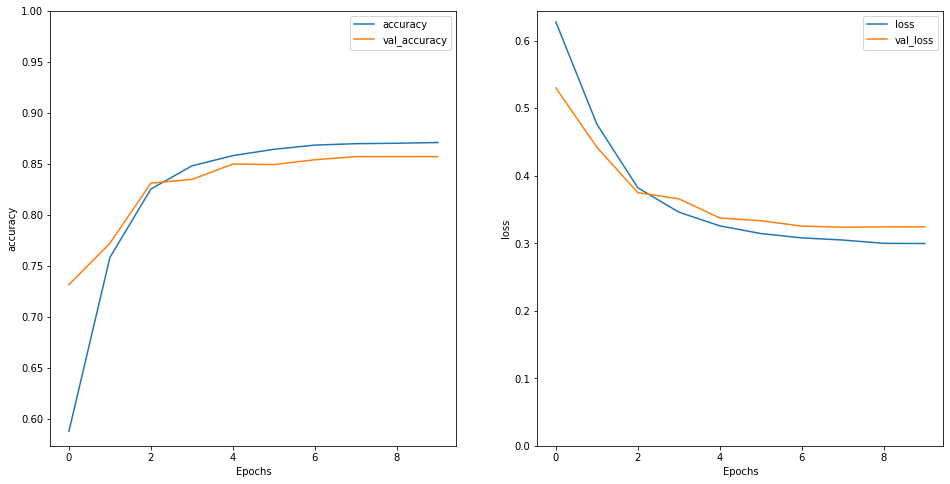

In [21]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

Run a prediction on a neew sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [22]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.ipynb)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [23]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [25]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 0s - loss: 0.6936 - accuracy: 0.4844

  2/391 [..............................] - ETA: 32s - loss: 0.6934 - accuracy: 0.4922

  3/391 [..............................] - ETA: 37s - loss: 0.6934 - accuracy: 0.4688

  4/391 [..............................] - ETA: 38s - loss: 0.6937 - accuracy: 0.4414

  5/391 [..............................] - ETA: 39s - loss: 0.6935 - accuracy: 0.4688

  6/391 [..............................] - ETA: 40s - loss: 0.6934 - accuracy: 0.4792

  7/391 [..............................] - ETA: 41s - loss: 0.6933 - accuracy: 0.4844

  8/391 [..............................] - ETA: 42s - loss: 0.6933 - accuracy: 0.4902

  9/391 [..............................] - ETA: 42s - loss: 0.6932 - accuracy: 0.4913

 10/391 [..............................] - ETA: 42s - loss: 0.6932 - accuracy: 0.4984

 11/391 [..............................] - ETA: 42s - loss: 0.6932 - accuracy: 0.4943

 12/391 [..............................] - ETA: 42s - loss: 0.6932 - accuracy: 0.4922

 13/391 [..............................] - ETA: 42s - loss: 0.6933 - accuracy: 0.4916

 14/391 [>.............................] - ETA: 43s - loss: 0.6932 - accuracy: 0.4911

 15/391 [>.............................] - ETA: 43s - loss: 0.6932 - accuracy: 0.4948

 16/391 [>.............................] - ETA: 43s - loss: 0.6932 - accuracy: 0.4902

 17/391 [>.............................] - ETA: 43s - loss: 0.6932 - accuracy: 0.4881

 18/391 [>.............................] - ETA: 43s - loss: 0.6932 - accuracy: 0.4931

 19/391 [>.............................] - ETA: 42s - loss: 0.6932 - accuracy: 0.4984

 20/391 [>.............................] - ETA: 45s - loss: 0.6932 - accuracy: 0.5016

 21/391 [>.............................] - ETA: 45s - loss: 0.6932 - accuracy: 0.5000

 22/391 [>.............................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5021

 23/391 [>.............................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5000

 24/391 [>.............................] - ETA: 45s - loss: 0.6931 - accuracy: 0.4954

 25/391 [>.............................] - ETA: 45s - loss: 0.6931 - accuracy: 0.4925

 26/391 [>.............................] - ETA: 45s - loss: 0.6931 - accuracy: 0.4922

 27/391 [=>............................] - ETA: 44s - loss: 0.6931 - accuracy: 0.4959

 28/391 [=>............................] - ETA: 44s - loss: 0.6931 - accuracy: 0.4950

 29/391 [=>............................] - ETA: 44s - loss: 0.6931 - accuracy: 0.4919

 30/391 [=>............................] - ETA: 44s - loss: 0.6931 - accuracy: 0.4896

 31/391 [=>............................] - ETA: 44s - loss: 0.6931 - accuracy: 0.4909

 32/391 [=>............................] - ETA: 44s - loss: 0.6931 - accuracy: 0.4883

 33/391 [=>............................] - ETA: 43s - loss: 0.6931 - accuracy: 0.4891

 34/391 [=>............................] - ETA: 43s - loss: 0.6931 - accuracy: 0.4903

 35/391 [=>............................] - ETA: 43s - loss: 0.6931 - accuracy: 0.4920

 36/391 [=>............................] - ETA: 43s - loss: 0.6931 - accuracy: 0.4931

 37/391 [=>............................] - ETA: 43s - loss: 0.6931 - accuracy: 0.4924

 38/391 [=>............................] - ETA: 43s - loss: 0.6931 - accuracy: 0.4930

 39/391 [=>............................] - ETA: 42s - loss: 0.6931 - accuracy: 0.4908

 40/391 [==>...........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.4914

 41/391 [==>...........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.4916

 42/391 [==>...........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.4918

 43/391 [==>...........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.4931

 44/391 [==>...........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.4922

 45/391 [==>...........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.4920

 46/391 [==>...........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.4901

 47/391 [==>...........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.4890

 48/391 [==>...........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.4883

 49/391 [==>...........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.4898

 50/391 [==>...........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.4897

 51/391 [==>...........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.4893

 52/391 [==>...........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.4904

 53/391 [===>..........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.4915

 54/391 [===>..........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.4933

 55/391 [===>..........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.4966

 56/391 [===>..........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.4975

 57/391 [===>..........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.4964

 58/391 [===>..........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.4968

 59/391 [===>..........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.4958

 60/391 [===>..........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.4971

 61/391 [===>..........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.4962

 62/391 [===>..........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.4977

 63/391 [===>..........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.4975

 64/391 [===>..........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.4988

 65/391 [===>..........................] - ETA: 40s - loss: 0.6931 - accuracy: 0.4976

 66/391 [====>.........................] - ETA: 40s - loss: 0.6931 - accuracy: 0.4979

 67/391 [====>.........................] - ETA: 40s - loss: 0.6931 - accuracy: 0.4995

 68/391 [====>.........................] - ETA: 40s - loss: 0.6931 - accuracy: 0.4982

 69/391 [====>.........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.4971

 70/391 [====>.........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.4964

 71/391 [====>.........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.4965

 72/391 [====>.........................] - ETA: 40s - loss: 0.6931 - accuracy: 0.4972

 73/391 [====>.........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4972

 74/391 [====>.........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4970

 75/391 [====>.........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4958

 76/391 [====>.........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4942

 77/391 [====>.........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4935

 78/391 [====>.........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4928

 79/391 [=====>........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4933

 80/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4928

 81/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4919

 82/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4937

 83/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4925

 84/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4909

 85/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4908

 86/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4922

 87/391 [=====>........................] - ETA: 37s - loss: 0.6930 - accuracy: 0.4930

 88/391 [=====>........................] - ETA: 37s - loss: 0.6930 - accuracy: 0.4933

 89/391 [=====>........................] - ETA: 37s - loss: 0.6930 - accuracy: 0.4942

 90/391 [=====>........................] - ETA: 37s - loss: 0.6930 - accuracy: 0.4955

 91/391 [=====>........................] - ETA: 37s - loss: 0.6930 - accuracy: 0.4962

 92/391 [======>.......................] - ETA: 37s - loss: 0.6930 - accuracy: 0.4963

 93/391 [======>.......................] - ETA: 37s - loss: 0.6930 - accuracy: 0.4960

 94/391 [======>.......................] - ETA: 37s - loss: 0.6930 - accuracy: 0.4963

 95/391 [======>.......................] - ETA: 36s - loss: 0.6930 - accuracy: 0.4964

 96/391 [======>.......................] - ETA: 36s - loss: 0.6930 - accuracy: 0.4974

 97/391 [======>.......................] - ETA: 36s - loss: 0.6930 - accuracy: 0.4974

 98/391 [======>.......................] - ETA: 36s - loss: 0.6930 - accuracy: 0.4973

 99/391 [======>.......................] - ETA: 36s - loss: 0.6930 - accuracy: 0.4978

100/391 [======>.......................] - ETA: 36s - loss: 0.6930 - accuracy: 0.4983

101/391 [======>.......................] - ETA: 36s - loss: 0.6930 - accuracy: 0.4988

102/391 [======>.......................] - ETA: 35s - loss: 0.6930 - accuracy: 0.4992

103/391 [======>.......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.4997

104/391 [======>.......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5005

105/391 [=======>......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5000

106/391 [=======>......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5006

107/391 [=======>......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5006

108/391 [=======>......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5004

109/391 [=======>......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5003

110/391 [=======>......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5000

111/391 [=======>......................] - ETA: 34s - loss: 0.6929 - accuracy: 0.4993

112/391 [=======>......................] - ETA: 34s - loss: 0.6929 - accuracy: 0.4997

113/391 [=======>......................] - ETA: 34s - loss: 0.6929 - accuracy: 0.5003

114/391 [=======>......................] - ETA: 34s - loss: 0.6929 - accuracy: 0.4997

115/391 [=======>......................] - ETA: 34s - loss: 0.6929 - accuracy: 0.5004

116/391 [=======>......................] - ETA: 34s - loss: 0.6929 - accuracy: 0.4999

117/391 [=======>......................] - ETA: 34s - loss: 0.6929 - accuracy: 0.4997

118/391 [========>.....................] - ETA: 34s - loss: 0.6929 - accuracy: 0.5007

119/391 [========>.....................] - ETA: 33s - loss: 0.6929 - accuracy: 0.5001

120/391 [========>.....................] - ETA: 33s - loss: 0.6929 - accuracy: 0.4995

121/391 [========>.....................] - ETA: 33s - loss: 0.6928 - accuracy: 0.5006

122/391 [========>.....................] - ETA: 33s - loss: 0.6928 - accuracy: 0.5003

123/391 [========>.....................] - ETA: 33s - loss: 0.6928 - accuracy: 0.5013

124/391 [========>.....................] - ETA: 33s - loss: 0.6928 - accuracy: 0.5013

125/391 [========>.....................] - ETA: 33s - loss: 0.6928 - accuracy: 0.5014

126/391 [========>.....................] - ETA: 33s - loss: 0.6928 - accuracy: 0.5011

127/391 [========>.....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.5005

128/391 [========>.....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.5006

129/391 [========>.....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.5010

130/391 [========>.....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.5006

131/391 [=========>....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.5012

132/391 [=========>....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.5015

133/391 [=========>....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.5020

134/391 [=========>....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.5014

135/391 [=========>....................] - ETA: 32s - loss: 0.6927 - accuracy: 0.5019

136/391 [=========>....................] - ETA: 32s - loss: 0.6927 - accuracy: 0.5013

137/391 [=========>....................] - ETA: 31s - loss: 0.6927 - accuracy: 0.5015

138/391 [=========>....................] - ETA: 31s - loss: 0.6927 - accuracy: 0.5012

139/391 [=========>....................] - ETA: 31s - loss: 0.6927 - accuracy: 0.5017

140/391 [=========>....................] - ETA: 31s - loss: 0.6927 - accuracy: 0.5017

141/391 [=========>....................] - ETA: 31s - loss: 0.6927 - accuracy: 0.5016

142/391 [=========>....................] - ETA: 31s - loss: 0.6927 - accuracy: 0.5014

143/391 [=========>....................] - ETA: 31s - loss: 0.6926 - accuracy: 0.5014

144/391 [==========>...................] - ETA: 31s - loss: 0.6926 - accuracy: 0.5009

145/391 [==========>...................] - ETA: 30s - loss: 0.6926 - accuracy: 0.5005

146/391 [==========>...................] - ETA: 30s - loss: 0.6926 - accuracy: 0.5000

147/391 [==========>...................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4998

148/391 [==========>...................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4995

149/391 [==========>...................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4998

150/391 [==========>...................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4994

151/391 [==========>...................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4989

152/391 [==========>...................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4991

153/391 [==========>...................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4994

154/391 [==========>...................] - ETA: 29s - loss: 0.6926 - accuracy: 0.5001

155/391 [==========>...................] - ETA: 29s - loss: 0.6926 - accuracy: 0.4997

156/391 [==========>...................] - ETA: 29s - loss: 0.6925 - accuracy: 0.5002

157/391 [===========>..................] - ETA: 29s - loss: 0.6925 - accuracy: 0.5003

158/391 [===========>..................] - ETA: 29s - loss: 0.6925 - accuracy: 0.5005

159/391 [===========>..................] - ETA: 29s - loss: 0.6925 - accuracy: 0.5006

160/391 [===========>..................] - ETA: 29s - loss: 0.6925 - accuracy: 0.5004

161/391 [===========>..................] - ETA: 29s - loss: 0.6925 - accuracy: 0.4999

162/391 [===========>..................] - ETA: 28s - loss: 0.6925 - accuracy: 0.4996

163/391 [===========>..................] - ETA: 28s - loss: 0.6925 - accuracy: 0.5000

164/391 [===========>..................] - ETA: 28s - loss: 0.6925 - accuracy: 0.5004

165/391 [===========>..................] - ETA: 28s - loss: 0.6924 - accuracy: 0.4999

166/391 [===========>..................] - ETA: 28s - loss: 0.6924 - accuracy: 0.5001

167/391 [===========>..................] - ETA: 28s - loss: 0.6924 - accuracy: 0.4999

168/391 [===========>..................] - ETA: 28s - loss: 0.6924 - accuracy: 0.5001

169/391 [===========>..................] - ETA: 28s - loss: 0.6924 - accuracy: 0.4992

170/391 [============>.................] - ETA: 28s - loss: 0.6923 - accuracy: 0.4985

171/391 [============>.................] - ETA: 27s - loss: 0.6923 - accuracy: 0.4986

172/391 [============>.................] - ETA: 27s - loss: 0.6923 - accuracy: 0.4984

173/391 [============>.................] - ETA: 27s - loss: 0.6923 - accuracy: 0.4974

174/391 [============>.................] - ETA: 27s - loss: 0.6923 - accuracy: 0.4971

175/391 [============>.................] - ETA: 27s - loss: 0.6922 - accuracy: 0.4974

176/391 [============>.................] - ETA: 27s - loss: 0.6922 - accuracy: 0.4974

177/391 [============>.................] - ETA: 27s - loss: 0.6922 - accuracy: 0.4974

178/391 [============>.................] - ETA: 27s - loss: 0.6922 - accuracy: 0.4980

179/391 [============>.................] - ETA: 26s - loss: 0.6922 - accuracy: 0.4978

180/391 [============>.................] - ETA: 26s - loss: 0.6922 - accuracy: 0.4978

181/391 [============>.................] - ETA: 26s - loss: 0.6922 - accuracy: 0.4980

182/391 [============>.................] - ETA: 26s - loss: 0.6922 - accuracy: 0.4987

183/391 [=============>................] - ETA: 26s - loss: 0.6921 - accuracy: 0.4989

184/391 [=============>................] - ETA: 26s - loss: 0.6921 - accuracy: 0.4989

185/391 [=============>................] - ETA: 26s - loss: 0.6921 - accuracy: 0.4996

186/391 [=============>................] - ETA: 26s - loss: 0.6921 - accuracy: 0.5001

187/391 [=============>................] - ETA: 25s - loss: 0.6921 - accuracy: 0.5004

188/391 [=============>................] - ETA: 25s - loss: 0.6921 - accuracy: 0.5005

189/391 [=============>................] - ETA: 25s - loss: 0.6920 - accuracy: 0.5007

190/391 [=============>................] - ETA: 25s - loss: 0.6920 - accuracy: 0.5010

191/391 [=============>................] - ETA: 25s - loss: 0.6920 - accuracy: 0.5011

192/391 [=============>................] - ETA: 25s - loss: 0.6920 - accuracy: 0.5006

193/391 [=============>................] - ETA: 25s - loss: 0.6919 - accuracy: 0.5015

194/391 [=============>................] - ETA: 25s - loss: 0.6919 - accuracy: 0.5018

195/391 [=============>................] - ETA: 24s - loss: 0.6919 - accuracy: 0.5009

196/391 [==============>...............] - ETA: 24s - loss: 0.6919 - accuracy: 0.5011

197/391 [==============>...............] - ETA: 24s - loss: 0.6919 - accuracy: 0.5008

198/391 [==============>...............] - ETA: 24s - loss: 0.6919 - accuracy: 0.5005

199/391 [==============>...............] - ETA: 24s - loss: 0.6918 - accuracy: 0.5009

200/391 [==============>...............] - ETA: 24s - loss: 0.6918 - accuracy: 0.5008

201/391 [==============>...............] - ETA: 24s - loss: 0.6918 - accuracy: 0.5007

202/391 [==============>...............] - ETA: 24s - loss: 0.6918 - accuracy: 0.5006

203/391 [==============>...............] - ETA: 23s - loss: 0.6918 - accuracy: 0.5005

204/391 [==============>...............] - ETA: 23s - loss: 0.6917 - accuracy: 0.5005

205/391 [==============>...............] - ETA: 23s - loss: 0.6917 - accuracy: 0.5005

206/391 [==============>...............] - ETA: 23s - loss: 0.6917 - accuracy: 0.5005

207/391 [==============>...............] - ETA: 23s - loss: 0.6916 - accuracy: 0.5006

208/391 [==============>...............] - ETA: 23s - loss: 0.6916 - accuracy: 0.5008

209/391 [===============>..............] - ETA: 23s - loss: 0.6916 - accuracy: 0.5012

210/391 [===============>..............] - ETA: 23s - loss: 0.6916 - accuracy: 0.5012

211/391 [===============>..............] - ETA: 22s - loss: 0.6915 - accuracy: 0.5013

212/391 [===============>..............] - ETA: 22s - loss: 0.6915 - accuracy: 0.5011

213/391 [===============>..............] - ETA: 22s - loss: 0.6915 - accuracy: 0.5009

214/391 [===============>..............] - ETA: 22s - loss: 0.6915 - accuracy: 0.5009

215/391 [===============>..............] - ETA: 22s - loss: 0.6914 - accuracy: 0.5012

216/391 [===============>..............] - ETA: 22s - loss: 0.6914 - accuracy: 0.5016

217/391 [===============>..............] - ETA: 22s - loss: 0.6913 - accuracy: 0.5015

218/391 [===============>..............] - ETA: 21s - loss: 0.6913 - accuracy: 0.5017

219/391 [===============>..............] - ETA: 21s - loss: 0.6913 - accuracy: 0.5017

220/391 [===============>..............] - ETA: 21s - loss: 0.6913 - accuracy: 0.5020

221/391 [===============>..............] - ETA: 21s - loss: 0.6912 - accuracy: 0.5023

222/391 [================>.............] - ETA: 21s - loss: 0.6911 - accuracy: 0.5022

223/391 [================>.............] - ETA: 21s - loss: 0.6911 - accuracy: 0.5022

224/391 [================>.............] - ETA: 21s - loss: 0.6911 - accuracy: 0.5020

225/391 [================>.............] - ETA: 21s - loss: 0.6910 - accuracy: 0.5022

226/391 [================>.............] - ETA: 20s - loss: 0.6910 - accuracy: 0.5022

227/391 [================>.............] - ETA: 20s - loss: 0.6909 - accuracy: 0.5021

228/391 [================>.............] - ETA: 20s - loss: 0.6909 - accuracy: 0.5018

229/391 [================>.............] - ETA: 20s - loss: 0.6908 - accuracy: 0.5025

230/391 [================>.............] - ETA: 20s - loss: 0.6908 - accuracy: 0.5022

231/391 [================>.............] - ETA: 20s - loss: 0.6907 - accuracy: 0.5023

232/391 [================>.............] - ETA: 20s - loss: 0.6907 - accuracy: 0.5027

233/391 [================>.............] - ETA: 20s - loss: 0.6906 - accuracy: 0.5025

234/391 [================>.............] - ETA: 19s - loss: 0.6905 - accuracy: 0.5023

235/391 [=================>............] - ETA: 19s - loss: 0.6904 - accuracy: 0.5027

236/391 [=================>............] - ETA: 19s - loss: 0.6904 - accuracy: 0.5026

237/391 [=================>............] - ETA: 19s - loss: 0.6904 - accuracy: 0.5028

238/391 [=================>............] - ETA: 19s - loss: 0.6903 - accuracy: 0.5026

239/391 [=================>............] - ETA: 19s - loss: 0.6903 - accuracy: 0.5026

240/391 [=================>............] - ETA: 19s - loss: 0.6901 - accuracy: 0.5030

241/391 [=================>............] - ETA: 19s - loss: 0.6900 - accuracy: 0.5033

242/391 [=================>............] - ETA: 18s - loss: 0.6898 - accuracy: 0.5034

243/391 [=================>............] - ETA: 18s - loss: 0.6897 - accuracy: 0.5034

244/391 [=================>............] - ETA: 18s - loss: 0.6895 - accuracy: 0.5035

245/391 [=================>............] - ETA: 18s - loss: 0.6893 - accuracy: 0.5034

246/391 [=================>............] - ETA: 18s - loss: 0.6892 - accuracy: 0.5034

247/391 [=================>............] - ETA: 18s - loss: 0.6889 - accuracy: 0.5035

248/391 [==================>...........] - ETA: 18s - loss: 0.6887 - accuracy: 0.5037

249/391 [==================>...........] - ETA: 18s - loss: 0.6885 - accuracy: 0.5033

250/391 [==================>...........] - ETA: 17s - loss: 0.6881 - accuracy: 0.5038

251/391 [==================>...........] - ETA: 17s - loss: 0.6877 - accuracy: 0.5042

252/391 [==================>...........] - ETA: 17s - loss: 0.6876 - accuracy: 0.5045

253/391 [==================>...........] - ETA: 17s - loss: 0.6872 - accuracy: 0.5046

254/391 [==================>...........] - ETA: 17s - loss: 0.6867 - accuracy: 0.5052

255/391 [==================>...........] - ETA: 17s - loss: 0.6862 - accuracy: 0.5059

256/391 [==================>...........] - ETA: 17s - loss: 0.6856 - accuracy: 0.5067

257/391 [==================>...........] - ETA: 17s - loss: 0.6852 - accuracy: 0.5074

258/391 [==================>...........] - ETA: 16s - loss: 0.6850 - accuracy: 0.5081

259/391 [==================>...........] - ETA: 16s - loss: 0.6846 - accuracy: 0.5089

260/391 [==================>...........] - ETA: 16s - loss: 0.6842 - accuracy: 0.5095

261/391 [===================>..........] - ETA: 16s - loss: 0.6840 - accuracy: 0.5099

262/391 [===================>..........] - ETA: 16s - loss: 0.6837 - accuracy: 0.5105

263/391 [===================>..........] - ETA: 16s - loss: 0.6837 - accuracy: 0.5109

264/391 [===================>..........] - ETA: 16s - loss: 0.6837 - accuracy: 0.5114

265/391 [===================>..........] - ETA: 16s - loss: 0.6839 - accuracy: 0.5116

266/391 [===================>..........] - ETA: 16s - loss: 0.6838 - accuracy: 0.5120

267/391 [===================>..........] - ETA: 15s - loss: 0.6837 - accuracy: 0.5126

268/391 [===================>..........] - ETA: 15s - loss: 0.6834 - accuracy: 0.5129

269/391 [===================>..........] - ETA: 15s - loss: 0.6830 - accuracy: 0.5137

270/391 [===================>..........] - ETA: 15s - loss: 0.6831 - accuracy: 0.5140

271/391 [===================>..........] - ETA: 15s - loss: 0.6832 - accuracy: 0.5143

272/391 [===================>..........] - ETA: 15s - loss: 0.6830 - accuracy: 0.5147

273/391 [===================>..........] - ETA: 15s - loss: 0.6829 - accuracy: 0.5149

274/391 [====================>.........] - ETA: 15s - loss: 0.6829 - accuracy: 0.5152

275/391 [====================>.........] - ETA: 14s - loss: 0.6828 - accuracy: 0.5153

276/391 [====================>.........] - ETA: 14s - loss: 0.6824 - accuracy: 0.5160

277/391 [====================>.........] - ETA: 14s - loss: 0.6820 - accuracy: 0.5166

278/391 [====================>.........] - ETA: 14s - loss: 0.6812 - accuracy: 0.5172

279/391 [====================>.........] - ETA: 14s - loss: 0.6809 - accuracy: 0.5176

280/391 [====================>.........] - ETA: 14s - loss: 0.6802 - accuracy: 0.5181

281/391 [====================>.........] - ETA: 14s - loss: 0.6798 - accuracy: 0.5186

282/391 [====================>.........] - ETA: 13s - loss: 0.6794 - accuracy: 0.5189

283/391 [====================>.........] - ETA: 13s - loss: 0.6794 - accuracy: 0.5191

284/391 [====================>.........] - ETA: 13s - loss: 0.6795 - accuracy: 0.5194

285/391 [====================>.........] - ETA: 13s - loss: 0.6797 - accuracy: 0.5195

286/391 [====================>.........] - ETA: 13s - loss: 0.6793 - accuracy: 0.5201

287/391 [=====================>........] - ETA: 13s - loss: 0.6795 - accuracy: 0.5204

288/391 [=====================>........] - ETA: 13s - loss: 0.6795 - accuracy: 0.5203

289/391 [=====================>........] - ETA: 13s - loss: 0.6790 - accuracy: 0.5209

290/391 [=====================>........] - ETA: 12s - loss: 0.6788 - accuracy: 0.5211

291/391 [=====================>........] - ETA: 12s - loss: 0.6786 - accuracy: 0.5212

292/391 [=====================>........] - ETA: 12s - loss: 0.6784 - accuracy: 0.5216

293/391 [=====================>........] - ETA: 12s - loss: 0.6783 - accuracy: 0.5221

294/391 [=====================>........] - ETA: 12s - loss: 0.6779 - accuracy: 0.5225

295/391 [=====================>........] - ETA: 12s - loss: 0.6776 - accuracy: 0.5229

296/391 [=====================>........] - ETA: 12s - loss: 0.6773 - accuracy: 0.5238

297/391 [=====================>........] - ETA: 12s - loss: 0.6771 - accuracy: 0.5237

298/391 [=====================>........] - ETA: 11s - loss: 0.6769 - accuracy: 0.5241

299/391 [=====================>........] - ETA: 11s - loss: 0.6767 - accuracy: 0.5246

300/391 [======================>.......] - ETA: 11s - loss: 0.6765 - accuracy: 0.5249

301/391 [======================>.......] - ETA: 11s - loss: 0.6769 - accuracy: 0.5248

302/391 [======================>.......] - ETA: 11s - loss: 0.6767 - accuracy: 0.5251

303/391 [======================>.......] - ETA: 11s - loss: 0.6765 - accuracy: 0.5254

304/391 [======================>.......] - ETA: 11s - loss: 0.6765 - accuracy: 0.5258

305/391 [======================>.......] - ETA: 11s - loss: 0.6763 - accuracy: 0.5262

306/391 [======================>.......] - ETA: 10s - loss: 0.6763 - accuracy: 0.5264

307/391 [======================>.......] - ETA: 10s - loss: 0.6762 - accuracy: 0.5266

308/391 [======================>.......] - ETA: 10s - loss: 0.6760 - accuracy: 0.5271

309/391 [======================>.......] - ETA: 10s - loss: 0.6759 - accuracy: 0.5276

310/391 [======================>.......] - ETA: 10s - loss: 0.6759 - accuracy: 0.5281

311/391 [======================>.......] - ETA: 10s - loss: 0.6758 - accuracy: 0.5285

312/391 [======================>.......] - ETA: 10s - loss: 0.6753 - accuracy: 0.5289

313/391 [=======================>......] - ETA: 10s - loss: 0.6751 - accuracy: 0.5296

314/391 [=======================>......] - ETA: 9s - loss: 0.6748 - accuracy: 0.5300 

315/391 [=======================>......] - ETA: 9s - loss: 0.6747 - accuracy: 0.5297

316/391 [=======================>......] - ETA: 9s - loss: 0.6742 - accuracy: 0.5301

317/391 [=======================>......] - ETA: 9s - loss: 0.6739 - accuracy: 0.5303

318/391 [=======================>......] - ETA: 9s - loss: 0.6736 - accuracy: 0.5304

319/391 [=======================>......] - ETA: 9s - loss: 0.6731 - accuracy: 0.5308

320/391 [=======================>......] - ETA: 9s - loss: 0.6728 - accuracy: 0.5313

321/391 [=======================>......] - ETA: 9s - loss: 0.6726 - accuracy: 0.5316

322/391 [=======================>......] - ETA: 8s - loss: 0.6722 - accuracy: 0.5322

323/391 [=======================>......] - ETA: 8s - loss: 0.6720 - accuracy: 0.5322

324/391 [=======================>......] - ETA: 8s - loss: 0.6717 - accuracy: 0.5324

325/391 [=======================>......] - ETA: 8s - loss: 0.6715 - accuracy: 0.5327

326/391 [========================>.....] - ETA: 8s - loss: 0.6711 - accuracy: 0.5333

327/391 [========================>.....] - ETA: 8s - loss: 0.6710 - accuracy: 0.5333

328/391 [========================>.....] - ETA: 8s - loss: 0.6709 - accuracy: 0.5338

329/391 [========================>.....] - ETA: 7s - loss: 0.6705 - accuracy: 0.5344

330/391 [========================>.....] - ETA: 7s - loss: 0.6701 - accuracy: 0.5347

331/391 [========================>.....] - ETA: 7s - loss: 0.6695 - accuracy: 0.5351

332/391 [========================>.....] - ETA: 7s - loss: 0.6692 - accuracy: 0.5355

333/391 [========================>.....] - ETA: 7s - loss: 0.6690 - accuracy: 0.5358

334/391 [========================>.....] - ETA: 7s - loss: 0.6686 - accuracy: 0.5361

335/391 [========================>.....] - ETA: 7s - loss: 0.6685 - accuracy: 0.5361

336/391 [========================>.....] - ETA: 7s - loss: 0.6681 - accuracy: 0.5365

337/391 [========================>.....] - ETA: 6s - loss: 0.6676 - accuracy: 0.5373

338/391 [========================>.....] - ETA: 6s - loss: 0.6672 - accuracy: 0.5375

339/391 [=========================>....] - ETA: 6s - loss: 0.6671 - accuracy: 0.5377

340/391 [=========================>....] - ETA: 6s - loss: 0.6666 - accuracy: 0.5382

341/391 [=========================>....] - ETA: 6s - loss: 0.6663 - accuracy: 0.5386

342/391 [=========================>....] - ETA: 6s - loss: 0.6660 - accuracy: 0.5392

343/391 [=========================>....] - ETA: 6s - loss: 0.6655 - accuracy: 0.5399

344/391 [=========================>....] - ETA: 6s - loss: 0.6653 - accuracy: 0.5402

345/391 [=========================>....] - ETA: 5s - loss: 0.6650 - accuracy: 0.5408

346/391 [=========================>....] - ETA: 5s - loss: 0.6647 - accuracy: 0.5414

347/391 [=========================>....] - ETA: 5s - loss: 0.6647 - accuracy: 0.5417

348/391 [=========================>....] - ETA: 5s - loss: 0.6647 - accuracy: 0.5421

349/391 [=========================>....] - ETA: 5s - loss: 0.6642 - accuracy: 0.5427

350/391 [=========================>....] - ETA: 5s - loss: 0.6637 - accuracy: 0.5433

351/391 [=========================>....] - ETA: 5s - loss: 0.6633 - accuracy: 0.5441

352/391 [==========================>...] - ETA: 5s - loss: 0.6628 - accuracy: 0.5447

353/391 [==========================>...] - ETA: 4s - loss: 0.6625 - accuracy: 0.5451

354/391 [==========================>...] - ETA: 4s - loss: 0.6621 - accuracy: 0.5458

355/391 [==========================>...] - ETA: 4s - loss: 0.6618 - accuracy: 0.5463

356/391 [==========================>...] - ETA: 4s - loss: 0.6615 - accuracy: 0.5469

357/391 [==========================>...] - ETA: 4s - loss: 0.6612 - accuracy: 0.5474

358/391 [==========================>...] - ETA: 4s - loss: 0.6608 - accuracy: 0.5480

359/391 [==========================>...] - ETA: 4s - loss: 0.6603 - accuracy: 0.5486

360/391 [==========================>...] - ETA: 4s - loss: 0.6599 - accuracy: 0.5491

361/391 [==========================>...] - ETA: 3s - loss: 0.6594 - accuracy: 0.5498

362/391 [==========================>...] - ETA: 3s - loss: 0.6591 - accuracy: 0.5502

363/391 [==========================>...] - ETA: 3s - loss: 0.6590 - accuracy: 0.5504

364/391 [==========================>...] - ETA: 3s - loss: 0.6585 - accuracy: 0.5510

365/391 [===========================>..] - ETA: 3s - loss: 0.6583 - accuracy: 0.5513

366/391 [===========================>..] - ETA: 3s - loss: 0.6581 - accuracy: 0.5517

367/391 [===========================>..] - ETA: 3s - loss: 0.6576 - accuracy: 0.5523

368/391 [===========================>..] - ETA: 2s - loss: 0.6572 - accuracy: 0.5528

369/391 [===========================>..] - ETA: 2s - loss: 0.6571 - accuracy: 0.5531

370/391 [===========================>..] - ETA: 2s - loss: 0.6567 - accuracy: 0.5535

371/391 [===========================>..] - ETA: 2s - loss: 0.6563 - accuracy: 0.5541

372/391 [===========================>..] - ETA: 2s - loss: 0.6557 - accuracy: 0.5549

373/391 [===========================>..] - ETA: 2s - loss: 0.6556 - accuracy: 0.5554

374/391 [===========================>..] - ETA: 2s - loss: 0.6554 - accuracy: 0.5558

375/391 [===========================>..] - ETA: 2s - loss: 0.6554 - accuracy: 0.5564

376/391 [===========================>..] - ETA: 1s - loss: 0.6554 - accuracy: 0.5565

377/391 [===========================>..] - ETA: 1s - loss: 0.6550 - accuracy: 0.5572

378/391 [============================>.] - ETA: 1s - loss: 0.6546 - accuracy: 0.5580

379/391 [============================>.] - ETA: 1s - loss: 0.6544 - accuracy: 0.5585

380/391 [============================>.] - ETA: 1s - loss: 0.6542 - accuracy: 0.5589

381/391 [============================>.] - ETA: 1s - loss: 0.6538 - accuracy: 0.5595

382/391 [============================>.] - ETA: 1s - loss: 0.6536 - accuracy: 0.5598

383/391 [============================>.] - ETA: 1s - loss: 0.6533 - accuracy: 0.5599

384/391 [============================>.] - ETA: 0s - loss: 0.6530 - accuracy: 0.5603

385/391 [============================>.] - ETA: 0s - loss: 0.6526 - accuracy: 0.5604

386/391 [============================>.] - ETA: 0s - loss: 0.6524 - accuracy: 0.5607

387/391 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.5611

388/391 [============================>.] - ETA: 0s - loss: 0.6516 - accuracy: 0.5615

389/391 [============================>.] - ETA: 0s - loss: 0.6512 - accuracy: 0.5619

390/391 [============================>.] - ETA: 0s - loss: 0.6510 - accuracy: 0.5621

391/391 [==============================] - ETA: 0s - loss: 0.6507 - accuracy: 0.5621

391/391 [==============================] - 56s 144ms/step - loss: 0.6507 - accuracy: 0.5621 - val_loss: 0.5173 - val_accuracy: 0.6797


Epoch 2/10


  1/391 [..............................] - ETA: 0s - loss: 0.5358 - accuracy: 0.5781

  2/391 [..............................] - ETA: 23s - loss: 0.5343 - accuracy: 0.6250

  3/391 [..............................] - ETA: 32s - loss: 0.5387 - accuracy: 0.6510

  4/391 [..............................] - ETA: 37s - loss: 0.5391 - accuracy: 0.6641

  5/391 [..............................] - ETA: 39s - loss: 0.5268 - accuracy: 0.6781

  6/391 [..............................] - ETA: 41s - loss: 0.5189 - accuracy: 0.6979

  7/391 [..............................] - ETA: 41s - loss: 0.5172 - accuracy: 0.7009

  8/391 [..............................] - ETA: 40s - loss: 0.5167 - accuracy: 0.7129

  9/391 [..............................] - ETA: 41s - loss: 0.5059 - accuracy: 0.7257

 10/391 [..............................] - ETA: 41s - loss: 0.5008 - accuracy: 0.7297

 11/391 [..............................] - ETA: 42s - loss: 0.5017 - accuracy: 0.7330

 12/391 [..............................] - ETA: 42s - loss: 0.4981 - accuracy: 0.7383

 13/391 [..............................] - ETA: 41s - loss: 0.4958 - accuracy: 0.7368

 14/391 [>.............................] - ETA: 42s - loss: 0.4964 - accuracy: 0.7333

 15/391 [>.............................] - ETA: 41s - loss: 0.4888 - accuracy: 0.7396

 16/391 [>.............................] - ETA: 41s - loss: 0.4877 - accuracy: 0.7422

 17/391 [>.............................] - ETA: 41s - loss: 0.4876 - accuracy: 0.7454

 18/391 [>.............................] - ETA: 41s - loss: 0.4880 - accuracy: 0.7474

 19/391 [>.............................] - ETA: 41s - loss: 0.4857 - accuracy: 0.7492

 20/391 [>.............................] - ETA: 42s - loss: 0.4825 - accuracy: 0.7539

 21/391 [>.............................] - ETA: 41s - loss: 0.4799 - accuracy: 0.7567

 22/391 [>.............................] - ETA: 42s - loss: 0.4800 - accuracy: 0.7585

 23/391 [>.............................] - ETA: 42s - loss: 0.4830 - accuracy: 0.7582

 24/391 [>.............................] - ETA: 41s - loss: 0.4800 - accuracy: 0.7624

 25/391 [>.............................] - ETA: 41s - loss: 0.4786 - accuracy: 0.7638

 26/391 [>.............................] - ETA: 42s - loss: 0.4795 - accuracy: 0.7650

 27/391 [=>............................] - ETA: 42s - loss: 0.4821 - accuracy: 0.7622

 28/391 [=>............................] - ETA: 41s - loss: 0.4828 - accuracy: 0.7628

 29/391 [=>............................] - ETA: 41s - loss: 0.4843 - accuracy: 0.7624

 30/391 [=>............................] - ETA: 41s - loss: 0.4844 - accuracy: 0.7630

 31/391 [=>............................] - ETA: 41s - loss: 0.4852 - accuracy: 0.7646

 32/391 [=>............................] - ETA: 41s - loss: 0.4901 - accuracy: 0.7637

 33/391 [=>............................] - ETA: 41s - loss: 0.4910 - accuracy: 0.7647

 34/391 [=>............................] - ETA: 41s - loss: 0.4873 - accuracy: 0.7670

 35/391 [=>............................] - ETA: 41s - loss: 0.4876 - accuracy: 0.7656

 36/391 [=>............................] - ETA: 41s - loss: 0.4866 - accuracy: 0.7674

 37/391 [=>............................] - ETA: 41s - loss: 0.4838 - accuracy: 0.7703

 38/391 [=>............................] - ETA: 41s - loss: 0.4821 - accuracy: 0.7718

 39/391 [=>............................] - ETA: 41s - loss: 0.4850 - accuracy: 0.7688

 40/391 [==>...........................] - ETA: 41s - loss: 0.4847 - accuracy: 0.7684

 41/391 [==>...........................] - ETA: 41s - loss: 0.4829 - accuracy: 0.7675

 42/391 [==>...........................] - ETA: 41s - loss: 0.4815 - accuracy: 0.7679

 43/391 [==>...........................] - ETA: 41s - loss: 0.4829 - accuracy: 0.7656

 44/391 [==>...........................] - ETA: 41s - loss: 0.4819 - accuracy: 0.7663

 45/391 [==>...........................] - ETA: 41s - loss: 0.4817 - accuracy: 0.7656

 46/391 [==>...........................] - ETA: 41s - loss: 0.4803 - accuracy: 0.7663

 47/391 [==>...........................] - ETA: 41s - loss: 0.4780 - accuracy: 0.7689

 48/391 [==>...........................] - ETA: 41s - loss: 0.4764 - accuracy: 0.7708

 49/391 [==>...........................] - ETA: 41s - loss: 0.4768 - accuracy: 0.7710

 50/391 [==>...........................] - ETA: 41s - loss: 0.4759 - accuracy: 0.7722

 51/391 [==>...........................] - ETA: 41s - loss: 0.4748 - accuracy: 0.7724

 52/391 [==>...........................] - ETA: 41s - loss: 0.4749 - accuracy: 0.7722

 53/391 [===>..........................] - ETA: 41s - loss: 0.4732 - accuracy: 0.7742

 54/391 [===>..........................] - ETA: 40s - loss: 0.4717 - accuracy: 0.7752

 55/391 [===>..........................] - ETA: 40s - loss: 0.4730 - accuracy: 0.7730

 56/391 [===>..........................] - ETA: 40s - loss: 0.4726 - accuracy: 0.7737

 57/391 [===>..........................] - ETA: 40s - loss: 0.4720 - accuracy: 0.7741

 58/391 [===>..........................] - ETA: 40s - loss: 0.4701 - accuracy: 0.7753

 59/391 [===>..........................] - ETA: 40s - loss: 0.4697 - accuracy: 0.7741

 60/391 [===>..........................] - ETA: 40s - loss: 0.4704 - accuracy: 0.7729

 61/391 [===>..........................] - ETA: 40s - loss: 0.4699 - accuracy: 0.7725

 62/391 [===>..........................] - ETA: 40s - loss: 0.4705 - accuracy: 0.7717

 63/391 [===>..........................] - ETA: 40s - loss: 0.4702 - accuracy: 0.7723

 64/391 [===>..........................] - ETA: 40s - loss: 0.4684 - accuracy: 0.7734

 65/391 [===>..........................] - ETA: 39s - loss: 0.4672 - accuracy: 0.7745

 66/391 [====>.........................] - ETA: 39s - loss: 0.4669 - accuracy: 0.7749

 67/391 [====>.........................] - ETA: 39s - loss: 0.4666 - accuracy: 0.7752

 68/391 [====>.........................] - ETA: 39s - loss: 0.4677 - accuracy: 0.7748

 69/391 [====>.........................] - ETA: 39s - loss: 0.4662 - accuracy: 0.7769

 70/391 [====>.........................] - ETA: 39s - loss: 0.4658 - accuracy: 0.7770

 71/391 [====>.........................] - ETA: 39s - loss: 0.4671 - accuracy: 0.7764

 72/391 [====>.........................] - ETA: 39s - loss: 0.4663 - accuracy: 0.7771

 73/391 [====>.........................] - ETA: 38s - loss: 0.4667 - accuracy: 0.7770

 74/391 [====>.........................] - ETA: 38s - loss: 0.4652 - accuracy: 0.7777

 75/391 [====>.........................] - ETA: 38s - loss: 0.4639 - accuracy: 0.7779

 76/391 [====>.........................] - ETA: 38s - loss: 0.4664 - accuracy: 0.7769

 77/391 [====>.........................] - ETA: 38s - loss: 0.4651 - accuracy: 0.7780

 78/391 [====>.........................] - ETA: 38s - loss: 0.4656 - accuracy: 0.7770

 79/391 [=====>........................] - ETA: 38s - loss: 0.4652 - accuracy: 0.7769

 80/391 [=====>........................] - ETA: 38s - loss: 0.4648 - accuracy: 0.7771

 81/391 [=====>........................] - ETA: 37s - loss: 0.4648 - accuracy: 0.7766

 82/391 [=====>........................] - ETA: 37s - loss: 0.4645 - accuracy: 0.7774

 83/391 [=====>........................] - ETA: 37s - loss: 0.4629 - accuracy: 0.7788

 84/391 [=====>........................] - ETA: 37s - loss: 0.4620 - accuracy: 0.7792

 85/391 [=====>........................] - ETA: 37s - loss: 0.4628 - accuracy: 0.7785

 86/391 [=====>........................] - ETA: 37s - loss: 0.4620 - accuracy: 0.7793

 87/391 [=====>........................] - ETA: 37s - loss: 0.4611 - accuracy: 0.7800

 88/391 [=====>........................] - ETA: 37s - loss: 0.4620 - accuracy: 0.7791

 89/391 [=====>........................] - ETA: 37s - loss: 0.4616 - accuracy: 0.7793

 90/391 [=====>........................] - ETA: 37s - loss: 0.4609 - accuracy: 0.7793

 91/391 [=====>........................] - ETA: 36s - loss: 0.4596 - accuracy: 0.7806

 92/391 [======>.......................] - ETA: 36s - loss: 0.4597 - accuracy: 0.7806

 93/391 [======>.......................] - ETA: 36s - loss: 0.4586 - accuracy: 0.7816

 94/391 [======>.......................] - ETA: 36s - loss: 0.4581 - accuracy: 0.7821

 95/391 [======>.......................] - ETA: 36s - loss: 0.4586 - accuracy: 0.7812

 96/391 [======>.......................] - ETA: 36s - loss: 0.4582 - accuracy: 0.7816

 97/391 [======>.......................] - ETA: 36s - loss: 0.4580 - accuracy: 0.7816

 98/391 [======>.......................] - ETA: 36s - loss: 0.4587 - accuracy: 0.7817

 99/391 [======>.......................] - ETA: 35s - loss: 0.4581 - accuracy: 0.7824

100/391 [======>.......................] - ETA: 35s - loss: 0.4568 - accuracy: 0.7834

101/391 [======>.......................] - ETA: 35s - loss: 0.4566 - accuracy: 0.7836

102/391 [======>.......................] - ETA: 35s - loss: 0.4565 - accuracy: 0.7839

103/391 [======>.......................] - ETA: 35s - loss: 0.4551 - accuracy: 0.7849

104/391 [======>.......................] - ETA: 35s - loss: 0.4533 - accuracy: 0.7858

105/391 [=======>......................] - ETA: 35s - loss: 0.4525 - accuracy: 0.7865

106/391 [=======>......................] - ETA: 35s - loss: 0.4536 - accuracy: 0.7864

107/391 [=======>......................] - ETA: 35s - loss: 0.4536 - accuracy: 0.7864

108/391 [=======>......................] - ETA: 34s - loss: 0.4536 - accuracy: 0.7866

109/391 [=======>......................] - ETA: 34s - loss: 0.4545 - accuracy: 0.7863

110/391 [=======>......................] - ETA: 34s - loss: 0.4539 - accuracy: 0.7866

111/391 [=======>......................] - ETA: 34s - loss: 0.4534 - accuracy: 0.7870

112/391 [=======>......................] - ETA: 34s - loss: 0.4534 - accuracy: 0.7871

113/391 [=======>......................] - ETA: 34s - loss: 0.4536 - accuracy: 0.7869

114/391 [=======>......................] - ETA: 34s - loss: 0.4533 - accuracy: 0.7873

115/391 [=======>......................] - ETA: 34s - loss: 0.4533 - accuracy: 0.7871

116/391 [=======>......................] - ETA: 34s - loss: 0.4528 - accuracy: 0.7877

117/391 [=======>......................] - ETA: 34s - loss: 0.4530 - accuracy: 0.7879

118/391 [========>.....................] - ETA: 33s - loss: 0.4532 - accuracy: 0.7877

119/391 [========>.....................] - ETA: 33s - loss: 0.4533 - accuracy: 0.7878

120/391 [========>.....................] - ETA: 33s - loss: 0.4526 - accuracy: 0.7882

121/391 [========>.....................] - ETA: 33s - loss: 0.4519 - accuracy: 0.7887

122/391 [========>.....................] - ETA: 33s - loss: 0.4509 - accuracy: 0.7894

123/391 [========>.....................] - ETA: 33s - loss: 0.4505 - accuracy: 0.7899

124/391 [========>.....................] - ETA: 33s - loss: 0.4508 - accuracy: 0.7899

125/391 [========>.....................] - ETA: 33s - loss: 0.4500 - accuracy: 0.7903

126/391 [========>.....................] - ETA: 32s - loss: 0.4499 - accuracy: 0.7899

127/391 [========>.....................] - ETA: 32s - loss: 0.4495 - accuracy: 0.7901

128/391 [========>.....................] - ETA: 32s - loss: 0.4497 - accuracy: 0.7902

129/391 [========>.....................] - ETA: 32s - loss: 0.4490 - accuracy: 0.7907

130/391 [========>.....................] - ETA: 32s - loss: 0.4482 - accuracy: 0.7912

131/391 [=========>....................] - ETA: 32s - loss: 0.4477 - accuracy: 0.7911

132/391 [=========>....................] - ETA: 32s - loss: 0.4478 - accuracy: 0.7908

133/391 [=========>....................] - ETA: 32s - loss: 0.4473 - accuracy: 0.7911

134/391 [=========>....................] - ETA: 32s - loss: 0.4473 - accuracy: 0.7912

135/391 [=========>....................] - ETA: 31s - loss: 0.4463 - accuracy: 0.7918

136/391 [=========>....................] - ETA: 31s - loss: 0.4467 - accuracy: 0.7917

137/391 [=========>....................] - ETA: 31s - loss: 0.4461 - accuracy: 0.7919

138/391 [=========>....................] - ETA: 31s - loss: 0.4462 - accuracy: 0.7919

139/391 [=========>....................] - ETA: 31s - loss: 0.4463 - accuracy: 0.7919

140/391 [=========>....................] - ETA: 31s - loss: 0.4464 - accuracy: 0.7917

141/391 [=========>....................] - ETA: 31s - loss: 0.4456 - accuracy: 0.7923

142/391 [=========>....................] - ETA: 31s - loss: 0.4445 - accuracy: 0.7931

143/391 [=========>....................] - ETA: 31s - loss: 0.4440 - accuracy: 0.7936

144/391 [==========>...................] - ETA: 30s - loss: 0.4440 - accuracy: 0.7935

145/391 [==========>...................] - ETA: 30s - loss: 0.4433 - accuracy: 0.7936

146/391 [==========>...................] - ETA: 30s - loss: 0.4429 - accuracy: 0.7940

147/391 [==========>...................] - ETA: 30s - loss: 0.4426 - accuracy: 0.7940

148/391 [==========>...................] - ETA: 30s - loss: 0.4422 - accuracy: 0.7943

149/391 [==========>...................] - ETA: 30s - loss: 0.4423 - accuracy: 0.7946

150/391 [==========>...................] - ETA: 30s - loss: 0.4416 - accuracy: 0.7952

151/391 [==========>...................] - ETA: 30s - loss: 0.4413 - accuracy: 0.7957

152/391 [==========>...................] - ETA: 30s - loss: 0.4408 - accuracy: 0.7961

153/391 [==========>...................] - ETA: 29s - loss: 0.4405 - accuracy: 0.7964

154/391 [==========>...................] - ETA: 29s - loss: 0.4399 - accuracy: 0.7963

155/391 [==========>...................] - ETA: 29s - loss: 0.4399 - accuracy: 0.7965

156/391 [==========>...................] - ETA: 29s - loss: 0.4401 - accuracy: 0.7963

157/391 [===========>..................] - ETA: 29s - loss: 0.4401 - accuracy: 0.7959

158/391 [===========>..................] - ETA: 29s - loss: 0.4402 - accuracy: 0.7961

159/391 [===========>..................] - ETA: 29s - loss: 0.4402 - accuracy: 0.7962

160/391 [===========>..................] - ETA: 29s - loss: 0.4405 - accuracy: 0.7961

161/391 [===========>..................] - ETA: 28s - loss: 0.4404 - accuracy: 0.7964

162/391 [===========>..................] - ETA: 28s - loss: 0.4399 - accuracy: 0.7967

163/391 [===========>..................] - ETA: 28s - loss: 0.4393 - accuracy: 0.7972

164/391 [===========>..................] - ETA: 28s - loss: 0.4390 - accuracy: 0.7974

165/391 [===========>..................] - ETA: 28s - loss: 0.4385 - accuracy: 0.7975

166/391 [===========>..................] - ETA: 28s - loss: 0.4376 - accuracy: 0.7980

167/391 [===========>..................] - ETA: 28s - loss: 0.4374 - accuracy: 0.7975

168/391 [===========>..................] - ETA: 28s - loss: 0.4372 - accuracy: 0.7975

169/391 [===========>..................] - ETA: 28s - loss: 0.4368 - accuracy: 0.7977

170/391 [============>.................] - ETA: 27s - loss: 0.4369 - accuracy: 0.7975

171/391 [============>.................] - ETA: 27s - loss: 0.4369 - accuracy: 0.7976

172/391 [============>.................] - ETA: 27s - loss: 0.4364 - accuracy: 0.7979

173/391 [============>.................] - ETA: 27s - loss: 0.4360 - accuracy: 0.7983

174/391 [============>.................] - ETA: 27s - loss: 0.4354 - accuracy: 0.7985

175/391 [============>.................] - ETA: 27s - loss: 0.4349 - accuracy: 0.7988

176/391 [============>.................] - ETA: 27s - loss: 0.4344 - accuracy: 0.7988

177/391 [============>.................] - ETA: 27s - loss: 0.4344 - accuracy: 0.7987

178/391 [============>.................] - ETA: 26s - loss: 0.4340 - accuracy: 0.7987

179/391 [============>.................] - ETA: 26s - loss: 0.4334 - accuracy: 0.7987

180/391 [============>.................] - ETA: 26s - loss: 0.4333 - accuracy: 0.7990

181/391 [============>.................] - ETA: 26s - loss: 0.4327 - accuracy: 0.7995

182/391 [============>.................] - ETA: 26s - loss: 0.4321 - accuracy: 0.8001

183/391 [=============>................] - ETA: 26s - loss: 0.4326 - accuracy: 0.8001

184/391 [=============>................] - ETA: 26s - loss: 0.4326 - accuracy: 0.7999

185/391 [=============>................] - ETA: 26s - loss: 0.4325 - accuracy: 0.8000

186/391 [=============>................] - ETA: 25s - loss: 0.4326 - accuracy: 0.7998

187/391 [=============>................] - ETA: 25s - loss: 0.4327 - accuracy: 0.8000

188/391 [=============>................] - ETA: 25s - loss: 0.4320 - accuracy: 0.8004

189/391 [=============>................] - ETA: 25s - loss: 0.4318 - accuracy: 0.8005

190/391 [=============>................] - ETA: 25s - loss: 0.4321 - accuracy: 0.8005

191/391 [=============>................] - ETA: 25s - loss: 0.4319 - accuracy: 0.8008

192/391 [=============>................] - ETA: 25s - loss: 0.4311 - accuracy: 0.8014

193/391 [=============>................] - ETA: 25s - loss: 0.4310 - accuracy: 0.8012

194/391 [=============>................] - ETA: 25s - loss: 0.4305 - accuracy: 0.8013

195/391 [=============>................] - ETA: 24s - loss: 0.4298 - accuracy: 0.8018

196/391 [==============>...............] - ETA: 24s - loss: 0.4293 - accuracy: 0.8021

197/391 [==============>...............] - ETA: 24s - loss: 0.4293 - accuracy: 0.8019

198/391 [==============>...............] - ETA: 24s - loss: 0.4285 - accuracy: 0.8023

199/391 [==============>...............] - ETA: 24s - loss: 0.4282 - accuracy: 0.8023

200/391 [==============>...............] - ETA: 24s - loss: 0.4282 - accuracy: 0.8022

201/391 [==============>...............] - ETA: 24s - loss: 0.4279 - accuracy: 0.8022

202/391 [==============>...............] - ETA: 24s - loss: 0.4274 - accuracy: 0.8025

203/391 [==============>...............] - ETA: 23s - loss: 0.4269 - accuracy: 0.8029

204/391 [==============>...............] - ETA: 23s - loss: 0.4271 - accuracy: 0.8032

205/391 [==============>...............] - ETA: 23s - loss: 0.4271 - accuracy: 0.8033

206/391 [==============>...............] - ETA: 23s - loss: 0.4275 - accuracy: 0.8032

207/391 [==============>...............] - ETA: 23s - loss: 0.4274 - accuracy: 0.8032

208/391 [==============>...............] - ETA: 23s - loss: 0.4273 - accuracy: 0.8032

209/391 [===============>..............] - ETA: 23s - loss: 0.4266 - accuracy: 0.8036

210/391 [===============>..............] - ETA: 23s - loss: 0.4262 - accuracy: 0.8038

211/391 [===============>..............] - ETA: 23s - loss: 0.4264 - accuracy: 0.8038

212/391 [===============>..............] - ETA: 22s - loss: 0.4262 - accuracy: 0.8039

213/391 [===============>..............] - ETA: 22s - loss: 0.4263 - accuracy: 0.8041

214/391 [===============>..............] - ETA: 22s - loss: 0.4259 - accuracy: 0.8043

215/391 [===============>..............] - ETA: 22s - loss: 0.4254 - accuracy: 0.8047

216/391 [===============>..............] - ETA: 22s - loss: 0.4252 - accuracy: 0.8048

217/391 [===============>..............] - ETA: 22s - loss: 0.4250 - accuracy: 0.8051

218/391 [===============>..............] - ETA: 22s - loss: 0.4242 - accuracy: 0.8056

219/391 [===============>..............] - ETA: 21s - loss: 0.4239 - accuracy: 0.8058

220/391 [===============>..............] - ETA: 21s - loss: 0.4236 - accuracy: 0.8058

221/391 [===============>..............] - ETA: 21s - loss: 0.4232 - accuracy: 0.8060

222/391 [================>.............] - ETA: 21s - loss: 0.4236 - accuracy: 0.8059

223/391 [================>.............] - ETA: 21s - loss: 0.4234 - accuracy: 0.8059

224/391 [================>.............] - ETA: 21s - loss: 0.4237 - accuracy: 0.8059

225/391 [================>.............] - ETA: 21s - loss: 0.4238 - accuracy: 0.8057

226/391 [================>.............] - ETA: 21s - loss: 0.4237 - accuracy: 0.8059

227/391 [================>.............] - ETA: 20s - loss: 0.4245 - accuracy: 0.8059

228/391 [================>.............] - ETA: 20s - loss: 0.4243 - accuracy: 0.8062

229/391 [================>.............] - ETA: 20s - loss: 0.4242 - accuracy: 0.8061

230/391 [================>.............] - ETA: 20s - loss: 0.4239 - accuracy: 0.8063

231/391 [================>.............] - ETA: 20s - loss: 0.4237 - accuracy: 0.8065

232/391 [================>.............] - ETA: 20s - loss: 0.4236 - accuracy: 0.8066

233/391 [================>.............] - ETA: 20s - loss: 0.4240 - accuracy: 0.8064

234/391 [================>.............] - ETA: 20s - loss: 0.4235 - accuracy: 0.8068

235/391 [=================>............] - ETA: 19s - loss: 0.4228 - accuracy: 0.8070

236/391 [=================>............] - ETA: 19s - loss: 0.4229 - accuracy: 0.8070

237/391 [=================>............] - ETA: 19s - loss: 0.4226 - accuracy: 0.8073

238/391 [=================>............] - ETA: 19s - loss: 0.4227 - accuracy: 0.8074

239/391 [=================>............] - ETA: 19s - loss: 0.4220 - accuracy: 0.8079

240/391 [=================>............] - ETA: 19s - loss: 0.4220 - accuracy: 0.8077

241/391 [=================>............] - ETA: 19s - loss: 0.4218 - accuracy: 0.8076

242/391 [=================>............] - ETA: 19s - loss: 0.4215 - accuracy: 0.8079

243/391 [=================>............] - ETA: 18s - loss: 0.4214 - accuracy: 0.8077

244/391 [=================>............] - ETA: 18s - loss: 0.4213 - accuracy: 0.8080

245/391 [=================>............] - ETA: 18s - loss: 0.4208 - accuracy: 0.8082

246/391 [=================>............] - ETA: 18s - loss: 0.4207 - accuracy: 0.8083

247/391 [=================>............] - ETA: 18s - loss: 0.4208 - accuracy: 0.8081

248/391 [==================>...........] - ETA: 18s - loss: 0.4208 - accuracy: 0.8082

249/391 [==================>...........] - ETA: 18s - loss: 0.4208 - accuracy: 0.8082

250/391 [==================>...........] - ETA: 18s - loss: 0.4208 - accuracy: 0.8082

251/391 [==================>...........] - ETA: 17s - loss: 0.4208 - accuracy: 0.8081

252/391 [==================>...........] - ETA: 17s - loss: 0.4204 - accuracy: 0.8082

253/391 [==================>...........] - ETA: 17s - loss: 0.4207 - accuracy: 0.8079

254/391 [==================>...........] - ETA: 17s - loss: 0.4207 - accuracy: 0.8078

255/391 [==================>...........] - ETA: 17s - loss: 0.4210 - accuracy: 0.8077

256/391 [==================>...........] - ETA: 17s - loss: 0.4207 - accuracy: 0.8079

257/391 [==================>...........] - ETA: 17s - loss: 0.4204 - accuracy: 0.8080

258/391 [==================>...........] - ETA: 16s - loss: 0.4203 - accuracy: 0.8081

259/391 [==================>...........] - ETA: 16s - loss: 0.4206 - accuracy: 0.8079

260/391 [==================>...........] - ETA: 16s - loss: 0.4205 - accuracy: 0.8080

261/391 [===================>..........] - ETA: 16s - loss: 0.4202 - accuracy: 0.8081

262/391 [===================>..........] - ETA: 16s - loss: 0.4201 - accuracy: 0.8081

263/391 [===================>..........] - ETA: 16s - loss: 0.4200 - accuracy: 0.8082

264/391 [===================>..........] - ETA: 16s - loss: 0.4202 - accuracy: 0.8082

265/391 [===================>..........] - ETA: 16s - loss: 0.4200 - accuracy: 0.8083

266/391 [===================>..........] - ETA: 15s - loss: 0.4198 - accuracy: 0.8084

267/391 [===================>..........] - ETA: 15s - loss: 0.4200 - accuracy: 0.8083

268/391 [===================>..........] - ETA: 15s - loss: 0.4194 - accuracy: 0.8088

269/391 [===================>..........] - ETA: 15s - loss: 0.4190 - accuracy: 0.8091

270/391 [===================>..........] - ETA: 15s - loss: 0.4189 - accuracy: 0.8089

271/391 [===================>..........] - ETA: 15s - loss: 0.4191 - accuracy: 0.8088

272/391 [===================>..........] - ETA: 15s - loss: 0.4190 - accuracy: 0.8089

273/391 [===================>..........] - ETA: 14s - loss: 0.4188 - accuracy: 0.8090

274/391 [====================>.........] - ETA: 14s - loss: 0.4186 - accuracy: 0.8090

275/391 [====================>.........] - ETA: 14s - loss: 0.4186 - accuracy: 0.8090

276/391 [====================>.........] - ETA: 14s - loss: 0.4186 - accuracy: 0.8090

277/391 [====================>.........] - ETA: 14s - loss: 0.4185 - accuracy: 0.8091

278/391 [====================>.........] - ETA: 14s - loss: 0.4181 - accuracy: 0.8093

279/391 [====================>.........] - ETA: 14s - loss: 0.4182 - accuracy: 0.8094

280/391 [====================>.........] - ETA: 14s - loss: 0.4182 - accuracy: 0.8095

281/391 [====================>.........] - ETA: 13s - loss: 0.4180 - accuracy: 0.8097

282/391 [====================>.........] - ETA: 13s - loss: 0.4177 - accuracy: 0.8100

283/391 [====================>.........] - ETA: 13s - loss: 0.4174 - accuracy: 0.8101

284/391 [====================>.........] - ETA: 13s - loss: 0.4175 - accuracy: 0.8100

285/391 [====================>.........] - ETA: 13s - loss: 0.4171 - accuracy: 0.8104

286/391 [====================>.........] - ETA: 13s - loss: 0.4173 - accuracy: 0.8101

287/391 [=====================>........] - ETA: 13s - loss: 0.4172 - accuracy: 0.8100

288/391 [=====================>........] - ETA: 13s - loss: 0.4170 - accuracy: 0.8101

289/391 [=====================>........] - ETA: 12s - loss: 0.4166 - accuracy: 0.8103

290/391 [=====================>........] - ETA: 12s - loss: 0.4164 - accuracy: 0.8103

291/391 [=====================>........] - ETA: 12s - loss: 0.4166 - accuracy: 0.8104

292/391 [=====================>........] - ETA: 12s - loss: 0.4166 - accuracy: 0.8103

293/391 [=====================>........] - ETA: 12s - loss: 0.4164 - accuracy: 0.8104

294/391 [=====================>........] - ETA: 12s - loss: 0.4162 - accuracy: 0.8105

295/391 [=====================>........] - ETA: 12s - loss: 0.4162 - accuracy: 0.8105

296/391 [=====================>........] - ETA: 12s - loss: 0.4162 - accuracy: 0.8105

297/391 [=====================>........] - ETA: 11s - loss: 0.4161 - accuracy: 0.8105

298/391 [=====================>........] - ETA: 11s - loss: 0.4161 - accuracy: 0.8105

299/391 [=====================>........] - ETA: 11s - loss: 0.4158 - accuracy: 0.8104

300/391 [======================>.......] - ETA: 11s - loss: 0.4155 - accuracy: 0.8105

301/391 [======================>.......] - ETA: 11s - loss: 0.4150 - accuracy: 0.8107

302/391 [======================>.......] - ETA: 11s - loss: 0.4148 - accuracy: 0.8108

303/391 [======================>.......] - ETA: 11s - loss: 0.4146 - accuracy: 0.8108

304/391 [======================>.......] - ETA: 11s - loss: 0.4142 - accuracy: 0.8110

305/391 [======================>.......] - ETA: 10s - loss: 0.4137 - accuracy: 0.8113

306/391 [======================>.......] - ETA: 10s - loss: 0.4139 - accuracy: 0.8113

307/391 [======================>.......] - ETA: 10s - loss: 0.4134 - accuracy: 0.8115

308/391 [======================>.......] - ETA: 10s - loss: 0.4130 - accuracy: 0.8118

309/391 [======================>.......] - ETA: 10s - loss: 0.4128 - accuracy: 0.8120

310/391 [======================>.......] - ETA: 10s - loss: 0.4130 - accuracy: 0.8119

311/391 [======================>.......] - ETA: 10s - loss: 0.4124 - accuracy: 0.8122

312/391 [======================>.......] - ETA: 10s - loss: 0.4128 - accuracy: 0.8120

313/391 [=======================>......] - ETA: 9s - loss: 0.4123 - accuracy: 0.8122 

314/391 [=======================>......] - ETA: 9s - loss: 0.4125 - accuracy: 0.8121

315/391 [=======================>......] - ETA: 9s - loss: 0.4121 - accuracy: 0.8124

316/391 [=======================>......] - ETA: 9s - loss: 0.4120 - accuracy: 0.8125

317/391 [=======================>......] - ETA: 9s - loss: 0.4119 - accuracy: 0.8126

318/391 [=======================>......] - ETA: 9s - loss: 0.4116 - accuracy: 0.8127

319/391 [=======================>......] - ETA: 9s - loss: 0.4115 - accuracy: 0.8129

320/391 [=======================>......] - ETA: 9s - loss: 0.4113 - accuracy: 0.8129

321/391 [=======================>......] - ETA: 8s - loss: 0.4113 - accuracy: 0.8130

322/391 [=======================>......] - ETA: 8s - loss: 0.4110 - accuracy: 0.8131

323/391 [=======================>......] - ETA: 8s - loss: 0.4112 - accuracy: 0.8129

324/391 [=======================>......] - ETA: 8s - loss: 0.4110 - accuracy: 0.8132

325/391 [=======================>......] - ETA: 8s - loss: 0.4107 - accuracy: 0.8135

326/391 [========================>.....] - ETA: 8s - loss: 0.4104 - accuracy: 0.8137

327/391 [========================>.....] - ETA: 8s - loss: 0.4102 - accuracy: 0.8138

328/391 [========================>.....] - ETA: 8s - loss: 0.4099 - accuracy: 0.8141

329/391 [========================>.....] - ETA: 7s - loss: 0.4102 - accuracy: 0.8140

330/391 [========================>.....] - ETA: 7s - loss: 0.4098 - accuracy: 0.8143

331/391 [========================>.....] - ETA: 7s - loss: 0.4098 - accuracy: 0.8143

332/391 [========================>.....] - ETA: 7s - loss: 0.4098 - accuracy: 0.8143

333/391 [========================>.....] - ETA: 7s - loss: 0.4098 - accuracy: 0.8143

334/391 [========================>.....] - ETA: 7s - loss: 0.4099 - accuracy: 0.8143

335/391 [========================>.....] - ETA: 7s - loss: 0.4095 - accuracy: 0.8144

336/391 [========================>.....] - ETA: 7s - loss: 0.4093 - accuracy: 0.8144

337/391 [========================>.....] - ETA: 6s - loss: 0.4089 - accuracy: 0.8146

338/391 [========================>.....] - ETA: 6s - loss: 0.4086 - accuracy: 0.8147

339/391 [=========================>....] - ETA: 6s - loss: 0.4084 - accuracy: 0.8149

340/391 [=========================>....] - ETA: 6s - loss: 0.4080 - accuracy: 0.8150

341/391 [=========================>....] - ETA: 6s - loss: 0.4080 - accuracy: 0.8151

342/391 [=========================>....] - ETA: 6s - loss: 0.4080 - accuracy: 0.8151

343/391 [=========================>....] - ETA: 6s - loss: 0.4083 - accuracy: 0.8151

344/391 [=========================>....] - ETA: 6s - loss: 0.4082 - accuracy: 0.8150

345/391 [=========================>....] - ETA: 5s - loss: 0.4080 - accuracy: 0.8151

346/391 [=========================>....] - ETA: 5s - loss: 0.4079 - accuracy: 0.8151

347/391 [=========================>....] - ETA: 5s - loss: 0.4079 - accuracy: 0.8152

348/391 [=========================>....] - ETA: 5s - loss: 0.4077 - accuracy: 0.8154

349/391 [=========================>....] - ETA: 5s - loss: 0.4074 - accuracy: 0.8156

350/391 [=========================>....] - ETA: 5s - loss: 0.4069 - accuracy: 0.8158

351/391 [=========================>....] - ETA: 5s - loss: 0.4065 - accuracy: 0.8161

352/391 [==========================>...] - ETA: 4s - loss: 0.4063 - accuracy: 0.8161

353/391 [==========================>...] - ETA: 4s - loss: 0.4063 - accuracy: 0.8162

354/391 [==========================>...] - ETA: 4s - loss: 0.4061 - accuracy: 0.8161

355/391 [==========================>...] - ETA: 4s - loss: 0.4058 - accuracy: 0.8162

356/391 [==========================>...] - ETA: 4s - loss: 0.4058 - accuracy: 0.8162

357/391 [==========================>...] - ETA: 4s - loss: 0.4060 - accuracy: 0.8161

358/391 [==========================>...] - ETA: 4s - loss: 0.4061 - accuracy: 0.8160

359/391 [==========================>...] - ETA: 4s - loss: 0.4058 - accuracy: 0.8162

360/391 [==========================>...] - ETA: 3s - loss: 0.4058 - accuracy: 0.8161

361/391 [==========================>...] - ETA: 3s - loss: 0.4054 - accuracy: 0.8163

362/391 [==========================>...] - ETA: 3s - loss: 0.4054 - accuracy: 0.8164

363/391 [==========================>...] - ETA: 3s - loss: 0.4055 - accuracy: 0.8163

364/391 [==========================>...] - ETA: 3s - loss: 0.4052 - accuracy: 0.8164

365/391 [===========================>..] - ETA: 3s - loss: 0.4052 - accuracy: 0.8163

366/391 [===========================>..] - ETA: 3s - loss: 0.4048 - accuracy: 0.8165

367/391 [===========================>..] - ETA: 3s - loss: 0.4045 - accuracy: 0.8166

368/391 [===========================>..] - ETA: 2s - loss: 0.4045 - accuracy: 0.8166

369/391 [===========================>..] - ETA: 2s - loss: 0.4043 - accuracy: 0.8167

370/391 [===========================>..] - ETA: 2s - loss: 0.4045 - accuracy: 0.8166

371/391 [===========================>..] - ETA: 2s - loss: 0.4047 - accuracy: 0.8166

372/391 [===========================>..] - ETA: 2s - loss: 0.4048 - accuracy: 0.8166

373/391 [===========================>..] - ETA: 2s - loss: 0.4044 - accuracy: 0.8167

374/391 [===========================>..] - ETA: 2s - loss: 0.4040 - accuracy: 0.8169

375/391 [===========================>..] - ETA: 2s - loss: 0.4037 - accuracy: 0.8172

376/391 [===========================>..] - ETA: 1s - loss: 0.4033 - accuracy: 0.8174

377/391 [===========================>..] - ETA: 1s - loss: 0.4033 - accuracy: 0.8175

378/391 [============================>.] - ETA: 1s - loss: 0.4030 - accuracy: 0.8175

379/391 [============================>.] - ETA: 1s - loss: 0.4029 - accuracy: 0.8174

380/391 [============================>.] - ETA: 1s - loss: 0.4027 - accuracy: 0.8176

381/391 [============================>.] - ETA: 1s - loss: 0.4026 - accuracy: 0.8177

382/391 [============================>.] - ETA: 1s - loss: 0.4026 - accuracy: 0.8177

383/391 [============================>.] - ETA: 1s - loss: 0.4024 - accuracy: 0.8180

384/391 [============================>.] - ETA: 0s - loss: 0.4020 - accuracy: 0.8182

385/391 [============================>.] - ETA: 0s - loss: 0.4020 - accuracy: 0.8182

386/391 [============================>.] - ETA: 0s - loss: 0.4021 - accuracy: 0.8182

387/391 [============================>.] - ETA: 0s - loss: 0.4020 - accuracy: 0.8182

388/391 [============================>.] - ETA: 0s - loss: 0.4017 - accuracy: 0.8183

389/391 [============================>.] - ETA: 0s - loss: 0.4013 - accuracy: 0.8185

390/391 [============================>.] - ETA: 0s - loss: 0.4009 - accuracy: 0.8188

391/391 [==============================] - ETA: 0s - loss: 0.4008 - accuracy: 0.8187

391/391 [==============================] - 52s 133ms/step - loss: 0.4008 - accuracy: 0.8187 - val_loss: 0.3591 - val_accuracy: 0.8448


Epoch 3/10


  1/391 [..............................] - ETA: 0s - loss: 0.3674 - accuracy: 0.8594

  2/391 [..............................] - ETA: 21s - loss: 0.3729 - accuracy: 0.8438

  3/391 [..............................] - ETA: 28s - loss: 0.3503 - accuracy: 0.8594

  4/391 [..............................] - ETA: 34s - loss: 0.3283 - accuracy: 0.8750

  5/391 [..............................] - ETA: 36s - loss: 0.3410 - accuracy: 0.8656

  6/391 [..............................] - ETA: 38s - loss: 0.3458 - accuracy: 0.8594

  7/391 [..............................] - ETA: 39s - loss: 0.3534 - accuracy: 0.8527

  8/391 [..............................] - ETA: 40s - loss: 0.3474 - accuracy: 0.8574

  9/391 [..............................] - ETA: 42s - loss: 0.3382 - accuracy: 0.8594

 10/391 [..............................] - ETA: 42s - loss: 0.3320 - accuracy: 0.8641

 11/391 [..............................] - ETA: 43s - loss: 0.3412 - accuracy: 0.8551

 12/391 [..............................] - ETA: 43s - loss: 0.3379 - accuracy: 0.8581

 13/391 [..............................] - ETA: 43s - loss: 0.3329 - accuracy: 0.8618

 14/391 [>.............................] - ETA: 43s - loss: 0.3307 - accuracy: 0.8661

 15/391 [>.............................] - ETA: 43s - loss: 0.3311 - accuracy: 0.8646

 16/391 [>.............................] - ETA: 43s - loss: 0.3347 - accuracy: 0.8633

 17/391 [>.............................] - ETA: 43s - loss: 0.3420 - accuracy: 0.8594

 18/391 [>.............................] - ETA: 43s - loss: 0.3476 - accuracy: 0.8602

 19/391 [>.............................] - ETA: 43s - loss: 0.3481 - accuracy: 0.8577

 20/391 [>.............................] - ETA: 43s - loss: 0.3497 - accuracy: 0.8570

 21/391 [>.............................] - ETA: 43s - loss: 0.3538 - accuracy: 0.8534

 22/391 [>.............................] - ETA: 43s - loss: 0.3535 - accuracy: 0.8530

 23/391 [>.............................] - ETA: 43s - loss: 0.3533 - accuracy: 0.8526

 24/391 [>.............................] - ETA: 42s - loss: 0.3508 - accuracy: 0.8555

 25/391 [>.............................] - ETA: 42s - loss: 0.3481 - accuracy: 0.8562

 26/391 [>.............................] - ETA: 42s - loss: 0.3433 - accuracy: 0.8600

 27/391 [=>............................] - ETA: 42s - loss: 0.3427 - accuracy: 0.8576

 28/391 [=>............................] - ETA: 42s - loss: 0.3419 - accuracy: 0.8571

 29/391 [=>............................] - ETA: 42s - loss: 0.3427 - accuracy: 0.8561

 30/391 [=>............................] - ETA: 42s - loss: 0.3438 - accuracy: 0.8562

 31/391 [=>............................] - ETA: 42s - loss: 0.3425 - accuracy: 0.8574

 32/391 [=>............................] - ETA: 42s - loss: 0.3459 - accuracy: 0.8560

 33/391 [=>............................] - ETA: 42s - loss: 0.3452 - accuracy: 0.8561

 34/391 [=>............................] - ETA: 42s - loss: 0.3475 - accuracy: 0.8543

 35/391 [=>............................] - ETA: 43s - loss: 0.3495 - accuracy: 0.8531

 36/391 [=>............................] - ETA: 43s - loss: 0.3479 - accuracy: 0.8546

 37/391 [=>............................] - ETA: 43s - loss: 0.3499 - accuracy: 0.8539

 38/391 [=>............................] - ETA: 43s - loss: 0.3510 - accuracy: 0.8536

 39/391 [=>............................] - ETA: 43s - loss: 0.3515 - accuracy: 0.8526

 40/391 [==>...........................] - ETA: 43s - loss: 0.3539 - accuracy: 0.8512

 41/391 [==>...........................] - ETA: 42s - loss: 0.3528 - accuracy: 0.8510

 42/391 [==>...........................] - ETA: 42s - loss: 0.3522 - accuracy: 0.8519

 43/391 [==>...........................] - ETA: 42s - loss: 0.3533 - accuracy: 0.8510

 44/391 [==>...........................] - ETA: 42s - loss: 0.3536 - accuracy: 0.8505

 45/391 [==>...........................] - ETA: 42s - loss: 0.3501 - accuracy: 0.8521

 46/391 [==>...........................] - ETA: 42s - loss: 0.3494 - accuracy: 0.8526

 47/391 [==>...........................] - ETA: 41s - loss: 0.3489 - accuracy: 0.8524

 48/391 [==>...........................] - ETA: 41s - loss: 0.3482 - accuracy: 0.8525

 49/391 [==>...........................] - ETA: 41s - loss: 0.3494 - accuracy: 0.8514

 50/391 [==>...........................] - ETA: 41s - loss: 0.3486 - accuracy: 0.8516

 51/391 [==>...........................] - ETA: 41s - loss: 0.3501 - accuracy: 0.8505

 52/391 [==>...........................] - ETA: 41s - loss: 0.3514 - accuracy: 0.8504

 53/391 [===>..........................] - ETA: 40s - loss: 0.3532 - accuracy: 0.8499

 54/391 [===>..........................] - ETA: 40s - loss: 0.3516 - accuracy: 0.8507

 55/391 [===>..........................] - ETA: 40s - loss: 0.3523 - accuracy: 0.8503

 56/391 [===>..........................] - ETA: 40s - loss: 0.3519 - accuracy: 0.8502

 57/391 [===>..........................] - ETA: 40s - loss: 0.3502 - accuracy: 0.8503

 58/391 [===>..........................] - ETA: 40s - loss: 0.3500 - accuracy: 0.8497

 59/391 [===>..........................] - ETA: 40s - loss: 0.3498 - accuracy: 0.8490

 60/391 [===>..........................] - ETA: 40s - loss: 0.3502 - accuracy: 0.8474

 61/391 [===>..........................] - ETA: 40s - loss: 0.3510 - accuracy: 0.8471

 62/391 [===>..........................] - ETA: 40s - loss: 0.3508 - accuracy: 0.8475

 63/391 [===>..........................] - ETA: 39s - loss: 0.3525 - accuracy: 0.8472

 64/391 [===>..........................] - ETA: 39s - loss: 0.3512 - accuracy: 0.8479

 65/391 [===>..........................] - ETA: 39s - loss: 0.3494 - accuracy: 0.8490

 66/391 [====>.........................] - ETA: 39s - loss: 0.3481 - accuracy: 0.8499

 67/391 [====>.........................] - ETA: 39s - loss: 0.3479 - accuracy: 0.8498

 68/391 [====>.........................] - ETA: 39s - loss: 0.3475 - accuracy: 0.8502

 69/391 [====>.........................] - ETA: 40s - loss: 0.3469 - accuracy: 0.8501

 70/391 [====>.........................] - ETA: 40s - loss: 0.3457 - accuracy: 0.8507

 71/391 [====>.........................] - ETA: 40s - loss: 0.3434 - accuracy: 0.8515

 72/391 [====>.........................] - ETA: 40s - loss: 0.3447 - accuracy: 0.8509

 73/391 [====>.........................] - ETA: 39s - loss: 0.3441 - accuracy: 0.8519

 74/391 [====>.........................] - ETA: 39s - loss: 0.3431 - accuracy: 0.8526

 75/391 [====>.........................] - ETA: 39s - loss: 0.3417 - accuracy: 0.8533

 76/391 [====>.........................] - ETA: 39s - loss: 0.3413 - accuracy: 0.8534

 77/391 [====>.........................] - ETA: 39s - loss: 0.3420 - accuracy: 0.8531

 78/391 [====>.........................] - ETA: 39s - loss: 0.3436 - accuracy: 0.8520

 79/391 [=====>........................] - ETA: 38s - loss: 0.3432 - accuracy: 0.8525

 80/391 [=====>........................] - ETA: 38s - loss: 0.3421 - accuracy: 0.8533

 81/391 [=====>........................] - ETA: 38s - loss: 0.3416 - accuracy: 0.8534

 82/391 [=====>........................] - ETA: 38s - loss: 0.3444 - accuracy: 0.8523

 83/391 [=====>........................] - ETA: 38s - loss: 0.3453 - accuracy: 0.8517

 84/391 [=====>........................] - ETA: 38s - loss: 0.3446 - accuracy: 0.8517

 85/391 [=====>........................] - ETA: 38s - loss: 0.3444 - accuracy: 0.8520

 86/391 [=====>........................] - ETA: 38s - loss: 0.3435 - accuracy: 0.8521

 87/391 [=====>........................] - ETA: 37s - loss: 0.3429 - accuracy: 0.8522

 88/391 [=====>........................] - ETA: 37s - loss: 0.3435 - accuracy: 0.8519

 89/391 [=====>........................] - ETA: 37s - loss: 0.3443 - accuracy: 0.8515

 90/391 [=====>........................] - ETA: 37s - loss: 0.3454 - accuracy: 0.8502

 91/391 [=====>........................] - ETA: 37s - loss: 0.3458 - accuracy: 0.8496

 92/391 [======>.......................] - ETA: 37s - loss: 0.3458 - accuracy: 0.8492

 93/391 [======>.......................] - ETA: 37s - loss: 0.3451 - accuracy: 0.8495

 94/391 [======>.......................] - ETA: 37s - loss: 0.3444 - accuracy: 0.8496

 95/391 [======>.......................] - ETA: 36s - loss: 0.3439 - accuracy: 0.8490

 96/391 [======>.......................] - ETA: 36s - loss: 0.3435 - accuracy: 0.8494

 97/391 [======>.......................] - ETA: 36s - loss: 0.3428 - accuracy: 0.8500

 98/391 [======>.......................] - ETA: 36s - loss: 0.3420 - accuracy: 0.8504

 99/391 [======>.......................] - ETA: 36s - loss: 0.3413 - accuracy: 0.8509

100/391 [======>.......................] - ETA: 36s - loss: 0.3415 - accuracy: 0.8506

101/391 [======>.......................] - ETA: 36s - loss: 0.3408 - accuracy: 0.8509

102/391 [======>.......................] - ETA: 36s - loss: 0.3407 - accuracy: 0.8511

103/391 [======>.......................] - ETA: 35s - loss: 0.3409 - accuracy: 0.8507

104/391 [======>.......................] - ETA: 35s - loss: 0.3408 - accuracy: 0.8510

105/391 [=======>......................] - ETA: 35s - loss: 0.3400 - accuracy: 0.8515

106/391 [=======>......................] - ETA: 35s - loss: 0.3404 - accuracy: 0.8510

107/391 [=======>......................] - ETA: 35s - loss: 0.3403 - accuracy: 0.8516

108/391 [=======>......................] - ETA: 35s - loss: 0.3416 - accuracy: 0.8510

109/391 [=======>......................] - ETA: 35s - loss: 0.3411 - accuracy: 0.8511

110/391 [=======>......................] - ETA: 35s - loss: 0.3412 - accuracy: 0.8511

111/391 [=======>......................] - ETA: 35s - loss: 0.3415 - accuracy: 0.8505

112/391 [=======>......................] - ETA: 35s - loss: 0.3418 - accuracy: 0.8502

113/391 [=======>......................] - ETA: 35s - loss: 0.3424 - accuracy: 0.8498

114/391 [=======>......................] - ETA: 34s - loss: 0.3422 - accuracy: 0.8501

115/391 [=======>......................] - ETA: 34s - loss: 0.3431 - accuracy: 0.8495

116/391 [=======>......................] - ETA: 34s - loss: 0.3440 - accuracy: 0.8489

117/391 [=======>......................] - ETA: 34s - loss: 0.3437 - accuracy: 0.8491

118/391 [========>.....................] - ETA: 34s - loss: 0.3436 - accuracy: 0.8492

119/391 [========>.....................] - ETA: 34s - loss: 0.3433 - accuracy: 0.8499

120/391 [========>.....................] - ETA: 34s - loss: 0.3446 - accuracy: 0.8493

121/391 [========>.....................] - ETA: 34s - loss: 0.3459 - accuracy: 0.8489

122/391 [========>.....................] - ETA: 34s - loss: 0.3453 - accuracy: 0.8494

123/391 [========>.....................] - ETA: 33s - loss: 0.3452 - accuracy: 0.8493

124/391 [========>.....................] - ETA: 33s - loss: 0.3457 - accuracy: 0.8493

125/391 [========>.....................] - ETA: 33s - loss: 0.3462 - accuracy: 0.8481

126/391 [========>.....................] - ETA: 33s - loss: 0.3462 - accuracy: 0.8482

127/391 [========>.....................] - ETA: 33s - loss: 0.3467 - accuracy: 0.8485

128/391 [========>.....................] - ETA: 33s - loss: 0.3467 - accuracy: 0.8479

129/391 [========>.....................] - ETA: 33s - loss: 0.3460 - accuracy: 0.8481

130/391 [========>.....................] - ETA: 32s - loss: 0.3457 - accuracy: 0.8484

131/391 [=========>....................] - ETA: 32s - loss: 0.3451 - accuracy: 0.8490

132/391 [=========>....................] - ETA: 32s - loss: 0.3445 - accuracy: 0.8490

133/391 [=========>....................] - ETA: 32s - loss: 0.3443 - accuracy: 0.8488

134/391 [=========>....................] - ETA: 32s - loss: 0.3440 - accuracy: 0.8489

135/391 [=========>....................] - ETA: 32s - loss: 0.3443 - accuracy: 0.8486

136/391 [=========>....................] - ETA: 32s - loss: 0.3449 - accuracy: 0.8482

137/391 [=========>....................] - ETA: 31s - loss: 0.3449 - accuracy: 0.8482

138/391 [=========>....................] - ETA: 31s - loss: 0.3455 - accuracy: 0.8482

139/391 [=========>....................] - ETA: 31s - loss: 0.3446 - accuracy: 0.8489

140/391 [=========>....................] - ETA: 31s - loss: 0.3450 - accuracy: 0.8481

141/391 [=========>....................] - ETA: 31s - loss: 0.3448 - accuracy: 0.8482

142/391 [=========>....................] - ETA: 31s - loss: 0.3446 - accuracy: 0.8480

143/391 [=========>....................] - ETA: 31s - loss: 0.3434 - accuracy: 0.8488

144/391 [==========>...................] - ETA: 31s - loss: 0.3438 - accuracy: 0.8483

145/391 [==========>...................] - ETA: 31s - loss: 0.3432 - accuracy: 0.8485

146/391 [==========>...................] - ETA: 31s - loss: 0.3448 - accuracy: 0.8481

147/391 [==========>...................] - ETA: 30s - loss: 0.3449 - accuracy: 0.8484

148/391 [==========>...................] - ETA: 30s - loss: 0.3440 - accuracy: 0.8491

149/391 [==========>...................] - ETA: 30s - loss: 0.3438 - accuracy: 0.8492

150/391 [==========>...................] - ETA: 30s - loss: 0.3434 - accuracy: 0.8491

151/391 [==========>...................] - ETA: 30s - loss: 0.3429 - accuracy: 0.8495

152/391 [==========>...................] - ETA: 30s - loss: 0.3428 - accuracy: 0.8496

153/391 [==========>...................] - ETA: 30s - loss: 0.3436 - accuracy: 0.8495

154/391 [==========>...................] - ETA: 30s - loss: 0.3430 - accuracy: 0.8496

155/391 [==========>...................] - ETA: 29s - loss: 0.3440 - accuracy: 0.8487

156/391 [==========>...................] - ETA: 29s - loss: 0.3438 - accuracy: 0.8491

157/391 [===========>..................] - ETA: 29s - loss: 0.3446 - accuracy: 0.8486

158/391 [===========>..................] - ETA: 29s - loss: 0.3439 - accuracy: 0.8491

159/391 [===========>..................] - ETA: 29s - loss: 0.3445 - accuracy: 0.8489

160/391 [===========>..................] - ETA: 29s - loss: 0.3439 - accuracy: 0.8490

161/391 [===========>..................] - ETA: 29s - loss: 0.3445 - accuracy: 0.8490

162/391 [===========>..................] - ETA: 28s - loss: 0.3443 - accuracy: 0.8491

163/391 [===========>..................] - ETA: 28s - loss: 0.3447 - accuracy: 0.8488

164/391 [===========>..................] - ETA: 28s - loss: 0.3444 - accuracy: 0.8490

165/391 [===========>..................] - ETA: 28s - loss: 0.3439 - accuracy: 0.8492

166/391 [===========>..................] - ETA: 28s - loss: 0.3432 - accuracy: 0.8498

167/391 [===========>..................] - ETA: 28s - loss: 0.3430 - accuracy: 0.8500

168/391 [===========>..................] - ETA: 28s - loss: 0.3428 - accuracy: 0.8502

169/391 [===========>..................] - ETA: 28s - loss: 0.3424 - accuracy: 0.8504

170/391 [============>.................] - ETA: 28s - loss: 0.3427 - accuracy: 0.8498

171/391 [============>.................] - ETA: 27s - loss: 0.3422 - accuracy: 0.8502

172/391 [============>.................] - ETA: 27s - loss: 0.3423 - accuracy: 0.8500

173/391 [============>.................] - ETA: 27s - loss: 0.3423 - accuracy: 0.8500

174/391 [============>.................] - ETA: 27s - loss: 0.3422 - accuracy: 0.8502

175/391 [============>.................] - ETA: 27s - loss: 0.3419 - accuracy: 0.8504

176/391 [============>.................] - ETA: 27s - loss: 0.3412 - accuracy: 0.8508

177/391 [============>.................] - ETA: 27s - loss: 0.3412 - accuracy: 0.8505

178/391 [============>.................] - ETA: 27s - loss: 0.3414 - accuracy: 0.8505

179/391 [============>.................] - ETA: 27s - loss: 0.3421 - accuracy: 0.8503

180/391 [============>.................] - ETA: 26s - loss: 0.3415 - accuracy: 0.8505

181/391 [============>.................] - ETA: 26s - loss: 0.3415 - accuracy: 0.8507

182/391 [============>.................] - ETA: 26s - loss: 0.3420 - accuracy: 0.8505

183/391 [=============>................] - ETA: 26s - loss: 0.3418 - accuracy: 0.8505

184/391 [=============>................] - ETA: 26s - loss: 0.3425 - accuracy: 0.8505

185/391 [=============>................] - ETA: 26s - loss: 0.3423 - accuracy: 0.8503

186/391 [=============>................] - ETA: 26s - loss: 0.3424 - accuracy: 0.8502

187/391 [=============>................] - ETA: 26s - loss: 0.3428 - accuracy: 0.8501

188/391 [=============>................] - ETA: 26s - loss: 0.3433 - accuracy: 0.8497

189/391 [=============>................] - ETA: 25s - loss: 0.3438 - accuracy: 0.8499

190/391 [=============>................] - ETA: 25s - loss: 0.3436 - accuracy: 0.8500

191/391 [=============>................] - ETA: 25s - loss: 0.3439 - accuracy: 0.8500

192/391 [=============>................] - ETA: 25s - loss: 0.3431 - accuracy: 0.8505

193/391 [=============>................] - ETA: 25s - loss: 0.3432 - accuracy: 0.8505

194/391 [=============>................] - ETA: 25s - loss: 0.3431 - accuracy: 0.8504

195/391 [=============>................] - ETA: 25s - loss: 0.3436 - accuracy: 0.8500

196/391 [==============>...............] - ETA: 25s - loss: 0.3436 - accuracy: 0.8500

197/391 [==============>...............] - ETA: 24s - loss: 0.3433 - accuracy: 0.8503

198/391 [==============>...............] - ETA: 24s - loss: 0.3436 - accuracy: 0.8501

199/391 [==============>...............] - ETA: 24s - loss: 0.3439 - accuracy: 0.8499

200/391 [==============>...............] - ETA: 24s - loss: 0.3436 - accuracy: 0.8502

201/391 [==============>...............] - ETA: 24s - loss: 0.3432 - accuracy: 0.8501

202/391 [==============>...............] - ETA: 24s - loss: 0.3432 - accuracy: 0.8498

203/391 [==============>...............] - ETA: 24s - loss: 0.3430 - accuracy: 0.8500

204/391 [==============>...............] - ETA: 23s - loss: 0.3429 - accuracy: 0.8501

205/391 [==============>...............] - ETA: 23s - loss: 0.3430 - accuracy: 0.8502

206/391 [==============>...............] - ETA: 23s - loss: 0.3434 - accuracy: 0.8503

207/391 [==============>...............] - ETA: 23s - loss: 0.3433 - accuracy: 0.8503

208/391 [==============>...............] - ETA: 23s - loss: 0.3432 - accuracy: 0.8504

209/391 [===============>..............] - ETA: 23s - loss: 0.3435 - accuracy: 0.8502

210/391 [===============>..............] - ETA: 23s - loss: 0.3434 - accuracy: 0.8501

211/391 [===============>..............] - ETA: 23s - loss: 0.3430 - accuracy: 0.8503

212/391 [===============>..............] - ETA: 23s - loss: 0.3430 - accuracy: 0.8502

213/391 [===============>..............] - ETA: 22s - loss: 0.3430 - accuracy: 0.8501

214/391 [===============>..............] - ETA: 22s - loss: 0.3427 - accuracy: 0.8501

215/391 [===============>..............] - ETA: 22s - loss: 0.3424 - accuracy: 0.8502

216/391 [===============>..............] - ETA: 22s - loss: 0.3423 - accuracy: 0.8503

217/391 [===============>..............] - ETA: 22s - loss: 0.3420 - accuracy: 0.8506

218/391 [===============>..............] - ETA: 22s - loss: 0.3422 - accuracy: 0.8506

219/391 [===============>..............] - ETA: 22s - loss: 0.3420 - accuracy: 0.8508

220/391 [===============>..............] - ETA: 22s - loss: 0.3415 - accuracy: 0.8512

221/391 [===============>..............] - ETA: 21s - loss: 0.3418 - accuracy: 0.8510

222/391 [================>.............] - ETA: 21s - loss: 0.3420 - accuracy: 0.8510

223/391 [================>.............] - ETA: 21s - loss: 0.3422 - accuracy: 0.8510

224/391 [================>.............] - ETA: 21s - loss: 0.3424 - accuracy: 0.8509

225/391 [================>.............] - ETA: 21s - loss: 0.3428 - accuracy: 0.8506

226/391 [================>.............] - ETA: 21s - loss: 0.3424 - accuracy: 0.8506

227/391 [================>.............] - ETA: 21s - loss: 0.3429 - accuracy: 0.8502

228/391 [================>.............] - ETA: 21s - loss: 0.3429 - accuracy: 0.8501

229/391 [================>.............] - ETA: 20s - loss: 0.3425 - accuracy: 0.8504

230/391 [================>.............] - ETA: 20s - loss: 0.3423 - accuracy: 0.8504

231/391 [================>.............] - ETA: 20s - loss: 0.3425 - accuracy: 0.8503

232/391 [================>.............] - ETA: 20s - loss: 0.3425 - accuracy: 0.8504

233/391 [================>.............] - ETA: 20s - loss: 0.3425 - accuracy: 0.8504

234/391 [================>.............] - ETA: 20s - loss: 0.3422 - accuracy: 0.8505

235/391 [=================>............] - ETA: 20s - loss: 0.3421 - accuracy: 0.8507

236/391 [=================>............] - ETA: 19s - loss: 0.3419 - accuracy: 0.8510

237/391 [=================>............] - ETA: 19s - loss: 0.3428 - accuracy: 0.8507

238/391 [=================>............] - ETA: 19s - loss: 0.3429 - accuracy: 0.8508

239/391 [=================>............] - ETA: 19s - loss: 0.3430 - accuracy: 0.8507

240/391 [=================>............] - ETA: 19s - loss: 0.3428 - accuracy: 0.8508

241/391 [=================>............] - ETA: 19s - loss: 0.3432 - accuracy: 0.8506

242/391 [=================>............] - ETA: 19s - loss: 0.3431 - accuracy: 0.8508

243/391 [=================>............] - ETA: 19s - loss: 0.3428 - accuracy: 0.8509

244/391 [=================>............] - ETA: 18s - loss: 0.3431 - accuracy: 0.8507

245/391 [=================>............] - ETA: 18s - loss: 0.3433 - accuracy: 0.8507

246/391 [=================>............] - ETA: 18s - loss: 0.3431 - accuracy: 0.8508

247/391 [=================>............] - ETA: 18s - loss: 0.3435 - accuracy: 0.8508

248/391 [==================>...........] - ETA: 18s - loss: 0.3438 - accuracy: 0.8507

249/391 [==================>...........] - ETA: 18s - loss: 0.3438 - accuracy: 0.8508

250/391 [==================>...........] - ETA: 18s - loss: 0.3442 - accuracy: 0.8506

251/391 [==================>...........] - ETA: 18s - loss: 0.3443 - accuracy: 0.8508

252/391 [==================>...........] - ETA: 17s - loss: 0.3439 - accuracy: 0.8511

253/391 [==================>...........] - ETA: 17s - loss: 0.3437 - accuracy: 0.8513

254/391 [==================>...........] - ETA: 17s - loss: 0.3438 - accuracy: 0.8513

255/391 [==================>...........] - ETA: 17s - loss: 0.3442 - accuracy: 0.8509

256/391 [==================>...........] - ETA: 17s - loss: 0.3439 - accuracy: 0.8510

257/391 [==================>...........] - ETA: 17s - loss: 0.3442 - accuracy: 0.8509

258/391 [==================>...........] - ETA: 17s - loss: 0.3445 - accuracy: 0.8508

259/391 [==================>...........] - ETA: 17s - loss: 0.3446 - accuracy: 0.8507

260/391 [==================>...........] - ETA: 16s - loss: 0.3447 - accuracy: 0.8505

261/391 [===================>..........] - ETA: 16s - loss: 0.3445 - accuracy: 0.8506

262/391 [===================>..........] - ETA: 16s - loss: 0.3440 - accuracy: 0.8508

263/391 [===================>..........] - ETA: 16s - loss: 0.3441 - accuracy: 0.8509

264/391 [===================>..........] - ETA: 16s - loss: 0.3441 - accuracy: 0.8510

265/391 [===================>..........] - ETA: 16s - loss: 0.3440 - accuracy: 0.8511

266/391 [===================>..........] - ETA: 16s - loss: 0.3440 - accuracy: 0.8512

267/391 [===================>..........] - ETA: 16s - loss: 0.3437 - accuracy: 0.8514

268/391 [===================>..........] - ETA: 15s - loss: 0.3438 - accuracy: 0.8513

269/391 [===================>..........] - ETA: 15s - loss: 0.3434 - accuracy: 0.8514

270/391 [===================>..........] - ETA: 15s - loss: 0.3433 - accuracy: 0.8515

271/391 [===================>..........] - ETA: 15s - loss: 0.3432 - accuracy: 0.8515

272/391 [===================>..........] - ETA: 15s - loss: 0.3433 - accuracy: 0.8516

273/391 [===================>..........] - ETA: 15s - loss: 0.3433 - accuracy: 0.8517

274/391 [====================>.........] - ETA: 15s - loss: 0.3434 - accuracy: 0.8515

275/391 [====================>.........] - ETA: 14s - loss: 0.3433 - accuracy: 0.8514

276/391 [====================>.........] - ETA: 14s - loss: 0.3434 - accuracy: 0.8513

277/391 [====================>.........] - ETA: 14s - loss: 0.3431 - accuracy: 0.8514

278/391 [====================>.........] - ETA: 14s - loss: 0.3431 - accuracy: 0.8515

279/391 [====================>.........] - ETA: 14s - loss: 0.3427 - accuracy: 0.8516

280/391 [====================>.........] - ETA: 14s - loss: 0.3430 - accuracy: 0.8516

281/391 [====================>.........] - ETA: 14s - loss: 0.3429 - accuracy: 0.8515

282/391 [====================>.........] - ETA: 14s - loss: 0.3434 - accuracy: 0.8515

283/391 [====================>.........] - ETA: 13s - loss: 0.3430 - accuracy: 0.8516

284/391 [====================>.........] - ETA: 13s - loss: 0.3427 - accuracy: 0.8518

285/391 [====================>.........] - ETA: 13s - loss: 0.3424 - accuracy: 0.8520

286/391 [====================>.........] - ETA: 13s - loss: 0.3423 - accuracy: 0.8519

287/391 [=====================>........] - ETA: 13s - loss: 0.3421 - accuracy: 0.8521

288/391 [=====================>........] - ETA: 13s - loss: 0.3419 - accuracy: 0.8521

289/391 [=====================>........] - ETA: 13s - loss: 0.3420 - accuracy: 0.8520

290/391 [=====================>........] - ETA: 13s - loss: 0.3423 - accuracy: 0.8520

291/391 [=====================>........] - ETA: 12s - loss: 0.3424 - accuracy: 0.8522

292/391 [=====================>........] - ETA: 12s - loss: 0.3419 - accuracy: 0.8526

293/391 [=====================>........] - ETA: 12s - loss: 0.3422 - accuracy: 0.8523

294/391 [=====================>........] - ETA: 12s - loss: 0.3419 - accuracy: 0.8525

295/391 [=====================>........] - ETA: 12s - loss: 0.3417 - accuracy: 0.8528

296/391 [=====================>........] - ETA: 12s - loss: 0.3416 - accuracy: 0.8526

297/391 [=====================>........] - ETA: 12s - loss: 0.3413 - accuracy: 0.8527

298/391 [=====================>........] - ETA: 12s - loss: 0.3413 - accuracy: 0.8527

299/391 [=====================>........] - ETA: 11s - loss: 0.3414 - accuracy: 0.8527

300/391 [======================>.......] - ETA: 11s - loss: 0.3413 - accuracy: 0.8528

301/391 [======================>.......] - ETA: 11s - loss: 0.3412 - accuracy: 0.8527

302/391 [======================>.......] - ETA: 11s - loss: 0.3410 - accuracy: 0.8527

303/391 [======================>.......] - ETA: 11s - loss: 0.3408 - accuracy: 0.8528

304/391 [======================>.......] - ETA: 11s - loss: 0.3407 - accuracy: 0.8528

305/391 [======================>.......] - ETA: 11s - loss: 0.3406 - accuracy: 0.8528

306/391 [======================>.......] - ETA: 11s - loss: 0.3404 - accuracy: 0.8529

307/391 [======================>.......] - ETA: 10s - loss: 0.3401 - accuracy: 0.8531

308/391 [======================>.......] - ETA: 10s - loss: 0.3401 - accuracy: 0.8531

309/391 [======================>.......] - ETA: 10s - loss: 0.3406 - accuracy: 0.8529

310/391 [======================>.......] - ETA: 10s - loss: 0.3405 - accuracy: 0.8530

311/391 [======================>.......] - ETA: 10s - loss: 0.3406 - accuracy: 0.8531

312/391 [======================>.......] - ETA: 10s - loss: 0.3403 - accuracy: 0.8532

313/391 [=======================>......] - ETA: 10s - loss: 0.3404 - accuracy: 0.8532

314/391 [=======================>......] - ETA: 9s - loss: 0.3404 - accuracy: 0.8531 

315/391 [=======================>......] - ETA: 9s - loss: 0.3403 - accuracy: 0.8529

316/391 [=======================>......] - ETA: 9s - loss: 0.3401 - accuracy: 0.8529

317/391 [=======================>......] - ETA: 9s - loss: 0.3402 - accuracy: 0.8527

318/391 [=======================>......] - ETA: 9s - loss: 0.3406 - accuracy: 0.8527

319/391 [=======================>......] - ETA: 9s - loss: 0.3403 - accuracy: 0.8530

320/391 [=======================>......] - ETA: 9s - loss: 0.3403 - accuracy: 0.8529

321/391 [=======================>......] - ETA: 9s - loss: 0.3403 - accuracy: 0.8528

322/391 [=======================>......] - ETA: 8s - loss: 0.3401 - accuracy: 0.8528

323/391 [=======================>......] - ETA: 8s - loss: 0.3401 - accuracy: 0.8528

324/391 [=======================>......] - ETA: 8s - loss: 0.3401 - accuracy: 0.8530

325/391 [=======================>......] - ETA: 8s - loss: 0.3398 - accuracy: 0.8532

326/391 [========================>.....] - ETA: 8s - loss: 0.3403 - accuracy: 0.8530

327/391 [========================>.....] - ETA: 8s - loss: 0.3406 - accuracy: 0.8530

328/391 [========================>.....] - ETA: 8s - loss: 0.3407 - accuracy: 0.8529

329/391 [========================>.....] - ETA: 8s - loss: 0.3404 - accuracy: 0.8531

330/391 [========================>.....] - ETA: 7s - loss: 0.3403 - accuracy: 0.8532

331/391 [========================>.....] - ETA: 7s - loss: 0.3401 - accuracy: 0.8532

332/391 [========================>.....] - ETA: 7s - loss: 0.3397 - accuracy: 0.8532

333/391 [========================>.....] - ETA: 7s - loss: 0.3396 - accuracy: 0.8533

334/391 [========================>.....] - ETA: 7s - loss: 0.3396 - accuracy: 0.8532

335/391 [========================>.....] - ETA: 7s - loss: 0.3402 - accuracy: 0.8529

336/391 [========================>.....] - ETA: 7s - loss: 0.3402 - accuracy: 0.8528

337/391 [========================>.....] - ETA: 6s - loss: 0.3403 - accuracy: 0.8527

338/391 [========================>.....] - ETA: 6s - loss: 0.3401 - accuracy: 0.8529

339/391 [=========================>....] - ETA: 6s - loss: 0.3403 - accuracy: 0.8530

340/391 [=========================>....] - ETA: 6s - loss: 0.3403 - accuracy: 0.8530

341/391 [=========================>....] - ETA: 6s - loss: 0.3403 - accuracy: 0.8530

342/391 [=========================>....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8529

343/391 [=========================>....] - ETA: 6s - loss: 0.3403 - accuracy: 0.8530

344/391 [=========================>....] - ETA: 6s - loss: 0.3404 - accuracy: 0.8529

345/391 [=========================>....] - ETA: 5s - loss: 0.3403 - accuracy: 0.8529

346/391 [=========================>....] - ETA: 5s - loss: 0.3403 - accuracy: 0.8527

347/391 [=========================>....] - ETA: 5s - loss: 0.3400 - accuracy: 0.8529

348/391 [=========================>....] - ETA: 5s - loss: 0.3400 - accuracy: 0.8529

349/391 [=========================>....] - ETA: 5s - loss: 0.3404 - accuracy: 0.8528

350/391 [=========================>....] - ETA: 5s - loss: 0.3402 - accuracy: 0.8530

351/391 [=========================>....] - ETA: 5s - loss: 0.3398 - accuracy: 0.8534

352/391 [==========================>...] - ETA: 5s - loss: 0.3400 - accuracy: 0.8531

353/391 [==========================>...] - ETA: 4s - loss: 0.3398 - accuracy: 0.8533

354/391 [==========================>...] - ETA: 4s - loss: 0.3397 - accuracy: 0.8534

355/391 [==========================>...] - ETA: 4s - loss: 0.3398 - accuracy: 0.8534

356/391 [==========================>...] - ETA: 4s - loss: 0.3397 - accuracy: 0.8533

357/391 [==========================>...] - ETA: 4s - loss: 0.3394 - accuracy: 0.8535

358/391 [==========================>...] - ETA: 4s - loss: 0.3396 - accuracy: 0.8535

359/391 [==========================>...] - ETA: 4s - loss: 0.3393 - accuracy: 0.8536

360/391 [==========================>...] - ETA: 4s - loss: 0.3394 - accuracy: 0.8536

361/391 [==========================>...] - ETA: 3s - loss: 0.3393 - accuracy: 0.8536

362/391 [==========================>...] - ETA: 3s - loss: 0.3391 - accuracy: 0.8538

363/391 [==========================>...] - ETA: 3s - loss: 0.3392 - accuracy: 0.8538

364/391 [==========================>...] - ETA: 3s - loss: 0.3390 - accuracy: 0.8538

365/391 [===========================>..] - ETA: 3s - loss: 0.3394 - accuracy: 0.8537

366/391 [===========================>..] - ETA: 3s - loss: 0.3396 - accuracy: 0.8537

367/391 [===========================>..] - ETA: 3s - loss: 0.3395 - accuracy: 0.8535

368/391 [===========================>..] - ETA: 2s - loss: 0.3398 - accuracy: 0.8534

369/391 [===========================>..] - ETA: 2s - loss: 0.3397 - accuracy: 0.8534

370/391 [===========================>..] - ETA: 2s - loss: 0.3396 - accuracy: 0.8535

371/391 [===========================>..] - ETA: 2s - loss: 0.3395 - accuracy: 0.8536

372/391 [===========================>..] - ETA: 2s - loss: 0.3396 - accuracy: 0.8536

373/391 [===========================>..] - ETA: 2s - loss: 0.3400 - accuracy: 0.8534

374/391 [===========================>..] - ETA: 2s - loss: 0.3404 - accuracy: 0.8532

375/391 [===========================>..] - ETA: 2s - loss: 0.3405 - accuracy: 0.8532

376/391 [===========================>..] - ETA: 1s - loss: 0.3409 - accuracy: 0.8529

377/391 [===========================>..] - ETA: 1s - loss: 0.3408 - accuracy: 0.8527

378/391 [============================>.] - ETA: 1s - loss: 0.3407 - accuracy: 0.8526

379/391 [============================>.] - ETA: 1s - loss: 0.3406 - accuracy: 0.8528

380/391 [============================>.] - ETA: 1s - loss: 0.3406 - accuracy: 0.8528

381/391 [============================>.] - ETA: 1s - loss: 0.3405 - accuracy: 0.8528

382/391 [============================>.] - ETA: 1s - loss: 0.3406 - accuracy: 0.8526

383/391 [============================>.] - ETA: 1s - loss: 0.3405 - accuracy: 0.8526

384/391 [============================>.] - ETA: 0s - loss: 0.3405 - accuracy: 0.8525

385/391 [============================>.] - ETA: 0s - loss: 0.3404 - accuracy: 0.8524

386/391 [============================>.] - ETA: 0s - loss: 0.3403 - accuracy: 0.8525

387/391 [============================>.] - ETA: 0s - loss: 0.3404 - accuracy: 0.8525

388/391 [============================>.] - ETA: 0s - loss: 0.3401 - accuracy: 0.8526

389/391 [============================>.] - ETA: 0s - loss: 0.3400 - accuracy: 0.8525

390/391 [============================>.] - ETA: 0s - loss: 0.3397 - accuracy: 0.8526

391/391 [==============================] - ETA: 0s - loss: 0.3397 - accuracy: 0.8526

391/391 [==============================] - 53s 135ms/step - loss: 0.3397 - accuracy: 0.8526 - val_loss: 0.3300 - val_accuracy: 0.8490


Epoch 4/10


  1/391 [..............................] - ETA: 0s - loss: 0.2982 - accuracy: 0.8594

  2/391 [..............................] - ETA: 22s - loss: 0.2914 - accuracy: 0.8828

  3/391 [..............................] - ETA: 29s - loss: 0.3161 - accuracy: 0.8646

  4/391 [..............................] - ETA: 32s - loss: 0.3464 - accuracy: 0.8516

  5/391 [..............................] - ETA: 35s - loss: 0.3403 - accuracy: 0.8562

  6/391 [..............................] - ETA: 37s - loss: 0.3528 - accuracy: 0.8490

  7/391 [..............................] - ETA: 39s - loss: 0.3256 - accuracy: 0.8661

  8/391 [..............................] - ETA: 40s - loss: 0.3222 - accuracy: 0.8691

  9/391 [..............................] - ETA: 42s - loss: 0.3162 - accuracy: 0.8681

 10/391 [..............................] - ETA: 43s - loss: 0.3184 - accuracy: 0.8641

 11/391 [..............................] - ETA: 44s - loss: 0.3397 - accuracy: 0.8523

 12/391 [..............................] - ETA: 45s - loss: 0.3430 - accuracy: 0.8516

 13/391 [..............................] - ETA: 45s - loss: 0.3450 - accuracy: 0.8558

 14/391 [>.............................] - ETA: 45s - loss: 0.3415 - accuracy: 0.8605

 15/391 [>.............................] - ETA: 45s - loss: 0.3424 - accuracy: 0.8604

 16/391 [>.............................] - ETA: 45s - loss: 0.3403 - accuracy: 0.8623

 17/391 [>.............................] - ETA: 46s - loss: 0.3348 - accuracy: 0.8658

 18/391 [>.............................] - ETA: 47s - loss: 0.3392 - accuracy: 0.8620

 19/391 [>.............................] - ETA: 47s - loss: 0.3328 - accuracy: 0.8651

 20/391 [>.............................] - ETA: 46s - loss: 0.3325 - accuracy: 0.8648

 21/391 [>.............................] - ETA: 47s - loss: 0.3299 - accuracy: 0.8646

 22/391 [>.............................] - ETA: 47s - loss: 0.3271 - accuracy: 0.8629

 23/391 [>.............................] - ETA: 46s - loss: 0.3259 - accuracy: 0.8614

 24/391 [>.............................] - ETA: 46s - loss: 0.3254 - accuracy: 0.8613

 25/391 [>.............................] - ETA: 46s - loss: 0.3274 - accuracy: 0.8594

 26/391 [>.............................] - ETA: 46s - loss: 0.3242 - accuracy: 0.8588

 27/391 [=>............................] - ETA: 46s - loss: 0.3223 - accuracy: 0.8605

 28/391 [=>............................] - ETA: 46s - loss: 0.3176 - accuracy: 0.8627

 29/391 [=>............................] - ETA: 46s - loss: 0.3165 - accuracy: 0.8637

 30/391 [=>............................] - ETA: 46s - loss: 0.3190 - accuracy: 0.8625

 31/391 [=>............................] - ETA: 45s - loss: 0.3167 - accuracy: 0.8629

 32/391 [=>............................] - ETA: 45s - loss: 0.3159 - accuracy: 0.8643

 33/391 [=>............................] - ETA: 45s - loss: 0.3146 - accuracy: 0.8641

 34/391 [=>............................] - ETA: 45s - loss: 0.3152 - accuracy: 0.8640

 35/391 [=>............................] - ETA: 45s - loss: 0.3144 - accuracy: 0.8647

 36/391 [=>............................] - ETA: 45s - loss: 0.3156 - accuracy: 0.8620

 37/391 [=>............................] - ETA: 44s - loss: 0.3167 - accuracy: 0.8615

 38/391 [=>............................] - ETA: 44s - loss: 0.3161 - accuracy: 0.8614

 39/391 [=>............................] - ETA: 44s - loss: 0.3167 - accuracy: 0.8610

 40/391 [==>...........................] - ETA: 44s - loss: 0.3152 - accuracy: 0.8625

 41/391 [==>...........................] - ETA: 44s - loss: 0.3133 - accuracy: 0.8639

 42/391 [==>...........................] - ETA: 44s - loss: 0.3121 - accuracy: 0.8642

 43/391 [==>...........................] - ETA: 44s - loss: 0.3113 - accuracy: 0.8648

 44/391 [==>...........................] - ETA: 43s - loss: 0.3081 - accuracy: 0.8661

 45/391 [==>...........................] - ETA: 43s - loss: 0.3074 - accuracy: 0.8663

 46/391 [==>...........................] - ETA: 43s - loss: 0.3089 - accuracy: 0.8655

 47/391 [==>...........................] - ETA: 43s - loss: 0.3094 - accuracy: 0.8657

 48/391 [==>...........................] - ETA: 43s - loss: 0.3086 - accuracy: 0.8662

 49/391 [==>...........................] - ETA: 42s - loss: 0.3079 - accuracy: 0.8664

 50/391 [==>...........................] - ETA: 42s - loss: 0.3082 - accuracy: 0.8672

 51/391 [==>...........................] - ETA: 42s - loss: 0.3081 - accuracy: 0.8673

 52/391 [==>...........................] - ETA: 42s - loss: 0.3080 - accuracy: 0.8675

 53/391 [===>..........................] - ETA: 42s - loss: 0.3072 - accuracy: 0.8682

 54/391 [===>..........................] - ETA: 41s - loss: 0.3062 - accuracy: 0.8686

 55/391 [===>..........................] - ETA: 41s - loss: 0.3064 - accuracy: 0.8690

 56/391 [===>..........................] - ETA: 41s - loss: 0.3064 - accuracy: 0.8683

 57/391 [===>..........................] - ETA: 41s - loss: 0.3087 - accuracy: 0.8671

 58/391 [===>..........................] - ETA: 41s - loss: 0.3098 - accuracy: 0.8661

 59/391 [===>..........................] - ETA: 41s - loss: 0.3098 - accuracy: 0.8652

 60/391 [===>..........................] - ETA: 41s - loss: 0.3088 - accuracy: 0.8654

 61/391 [===>..........................] - ETA: 41s - loss: 0.3086 - accuracy: 0.8645

 62/391 [===>..........................] - ETA: 40s - loss: 0.3076 - accuracy: 0.8654

 63/391 [===>..........................] - ETA: 40s - loss: 0.3065 - accuracy: 0.8656

 64/391 [===>..........................] - ETA: 40s - loss: 0.3083 - accuracy: 0.8652

 65/391 [===>..........................] - ETA: 40s - loss: 0.3102 - accuracy: 0.8639

 66/391 [====>.........................] - ETA: 40s - loss: 0.3130 - accuracy: 0.8629

 67/391 [====>.........................] - ETA: 40s - loss: 0.3111 - accuracy: 0.8638

 68/391 [====>.........................] - ETA: 40s - loss: 0.3137 - accuracy: 0.8626

 69/391 [====>.........................] - ETA: 39s - loss: 0.3141 - accuracy: 0.8628

 70/391 [====>.........................] - ETA: 39s - loss: 0.3136 - accuracy: 0.8625

 71/391 [====>.........................] - ETA: 39s - loss: 0.3151 - accuracy: 0.8618

 72/391 [====>.........................] - ETA: 39s - loss: 0.3165 - accuracy: 0.8611

 73/391 [====>.........................] - ETA: 39s - loss: 0.3154 - accuracy: 0.8619

 74/391 [====>.........................] - ETA: 39s - loss: 0.3172 - accuracy: 0.8613

 75/391 [====>.........................] - ETA: 38s - loss: 0.3172 - accuracy: 0.8608

 76/391 [====>.........................] - ETA: 38s - loss: 0.3157 - accuracy: 0.8616

 77/391 [====>.........................] - ETA: 38s - loss: 0.3156 - accuracy: 0.8614

 78/391 [====>.........................] - ETA: 38s - loss: 0.3160 - accuracy: 0.8612

 79/391 [=====>........................] - ETA: 38s - loss: 0.3148 - accuracy: 0.8616

 80/391 [=====>........................] - ETA: 38s - loss: 0.3137 - accuracy: 0.8629

 81/391 [=====>........................] - ETA: 37s - loss: 0.3129 - accuracy: 0.8636

 82/391 [=====>........................] - ETA: 37s - loss: 0.3141 - accuracy: 0.8636

 83/391 [=====>........................] - ETA: 37s - loss: 0.3142 - accuracy: 0.8637

 84/391 [=====>........................] - ETA: 37s - loss: 0.3135 - accuracy: 0.8642

 85/391 [=====>........................] - ETA: 37s - loss: 0.3136 - accuracy: 0.8645

 86/391 [=====>........................] - ETA: 37s - loss: 0.3129 - accuracy: 0.8648

 87/391 [=====>........................] - ETA: 37s - loss: 0.3159 - accuracy: 0.8639

 88/391 [=====>........................] - ETA: 37s - loss: 0.3159 - accuracy: 0.8636

 89/391 [=====>........................] - ETA: 36s - loss: 0.3154 - accuracy: 0.8638

 90/391 [=====>........................] - ETA: 36s - loss: 0.3146 - accuracy: 0.8641

 91/391 [=====>........................] - ETA: 36s - loss: 0.3149 - accuracy: 0.8638

 92/391 [======>.......................] - ETA: 36s - loss: 0.3166 - accuracy: 0.8636

 93/391 [======>.......................] - ETA: 36s - loss: 0.3182 - accuracy: 0.8631

 94/391 [======>.......................] - ETA: 36s - loss: 0.3190 - accuracy: 0.8627

 95/391 [======>.......................] - ETA: 36s - loss: 0.3188 - accuracy: 0.8622

 96/391 [======>.......................] - ETA: 35s - loss: 0.3195 - accuracy: 0.8615

 97/391 [======>.......................] - ETA: 35s - loss: 0.3201 - accuracy: 0.8615

 98/391 [======>.......................] - ETA: 35s - loss: 0.3197 - accuracy: 0.8621

 99/391 [======>.......................] - ETA: 35s - loss: 0.3185 - accuracy: 0.8628

100/391 [======>.......................] - ETA: 35s - loss: 0.3191 - accuracy: 0.8630

101/391 [======>.......................] - ETA: 35s - loss: 0.3199 - accuracy: 0.8620

102/391 [======>.......................] - ETA: 35s - loss: 0.3207 - accuracy: 0.8618

103/391 [======>.......................] - ETA: 34s - loss: 0.3207 - accuracy: 0.8624

104/391 [======>.......................] - ETA: 34s - loss: 0.3209 - accuracy: 0.8621

105/391 [=======>......................] - ETA: 34s - loss: 0.3217 - accuracy: 0.8621

106/391 [=======>......................] - ETA: 34s - loss: 0.3212 - accuracy: 0.8619

107/391 [=======>......................] - ETA: 34s - loss: 0.3207 - accuracy: 0.8619

108/391 [=======>......................] - ETA: 34s - loss: 0.3211 - accuracy: 0.8614

109/391 [=======>......................] - ETA: 34s - loss: 0.3212 - accuracy: 0.8611

110/391 [=======>......................] - ETA: 33s - loss: 0.3206 - accuracy: 0.8609

111/391 [=======>......................] - ETA: 33s - loss: 0.3203 - accuracy: 0.8616

112/391 [=======>......................] - ETA: 33s - loss: 0.3195 - accuracy: 0.8619

113/391 [=======>......................] - ETA: 33s - loss: 0.3200 - accuracy: 0.8617

114/391 [=======>......................] - ETA: 33s - loss: 0.3198 - accuracy: 0.8620

115/391 [=======>......................] - ETA: 33s - loss: 0.3196 - accuracy: 0.8621

116/391 [=======>......................] - ETA: 33s - loss: 0.3198 - accuracy: 0.8619

117/391 [=======>......................] - ETA: 32s - loss: 0.3186 - accuracy: 0.8626

118/391 [========>.....................] - ETA: 32s - loss: 0.3201 - accuracy: 0.8614

119/391 [========>.....................] - ETA: 32s - loss: 0.3209 - accuracy: 0.8612

120/391 [========>.....................] - ETA: 32s - loss: 0.3210 - accuracy: 0.8612

121/391 [========>.....................] - ETA: 32s - loss: 0.3207 - accuracy: 0.8613

122/391 [========>.....................] - ETA: 32s - loss: 0.3209 - accuracy: 0.8612

123/391 [========>.....................] - ETA: 32s - loss: 0.3210 - accuracy: 0.8613

124/391 [========>.....................] - ETA: 32s - loss: 0.3206 - accuracy: 0.8616

125/391 [========>.....................] - ETA: 32s - loss: 0.3204 - accuracy: 0.8618

126/391 [========>.....................] - ETA: 31s - loss: 0.3212 - accuracy: 0.8611

127/391 [========>.....................] - ETA: 31s - loss: 0.3202 - accuracy: 0.8616

128/391 [========>.....................] - ETA: 31s - loss: 0.3194 - accuracy: 0.8619

129/391 [========>.....................] - ETA: 31s - loss: 0.3197 - accuracy: 0.8620

130/391 [========>.....................] - ETA: 31s - loss: 0.3210 - accuracy: 0.8615

131/391 [=========>....................] - ETA: 31s - loss: 0.3207 - accuracy: 0.8618

132/391 [=========>....................] - ETA: 31s - loss: 0.3210 - accuracy: 0.8617

133/391 [=========>....................] - ETA: 30s - loss: 0.3203 - accuracy: 0.8620

134/391 [=========>....................] - ETA: 30s - loss: 0.3201 - accuracy: 0.8618

135/391 [=========>....................] - ETA: 30s - loss: 0.3206 - accuracy: 0.8615

136/391 [=========>....................] - ETA: 30s - loss: 0.3204 - accuracy: 0.8613

137/391 [=========>....................] - ETA: 30s - loss: 0.3200 - accuracy: 0.8615

138/391 [=========>....................] - ETA: 30s - loss: 0.3201 - accuracy: 0.8616

139/391 [=========>....................] - ETA: 30s - loss: 0.3197 - accuracy: 0.8618

140/391 [=========>....................] - ETA: 30s - loss: 0.3194 - accuracy: 0.8622

141/391 [=========>....................] - ETA: 30s - loss: 0.3194 - accuracy: 0.8623

142/391 [=========>....................] - ETA: 30s - loss: 0.3196 - accuracy: 0.8618

143/391 [=========>....................] - ETA: 30s - loss: 0.3194 - accuracy: 0.8620

144/391 [==========>...................] - ETA: 29s - loss: 0.3197 - accuracy: 0.8612

145/391 [==========>...................] - ETA: 29s - loss: 0.3209 - accuracy: 0.8608

146/391 [==========>...................] - ETA: 29s - loss: 0.3209 - accuracy: 0.8608

147/391 [==========>...................] - ETA: 29s - loss: 0.3214 - accuracy: 0.8601

148/391 [==========>...................] - ETA: 29s - loss: 0.3212 - accuracy: 0.8600

149/391 [==========>...................] - ETA: 29s - loss: 0.3210 - accuracy: 0.8599

150/391 [==========>...................] - ETA: 29s - loss: 0.3206 - accuracy: 0.8602

151/391 [==========>...................] - ETA: 29s - loss: 0.3197 - accuracy: 0.8607

152/391 [==========>...................] - ETA: 29s - loss: 0.3201 - accuracy: 0.8606

153/391 [==========>...................] - ETA: 28s - loss: 0.3202 - accuracy: 0.8605

154/391 [==========>...................] - ETA: 28s - loss: 0.3201 - accuracy: 0.8603

155/391 [==========>...................] - ETA: 28s - loss: 0.3199 - accuracy: 0.8603

156/391 [==========>...................] - ETA: 28s - loss: 0.3212 - accuracy: 0.8597

157/391 [===========>..................] - ETA: 28s - loss: 0.3215 - accuracy: 0.8599

158/391 [===========>..................] - ETA: 28s - loss: 0.3217 - accuracy: 0.8601

159/391 [===========>..................] - ETA: 28s - loss: 0.3227 - accuracy: 0.8598

160/391 [===========>..................] - ETA: 28s - loss: 0.3222 - accuracy: 0.8600

161/391 [===========>..................] - ETA: 28s - loss: 0.3215 - accuracy: 0.8603

162/391 [===========>..................] - ETA: 27s - loss: 0.3217 - accuracy: 0.8602

163/391 [===========>..................] - ETA: 27s - loss: 0.3221 - accuracy: 0.8601

164/391 [===========>..................] - ETA: 27s - loss: 0.3217 - accuracy: 0.8604

165/391 [===========>..................] - ETA: 27s - loss: 0.3219 - accuracy: 0.8604

166/391 [===========>..................] - ETA: 27s - loss: 0.3216 - accuracy: 0.8605

167/391 [===========>..................] - ETA: 27s - loss: 0.3211 - accuracy: 0.8606

168/391 [===========>..................] - ETA: 27s - loss: 0.3207 - accuracy: 0.8605

169/391 [===========>..................] - ETA: 27s - loss: 0.3209 - accuracy: 0.8603

170/391 [============>.................] - ETA: 27s - loss: 0.3208 - accuracy: 0.8602

171/391 [============>.................] - ETA: 26s - loss: 0.3210 - accuracy: 0.8603

172/391 [============>.................] - ETA: 26s - loss: 0.3209 - accuracy: 0.8604

173/391 [============>.................] - ETA: 26s - loss: 0.3208 - accuracy: 0.8605

174/391 [============>.................] - ETA: 26s - loss: 0.3210 - accuracy: 0.8603

175/391 [============>.................] - ETA: 26s - loss: 0.3209 - accuracy: 0.8602

176/391 [============>.................] - ETA: 26s - loss: 0.3201 - accuracy: 0.8607

177/391 [============>.................] - ETA: 26s - loss: 0.3211 - accuracy: 0.8603

178/391 [============>.................] - ETA: 26s - loss: 0.3212 - accuracy: 0.8603

179/391 [============>.................] - ETA: 26s - loss: 0.3214 - accuracy: 0.8604

180/391 [============>.................] - ETA: 26s - loss: 0.3208 - accuracy: 0.8608

181/391 [============>.................] - ETA: 26s - loss: 0.3210 - accuracy: 0.8607

182/391 [============>.................] - ETA: 25s - loss: 0.3214 - accuracy: 0.8607

183/391 [=============>................] - ETA: 25s - loss: 0.3207 - accuracy: 0.8608

184/391 [=============>................] - ETA: 25s - loss: 0.3207 - accuracy: 0.8611

185/391 [=============>................] - ETA: 25s - loss: 0.3198 - accuracy: 0.8616

186/391 [=============>................] - ETA: 25s - loss: 0.3197 - accuracy: 0.8614

187/391 [=============>................] - ETA: 25s - loss: 0.3201 - accuracy: 0.8612

188/391 [=============>................] - ETA: 25s - loss: 0.3199 - accuracy: 0.8613

189/391 [=============>................] - ETA: 25s - loss: 0.3198 - accuracy: 0.8615

190/391 [=============>................] - ETA: 24s - loss: 0.3195 - accuracy: 0.8614

191/391 [=============>................] - ETA: 24s - loss: 0.3200 - accuracy: 0.8613

192/391 [=============>................] - ETA: 24s - loss: 0.3201 - accuracy: 0.8614

193/391 [=============>................] - ETA: 24s - loss: 0.3211 - accuracy: 0.8612

194/391 [=============>................] - ETA: 24s - loss: 0.3202 - accuracy: 0.8615

195/391 [=============>................] - ETA: 24s - loss: 0.3205 - accuracy: 0.8611

196/391 [==============>...............] - ETA: 24s - loss: 0.3205 - accuracy: 0.8610

197/391 [==============>...............] - ETA: 23s - loss: 0.3203 - accuracy: 0.8612

198/391 [==============>...............] - ETA: 23s - loss: 0.3201 - accuracy: 0.8613

199/391 [==============>...............] - ETA: 23s - loss: 0.3201 - accuracy: 0.8613

200/391 [==============>...............] - ETA: 23s - loss: 0.3196 - accuracy: 0.8614

201/391 [==============>...............] - ETA: 23s - loss: 0.3194 - accuracy: 0.8616

202/391 [==============>...............] - ETA: 23s - loss: 0.3199 - accuracy: 0.8616

203/391 [==============>...............] - ETA: 23s - loss: 0.3196 - accuracy: 0.8617

204/391 [==============>...............] - ETA: 23s - loss: 0.3196 - accuracy: 0.8619

205/391 [==============>...............] - ETA: 22s - loss: 0.3196 - accuracy: 0.8620

206/391 [==============>...............] - ETA: 22s - loss: 0.3194 - accuracy: 0.8621

207/391 [==============>...............] - ETA: 22s - loss: 0.3190 - accuracy: 0.8622

208/391 [==============>...............] - ETA: 22s - loss: 0.3188 - accuracy: 0.8622

209/391 [===============>..............] - ETA: 22s - loss: 0.3187 - accuracy: 0.8622

210/391 [===============>..............] - ETA: 22s - loss: 0.3192 - accuracy: 0.8622

211/391 [===============>..............] - ETA: 22s - loss: 0.3191 - accuracy: 0.8621

212/391 [===============>..............] - ETA: 22s - loss: 0.3191 - accuracy: 0.8621

213/391 [===============>..............] - ETA: 21s - loss: 0.3194 - accuracy: 0.8622

214/391 [===============>..............] - ETA: 21s - loss: 0.3194 - accuracy: 0.8620

215/391 [===============>..............] - ETA: 21s - loss: 0.3197 - accuracy: 0.8619

216/391 [===============>..............] - ETA: 21s - loss: 0.3202 - accuracy: 0.8615

217/391 [===============>..............] - ETA: 21s - loss: 0.3206 - accuracy: 0.8612

218/391 [===============>..............] - ETA: 21s - loss: 0.3203 - accuracy: 0.8614

219/391 [===============>..............] - ETA: 21s - loss: 0.3200 - accuracy: 0.8613

220/391 [===============>..............] - ETA: 21s - loss: 0.3202 - accuracy: 0.8612

221/391 [===============>..............] - ETA: 21s - loss: 0.3210 - accuracy: 0.8604

222/391 [================>.............] - ETA: 20s - loss: 0.3213 - accuracy: 0.8602

223/391 [================>.............] - ETA: 20s - loss: 0.3215 - accuracy: 0.8600

224/391 [================>.............] - ETA: 20s - loss: 0.3218 - accuracy: 0.8597

225/391 [================>.............] - ETA: 20s - loss: 0.3223 - accuracy: 0.8594

226/391 [================>.............] - ETA: 20s - loss: 0.3221 - accuracy: 0.8595

227/391 [================>.............] - ETA: 20s - loss: 0.3224 - accuracy: 0.8594

228/391 [================>.............] - ETA: 20s - loss: 0.3224 - accuracy: 0.8596

229/391 [================>.............] - ETA: 20s - loss: 0.3224 - accuracy: 0.8596

230/391 [================>.............] - ETA: 19s - loss: 0.3225 - accuracy: 0.8597

231/391 [================>.............] - ETA: 19s - loss: 0.3224 - accuracy: 0.8601

232/391 [================>.............] - ETA: 19s - loss: 0.3221 - accuracy: 0.8603

233/391 [================>.............] - ETA: 19s - loss: 0.3220 - accuracy: 0.8604

234/391 [================>.............] - ETA: 19s - loss: 0.3222 - accuracy: 0.8601

235/391 [=================>............] - ETA: 19s - loss: 0.3226 - accuracy: 0.8596

236/391 [=================>............] - ETA: 19s - loss: 0.3229 - accuracy: 0.8595

237/391 [=================>............] - ETA: 19s - loss: 0.3235 - accuracy: 0.8595

238/391 [=================>............] - ETA: 19s - loss: 0.3238 - accuracy: 0.8595

239/391 [=================>............] - ETA: 18s - loss: 0.3238 - accuracy: 0.8594

240/391 [=================>............] - ETA: 18s - loss: 0.3236 - accuracy: 0.8596

241/391 [=================>............] - ETA: 18s - loss: 0.3236 - accuracy: 0.8594

242/391 [=================>............] - ETA: 18s - loss: 0.3237 - accuracy: 0.8592

243/391 [=================>............] - ETA: 18s - loss: 0.3233 - accuracy: 0.8594

244/391 [=================>............] - ETA: 18s - loss: 0.3231 - accuracy: 0.8595

245/391 [=================>............] - ETA: 18s - loss: 0.3226 - accuracy: 0.8598

246/391 [=================>............] - ETA: 18s - loss: 0.3223 - accuracy: 0.8598

247/391 [=================>............] - ETA: 17s - loss: 0.3229 - accuracy: 0.8594

248/391 [==================>...........] - ETA: 17s - loss: 0.3225 - accuracy: 0.8596

249/391 [==================>...........] - ETA: 17s - loss: 0.3226 - accuracy: 0.8596

250/391 [==================>...........] - ETA: 17s - loss: 0.3231 - accuracy: 0.8593

251/391 [==================>...........] - ETA: 17s - loss: 0.3232 - accuracy: 0.8593

252/391 [==================>...........] - ETA: 17s - loss: 0.3231 - accuracy: 0.8593

253/391 [==================>...........] - ETA: 17s - loss: 0.3231 - accuracy: 0.8595

254/391 [==================>...........] - ETA: 17s - loss: 0.3231 - accuracy: 0.8596

255/391 [==================>...........] - ETA: 16s - loss: 0.3238 - accuracy: 0.8594

256/391 [==================>...........] - ETA: 16s - loss: 0.3236 - accuracy: 0.8595

257/391 [==================>...........] - ETA: 16s - loss: 0.3237 - accuracy: 0.8596

258/391 [==================>...........] - ETA: 16s - loss: 0.3241 - accuracy: 0.8594

259/391 [==================>...........] - ETA: 16s - loss: 0.3243 - accuracy: 0.8591

260/391 [==================>...........] - ETA: 16s - loss: 0.3240 - accuracy: 0.8593

261/391 [===================>..........] - ETA: 16s - loss: 0.3238 - accuracy: 0.8596

262/391 [===================>..........] - ETA: 16s - loss: 0.3237 - accuracy: 0.8596

263/391 [===================>..........] - ETA: 15s - loss: 0.3238 - accuracy: 0.8596

264/391 [===================>..........] - ETA: 15s - loss: 0.3239 - accuracy: 0.8596

265/391 [===================>..........] - ETA: 15s - loss: 0.3238 - accuracy: 0.8596

266/391 [===================>..........] - ETA: 15s - loss: 0.3241 - accuracy: 0.8595

267/391 [===================>..........] - ETA: 15s - loss: 0.3240 - accuracy: 0.8594

268/391 [===================>..........] - ETA: 15s - loss: 0.3239 - accuracy: 0.8594

269/391 [===================>..........] - ETA: 15s - loss: 0.3239 - accuracy: 0.8594

270/391 [===================>..........] - ETA: 15s - loss: 0.3244 - accuracy: 0.8591

271/391 [===================>..........] - ETA: 14s - loss: 0.3243 - accuracy: 0.8594

272/391 [===================>..........] - ETA: 14s - loss: 0.3241 - accuracy: 0.8596

273/391 [===================>..........] - ETA: 14s - loss: 0.3241 - accuracy: 0.8597

274/391 [====================>.........] - ETA: 14s - loss: 0.3237 - accuracy: 0.8599

275/391 [====================>.........] - ETA: 14s - loss: 0.3238 - accuracy: 0.8599

276/391 [====================>.........] - ETA: 14s - loss: 0.3236 - accuracy: 0.8600

277/391 [====================>.........] - ETA: 14s - loss: 0.3233 - accuracy: 0.8599

278/391 [====================>.........] - ETA: 14s - loss: 0.3236 - accuracy: 0.8597

279/391 [====================>.........] - ETA: 13s - loss: 0.3234 - accuracy: 0.8598

280/391 [====================>.........] - ETA: 13s - loss: 0.3232 - accuracy: 0.8599

281/391 [====================>.........] - ETA: 13s - loss: 0.3232 - accuracy: 0.8600

282/391 [====================>.........] - ETA: 13s - loss: 0.3232 - accuracy: 0.8599

283/391 [====================>.........] - ETA: 13s - loss: 0.3231 - accuracy: 0.8598

284/391 [====================>.........] - ETA: 13s - loss: 0.3228 - accuracy: 0.8601

285/391 [====================>.........] - ETA: 13s - loss: 0.3228 - accuracy: 0.8601

286/391 [====================>.........] - ETA: 13s - loss: 0.3228 - accuracy: 0.8602

287/391 [=====================>........] - ETA: 12s - loss: 0.3226 - accuracy: 0.8604

288/391 [=====================>........] - ETA: 12s - loss: 0.3225 - accuracy: 0.8604

289/391 [=====================>........] - ETA: 12s - loss: 0.3225 - accuracy: 0.8603

290/391 [=====================>........] - ETA: 12s - loss: 0.3228 - accuracy: 0.8603

291/391 [=====================>........] - ETA: 12s - loss: 0.3225 - accuracy: 0.8603

292/391 [=====================>........] - ETA: 12s - loss: 0.3228 - accuracy: 0.8602

293/391 [=====================>........] - ETA: 12s - loss: 0.3231 - accuracy: 0.8601

294/391 [=====================>........] - ETA: 12s - loss: 0.3231 - accuracy: 0.8602

295/391 [=====================>........] - ETA: 11s - loss: 0.3229 - accuracy: 0.8601

296/391 [=====================>........] - ETA: 11s - loss: 0.3229 - accuracy: 0.8600

297/391 [=====================>........] - ETA: 11s - loss: 0.3231 - accuracy: 0.8598

298/391 [=====================>........] - ETA: 11s - loss: 0.3230 - accuracy: 0.8597

299/391 [=====================>........] - ETA: 11s - loss: 0.3236 - accuracy: 0.8595

300/391 [======================>.......] - ETA: 11s - loss: 0.3234 - accuracy: 0.8595

301/391 [======================>.......] - ETA: 11s - loss: 0.3233 - accuracy: 0.8596

302/391 [======================>.......] - ETA: 11s - loss: 0.3231 - accuracy: 0.8596

303/391 [======================>.......] - ETA: 10s - loss: 0.3230 - accuracy: 0.8596

304/391 [======================>.......] - ETA: 10s - loss: 0.3228 - accuracy: 0.8597

305/391 [======================>.......] - ETA: 10s - loss: 0.3232 - accuracy: 0.8596

306/391 [======================>.......] - ETA: 10s - loss: 0.3236 - accuracy: 0.8594

307/391 [======================>.......] - ETA: 10s - loss: 0.3236 - accuracy: 0.8593

308/391 [======================>.......] - ETA: 10s - loss: 0.3240 - accuracy: 0.8592

309/391 [======================>.......] - ETA: 10s - loss: 0.3240 - accuracy: 0.8593

310/391 [======================>.......] - ETA: 10s - loss: 0.3239 - accuracy: 0.8594

311/391 [======================>.......] - ETA: 9s - loss: 0.3238 - accuracy: 0.8594 

312/391 [======================>.......] - ETA: 9s - loss: 0.3239 - accuracy: 0.8593

313/391 [=======================>......] - ETA: 9s - loss: 0.3242 - accuracy: 0.8593

314/391 [=======================>......] - ETA: 9s - loss: 0.3241 - accuracy: 0.8594

315/391 [=======================>......] - ETA: 9s - loss: 0.3240 - accuracy: 0.8595

316/391 [=======================>......] - ETA: 9s - loss: 0.3243 - accuracy: 0.8595

317/391 [=======================>......] - ETA: 9s - loss: 0.3243 - accuracy: 0.8595

318/391 [=======================>......] - ETA: 9s - loss: 0.3241 - accuracy: 0.8597

319/391 [=======================>......] - ETA: 8s - loss: 0.3242 - accuracy: 0.8597

320/391 [=======================>......] - ETA: 8s - loss: 0.3244 - accuracy: 0.8594

321/391 [=======================>......] - ETA: 8s - loss: 0.3241 - accuracy: 0.8596

322/391 [=======================>......] - ETA: 8s - loss: 0.3240 - accuracy: 0.8596

323/391 [=======================>......] - ETA: 8s - loss: 0.3243 - accuracy: 0.8596

324/391 [=======================>......] - ETA: 8s - loss: 0.3243 - accuracy: 0.8597

325/391 [=======================>......] - ETA: 8s - loss: 0.3245 - accuracy: 0.8595

326/391 [========================>.....] - ETA: 8s - loss: 0.3242 - accuracy: 0.8598

327/391 [========================>.....] - ETA: 7s - loss: 0.3242 - accuracy: 0.8597

328/391 [========================>.....] - ETA: 7s - loss: 0.3241 - accuracy: 0.8599

329/391 [========================>.....] - ETA: 7s - loss: 0.3239 - accuracy: 0.8599

330/391 [========================>.....] - ETA: 7s - loss: 0.3239 - accuracy: 0.8598

331/391 [========================>.....] - ETA: 7s - loss: 0.3235 - accuracy: 0.8601

332/391 [========================>.....] - ETA: 7s - loss: 0.3235 - accuracy: 0.8601

333/391 [========================>.....] - ETA: 7s - loss: 0.3236 - accuracy: 0.8601

334/391 [========================>.....] - ETA: 7s - loss: 0.3236 - accuracy: 0.8600

335/391 [========================>.....] - ETA: 6s - loss: 0.3241 - accuracy: 0.8597

336/391 [========================>.....] - ETA: 6s - loss: 0.3241 - accuracy: 0.8597

337/391 [========================>.....] - ETA: 6s - loss: 0.3243 - accuracy: 0.8597

338/391 [========================>.....] - ETA: 6s - loss: 0.3239 - accuracy: 0.8598

339/391 [=========================>....] - ETA: 6s - loss: 0.3240 - accuracy: 0.8600

340/391 [=========================>....] - ETA: 6s - loss: 0.3241 - accuracy: 0.8599

341/391 [=========================>....] - ETA: 6s - loss: 0.3245 - accuracy: 0.8596

342/391 [=========================>....] - ETA: 6s - loss: 0.3245 - accuracy: 0.8596

343/391 [=========================>....] - ETA: 5s - loss: 0.3245 - accuracy: 0.8597

344/391 [=========================>....] - ETA: 5s - loss: 0.3244 - accuracy: 0.8597

345/391 [=========================>....] - ETA: 5s - loss: 0.3244 - accuracy: 0.8597

346/391 [=========================>....] - ETA: 5s - loss: 0.3242 - accuracy: 0.8600

347/391 [=========================>....] - ETA: 5s - loss: 0.3239 - accuracy: 0.8601

348/391 [=========================>....] - ETA: 5s - loss: 0.3238 - accuracy: 0.8600

349/391 [=========================>....] - ETA: 5s - loss: 0.3237 - accuracy: 0.8601

350/391 [=========================>....] - ETA: 5s - loss: 0.3236 - accuracy: 0.8600

351/391 [=========================>....] - ETA: 4s - loss: 0.3233 - accuracy: 0.8601

352/391 [==========================>...] - ETA: 4s - loss: 0.3234 - accuracy: 0.8600

353/391 [==========================>...] - ETA: 4s - loss: 0.3235 - accuracy: 0.8599

354/391 [==========================>...] - ETA: 4s - loss: 0.3235 - accuracy: 0.8599

355/391 [==========================>...] - ETA: 4s - loss: 0.3238 - accuracy: 0.8598

356/391 [==========================>...] - ETA: 4s - loss: 0.3239 - accuracy: 0.8597

357/391 [==========================>...] - ETA: 4s - loss: 0.3243 - accuracy: 0.8597

358/391 [==========================>...] - ETA: 4s - loss: 0.3243 - accuracy: 0.8595

359/391 [==========================>...] - ETA: 3s - loss: 0.3246 - accuracy: 0.8594

360/391 [==========================>...] - ETA: 3s - loss: 0.3248 - accuracy: 0.8594

361/391 [==========================>...] - ETA: 3s - loss: 0.3247 - accuracy: 0.8595

362/391 [==========================>...] - ETA: 3s - loss: 0.3246 - accuracy: 0.8595

363/391 [==========================>...] - ETA: 3s - loss: 0.3243 - accuracy: 0.8596

364/391 [==========================>...] - ETA: 3s - loss: 0.3242 - accuracy: 0.8597

365/391 [===========================>..] - ETA: 3s - loss: 0.3241 - accuracy: 0.8598

366/391 [===========================>..] - ETA: 3s - loss: 0.3238 - accuracy: 0.8599

367/391 [===========================>..] - ETA: 2s - loss: 0.3239 - accuracy: 0.8598

368/391 [===========================>..] - ETA: 2s - loss: 0.3240 - accuracy: 0.8597

369/391 [===========================>..] - ETA: 2s - loss: 0.3243 - accuracy: 0.8596

370/391 [===========================>..] - ETA: 2s - loss: 0.3244 - accuracy: 0.8596

371/391 [===========================>..] - ETA: 2s - loss: 0.3243 - accuracy: 0.8596

372/391 [===========================>..] - ETA: 2s - loss: 0.3242 - accuracy: 0.8597

373/391 [===========================>..] - ETA: 2s - loss: 0.3244 - accuracy: 0.8596

374/391 [===========================>..] - ETA: 2s - loss: 0.3246 - accuracy: 0.8596

375/391 [===========================>..] - ETA: 1s - loss: 0.3246 - accuracy: 0.8595

376/391 [===========================>..] - ETA: 1s - loss: 0.3246 - accuracy: 0.8597

377/391 [===========================>..] - ETA: 1s - loss: 0.3246 - accuracy: 0.8597

378/391 [============================>.] - ETA: 1s - loss: 0.3247 - accuracy: 0.8597

379/391 [============================>.] - ETA: 1s - loss: 0.3248 - accuracy: 0.8597

380/391 [============================>.] - ETA: 1s - loss: 0.3247 - accuracy: 0.8597

381/391 [============================>.] - ETA: 1s - loss: 0.3246 - accuracy: 0.8597

382/391 [============================>.] - ETA: 1s - loss: 0.3245 - accuracy: 0.8596

383/391 [============================>.] - ETA: 0s - loss: 0.3245 - accuracy: 0.8596

384/391 [============================>.] - ETA: 0s - loss: 0.3244 - accuracy: 0.8596

385/391 [============================>.] - ETA: 0s - loss: 0.3241 - accuracy: 0.8595

386/391 [============================>.] - ETA: 0s - loss: 0.3241 - accuracy: 0.8595

387/391 [============================>.] - ETA: 0s - loss: 0.3241 - accuracy: 0.8595

388/391 [============================>.] - ETA: 0s - loss: 0.3240 - accuracy: 0.8595

389/391 [============================>.] - ETA: 0s - loss: 0.3238 - accuracy: 0.8597

390/391 [============================>.] - ETA: 0s - loss: 0.3237 - accuracy: 0.8598

391/391 [==============================] - ETA: 0s - loss: 0.3238 - accuracy: 0.8599

391/391 [==============================] - 50s 129ms/step - loss: 0.3238 - accuracy: 0.8599 - val_loss: 0.3306 - val_accuracy: 0.8615


Epoch 5/10


  1/391 [..............................] - ETA: 0s - loss: 0.2684 - accuracy: 0.8750

  2/391 [..............................] - ETA: 24s - loss: 0.2950 - accuracy: 0.8750

  3/391 [..............................] - ETA: 33s - loss: 0.3114 - accuracy: 0.8646

  4/391 [..............................] - ETA: 37s - loss: 0.3113 - accuracy: 0.8711

  5/391 [..............................] - ETA: 38s - loss: 0.3269 - accuracy: 0.8687

  6/391 [..............................] - ETA: 38s - loss: 0.3266 - accuracy: 0.8672

  7/391 [..............................] - ETA: 39s - loss: 0.3148 - accuracy: 0.8705

  8/391 [..............................] - ETA: 40s - loss: 0.3124 - accuracy: 0.8691

  9/391 [..............................] - ETA: 41s - loss: 0.3095 - accuracy: 0.8715

 10/391 [..............................] - ETA: 42s - loss: 0.3075 - accuracy: 0.8703

 11/391 [..............................] - ETA: 42s - loss: 0.3040 - accuracy: 0.8722

 12/391 [..............................] - ETA: 42s - loss: 0.2986 - accuracy: 0.8763

 13/391 [..............................] - ETA: 41s - loss: 0.2990 - accuracy: 0.8750

 14/391 [>.............................] - ETA: 42s - loss: 0.3036 - accuracy: 0.8739

 15/391 [>.............................] - ETA: 42s - loss: 0.2987 - accuracy: 0.8719

 16/391 [>.............................] - ETA: 41s - loss: 0.3015 - accuracy: 0.8682

 17/391 [>.............................] - ETA: 41s - loss: 0.3088 - accuracy: 0.8649

 18/391 [>.............................] - ETA: 41s - loss: 0.3111 - accuracy: 0.8611

 19/391 [>.............................] - ETA: 41s - loss: 0.3107 - accuracy: 0.8586

 20/391 [>.............................] - ETA: 41s - loss: 0.3036 - accuracy: 0.8625

 21/391 [>.............................] - ETA: 42s - loss: 0.3021 - accuracy: 0.8609

 22/391 [>.............................] - ETA: 42s - loss: 0.3010 - accuracy: 0.8594

 23/391 [>.............................] - ETA: 42s - loss: 0.3007 - accuracy: 0.8601

 24/391 [>.............................] - ETA: 41s - loss: 0.3037 - accuracy: 0.8607

 25/391 [>.............................] - ETA: 41s - loss: 0.3055 - accuracy: 0.8612

 26/391 [>.............................] - ETA: 42s - loss: 0.3019 - accuracy: 0.8630

 27/391 [=>............................] - ETA: 42s - loss: 0.3006 - accuracy: 0.8646

 28/391 [=>............................] - ETA: 42s - loss: 0.3002 - accuracy: 0.8644

 29/391 [=>............................] - ETA: 42s - loss: 0.3005 - accuracy: 0.8637

 30/391 [=>............................] - ETA: 42s - loss: 0.3027 - accuracy: 0.8641

 31/391 [=>............................] - ETA: 43s - loss: 0.3012 - accuracy: 0.8644

 32/391 [=>............................] - ETA: 43s - loss: 0.3048 - accuracy: 0.8628

 33/391 [=>............................] - ETA: 43s - loss: 0.3065 - accuracy: 0.8608

 34/391 [=>............................] - ETA: 43s - loss: 0.3043 - accuracy: 0.8626

 35/391 [=>............................] - ETA: 43s - loss: 0.3056 - accuracy: 0.8621

 36/391 [=>............................] - ETA: 43s - loss: 0.3043 - accuracy: 0.8615

 37/391 [=>............................] - ETA: 43s - loss: 0.3054 - accuracy: 0.8611

 38/391 [=>............................] - ETA: 42s - loss: 0.3086 - accuracy: 0.8598

 39/391 [=>............................] - ETA: 42s - loss: 0.3107 - accuracy: 0.8594

 40/391 [==>...........................] - ETA: 42s - loss: 0.3127 - accuracy: 0.8574

 41/391 [==>...........................] - ETA: 42s - loss: 0.3115 - accuracy: 0.8582

 42/391 [==>...........................] - ETA: 42s - loss: 0.3128 - accuracy: 0.8579

 43/391 [==>...........................] - ETA: 42s - loss: 0.3149 - accuracy: 0.8565

 44/391 [==>...........................] - ETA: 41s - loss: 0.3133 - accuracy: 0.8580

 45/391 [==>...........................] - ETA: 41s - loss: 0.3161 - accuracy: 0.8566

 46/391 [==>...........................] - ETA: 41s - loss: 0.3162 - accuracy: 0.8563

 47/391 [==>...........................] - ETA: 41s - loss: 0.3149 - accuracy: 0.8567

 48/391 [==>...........................] - ETA: 41s - loss: 0.3131 - accuracy: 0.8590

 49/391 [==>...........................] - ETA: 41s - loss: 0.3148 - accuracy: 0.8575

 50/391 [==>...........................] - ETA: 41s - loss: 0.3156 - accuracy: 0.8575

 51/391 [==>...........................] - ETA: 41s - loss: 0.3156 - accuracy: 0.8585

 52/391 [==>...........................] - ETA: 41s - loss: 0.3155 - accuracy: 0.8585

 53/391 [===>..........................] - ETA: 41s - loss: 0.3162 - accuracy: 0.8591

 54/391 [===>..........................] - ETA: 40s - loss: 0.3187 - accuracy: 0.8579

 55/391 [===>..........................] - ETA: 40s - loss: 0.3183 - accuracy: 0.8582

 56/391 [===>..........................] - ETA: 40s - loss: 0.3179 - accuracy: 0.8585

 57/391 [===>..........................] - ETA: 40s - loss: 0.3163 - accuracy: 0.8591

 58/391 [===>..........................] - ETA: 40s - loss: 0.3167 - accuracy: 0.8586

 59/391 [===>..........................] - ETA: 40s - loss: 0.3156 - accuracy: 0.8586

 60/391 [===>..........................] - ETA: 40s - loss: 0.3160 - accuracy: 0.8591

 61/391 [===>..........................] - ETA: 40s - loss: 0.3149 - accuracy: 0.8596

 62/391 [===>..........................] - ETA: 40s - loss: 0.3141 - accuracy: 0.8596

 63/391 [===>..........................] - ETA: 40s - loss: 0.3132 - accuracy: 0.8601

 64/391 [===>..........................] - ETA: 40s - loss: 0.3130 - accuracy: 0.8606

 65/391 [===>..........................] - ETA: 39s - loss: 0.3138 - accuracy: 0.8606

 66/391 [====>.........................] - ETA: 39s - loss: 0.3148 - accuracy: 0.8606

 67/391 [====>.........................] - ETA: 39s - loss: 0.3134 - accuracy: 0.8610

 68/391 [====>.........................] - ETA: 39s - loss: 0.3155 - accuracy: 0.8608

 69/391 [====>.........................] - ETA: 39s - loss: 0.3148 - accuracy: 0.8612

 70/391 [====>.........................] - ETA: 38s - loss: 0.3133 - accuracy: 0.8625

 71/391 [====>.........................] - ETA: 38s - loss: 0.3130 - accuracy: 0.8627

 72/391 [====>.........................] - ETA: 38s - loss: 0.3122 - accuracy: 0.8633

 73/391 [====>.........................] - ETA: 38s - loss: 0.3117 - accuracy: 0.8632

 74/391 [====>.........................] - ETA: 38s - loss: 0.3124 - accuracy: 0.8628

 75/391 [====>.........................] - ETA: 38s - loss: 0.3117 - accuracy: 0.8633

 76/391 [====>.........................] - ETA: 38s - loss: 0.3107 - accuracy: 0.8641

 77/391 [====>.........................] - ETA: 38s - loss: 0.3110 - accuracy: 0.8636

 78/391 [====>.........................] - ETA: 37s - loss: 0.3104 - accuracy: 0.8642

 79/391 [=====>........................] - ETA: 37s - loss: 0.3095 - accuracy: 0.8647

 80/391 [=====>........................] - ETA: 37s - loss: 0.3079 - accuracy: 0.8656

 81/391 [=====>........................] - ETA: 37s - loss: 0.3096 - accuracy: 0.8652

 82/391 [=====>........................] - ETA: 37s - loss: 0.3095 - accuracy: 0.8655

 83/391 [=====>........................] - ETA: 37s - loss: 0.3096 - accuracy: 0.8654

 84/391 [=====>........................] - ETA: 37s - loss: 0.3088 - accuracy: 0.8655

 85/391 [=====>........................] - ETA: 37s - loss: 0.3079 - accuracy: 0.8660

 86/391 [=====>........................] - ETA: 37s - loss: 0.3071 - accuracy: 0.8665

 87/391 [=====>........................] - ETA: 37s - loss: 0.3092 - accuracy: 0.8664

 88/391 [=====>........................] - ETA: 37s - loss: 0.3091 - accuracy: 0.8667

 89/391 [=====>........................] - ETA: 36s - loss: 0.3104 - accuracy: 0.8659

 90/391 [=====>........................] - ETA: 36s - loss: 0.3101 - accuracy: 0.8660

 91/391 [=====>........................] - ETA: 36s - loss: 0.3106 - accuracy: 0.8657

 92/391 [======>.......................] - ETA: 36s - loss: 0.3118 - accuracy: 0.8660

 93/391 [======>.......................] - ETA: 36s - loss: 0.3118 - accuracy: 0.8663

 94/391 [======>.......................] - ETA: 36s - loss: 0.3133 - accuracy: 0.8657

 95/391 [======>.......................] - ETA: 36s - loss: 0.3130 - accuracy: 0.8656

 96/391 [======>.......................] - ETA: 35s - loss: 0.3129 - accuracy: 0.8662

 97/391 [======>.......................] - ETA: 35s - loss: 0.3123 - accuracy: 0.8665

 98/391 [======>.......................] - ETA: 35s - loss: 0.3132 - accuracy: 0.8661

 99/391 [======>.......................] - ETA: 35s - loss: 0.3134 - accuracy: 0.8657

100/391 [======>.......................] - ETA: 35s - loss: 0.3119 - accuracy: 0.8664

101/391 [======>.......................] - ETA: 35s - loss: 0.3132 - accuracy: 0.8660

102/391 [======>.......................] - ETA: 34s - loss: 0.3124 - accuracy: 0.8663

103/391 [======>.......................] - ETA: 34s - loss: 0.3126 - accuracy: 0.8657

104/391 [======>.......................] - ETA: 34s - loss: 0.3141 - accuracy: 0.8651

105/391 [=======>......................] - ETA: 34s - loss: 0.3137 - accuracy: 0.8649

106/391 [=======>......................] - ETA: 34s - loss: 0.3140 - accuracy: 0.8647

107/391 [=======>......................] - ETA: 34s - loss: 0.3136 - accuracy: 0.8651

108/391 [=======>......................] - ETA: 34s - loss: 0.3127 - accuracy: 0.8653

109/391 [=======>......................] - ETA: 34s - loss: 0.3127 - accuracy: 0.8655

110/391 [=======>......................] - ETA: 34s - loss: 0.3134 - accuracy: 0.8651

111/391 [=======>......................] - ETA: 34s - loss: 0.3125 - accuracy: 0.8654

112/391 [=======>......................] - ETA: 34s - loss: 0.3123 - accuracy: 0.8655

113/391 [=======>......................] - ETA: 33s - loss: 0.3117 - accuracy: 0.8663

114/391 [=======>......................] - ETA: 33s - loss: 0.3130 - accuracy: 0.8660

115/391 [=======>......................] - ETA: 33s - loss: 0.3128 - accuracy: 0.8659

116/391 [=======>......................] - ETA: 33s - loss: 0.3125 - accuracy: 0.8660

117/391 [=======>......................] - ETA: 33s - loss: 0.3128 - accuracy: 0.8659

118/391 [========>.....................] - ETA: 33s - loss: 0.3127 - accuracy: 0.8659

119/391 [========>.....................] - ETA: 33s - loss: 0.3131 - accuracy: 0.8654

120/391 [========>.....................] - ETA: 32s - loss: 0.3126 - accuracy: 0.8658

121/391 [========>.....................] - ETA: 32s - loss: 0.3132 - accuracy: 0.8657

122/391 [========>.....................] - ETA: 32s - loss: 0.3140 - accuracy: 0.8657

123/391 [========>.....................] - ETA: 32s - loss: 0.3136 - accuracy: 0.8656

124/391 [========>.....................] - ETA: 32s - loss: 0.3134 - accuracy: 0.8655

125/391 [========>.....................] - ETA: 32s - loss: 0.3130 - accuracy: 0.8656

126/391 [========>.....................] - ETA: 32s - loss: 0.3128 - accuracy: 0.8658

127/391 [========>.....................] - ETA: 32s - loss: 0.3118 - accuracy: 0.8661

128/391 [========>.....................] - ETA: 32s - loss: 0.3119 - accuracy: 0.8661

129/391 [========>.....................] - ETA: 31s - loss: 0.3121 - accuracy: 0.8663

130/391 [========>.....................] - ETA: 31s - loss: 0.3129 - accuracy: 0.8657

131/391 [=========>....................] - ETA: 31s - loss: 0.3124 - accuracy: 0.8662

132/391 [=========>....................] - ETA: 31s - loss: 0.3120 - accuracy: 0.8662

133/391 [=========>....................] - ETA: 31s - loss: 0.3130 - accuracy: 0.8656

134/391 [=========>....................] - ETA: 31s - loss: 0.3127 - accuracy: 0.8660

135/391 [=========>....................] - ETA: 31s - loss: 0.3128 - accuracy: 0.8662

136/391 [=========>....................] - ETA: 31s - loss: 0.3122 - accuracy: 0.8667

137/391 [=========>....................] - ETA: 30s - loss: 0.3121 - accuracy: 0.8666

138/391 [=========>....................] - ETA: 30s - loss: 0.3124 - accuracy: 0.8659

139/391 [=========>....................] - ETA: 30s - loss: 0.3116 - accuracy: 0.8665

140/391 [=========>....................] - ETA: 30s - loss: 0.3109 - accuracy: 0.8667

141/391 [=========>....................] - ETA: 30s - loss: 0.3116 - accuracy: 0.8664

142/391 [=========>....................] - ETA: 30s - loss: 0.3125 - accuracy: 0.8661

143/391 [=========>....................] - ETA: 30s - loss: 0.3126 - accuracy: 0.8658

144/391 [==========>...................] - ETA: 30s - loss: 0.3128 - accuracy: 0.8661

145/391 [==========>...................] - ETA: 30s - loss: 0.3123 - accuracy: 0.8666

146/391 [==========>...................] - ETA: 30s - loss: 0.3120 - accuracy: 0.8669

147/391 [==========>...................] - ETA: 29s - loss: 0.3124 - accuracy: 0.8665

148/391 [==========>...................] - ETA: 29s - loss: 0.3126 - accuracy: 0.8662

149/391 [==========>...................] - ETA: 29s - loss: 0.3131 - accuracy: 0.8656

150/391 [==========>...................] - ETA: 29s - loss: 0.3129 - accuracy: 0.8653

151/391 [==========>...................] - ETA: 29s - loss: 0.3141 - accuracy: 0.8643

152/391 [==========>...................] - ETA: 29s - loss: 0.3139 - accuracy: 0.8643

153/391 [==========>...................] - ETA: 29s - loss: 0.3141 - accuracy: 0.8642

154/391 [==========>...................] - ETA: 29s - loss: 0.3136 - accuracy: 0.8643

155/391 [==========>...................] - ETA: 28s - loss: 0.3131 - accuracy: 0.8646

156/391 [==========>...................] - ETA: 28s - loss: 0.3126 - accuracy: 0.8650

157/391 [===========>..................] - ETA: 28s - loss: 0.3130 - accuracy: 0.8648

158/391 [===========>..................] - ETA: 28s - loss: 0.3140 - accuracy: 0.8646

159/391 [===========>..................] - ETA: 28s - loss: 0.3137 - accuracy: 0.8651

160/391 [===========>..................] - ETA: 28s - loss: 0.3144 - accuracy: 0.8646

161/391 [===========>..................] - ETA: 28s - loss: 0.3143 - accuracy: 0.8647

162/391 [===========>..................] - ETA: 28s - loss: 0.3141 - accuracy: 0.8649

163/391 [===========>..................] - ETA: 27s - loss: 0.3144 - accuracy: 0.8643

164/391 [===========>..................] - ETA: 27s - loss: 0.3134 - accuracy: 0.8649

165/391 [===========>..................] - ETA: 27s - loss: 0.3131 - accuracy: 0.8651

166/391 [===========>..................] - ETA: 27s - loss: 0.3137 - accuracy: 0.8647

167/391 [===========>..................] - ETA: 27s - loss: 0.3133 - accuracy: 0.8650

168/391 [===========>..................] - ETA: 27s - loss: 0.3136 - accuracy: 0.8648

169/391 [===========>..................] - ETA: 27s - loss: 0.3135 - accuracy: 0.8646

170/391 [============>.................] - ETA: 27s - loss: 0.3143 - accuracy: 0.8645

171/391 [============>.................] - ETA: 26s - loss: 0.3142 - accuracy: 0.8649

172/391 [============>.................] - ETA: 26s - loss: 0.3142 - accuracy: 0.8650

173/391 [============>.................] - ETA: 26s - loss: 0.3141 - accuracy: 0.8651

174/391 [============>.................] - ETA: 26s - loss: 0.3139 - accuracy: 0.8653

175/391 [============>.................] - ETA: 26s - loss: 0.3139 - accuracy: 0.8652

176/391 [============>.................] - ETA: 26s - loss: 0.3138 - accuracy: 0.8653

177/391 [============>.................] - ETA: 26s - loss: 0.3135 - accuracy: 0.8656

178/391 [============>.................] - ETA: 26s - loss: 0.3142 - accuracy: 0.8654

179/391 [============>.................] - ETA: 26s - loss: 0.3147 - accuracy: 0.8651

180/391 [============>.................] - ETA: 25s - loss: 0.3148 - accuracy: 0.8651

181/391 [============>.................] - ETA: 25s - loss: 0.3149 - accuracy: 0.8647

182/391 [============>.................] - ETA: 25s - loss: 0.3152 - accuracy: 0.8648

183/391 [=============>................] - ETA: 25s - loss: 0.3148 - accuracy: 0.8650

184/391 [=============>................] - ETA: 25s - loss: 0.3150 - accuracy: 0.8647

185/391 [=============>................] - ETA: 25s - loss: 0.3144 - accuracy: 0.8651

186/391 [=============>................] - ETA: 25s - loss: 0.3143 - accuracy: 0.8653

187/391 [=============>................] - ETA: 25s - loss: 0.3148 - accuracy: 0.8651

188/391 [=============>................] - ETA: 24s - loss: 0.3150 - accuracy: 0.8650

189/391 [=============>................] - ETA: 24s - loss: 0.3156 - accuracy: 0.8646

190/391 [=============>................] - ETA: 24s - loss: 0.3157 - accuracy: 0.8646

191/391 [=============>................] - ETA: 24s - loss: 0.3159 - accuracy: 0.8645

192/391 [=============>................] - ETA: 24s - loss: 0.3159 - accuracy: 0.8647

193/391 [=============>................] - ETA: 24s - loss: 0.3161 - accuracy: 0.8646

194/391 [=============>................] - ETA: 24s - loss: 0.3154 - accuracy: 0.8649

195/391 [=============>................] - ETA: 24s - loss: 0.3147 - accuracy: 0.8652

196/391 [==============>...............] - ETA: 24s - loss: 0.3145 - accuracy: 0.8653

197/391 [==============>...............] - ETA: 23s - loss: 0.3139 - accuracy: 0.8657

198/391 [==============>...............] - ETA: 23s - loss: 0.3139 - accuracy: 0.8658

199/391 [==============>...............] - ETA: 23s - loss: 0.3138 - accuracy: 0.8660

200/391 [==============>...............] - ETA: 23s - loss: 0.3144 - accuracy: 0.8660

201/391 [==============>...............] - ETA: 23s - loss: 0.3146 - accuracy: 0.8658

202/391 [==============>...............] - ETA: 23s - loss: 0.3144 - accuracy: 0.8660

203/391 [==============>...............] - ETA: 23s - loss: 0.3151 - accuracy: 0.8655

204/391 [==============>...............] - ETA: 22s - loss: 0.3149 - accuracy: 0.8655

205/391 [==============>...............] - ETA: 22s - loss: 0.3143 - accuracy: 0.8657

206/391 [==============>...............] - ETA: 22s - loss: 0.3143 - accuracy: 0.8655

207/391 [==============>...............] - ETA: 22s - loss: 0.3144 - accuracy: 0.8654

208/391 [==============>...............] - ETA: 22s - loss: 0.3143 - accuracy: 0.8658

209/391 [===============>..............] - ETA: 22s - loss: 0.3144 - accuracy: 0.8658

210/391 [===============>..............] - ETA: 22s - loss: 0.3139 - accuracy: 0.8662

211/391 [===============>..............] - ETA: 22s - loss: 0.3131 - accuracy: 0.8666

212/391 [===============>..............] - ETA: 21s - loss: 0.3129 - accuracy: 0.8669

213/391 [===============>..............] - ETA: 21s - loss: 0.3134 - accuracy: 0.8665

214/391 [===============>..............] - ETA: 21s - loss: 0.3128 - accuracy: 0.8668

215/391 [===============>..............] - ETA: 21s - loss: 0.3126 - accuracy: 0.8667

216/391 [===============>..............] - ETA: 21s - loss: 0.3129 - accuracy: 0.8665

217/391 [===============>..............] - ETA: 21s - loss: 0.3135 - accuracy: 0.8665

218/391 [===============>..............] - ETA: 21s - loss: 0.3130 - accuracy: 0.8666

219/391 [===============>..............] - ETA: 21s - loss: 0.3127 - accuracy: 0.8668

220/391 [===============>..............] - ETA: 21s - loss: 0.3129 - accuracy: 0.8668

221/391 [===============>..............] - ETA: 20s - loss: 0.3132 - accuracy: 0.8667

222/391 [================>.............] - ETA: 20s - loss: 0.3136 - accuracy: 0.8666

223/391 [================>.............] - ETA: 20s - loss: 0.3142 - accuracy: 0.8664

224/391 [================>.............] - ETA: 20s - loss: 0.3138 - accuracy: 0.8666

225/391 [================>.............] - ETA: 20s - loss: 0.3136 - accuracy: 0.8665

226/391 [================>.............] - ETA: 20s - loss: 0.3136 - accuracy: 0.8664

227/391 [================>.............] - ETA: 20s - loss: 0.3136 - accuracy: 0.8665

228/391 [================>.............] - ETA: 20s - loss: 0.3136 - accuracy: 0.8664

229/391 [================>.............] - ETA: 20s - loss: 0.3134 - accuracy: 0.8667

230/391 [================>.............] - ETA: 19s - loss: 0.3131 - accuracy: 0.8667

231/391 [================>.............] - ETA: 19s - loss: 0.3133 - accuracy: 0.8665

232/391 [================>.............] - ETA: 19s - loss: 0.3133 - accuracy: 0.8664

233/391 [================>.............] - ETA: 19s - loss: 0.3134 - accuracy: 0.8661

234/391 [================>.............] - ETA: 19s - loss: 0.3138 - accuracy: 0.8661

235/391 [=================>............] - ETA: 19s - loss: 0.3142 - accuracy: 0.8658

236/391 [=================>............] - ETA: 19s - loss: 0.3143 - accuracy: 0.8655

237/391 [=================>............] - ETA: 18s - loss: 0.3144 - accuracy: 0.8654

238/391 [=================>............] - ETA: 18s - loss: 0.3142 - accuracy: 0.8656

239/391 [=================>............] - ETA: 18s - loss: 0.3146 - accuracy: 0.8653

240/391 [=================>............] - ETA: 18s - loss: 0.3147 - accuracy: 0.8653

241/391 [=================>............] - ETA: 18s - loss: 0.3145 - accuracy: 0.8655

242/391 [=================>............] - ETA: 18s - loss: 0.3144 - accuracy: 0.8656

243/391 [=================>............] - ETA: 18s - loss: 0.3140 - accuracy: 0.8659

244/391 [=================>............] - ETA: 18s - loss: 0.3143 - accuracy: 0.8657

245/391 [=================>............] - ETA: 17s - loss: 0.3144 - accuracy: 0.8658

246/391 [=================>............] - ETA: 17s - loss: 0.3144 - accuracy: 0.8657

247/391 [=================>............] - ETA: 17s - loss: 0.3143 - accuracy: 0.8658

248/391 [==================>...........] - ETA: 17s - loss: 0.3141 - accuracy: 0.8660

249/391 [==================>...........] - ETA: 17s - loss: 0.3145 - accuracy: 0.8657

250/391 [==================>...........] - ETA: 17s - loss: 0.3145 - accuracy: 0.8660

251/391 [==================>...........] - ETA: 17s - loss: 0.3145 - accuracy: 0.8660

252/391 [==================>...........] - ETA: 17s - loss: 0.3146 - accuracy: 0.8659

253/391 [==================>...........] - ETA: 16s - loss: 0.3144 - accuracy: 0.8660

254/391 [==================>...........] - ETA: 16s - loss: 0.3141 - accuracy: 0.8660

255/391 [==================>...........] - ETA: 16s - loss: 0.3142 - accuracy: 0.8659

256/391 [==================>...........] - ETA: 16s - loss: 0.3143 - accuracy: 0.8658

257/391 [==================>...........] - ETA: 16s - loss: 0.3142 - accuracy: 0.8659

258/391 [==================>...........] - ETA: 16s - loss: 0.3139 - accuracy: 0.8660

259/391 [==================>...........] - ETA: 16s - loss: 0.3140 - accuracy: 0.8660

260/391 [==================>...........] - ETA: 16s - loss: 0.3141 - accuracy: 0.8657

261/391 [===================>..........] - ETA: 16s - loss: 0.3139 - accuracy: 0.8658

262/391 [===================>..........] - ETA: 15s - loss: 0.3133 - accuracy: 0.8662

263/391 [===================>..........] - ETA: 15s - loss: 0.3139 - accuracy: 0.8659

264/391 [===================>..........] - ETA: 15s - loss: 0.3138 - accuracy: 0.8659

265/391 [===================>..........] - ETA: 15s - loss: 0.3136 - accuracy: 0.8661

266/391 [===================>..........] - ETA: 15s - loss: 0.3138 - accuracy: 0.8659

267/391 [===================>..........] - ETA: 15s - loss: 0.3138 - accuracy: 0.8659

268/391 [===================>..........] - ETA: 15s - loss: 0.3137 - accuracy: 0.8659

269/391 [===================>..........] - ETA: 14s - loss: 0.3137 - accuracy: 0.8659

270/391 [===================>..........] - ETA: 14s - loss: 0.3136 - accuracy: 0.8659

271/391 [===================>..........] - ETA: 14s - loss: 0.3137 - accuracy: 0.8660

272/391 [===================>..........] - ETA: 14s - loss: 0.3138 - accuracy: 0.8660

273/391 [===================>..........] - ETA: 14s - loss: 0.3136 - accuracy: 0.8660

274/391 [====================>.........] - ETA: 14s - loss: 0.3136 - accuracy: 0.8662

275/391 [====================>.........] - ETA: 14s - loss: 0.3135 - accuracy: 0.8663

276/391 [====================>.........] - ETA: 14s - loss: 0.3135 - accuracy: 0.8663

277/391 [====================>.........] - ETA: 13s - loss: 0.3138 - accuracy: 0.8659

278/391 [====================>.........] - ETA: 13s - loss: 0.3134 - accuracy: 0.8661

279/391 [====================>.........] - ETA: 13s - loss: 0.3134 - accuracy: 0.8661

280/391 [====================>.........] - ETA: 13s - loss: 0.3134 - accuracy: 0.8662

281/391 [====================>.........] - ETA: 13s - loss: 0.3139 - accuracy: 0.8660

282/391 [====================>.........] - ETA: 13s - loss: 0.3139 - accuracy: 0.8660

283/391 [====================>.........] - ETA: 13s - loss: 0.3141 - accuracy: 0.8659

284/391 [====================>.........] - ETA: 13s - loss: 0.3138 - accuracy: 0.8661

285/391 [====================>.........] - ETA: 12s - loss: 0.3138 - accuracy: 0.8662

286/391 [====================>.........] - ETA: 12s - loss: 0.3135 - accuracy: 0.8664

287/391 [=====================>........] - ETA: 12s - loss: 0.3139 - accuracy: 0.8661

288/391 [=====================>........] - ETA: 12s - loss: 0.3141 - accuracy: 0.8659

289/391 [=====================>........] - ETA: 12s - loss: 0.3138 - accuracy: 0.8662

290/391 [=====================>........] - ETA: 12s - loss: 0.3141 - accuracy: 0.8663

291/391 [=====================>........] - ETA: 12s - loss: 0.3138 - accuracy: 0.8665

292/391 [=====================>........] - ETA: 12s - loss: 0.3136 - accuracy: 0.8665

293/391 [=====================>........] - ETA: 12s - loss: 0.3133 - accuracy: 0.8667

294/391 [=====================>........] - ETA: 11s - loss: 0.3134 - accuracy: 0.8667

295/391 [=====================>........] - ETA: 11s - loss: 0.3130 - accuracy: 0.8667

296/391 [=====================>........] - ETA: 11s - loss: 0.3129 - accuracy: 0.8667

297/391 [=====================>........] - ETA: 11s - loss: 0.3131 - accuracy: 0.8666

298/391 [=====================>........] - ETA: 11s - loss: 0.3130 - accuracy: 0.8665

299/391 [=====================>........] - ETA: 11s - loss: 0.3133 - accuracy: 0.8664

300/391 [======================>.......] - ETA: 11s - loss: 0.3130 - accuracy: 0.8664

301/391 [======================>.......] - ETA: 11s - loss: 0.3128 - accuracy: 0.8664

302/391 [======================>.......] - ETA: 10s - loss: 0.3131 - accuracy: 0.8664

303/391 [======================>.......] - ETA: 10s - loss: 0.3126 - accuracy: 0.8666

304/391 [======================>.......] - ETA: 10s - loss: 0.3126 - accuracy: 0.8666

305/391 [======================>.......] - ETA: 10s - loss: 0.3125 - accuracy: 0.8666

306/391 [======================>.......] - ETA: 10s - loss: 0.3128 - accuracy: 0.8666

307/391 [======================>.......] - ETA: 10s - loss: 0.3128 - accuracy: 0.8666

308/391 [======================>.......] - ETA: 10s - loss: 0.3125 - accuracy: 0.8667

309/391 [======================>.......] - ETA: 10s - loss: 0.3126 - accuracy: 0.8667

310/391 [======================>.......] - ETA: 9s - loss: 0.3125 - accuracy: 0.8667 

311/391 [======================>.......] - ETA: 9s - loss: 0.3128 - accuracy: 0.8666

312/391 [======================>.......] - ETA: 9s - loss: 0.3132 - accuracy: 0.8665

313/391 [=======================>......] - ETA: 9s - loss: 0.3131 - accuracy: 0.8665

314/391 [=======================>......] - ETA: 9s - loss: 0.3128 - accuracy: 0.8666

315/391 [=======================>......] - ETA: 9s - loss: 0.3126 - accuracy: 0.8667

316/391 [=======================>......] - ETA: 9s - loss: 0.3128 - accuracy: 0.8667

317/391 [=======================>......] - ETA: 9s - loss: 0.3128 - accuracy: 0.8669

318/391 [=======================>......] - ETA: 8s - loss: 0.3131 - accuracy: 0.8668

319/391 [=======================>......] - ETA: 8s - loss: 0.3130 - accuracy: 0.8668

320/391 [=======================>......] - ETA: 8s - loss: 0.3129 - accuracy: 0.8669

321/391 [=======================>......] - ETA: 8s - loss: 0.3126 - accuracy: 0.8670

322/391 [=======================>......] - ETA: 8s - loss: 0.3123 - accuracy: 0.8671

323/391 [=======================>......] - ETA: 8s - loss: 0.3121 - accuracy: 0.8671

324/391 [=======================>......] - ETA: 8s - loss: 0.3120 - accuracy: 0.8673

325/391 [=======================>......] - ETA: 8s - loss: 0.3121 - accuracy: 0.8674

326/391 [========================>.....] - ETA: 7s - loss: 0.3121 - accuracy: 0.8672

327/391 [========================>.....] - ETA: 7s - loss: 0.3120 - accuracy: 0.8673

328/391 [========================>.....] - ETA: 7s - loss: 0.3119 - accuracy: 0.8674

329/391 [========================>.....] - ETA: 7s - loss: 0.3122 - accuracy: 0.8672

330/391 [========================>.....] - ETA: 7s - loss: 0.3122 - accuracy: 0.8672

331/391 [========================>.....] - ETA: 7s - loss: 0.3122 - accuracy: 0.8671

332/391 [========================>.....] - ETA: 7s - loss: 0.3120 - accuracy: 0.8671

333/391 [========================>.....] - ETA: 7s - loss: 0.3119 - accuracy: 0.8671

334/391 [========================>.....] - ETA: 7s - loss: 0.3118 - accuracy: 0.8673

335/391 [========================>.....] - ETA: 6s - loss: 0.3121 - accuracy: 0.8670

336/391 [========================>.....] - ETA: 6s - loss: 0.3122 - accuracy: 0.8670

337/391 [========================>.....] - ETA: 6s - loss: 0.3121 - accuracy: 0.8669

338/391 [========================>.....] - ETA: 6s - loss: 0.3122 - accuracy: 0.8669

339/391 [=========================>....] - ETA: 6s - loss: 0.3126 - accuracy: 0.8668

340/391 [=========================>....] - ETA: 6s - loss: 0.3125 - accuracy: 0.8668

341/391 [=========================>....] - ETA: 6s - loss: 0.3129 - accuracy: 0.8667

342/391 [=========================>....] - ETA: 6s - loss: 0.3129 - accuracy: 0.8667

343/391 [=========================>....] - ETA: 5s - loss: 0.3131 - accuracy: 0.8666

344/391 [=========================>....] - ETA: 5s - loss: 0.3130 - accuracy: 0.8667

345/391 [=========================>....] - ETA: 5s - loss: 0.3131 - accuracy: 0.8666

346/391 [=========================>....] - ETA: 5s - loss: 0.3131 - accuracy: 0.8666

347/391 [=========================>....] - ETA: 5s - loss: 0.3128 - accuracy: 0.8668

348/391 [=========================>....] - ETA: 5s - loss: 0.3129 - accuracy: 0.8667

349/391 [=========================>....] - ETA: 5s - loss: 0.3127 - accuracy: 0.8669

350/391 [=========================>....] - ETA: 5s - loss: 0.3127 - accuracy: 0.8667

351/391 [=========================>....] - ETA: 4s - loss: 0.3127 - accuracy: 0.8669

352/391 [==========================>...] - ETA: 4s - loss: 0.3126 - accuracy: 0.8669

353/391 [==========================>...] - ETA: 4s - loss: 0.3126 - accuracy: 0.8670

354/391 [==========================>...] - ETA: 4s - loss: 0.3127 - accuracy: 0.8669

355/391 [==========================>...] - ETA: 4s - loss: 0.3123 - accuracy: 0.8670

356/391 [==========================>...] - ETA: 4s - loss: 0.3123 - accuracy: 0.8671

357/391 [==========================>...] - ETA: 4s - loss: 0.3121 - accuracy: 0.8671

358/391 [==========================>...] - ETA: 4s - loss: 0.3120 - accuracy: 0.8671

359/391 [==========================>...] - ETA: 3s - loss: 0.3119 - accuracy: 0.8670

360/391 [==========================>...] - ETA: 3s - loss: 0.3121 - accuracy: 0.8671

361/391 [==========================>...] - ETA: 3s - loss: 0.3123 - accuracy: 0.8670

362/391 [==========================>...] - ETA: 3s - loss: 0.3124 - accuracy: 0.8669

363/391 [==========================>...] - ETA: 3s - loss: 0.3126 - accuracy: 0.8669

364/391 [==========================>...] - ETA: 3s - loss: 0.3126 - accuracy: 0.8669

365/391 [===========================>..] - ETA: 3s - loss: 0.3128 - accuracy: 0.8669

366/391 [===========================>..] - ETA: 3s - loss: 0.3127 - accuracy: 0.8668

367/391 [===========================>..] - ETA: 2s - loss: 0.3126 - accuracy: 0.8669

368/391 [===========================>..] - ETA: 2s - loss: 0.3127 - accuracy: 0.8668

369/391 [===========================>..] - ETA: 2s - loss: 0.3127 - accuracy: 0.8668

370/391 [===========================>..] - ETA: 2s - loss: 0.3128 - accuracy: 0.8667

371/391 [===========================>..] - ETA: 2s - loss: 0.3126 - accuracy: 0.8667

372/391 [===========================>..] - ETA: 2s - loss: 0.3127 - accuracy: 0.8666

373/391 [===========================>..] - ETA: 2s - loss: 0.3128 - accuracy: 0.8667

374/391 [===========================>..] - ETA: 2s - loss: 0.3126 - accuracy: 0.8667

375/391 [===========================>..] - ETA: 1s - loss: 0.3128 - accuracy: 0.8666

376/391 [===========================>..] - ETA: 1s - loss: 0.3125 - accuracy: 0.8668

377/391 [===========================>..] - ETA: 1s - loss: 0.3127 - accuracy: 0.8668

378/391 [============================>.] - ETA: 1s - loss: 0.3126 - accuracy: 0.8669

379/391 [============================>.] - ETA: 1s - loss: 0.3127 - accuracy: 0.8669

380/391 [============================>.] - ETA: 1s - loss: 0.3126 - accuracy: 0.8669

381/391 [============================>.] - ETA: 1s - loss: 0.3124 - accuracy: 0.8670

382/391 [============================>.] - ETA: 1s - loss: 0.3123 - accuracy: 0.8671

383/391 [============================>.] - ETA: 0s - loss: 0.3123 - accuracy: 0.8671

384/391 [============================>.] - ETA: 0s - loss: 0.3125 - accuracy: 0.8671

385/391 [============================>.] - ETA: 0s - loss: 0.3128 - accuracy: 0.8670

386/391 [============================>.] - ETA: 0s - loss: 0.3132 - accuracy: 0.8667

387/391 [============================>.] - ETA: 0s - loss: 0.3132 - accuracy: 0.8668

388/391 [============================>.] - ETA: 0s - loss: 0.3131 - accuracy: 0.8669

389/391 [============================>.] - ETA: 0s - loss: 0.3130 - accuracy: 0.8668

390/391 [============================>.] - ETA: 0s - loss: 0.3127 - accuracy: 0.8669

391/391 [==============================] - ETA: 0s - loss: 0.3127 - accuracy: 0.8668

391/391 [==============================] - 50s 127ms/step - loss: 0.3127 - accuracy: 0.8668 - val_loss: 0.3184 - val_accuracy: 0.8557


Epoch 6/10


  1/391 [..............................] - ETA: 0s - loss: 0.2573 - accuracy: 0.8906

  2/391 [..............................] - ETA: 18s - loss: 0.2953 - accuracy: 0.8516

  3/391 [..............................] - ETA: 23s - loss: 0.3130 - accuracy: 0.8490

  4/391 [..............................] - ETA: 28s - loss: 0.3102 - accuracy: 0.8594

  5/391 [..............................] - ETA: 30s - loss: 0.3177 - accuracy: 0.8594

  6/391 [..............................] - ETA: 36s - loss: 0.3078 - accuracy: 0.8646

  7/391 [..............................] - ETA: 36s - loss: 0.3121 - accuracy: 0.8661

  8/391 [..............................] - ETA: 37s - loss: 0.3256 - accuracy: 0.8652

  9/391 [..............................] - ETA: 37s - loss: 0.3376 - accuracy: 0.8611

 10/391 [..............................] - ETA: 37s - loss: 0.3376 - accuracy: 0.8547

 11/391 [..............................] - ETA: 38s - loss: 0.3382 - accuracy: 0.8551

 12/391 [..............................] - ETA: 39s - loss: 0.3340 - accuracy: 0.8555

 13/391 [..............................] - ETA: 38s - loss: 0.3318 - accuracy: 0.8570

 14/391 [>.............................] - ETA: 39s - loss: 0.3364 - accuracy: 0.8616

 15/391 [>.............................] - ETA: 39s - loss: 0.3345 - accuracy: 0.8625

 16/391 [>.............................] - ETA: 39s - loss: 0.3287 - accuracy: 0.8662

 17/391 [>.............................] - ETA: 39s - loss: 0.3291 - accuracy: 0.8658

 18/391 [>.............................] - ETA: 40s - loss: 0.3278 - accuracy: 0.8637

 19/391 [>.............................] - ETA: 40s - loss: 0.3319 - accuracy: 0.8627

 20/391 [>.............................] - ETA: 40s - loss: 0.3344 - accuracy: 0.8609

 21/391 [>.............................] - ETA: 39s - loss: 0.3343 - accuracy: 0.8594

 22/391 [>.............................] - ETA: 40s - loss: 0.3331 - accuracy: 0.8601

 23/391 [>.............................] - ETA: 40s - loss: 0.3302 - accuracy: 0.8621

 24/391 [>.............................] - ETA: 40s - loss: 0.3286 - accuracy: 0.8633

 25/391 [>.............................] - ETA: 40s - loss: 0.3258 - accuracy: 0.8644

 26/391 [>.............................] - ETA: 39s - loss: 0.3235 - accuracy: 0.8660

 27/391 [=>............................] - ETA: 39s - loss: 0.3195 - accuracy: 0.8686

 28/391 [=>............................] - ETA: 39s - loss: 0.3142 - accuracy: 0.8694

 29/391 [=>............................] - ETA: 39s - loss: 0.3103 - accuracy: 0.8723

 30/391 [=>............................] - ETA: 39s - loss: 0.3114 - accuracy: 0.8698

 31/391 [=>............................] - ETA: 39s - loss: 0.3096 - accuracy: 0.8695

 32/391 [=>............................] - ETA: 39s - loss: 0.3110 - accuracy: 0.8691

 33/391 [=>............................] - ETA: 38s - loss: 0.3112 - accuracy: 0.8693

 34/391 [=>............................] - ETA: 38s - loss: 0.3098 - accuracy: 0.8695

 35/391 [=>............................] - ETA: 39s - loss: 0.3091 - accuracy: 0.8696

 36/391 [=>............................] - ETA: 39s - loss: 0.3068 - accuracy: 0.8715

 37/391 [=>............................] - ETA: 39s - loss: 0.3043 - accuracy: 0.8725

 38/391 [=>............................] - ETA: 39s - loss: 0.3034 - accuracy: 0.8734

 39/391 [=>............................] - ETA: 39s - loss: 0.3026 - accuracy: 0.8750

 40/391 [==>...........................] - ETA: 39s - loss: 0.2997 - accuracy: 0.8762

 41/391 [==>...........................] - ETA: 39s - loss: 0.2986 - accuracy: 0.8758

 42/391 [==>...........................] - ETA: 39s - loss: 0.2997 - accuracy: 0.8750

 43/391 [==>...........................] - ETA: 39s - loss: 0.2985 - accuracy: 0.8754

 44/391 [==>...........................] - ETA: 39s - loss: 0.2964 - accuracy: 0.8761

 45/391 [==>...........................] - ETA: 39s - loss: 0.2949 - accuracy: 0.8767

 46/391 [==>...........................] - ETA: 38s - loss: 0.2935 - accuracy: 0.8770

 47/391 [==>...........................] - ETA: 38s - loss: 0.2925 - accuracy: 0.8773

 48/391 [==>...........................] - ETA: 38s - loss: 0.2940 - accuracy: 0.8766

 49/391 [==>...........................] - ETA: 38s - loss: 0.2973 - accuracy: 0.8747

 50/391 [==>...........................] - ETA: 38s - loss: 0.2968 - accuracy: 0.8747

 51/391 [==>...........................] - ETA: 38s - loss: 0.2993 - accuracy: 0.8735

 52/391 [==>...........................] - ETA: 38s - loss: 0.2996 - accuracy: 0.8729

 53/391 [===>..........................] - ETA: 38s - loss: 0.3010 - accuracy: 0.8729

 54/391 [===>..........................] - ETA: 37s - loss: 0.3003 - accuracy: 0.8733

 55/391 [===>..........................] - ETA: 37s - loss: 0.3009 - accuracy: 0.8733

 56/391 [===>..........................] - ETA: 37s - loss: 0.3047 - accuracy: 0.8733

 57/391 [===>..........................] - ETA: 37s - loss: 0.3046 - accuracy: 0.8734

 58/391 [===>..........................] - ETA: 37s - loss: 0.3068 - accuracy: 0.8728

 59/391 [===>..........................] - ETA: 37s - loss: 0.3101 - accuracy: 0.8713

 60/391 [===>..........................] - ETA: 37s - loss: 0.3102 - accuracy: 0.8708

 61/391 [===>..........................] - ETA: 37s - loss: 0.3116 - accuracy: 0.8699

 62/391 [===>..........................] - ETA: 37s - loss: 0.3130 - accuracy: 0.8690

 63/391 [===>..........................] - ETA: 37s - loss: 0.3129 - accuracy: 0.8686

 64/391 [===>..........................] - ETA: 37s - loss: 0.3121 - accuracy: 0.8689

 65/391 [===>..........................] - ETA: 37s - loss: 0.3118 - accuracy: 0.8680

 66/391 [====>.........................] - ETA: 37s - loss: 0.3128 - accuracy: 0.8667

 67/391 [====>.........................] - ETA: 37s - loss: 0.3135 - accuracy: 0.8652

 68/391 [====>.........................] - ETA: 37s - loss: 0.3142 - accuracy: 0.8649

 69/391 [====>.........................] - ETA: 36s - loss: 0.3135 - accuracy: 0.8650

 70/391 [====>.........................] - ETA: 36s - loss: 0.3130 - accuracy: 0.8658

 71/391 [====>.........................] - ETA: 36s - loss: 0.3137 - accuracy: 0.8653

 72/391 [====>.........................] - ETA: 36s - loss: 0.3132 - accuracy: 0.8655

 73/391 [====>.........................] - ETA: 36s - loss: 0.3122 - accuracy: 0.8660

 74/391 [====>.........................] - ETA: 36s - loss: 0.3105 - accuracy: 0.8668

 75/391 [====>.........................] - ETA: 36s - loss: 0.3095 - accuracy: 0.8677

 76/391 [====>.........................] - ETA: 36s - loss: 0.3107 - accuracy: 0.8676

 77/391 [====>.........................] - ETA: 36s - loss: 0.3108 - accuracy: 0.8679

 78/391 [====>.........................] - ETA: 36s - loss: 0.3120 - accuracy: 0.8676

 79/391 [=====>........................] - ETA: 36s - loss: 0.3135 - accuracy: 0.8667

 80/391 [=====>........................] - ETA: 36s - loss: 0.3128 - accuracy: 0.8666

 81/391 [=====>........................] - ETA: 35s - loss: 0.3125 - accuracy: 0.8659

 82/391 [=====>........................] - ETA: 35s - loss: 0.3115 - accuracy: 0.8664

 83/391 [=====>........................] - ETA: 35s - loss: 0.3117 - accuracy: 0.8662

 84/391 [=====>........................] - ETA: 35s - loss: 0.3117 - accuracy: 0.8663

 85/391 [=====>........................] - ETA: 35s - loss: 0.3120 - accuracy: 0.8665

 86/391 [=====>........................] - ETA: 35s - loss: 0.3121 - accuracy: 0.8665

 87/391 [=====>........................] - ETA: 35s - loss: 0.3113 - accuracy: 0.8666

 88/391 [=====>........................] - ETA: 35s - loss: 0.3103 - accuracy: 0.8672

 89/391 [=====>........................] - ETA: 34s - loss: 0.3115 - accuracy: 0.8666

 90/391 [=====>........................] - ETA: 34s - loss: 0.3120 - accuracy: 0.8670

 91/391 [=====>........................] - ETA: 34s - loss: 0.3119 - accuracy: 0.8673

 92/391 [======>.......................] - ETA: 34s - loss: 0.3115 - accuracy: 0.8675

 93/391 [======>.......................] - ETA: 34s - loss: 0.3116 - accuracy: 0.8673

 94/391 [======>.......................] - ETA: 34s - loss: 0.3119 - accuracy: 0.8674

 95/391 [======>.......................] - ETA: 34s - loss: 0.3130 - accuracy: 0.8671

 96/391 [======>.......................] - ETA: 34s - loss: 0.3144 - accuracy: 0.8667

 97/391 [======>.......................] - ETA: 34s - loss: 0.3153 - accuracy: 0.8663

 98/391 [======>.......................] - ETA: 34s - loss: 0.3145 - accuracy: 0.8667

 99/391 [======>.......................] - ETA: 33s - loss: 0.3146 - accuracy: 0.8666

100/391 [======>.......................] - ETA: 33s - loss: 0.3134 - accuracy: 0.8673

101/391 [======>.......................] - ETA: 33s - loss: 0.3138 - accuracy: 0.8668

102/391 [======>.......................] - ETA: 33s - loss: 0.3136 - accuracy: 0.8670

103/391 [======>.......................] - ETA: 33s - loss: 0.3133 - accuracy: 0.8673

104/391 [======>.......................] - ETA: 33s - loss: 0.3137 - accuracy: 0.8673

105/391 [=======>......................] - ETA: 33s - loss: 0.3128 - accuracy: 0.8680

106/391 [=======>......................] - ETA: 33s - loss: 0.3134 - accuracy: 0.8682

107/391 [=======>......................] - ETA: 33s - loss: 0.3138 - accuracy: 0.8677

108/391 [=======>......................] - ETA: 33s - loss: 0.3131 - accuracy: 0.8679

109/391 [=======>......................] - ETA: 33s - loss: 0.3133 - accuracy: 0.8680

110/391 [=======>......................] - ETA: 32s - loss: 0.3134 - accuracy: 0.8682

111/391 [=======>......................] - ETA: 32s - loss: 0.3130 - accuracy: 0.8684

112/391 [=======>......................] - ETA: 32s - loss: 0.3126 - accuracy: 0.8683

113/391 [=======>......................] - ETA: 32s - loss: 0.3127 - accuracy: 0.8682

114/391 [=======>......................] - ETA: 32s - loss: 0.3126 - accuracy: 0.8683

115/391 [=======>......................] - ETA: 32s - loss: 0.3117 - accuracy: 0.8686

116/391 [=======>......................] - ETA: 32s - loss: 0.3124 - accuracy: 0.8681

117/391 [=======>......................] - ETA: 32s - loss: 0.3127 - accuracy: 0.8685

118/391 [========>.....................] - ETA: 32s - loss: 0.3121 - accuracy: 0.8686

119/391 [========>.....................] - ETA: 31s - loss: 0.3126 - accuracy: 0.8688

120/391 [========>.....................] - ETA: 31s - loss: 0.3124 - accuracy: 0.8691

121/391 [========>.....................] - ETA: 31s - loss: 0.3119 - accuracy: 0.8694

122/391 [========>.....................] - ETA: 31s - loss: 0.3114 - accuracy: 0.8697

123/391 [========>.....................] - ETA: 31s - loss: 0.3123 - accuracy: 0.8698

124/391 [========>.....................] - ETA: 31s - loss: 0.3116 - accuracy: 0.8703

125/391 [========>.....................] - ETA: 31s - loss: 0.3116 - accuracy: 0.8701

126/391 [========>.....................] - ETA: 31s - loss: 0.3109 - accuracy: 0.8703

127/391 [========>.....................] - ETA: 31s - loss: 0.3108 - accuracy: 0.8701

128/391 [========>.....................] - ETA: 31s - loss: 0.3108 - accuracy: 0.8702

129/391 [========>.....................] - ETA: 31s - loss: 0.3105 - accuracy: 0.8704

130/391 [========>.....................] - ETA: 31s - loss: 0.3099 - accuracy: 0.8707

131/391 [=========>....................] - ETA: 31s - loss: 0.3099 - accuracy: 0.8706

132/391 [=========>....................] - ETA: 30s - loss: 0.3091 - accuracy: 0.8710

133/391 [=========>....................] - ETA: 30s - loss: 0.3099 - accuracy: 0.8709

134/391 [=========>....................] - ETA: 30s - loss: 0.3097 - accuracy: 0.8710

135/391 [=========>....................] - ETA: 30s - loss: 0.3087 - accuracy: 0.8715

136/391 [=========>....................] - ETA: 30s - loss: 0.3084 - accuracy: 0.8718

137/391 [=========>....................] - ETA: 30s - loss: 0.3087 - accuracy: 0.8712

138/391 [=========>....................] - ETA: 30s - loss: 0.3081 - accuracy: 0.8714

139/391 [=========>....................] - ETA: 30s - loss: 0.3089 - accuracy: 0.8711

140/391 [=========>....................] - ETA: 29s - loss: 0.3085 - accuracy: 0.8709

141/391 [=========>....................] - ETA: 29s - loss: 0.3091 - accuracy: 0.8706

142/391 [=========>....................] - ETA: 29s - loss: 0.3089 - accuracy: 0.8705

143/391 [=========>....................] - ETA: 29s - loss: 0.3081 - accuracy: 0.8707

144/391 [==========>...................] - ETA: 29s - loss: 0.3087 - accuracy: 0.8703

145/391 [==========>...................] - ETA: 29s - loss: 0.3082 - accuracy: 0.8708

146/391 [==========>...................] - ETA: 29s - loss: 0.3080 - accuracy: 0.8705

147/391 [==========>...................] - ETA: 29s - loss: 0.3083 - accuracy: 0.8704

148/391 [==========>...................] - ETA: 29s - loss: 0.3081 - accuracy: 0.8708

149/391 [==========>...................] - ETA: 28s - loss: 0.3077 - accuracy: 0.8708

150/391 [==========>...................] - ETA: 28s - loss: 0.3066 - accuracy: 0.8715

151/391 [==========>...................] - ETA: 28s - loss: 0.3066 - accuracy: 0.8716

152/391 [==========>...................] - ETA: 28s - loss: 0.3071 - accuracy: 0.8714

153/391 [==========>...................] - ETA: 28s - loss: 0.3070 - accuracy: 0.8715

154/391 [==========>...................] - ETA: 28s - loss: 0.3073 - accuracy: 0.8711

155/391 [==========>...................] - ETA: 28s - loss: 0.3068 - accuracy: 0.8715

156/391 [==========>...................] - ETA: 28s - loss: 0.3061 - accuracy: 0.8718

157/391 [===========>..................] - ETA: 28s - loss: 0.3068 - accuracy: 0.8715

158/391 [===========>..................] - ETA: 28s - loss: 0.3065 - accuracy: 0.8715

159/391 [===========>..................] - ETA: 27s - loss: 0.3067 - accuracy: 0.8713

160/391 [===========>..................] - ETA: 27s - loss: 0.3068 - accuracy: 0.8713

161/391 [===========>..................] - ETA: 27s - loss: 0.3062 - accuracy: 0.8716

162/391 [===========>..................] - ETA: 27s - loss: 0.3063 - accuracy: 0.8717

163/391 [===========>..................] - ETA: 27s - loss: 0.3065 - accuracy: 0.8715

164/391 [===========>..................] - ETA: 27s - loss: 0.3067 - accuracy: 0.8711

165/391 [===========>..................] - ETA: 27s - loss: 0.3067 - accuracy: 0.8710

166/391 [===========>..................] - ETA: 26s - loss: 0.3070 - accuracy: 0.8709

167/391 [===========>..................] - ETA: 26s - loss: 0.3072 - accuracy: 0.8704

168/391 [===========>..................] - ETA: 26s - loss: 0.3086 - accuracy: 0.8695

169/391 [===========>..................] - ETA: 26s - loss: 0.3085 - accuracy: 0.8693

170/391 [============>.................] - ETA: 26s - loss: 0.3083 - accuracy: 0.8694

171/391 [============>.................] - ETA: 26s - loss: 0.3084 - accuracy: 0.8694

172/391 [============>.................] - ETA: 26s - loss: 0.3088 - accuracy: 0.8695

173/391 [============>.................] - ETA: 26s - loss: 0.3087 - accuracy: 0.8695

174/391 [============>.................] - ETA: 26s - loss: 0.3092 - accuracy: 0.8694

175/391 [============>.................] - ETA: 25s - loss: 0.3098 - accuracy: 0.8695

176/391 [============>.................] - ETA: 25s - loss: 0.3102 - accuracy: 0.8694

177/391 [============>.................] - ETA: 25s - loss: 0.3103 - accuracy: 0.8694

178/391 [============>.................] - ETA: 25s - loss: 0.3095 - accuracy: 0.8699

179/391 [============>.................] - ETA: 25s - loss: 0.3092 - accuracy: 0.8699

180/391 [============>.................] - ETA: 25s - loss: 0.3090 - accuracy: 0.8696

181/391 [============>.................] - ETA: 25s - loss: 0.3087 - accuracy: 0.8697

182/391 [============>.................] - ETA: 25s - loss: 0.3085 - accuracy: 0.8698

183/391 [=============>................] - ETA: 25s - loss: 0.3081 - accuracy: 0.8698

184/391 [=============>................] - ETA: 24s - loss: 0.3087 - accuracy: 0.8692

185/391 [=============>................] - ETA: 24s - loss: 0.3087 - accuracy: 0.8692

186/391 [=============>................] - ETA: 24s - loss: 0.3083 - accuracy: 0.8692

187/391 [=============>................] - ETA: 24s - loss: 0.3076 - accuracy: 0.8695

188/391 [=============>................] - ETA: 24s - loss: 0.3071 - accuracy: 0.8699

189/391 [=============>................] - ETA: 24s - loss: 0.3073 - accuracy: 0.8697

190/391 [=============>................] - ETA: 24s - loss: 0.3075 - accuracy: 0.8697

191/391 [=============>................] - ETA: 24s - loss: 0.3069 - accuracy: 0.8699

192/391 [=============>................] - ETA: 24s - loss: 0.3068 - accuracy: 0.8699

193/391 [=============>................] - ETA: 23s - loss: 0.3065 - accuracy: 0.8701

194/391 [=============>................] - ETA: 23s - loss: 0.3066 - accuracy: 0.8699

195/391 [=============>................] - ETA: 23s - loss: 0.3074 - accuracy: 0.8697

196/391 [==============>...............] - ETA: 23s - loss: 0.3076 - accuracy: 0.8695

197/391 [==============>...............] - ETA: 23s - loss: 0.3081 - accuracy: 0.8693

198/391 [==============>...............] - ETA: 23s - loss: 0.3079 - accuracy: 0.8695

199/391 [==============>...............] - ETA: 23s - loss: 0.3084 - accuracy: 0.8692

200/391 [==============>...............] - ETA: 23s - loss: 0.3087 - accuracy: 0.8689

201/391 [==============>...............] - ETA: 23s - loss: 0.3090 - accuracy: 0.8689

202/391 [==============>...............] - ETA: 22s - loss: 0.3089 - accuracy: 0.8688

203/391 [==============>...............] - ETA: 22s - loss: 0.3088 - accuracy: 0.8689

204/391 [==============>...............] - ETA: 22s - loss: 0.3094 - accuracy: 0.8682

205/391 [==============>...............] - ETA: 22s - loss: 0.3090 - accuracy: 0.8684

206/391 [==============>...............] - ETA: 22s - loss: 0.3083 - accuracy: 0.8686

207/391 [==============>...............] - ETA: 22s - loss: 0.3081 - accuracy: 0.8684

208/391 [==============>...............] - ETA: 22s - loss: 0.3085 - accuracy: 0.8683

209/391 [===============>..............] - ETA: 22s - loss: 0.3083 - accuracy: 0.8683

210/391 [===============>..............] - ETA: 21s - loss: 0.3083 - accuracy: 0.8682

211/391 [===============>..............] - ETA: 21s - loss: 0.3086 - accuracy: 0.8682

212/391 [===============>..............] - ETA: 21s - loss: 0.3082 - accuracy: 0.8684

213/391 [===============>..............] - ETA: 21s - loss: 0.3082 - accuracy: 0.8683

214/391 [===============>..............] - ETA: 21s - loss: 0.3079 - accuracy: 0.8686

215/391 [===============>..............] - ETA: 21s - loss: 0.3087 - accuracy: 0.8680

216/391 [===============>..............] - ETA: 21s - loss: 0.3090 - accuracy: 0.8680

217/391 [===============>..............] - ETA: 21s - loss: 0.3089 - accuracy: 0.8682

218/391 [===============>..............] - ETA: 21s - loss: 0.3091 - accuracy: 0.8681

219/391 [===============>..............] - ETA: 20s - loss: 0.3090 - accuracy: 0.8682

220/391 [===============>..............] - ETA: 20s - loss: 0.3088 - accuracy: 0.8683

221/391 [===============>..............] - ETA: 20s - loss: 0.3084 - accuracy: 0.8686

222/391 [================>.............] - ETA: 20s - loss: 0.3084 - accuracy: 0.8687

223/391 [================>.............] - ETA: 20s - loss: 0.3083 - accuracy: 0.8687

224/391 [================>.............] - ETA: 20s - loss: 0.3077 - accuracy: 0.8690

225/391 [================>.............] - ETA: 20s - loss: 0.3078 - accuracy: 0.8688

226/391 [================>.............] - ETA: 20s - loss: 0.3074 - accuracy: 0.8691

227/391 [================>.............] - ETA: 19s - loss: 0.3080 - accuracy: 0.8688

228/391 [================>.............] - ETA: 19s - loss: 0.3079 - accuracy: 0.8687

229/391 [================>.............] - ETA: 19s - loss: 0.3078 - accuracy: 0.8687

230/391 [================>.............] - ETA: 19s - loss: 0.3077 - accuracy: 0.8690

231/391 [================>.............] - ETA: 19s - loss: 0.3077 - accuracy: 0.8691

232/391 [================>.............] - ETA: 19s - loss: 0.3078 - accuracy: 0.8691

233/391 [================>.............] - ETA: 19s - loss: 0.3081 - accuracy: 0.8690

234/391 [================>.............] - ETA: 19s - loss: 0.3082 - accuracy: 0.8686

235/391 [=================>............] - ETA: 18s - loss: 0.3086 - accuracy: 0.8684

236/391 [=================>............] - ETA: 18s - loss: 0.3084 - accuracy: 0.8685

237/391 [=================>............] - ETA: 18s - loss: 0.3080 - accuracy: 0.8686

238/391 [=================>............] - ETA: 18s - loss: 0.3079 - accuracy: 0.8688

239/391 [=================>............] - ETA: 18s - loss: 0.3078 - accuracy: 0.8687

240/391 [=================>............] - ETA: 18s - loss: 0.3080 - accuracy: 0.8686

241/391 [=================>............] - ETA: 18s - loss: 0.3080 - accuracy: 0.8686

242/391 [=================>............] - ETA: 18s - loss: 0.3078 - accuracy: 0.8688

243/391 [=================>............] - ETA: 17s - loss: 0.3081 - accuracy: 0.8686

244/391 [=================>............] - ETA: 17s - loss: 0.3080 - accuracy: 0.8687

245/391 [=================>............] - ETA: 17s - loss: 0.3083 - accuracy: 0.8688

246/391 [=================>............] - ETA: 17s - loss: 0.3082 - accuracy: 0.8690

247/391 [=================>............] - ETA: 17s - loss: 0.3082 - accuracy: 0.8690

248/391 [==================>...........] - ETA: 17s - loss: 0.3078 - accuracy: 0.8691

249/391 [==================>...........] - ETA: 17s - loss: 0.3076 - accuracy: 0.8692

250/391 [==================>...........] - ETA: 17s - loss: 0.3074 - accuracy: 0.8694

251/391 [==================>...........] - ETA: 17s - loss: 0.3074 - accuracy: 0.8695

252/391 [==================>...........] - ETA: 16s - loss: 0.3072 - accuracy: 0.8695

253/391 [==================>...........] - ETA: 16s - loss: 0.3070 - accuracy: 0.8694

254/391 [==================>...........] - ETA: 16s - loss: 0.3071 - accuracy: 0.8693

255/391 [==================>...........] - ETA: 16s - loss: 0.3074 - accuracy: 0.8694

256/391 [==================>...........] - ETA: 16s - loss: 0.3070 - accuracy: 0.8696

257/391 [==================>...........] - ETA: 16s - loss: 0.3070 - accuracy: 0.8693

258/391 [==================>...........] - ETA: 16s - loss: 0.3071 - accuracy: 0.8692

259/391 [==================>...........] - ETA: 16s - loss: 0.3071 - accuracy: 0.8692

260/391 [==================>...........] - ETA: 15s - loss: 0.3066 - accuracy: 0.8694

261/391 [===================>..........] - ETA: 15s - loss: 0.3063 - accuracy: 0.8696

262/391 [===================>..........] - ETA: 15s - loss: 0.3060 - accuracy: 0.8695

263/391 [===================>..........] - ETA: 15s - loss: 0.3061 - accuracy: 0.8695

264/391 [===================>..........] - ETA: 15s - loss: 0.3063 - accuracy: 0.8694

265/391 [===================>..........] - ETA: 15s - loss: 0.3065 - accuracy: 0.8694

266/391 [===================>..........] - ETA: 15s - loss: 0.3068 - accuracy: 0.8694

267/391 [===================>..........] - ETA: 15s - loss: 0.3070 - accuracy: 0.8694

268/391 [===================>..........] - ETA: 14s - loss: 0.3076 - accuracy: 0.8693

269/391 [===================>..........] - ETA: 14s - loss: 0.3075 - accuracy: 0.8694

270/391 [===================>..........] - ETA: 14s - loss: 0.3076 - accuracy: 0.8694

271/391 [===================>..........] - ETA: 14s - loss: 0.3074 - accuracy: 0.8693

272/391 [===================>..........] - ETA: 14s - loss: 0.3078 - accuracy: 0.8690

273/391 [===================>..........] - ETA: 14s - loss: 0.3076 - accuracy: 0.8690

274/391 [====================>.........] - ETA: 14s - loss: 0.3077 - accuracy: 0.8689

275/391 [====================>.........] - ETA: 14s - loss: 0.3075 - accuracy: 0.8691

276/391 [====================>.........] - ETA: 14s - loss: 0.3078 - accuracy: 0.8689

277/391 [====================>.........] - ETA: 13s - loss: 0.3078 - accuracy: 0.8689

278/391 [====================>.........] - ETA: 13s - loss: 0.3078 - accuracy: 0.8688

279/391 [====================>.........] - ETA: 13s - loss: 0.3075 - accuracy: 0.8690

280/391 [====================>.........] - ETA: 13s - loss: 0.3071 - accuracy: 0.8691

281/391 [====================>.........] - ETA: 13s - loss: 0.3072 - accuracy: 0.8692

282/391 [====================>.........] - ETA: 13s - loss: 0.3073 - accuracy: 0.8690

283/391 [====================>.........] - ETA: 13s - loss: 0.3073 - accuracy: 0.8687

284/391 [====================>.........] - ETA: 13s - loss: 0.3070 - accuracy: 0.8688

285/391 [====================>.........] - ETA: 12s - loss: 0.3073 - accuracy: 0.8687

286/391 [====================>.........] - ETA: 12s - loss: 0.3073 - accuracy: 0.8689

287/391 [=====================>........] - ETA: 12s - loss: 0.3072 - accuracy: 0.8688

288/391 [=====================>........] - ETA: 12s - loss: 0.3067 - accuracy: 0.8691

289/391 [=====================>........] - ETA: 12s - loss: 0.3067 - accuracy: 0.8689

290/391 [=====================>........] - ETA: 12s - loss: 0.3067 - accuracy: 0.8688

291/391 [=====================>........] - ETA: 12s - loss: 0.3066 - accuracy: 0.8690

292/391 [=====================>........] - ETA: 12s - loss: 0.3065 - accuracy: 0.8690

293/391 [=====================>........] - ETA: 12s - loss: 0.3066 - accuracy: 0.8690

294/391 [=====================>........] - ETA: 11s - loss: 0.3065 - accuracy: 0.8691

295/391 [=====================>........] - ETA: 11s - loss: 0.3066 - accuracy: 0.8692

296/391 [=====================>........] - ETA: 11s - loss: 0.3071 - accuracy: 0.8692

297/391 [=====================>........] - ETA: 11s - loss: 0.3067 - accuracy: 0.8693

298/391 [=====================>........] - ETA: 11s - loss: 0.3066 - accuracy: 0.8694

299/391 [=====================>........] - ETA: 11s - loss: 0.3067 - accuracy: 0.8694

300/391 [======================>.......] - ETA: 11s - loss: 0.3065 - accuracy: 0.8696

301/391 [======================>.......] - ETA: 11s - loss: 0.3071 - accuracy: 0.8693

302/391 [======================>.......] - ETA: 10s - loss: 0.3069 - accuracy: 0.8694

303/391 [======================>.......] - ETA: 10s - loss: 0.3068 - accuracy: 0.8694

304/391 [======================>.......] - ETA: 10s - loss: 0.3067 - accuracy: 0.8694

305/391 [======================>.......] - ETA: 10s - loss: 0.3068 - accuracy: 0.8694

306/391 [======================>.......] - ETA: 10s - loss: 0.3069 - accuracy: 0.8694

307/391 [======================>.......] - ETA: 10s - loss: 0.3067 - accuracy: 0.8695

308/391 [======================>.......] - ETA: 10s - loss: 0.3068 - accuracy: 0.8695

309/391 [======================>.......] - ETA: 10s - loss: 0.3072 - accuracy: 0.8694

310/391 [======================>.......] - ETA: 9s - loss: 0.3072 - accuracy: 0.8694 

311/391 [======================>.......] - ETA: 9s - loss: 0.3068 - accuracy: 0.8696

312/391 [======================>.......] - ETA: 9s - loss: 0.3069 - accuracy: 0.8696

313/391 [=======================>......] - ETA: 9s - loss: 0.3068 - accuracy: 0.8696

314/391 [=======================>......] - ETA: 9s - loss: 0.3069 - accuracy: 0.8696

315/391 [=======================>......] - ETA: 9s - loss: 0.3067 - accuracy: 0.8697

316/391 [=======================>......] - ETA: 9s - loss: 0.3065 - accuracy: 0.8697

317/391 [=======================>......] - ETA: 9s - loss: 0.3067 - accuracy: 0.8696

318/391 [=======================>......] - ETA: 8s - loss: 0.3068 - accuracy: 0.8697

319/391 [=======================>......] - ETA: 8s - loss: 0.3065 - accuracy: 0.8697

320/391 [=======================>......] - ETA: 8s - loss: 0.3060 - accuracy: 0.8699

321/391 [=======================>......] - ETA: 8s - loss: 0.3058 - accuracy: 0.8701

322/391 [=======================>......] - ETA: 8s - loss: 0.3061 - accuracy: 0.8700

323/391 [=======================>......] - ETA: 8s - loss: 0.3064 - accuracy: 0.8698

324/391 [=======================>......] - ETA: 8s - loss: 0.3063 - accuracy: 0.8697

325/391 [=======================>......] - ETA: 8s - loss: 0.3067 - accuracy: 0.8696

326/391 [========================>.....] - ETA: 7s - loss: 0.3068 - accuracy: 0.8696

327/391 [========================>.....] - ETA: 7s - loss: 0.3064 - accuracy: 0.8698

328/391 [========================>.....] - ETA: 7s - loss: 0.3064 - accuracy: 0.8699

329/391 [========================>.....] - ETA: 7s - loss: 0.3063 - accuracy: 0.8700

330/391 [========================>.....] - ETA: 7s - loss: 0.3066 - accuracy: 0.8697

331/391 [========================>.....] - ETA: 7s - loss: 0.3068 - accuracy: 0.8695

332/391 [========================>.....] - ETA: 7s - loss: 0.3072 - accuracy: 0.8693

333/391 [========================>.....] - ETA: 7s - loss: 0.3073 - accuracy: 0.8694

334/391 [========================>.....] - ETA: 6s - loss: 0.3073 - accuracy: 0.8694

335/391 [========================>.....] - ETA: 6s - loss: 0.3075 - accuracy: 0.8692

336/391 [========================>.....] - ETA: 6s - loss: 0.3075 - accuracy: 0.8693

337/391 [========================>.....] - ETA: 6s - loss: 0.3073 - accuracy: 0.8692

338/391 [========================>.....] - ETA: 6s - loss: 0.3076 - accuracy: 0.8690

339/391 [=========================>....] - ETA: 6s - loss: 0.3075 - accuracy: 0.8689

340/391 [=========================>....] - ETA: 6s - loss: 0.3076 - accuracy: 0.8690

341/391 [=========================>....] - ETA: 6s - loss: 0.3080 - accuracy: 0.8688

342/391 [=========================>....] - ETA: 5s - loss: 0.3079 - accuracy: 0.8688

343/391 [=========================>....] - ETA: 5s - loss: 0.3078 - accuracy: 0.8689

344/391 [=========================>....] - ETA: 5s - loss: 0.3078 - accuracy: 0.8690

345/391 [=========================>....] - ETA: 5s - loss: 0.3078 - accuracy: 0.8689

346/391 [=========================>....] - ETA: 5s - loss: 0.3075 - accuracy: 0.8690

347/391 [=========================>....] - ETA: 5s - loss: 0.3076 - accuracy: 0.8691

348/391 [=========================>....] - ETA: 5s - loss: 0.3073 - accuracy: 0.8693

349/391 [=========================>....] - ETA: 5s - loss: 0.3072 - accuracy: 0.8694

350/391 [=========================>....] - ETA: 5s - loss: 0.3070 - accuracy: 0.8694

351/391 [=========================>....] - ETA: 4s - loss: 0.3072 - accuracy: 0.8693

352/391 [==========================>...] - ETA: 4s - loss: 0.3072 - accuracy: 0.8692

353/391 [==========================>...] - ETA: 4s - loss: 0.3070 - accuracy: 0.8692

354/391 [==========================>...] - ETA: 4s - loss: 0.3068 - accuracy: 0.8692

355/391 [==========================>...] - ETA: 4s - loss: 0.3066 - accuracy: 0.8693

356/391 [==========================>...] - ETA: 4s - loss: 0.3069 - accuracy: 0.8690

357/391 [==========================>...] - ETA: 4s - loss: 0.3070 - accuracy: 0.8688

358/391 [==========================>...] - ETA: 4s - loss: 0.3071 - accuracy: 0.8687

359/391 [==========================>...] - ETA: 3s - loss: 0.3068 - accuracy: 0.8688

360/391 [==========================>...] - ETA: 3s - loss: 0.3069 - accuracy: 0.8687

361/391 [==========================>...] - ETA: 3s - loss: 0.3073 - accuracy: 0.8686

362/391 [==========================>...] - ETA: 3s - loss: 0.3076 - accuracy: 0.8684

363/391 [==========================>...] - ETA: 3s - loss: 0.3076 - accuracy: 0.8684

364/391 [==========================>...] - ETA: 3s - loss: 0.3077 - accuracy: 0.8683

365/391 [===========================>..] - ETA: 3s - loss: 0.3077 - accuracy: 0.8683

366/391 [===========================>..] - ETA: 3s - loss: 0.3077 - accuracy: 0.8682

367/391 [===========================>..] - ETA: 2s - loss: 0.3077 - accuracy: 0.8680

368/391 [===========================>..] - ETA: 2s - loss: 0.3080 - accuracy: 0.8680

369/391 [===========================>..] - ETA: 2s - loss: 0.3080 - accuracy: 0.8680

370/391 [===========================>..] - ETA: 2s - loss: 0.3082 - accuracy: 0.8677

371/391 [===========================>..] - ETA: 2s - loss: 0.3081 - accuracy: 0.8678

372/391 [===========================>..] - ETA: 2s - loss: 0.3081 - accuracy: 0.8678

373/391 [===========================>..] - ETA: 2s - loss: 0.3082 - accuracy: 0.8678

374/391 [===========================>..] - ETA: 2s - loss: 0.3083 - accuracy: 0.8677

375/391 [===========================>..] - ETA: 1s - loss: 0.3080 - accuracy: 0.8678

376/391 [===========================>..] - ETA: 1s - loss: 0.3079 - accuracy: 0.8678

377/391 [===========================>..] - ETA: 1s - loss: 0.3080 - accuracy: 0.8678

378/391 [============================>.] - ETA: 1s - loss: 0.3077 - accuracy: 0.8680

379/391 [============================>.] - ETA: 1s - loss: 0.3080 - accuracy: 0.8678

380/391 [============================>.] - ETA: 1s - loss: 0.3078 - accuracy: 0.8679

381/391 [============================>.] - ETA: 1s - loss: 0.3077 - accuracy: 0.8681

382/391 [============================>.] - ETA: 1s - loss: 0.3075 - accuracy: 0.8682

383/391 [============================>.] - ETA: 0s - loss: 0.3078 - accuracy: 0.8681

384/391 [============================>.] - ETA: 0s - loss: 0.3080 - accuracy: 0.8679

385/391 [============================>.] - ETA: 0s - loss: 0.3085 - accuracy: 0.8678

386/391 [============================>.] - ETA: 0s - loss: 0.3086 - accuracy: 0.8678

387/391 [============================>.] - ETA: 0s - loss: 0.3087 - accuracy: 0.8677

388/391 [============================>.] - ETA: 0s - loss: 0.3087 - accuracy: 0.8676

389/391 [============================>.] - ETA: 0s - loss: 0.3088 - accuracy: 0.8675

390/391 [============================>.] - ETA: 0s - loss: 0.3088 - accuracy: 0.8675

391/391 [==============================] - ETA: 0s - loss: 0.3087 - accuracy: 0.8674

391/391 [==============================] - 49s 126ms/step - loss: 0.3087 - accuracy: 0.8674 - val_loss: 0.3285 - val_accuracy: 0.8562


Epoch 7/10


  1/391 [..............................] - ETA: 0s - loss: 0.2835 - accuracy: 0.8906

  2/391 [..............................] - ETA: 19s - loss: 0.2562 - accuracy: 0.8906

  3/391 [..............................] - ETA: 26s - loss: 0.2732 - accuracy: 0.9010

  4/391 [..............................] - ETA: 32s - loss: 0.2563 - accuracy: 0.9102

  5/391 [..............................] - ETA: 36s - loss: 0.2532 - accuracy: 0.9094

  6/391 [..............................] - ETA: 39s - loss: 0.2783 - accuracy: 0.9036

  7/391 [..............................] - ETA: 39s - loss: 0.2871 - accuracy: 0.8973

  8/391 [..............................] - ETA: 39s - loss: 0.2899 - accuracy: 0.8926

  9/391 [..............................] - ETA: 40s - loss: 0.2776 - accuracy: 0.8993

 10/391 [..............................] - ETA: 41s - loss: 0.2890 - accuracy: 0.8922

 11/391 [..............................] - ETA: 42s - loss: 0.2989 - accuracy: 0.8849

 12/391 [..............................] - ETA: 42s - loss: 0.2914 - accuracy: 0.8867

 13/391 [..............................] - ETA: 42s - loss: 0.2952 - accuracy: 0.8810

 14/391 [>.............................] - ETA: 41s - loss: 0.2885 - accuracy: 0.8828

 15/391 [>.............................] - ETA: 41s - loss: 0.2857 - accuracy: 0.8823

 16/391 [>.............................] - ETA: 41s - loss: 0.2847 - accuracy: 0.8828

 17/391 [>.............................] - ETA: 40s - loss: 0.2888 - accuracy: 0.8824

 18/391 [>.............................] - ETA: 40s - loss: 0.2949 - accuracy: 0.8767

 19/391 [>.............................] - ETA: 41s - loss: 0.2998 - accuracy: 0.8758

 20/391 [>.............................] - ETA: 41s - loss: 0.2965 - accuracy: 0.8773

 21/391 [>.............................] - ETA: 41s - loss: 0.2972 - accuracy: 0.8750

 22/391 [>.............................] - ETA: 41s - loss: 0.3042 - accuracy: 0.8714

 23/391 [>.............................] - ETA: 41s - loss: 0.2993 - accuracy: 0.8736

 24/391 [>.............................] - ETA: 41s - loss: 0.3018 - accuracy: 0.8724

 25/391 [>.............................] - ETA: 41s - loss: 0.3081 - accuracy: 0.8669

 26/391 [>.............................] - ETA: 41s - loss: 0.3044 - accuracy: 0.8684

 27/391 [=>............................] - ETA: 41s - loss: 0.3033 - accuracy: 0.8686

 28/391 [=>............................] - ETA: 40s - loss: 0.3080 - accuracy: 0.8655

 29/391 [=>............................] - ETA: 41s - loss: 0.3068 - accuracy: 0.8669

 30/391 [=>............................] - ETA: 41s - loss: 0.3038 - accuracy: 0.8677

 31/391 [=>............................] - ETA: 41s - loss: 0.3062 - accuracy: 0.8674

 32/391 [=>............................] - ETA: 41s - loss: 0.3081 - accuracy: 0.8652

 33/391 [=>............................] - ETA: 41s - loss: 0.3072 - accuracy: 0.8646

 34/391 [=>............................] - ETA: 41s - loss: 0.3077 - accuracy: 0.8658

 35/391 [=>............................] - ETA: 41s - loss: 0.3078 - accuracy: 0.8652

 36/391 [=>............................] - ETA: 41s - loss: 0.3075 - accuracy: 0.8655

 37/391 [=>............................] - ETA: 41s - loss: 0.3089 - accuracy: 0.8640

 38/391 [=>............................] - ETA: 40s - loss: 0.3071 - accuracy: 0.8643

 39/391 [=>............................] - ETA: 40s - loss: 0.3070 - accuracy: 0.8638

 40/391 [==>...........................] - ETA: 40s - loss: 0.3060 - accuracy: 0.8637

 41/391 [==>...........................] - ETA: 40s - loss: 0.3054 - accuracy: 0.8632

 42/391 [==>...........................] - ETA: 40s - loss: 0.3023 - accuracy: 0.8650

 43/391 [==>...........................] - ETA: 40s - loss: 0.3023 - accuracy: 0.8656

 44/391 [==>...........................] - ETA: 40s - loss: 0.3001 - accuracy: 0.8672

 45/391 [==>...........................] - ETA: 40s - loss: 0.3001 - accuracy: 0.8677

 46/391 [==>...........................] - ETA: 40s - loss: 0.2996 - accuracy: 0.8682

 47/391 [==>...........................] - ETA: 40s - loss: 0.2981 - accuracy: 0.8697

 48/391 [==>...........................] - ETA: 40s - loss: 0.2953 - accuracy: 0.8717

 49/391 [==>...........................] - ETA: 40s - loss: 0.2931 - accuracy: 0.8724

 50/391 [==>...........................] - ETA: 40s - loss: 0.2912 - accuracy: 0.8734

 51/391 [==>...........................] - ETA: 40s - loss: 0.2917 - accuracy: 0.8735

 52/391 [==>...........................] - ETA: 40s - loss: 0.2905 - accuracy: 0.8735

 53/391 [===>..........................] - ETA: 40s - loss: 0.2911 - accuracy: 0.8738

 54/391 [===>..........................] - ETA: 39s - loss: 0.2916 - accuracy: 0.8736

 55/391 [===>..........................] - ETA: 39s - loss: 0.2898 - accuracy: 0.8747

 56/391 [===>..........................] - ETA: 39s - loss: 0.2923 - accuracy: 0.8742

 57/391 [===>..........................] - ETA: 39s - loss: 0.2933 - accuracy: 0.8734

 58/391 [===>..........................] - ETA: 39s - loss: 0.2932 - accuracy: 0.8731

 59/391 [===>..........................] - ETA: 39s - loss: 0.2916 - accuracy: 0.8739

 60/391 [===>..........................] - ETA: 39s - loss: 0.2915 - accuracy: 0.8740

 61/391 [===>..........................] - ETA: 39s - loss: 0.2930 - accuracy: 0.8735

 62/391 [===>..........................] - ETA: 39s - loss: 0.2928 - accuracy: 0.8745

 63/391 [===>..........................] - ETA: 39s - loss: 0.2926 - accuracy: 0.8748

 64/391 [===>..........................] - ETA: 38s - loss: 0.2929 - accuracy: 0.8745

 65/391 [===>..........................] - ETA: 38s - loss: 0.2918 - accuracy: 0.8755

 66/391 [====>.........................] - ETA: 38s - loss: 0.2911 - accuracy: 0.8755

 67/391 [====>.........................] - ETA: 38s - loss: 0.2899 - accuracy: 0.8762

 68/391 [====>.........................] - ETA: 38s - loss: 0.2903 - accuracy: 0.8757

 69/391 [====>.........................] - ETA: 38s - loss: 0.2926 - accuracy: 0.8755

 70/391 [====>.........................] - ETA: 38s - loss: 0.2918 - accuracy: 0.8748

 71/391 [====>.........................] - ETA: 38s - loss: 0.2916 - accuracy: 0.8743

 72/391 [====>.........................] - ETA: 38s - loss: 0.2925 - accuracy: 0.8746

 73/391 [====>.........................] - ETA: 37s - loss: 0.2922 - accuracy: 0.8744

 74/391 [====>.........................] - ETA: 37s - loss: 0.2939 - accuracy: 0.8737

 75/391 [====>.........................] - ETA: 37s - loss: 0.2944 - accuracy: 0.8735

 76/391 [====>.........................] - ETA: 37s - loss: 0.2963 - accuracy: 0.8734

 77/391 [====>.........................] - ETA: 37s - loss: 0.2987 - accuracy: 0.8724

 78/391 [====>.........................] - ETA: 37s - loss: 0.2986 - accuracy: 0.8724

 79/391 [=====>........................] - ETA: 37s - loss: 0.2993 - accuracy: 0.8714

 80/391 [=====>........................] - ETA: 36s - loss: 0.2991 - accuracy: 0.8719

 81/391 [=====>........................] - ETA: 36s - loss: 0.2983 - accuracy: 0.8723

 82/391 [=====>........................] - ETA: 36s - loss: 0.2977 - accuracy: 0.8727

 83/391 [=====>........................] - ETA: 36s - loss: 0.2988 - accuracy: 0.8720

 84/391 [=====>........................] - ETA: 36s - loss: 0.2996 - accuracy: 0.8724

 85/391 [=====>........................] - ETA: 36s - loss: 0.3003 - accuracy: 0.8721

 86/391 [=====>........................] - ETA: 36s - loss: 0.3009 - accuracy: 0.8714

 87/391 [=====>........................] - ETA: 36s - loss: 0.3000 - accuracy: 0.8719

 88/391 [=====>........................] - ETA: 35s - loss: 0.2996 - accuracy: 0.8718

 89/391 [=====>........................] - ETA: 35s - loss: 0.2992 - accuracy: 0.8717

 90/391 [=====>........................] - ETA: 35s - loss: 0.2996 - accuracy: 0.8717

 91/391 [=====>........................] - ETA: 35s - loss: 0.2997 - accuracy: 0.8712

 92/391 [======>.......................] - ETA: 35s - loss: 0.3004 - accuracy: 0.8711

 93/391 [======>.......................] - ETA: 36s - loss: 0.2992 - accuracy: 0.8718

 94/391 [======>.......................] - ETA: 36s - loss: 0.2993 - accuracy: 0.8718

 95/391 [======>.......................] - ETA: 35s - loss: 0.2984 - accuracy: 0.8724

 96/391 [======>.......................] - ETA: 35s - loss: 0.2989 - accuracy: 0.8717

 97/391 [======>.......................] - ETA: 35s - loss: 0.2993 - accuracy: 0.8715

 98/391 [======>.......................] - ETA: 35s - loss: 0.2994 - accuracy: 0.8717

 99/391 [======>.......................] - ETA: 35s - loss: 0.2998 - accuracy: 0.8718

100/391 [======>.......................] - ETA: 35s - loss: 0.2988 - accuracy: 0.8722

101/391 [======>.......................] - ETA: 35s - loss: 0.2993 - accuracy: 0.8724

102/391 [======>.......................] - ETA: 35s - loss: 0.2985 - accuracy: 0.8730

103/391 [======>.......................] - ETA: 34s - loss: 0.2984 - accuracy: 0.8733

104/391 [======>.......................] - ETA: 34s - loss: 0.2987 - accuracy: 0.8735

105/391 [=======>......................] - ETA: 34s - loss: 0.2988 - accuracy: 0.8732

106/391 [=======>......................] - ETA: 34s - loss: 0.2990 - accuracy: 0.8732

107/391 [=======>......................] - ETA: 34s - loss: 0.2990 - accuracy: 0.8731

108/391 [=======>......................] - ETA: 34s - loss: 0.2979 - accuracy: 0.8737

109/391 [=======>......................] - ETA: 34s - loss: 0.2982 - accuracy: 0.8736

110/391 [=======>......................] - ETA: 34s - loss: 0.2985 - accuracy: 0.8733

111/391 [=======>......................] - ETA: 34s - loss: 0.2987 - accuracy: 0.8733

112/391 [=======>......................] - ETA: 33s - loss: 0.2985 - accuracy: 0.8732

113/391 [=======>......................] - ETA: 33s - loss: 0.2987 - accuracy: 0.8733

114/391 [=======>......................] - ETA: 33s - loss: 0.2990 - accuracy: 0.8734

115/391 [=======>......................] - ETA: 33s - loss: 0.2990 - accuracy: 0.8736

116/391 [=======>......................] - ETA: 33s - loss: 0.2982 - accuracy: 0.8737

117/391 [=======>......................] - ETA: 33s - loss: 0.2989 - accuracy: 0.8734

118/391 [========>.....................] - ETA: 33s - loss: 0.2983 - accuracy: 0.8741

119/391 [========>.....................] - ETA: 33s - loss: 0.2986 - accuracy: 0.8739

120/391 [========>.....................] - ETA: 33s - loss: 0.2986 - accuracy: 0.8738

121/391 [========>.....................] - ETA: 32s - loss: 0.2978 - accuracy: 0.8741

122/391 [========>.....................] - ETA: 32s - loss: 0.2977 - accuracy: 0.8737

123/391 [========>.....................] - ETA: 32s - loss: 0.2972 - accuracy: 0.8736

124/391 [========>.....................] - ETA: 32s - loss: 0.2980 - accuracy: 0.8734

125/391 [========>.....................] - ETA: 32s - loss: 0.2984 - accuracy: 0.8733

126/391 [========>.....................] - ETA: 32s - loss: 0.2990 - accuracy: 0.8731

127/391 [========>.....................] - ETA: 32s - loss: 0.2985 - accuracy: 0.8735

128/391 [========>.....................] - ETA: 31s - loss: 0.2991 - accuracy: 0.8733

129/391 [========>.....................] - ETA: 31s - loss: 0.2996 - accuracy: 0.8728

130/391 [========>.....................] - ETA: 31s - loss: 0.3000 - accuracy: 0.8727

131/391 [=========>....................] - ETA: 31s - loss: 0.2995 - accuracy: 0.8730

132/391 [=========>....................] - ETA: 31s - loss: 0.2991 - accuracy: 0.8733

133/391 [=========>....................] - ETA: 31s - loss: 0.2988 - accuracy: 0.8729

134/391 [=========>....................] - ETA: 31s - loss: 0.2988 - accuracy: 0.8730

135/391 [=========>....................] - ETA: 31s - loss: 0.2990 - accuracy: 0.8729

136/391 [=========>....................] - ETA: 31s - loss: 0.2991 - accuracy: 0.8730

137/391 [=========>....................] - ETA: 30s - loss: 0.2990 - accuracy: 0.8729

138/391 [=========>....................] - ETA: 30s - loss: 0.2983 - accuracy: 0.8733

139/391 [=========>....................] - ETA: 30s - loss: 0.2995 - accuracy: 0.8724

140/391 [=========>....................] - ETA: 30s - loss: 0.2998 - accuracy: 0.8722

141/391 [=========>....................] - ETA: 30s - loss: 0.2994 - accuracy: 0.8721

142/391 [=========>....................] - ETA: 30s - loss: 0.2986 - accuracy: 0.8724

143/391 [=========>....................] - ETA: 30s - loss: 0.2977 - accuracy: 0.8727

144/391 [==========>...................] - ETA: 30s - loss: 0.2979 - accuracy: 0.8725

145/391 [==========>...................] - ETA: 29s - loss: 0.2986 - accuracy: 0.8724

146/391 [==========>...................] - ETA: 29s - loss: 0.2991 - accuracy: 0.8728

147/391 [==========>...................] - ETA: 29s - loss: 0.2988 - accuracy: 0.8727

148/391 [==========>...................] - ETA: 29s - loss: 0.2997 - accuracy: 0.8723

149/391 [==========>...................] - ETA: 29s - loss: 0.3004 - accuracy: 0.8724

150/391 [==========>...................] - ETA: 29s - loss: 0.3017 - accuracy: 0.8721

151/391 [==========>...................] - ETA: 29s - loss: 0.3013 - accuracy: 0.8723

152/391 [==========>...................] - ETA: 29s - loss: 0.3023 - accuracy: 0.8720

153/391 [==========>...................] - ETA: 28s - loss: 0.3031 - accuracy: 0.8715

154/391 [==========>...................] - ETA: 28s - loss: 0.3030 - accuracy: 0.8714

155/391 [==========>...................] - ETA: 28s - loss: 0.3030 - accuracy: 0.8715

156/391 [==========>...................] - ETA: 28s - loss: 0.3031 - accuracy: 0.8713

157/391 [===========>..................] - ETA: 28s - loss: 0.3038 - accuracy: 0.8709

158/391 [===========>..................] - ETA: 28s - loss: 0.3036 - accuracy: 0.8707

159/391 [===========>..................] - ETA: 28s - loss: 0.3044 - accuracy: 0.8706

160/391 [===========>..................] - ETA: 28s - loss: 0.3053 - accuracy: 0.8703

161/391 [===========>..................] - ETA: 27s - loss: 0.3051 - accuracy: 0.8701

162/391 [===========>..................] - ETA: 27s - loss: 0.3047 - accuracy: 0.8706

163/391 [===========>..................] - ETA: 27s - loss: 0.3051 - accuracy: 0.8705

164/391 [===========>..................] - ETA: 27s - loss: 0.3050 - accuracy: 0.8708

165/391 [===========>..................] - ETA: 27s - loss: 0.3049 - accuracy: 0.8706

166/391 [===========>..................] - ETA: 27s - loss: 0.3051 - accuracy: 0.8710

167/391 [===========>..................] - ETA: 27s - loss: 0.3048 - accuracy: 0.8711

168/391 [===========>..................] - ETA: 27s - loss: 0.3046 - accuracy: 0.8710

169/391 [===========>..................] - ETA: 26s - loss: 0.3046 - accuracy: 0.8711

170/391 [============>.................] - ETA: 26s - loss: 0.3047 - accuracy: 0.8712

171/391 [============>.................] - ETA: 26s - loss: 0.3041 - accuracy: 0.8714

172/391 [============>.................] - ETA: 26s - loss: 0.3046 - accuracy: 0.8713

173/391 [============>.................] - ETA: 26s - loss: 0.3050 - accuracy: 0.8708

174/391 [============>.................] - ETA: 26s - loss: 0.3055 - accuracy: 0.8702

175/391 [============>.................] - ETA: 26s - loss: 0.3058 - accuracy: 0.8696

176/391 [============>.................] - ETA: 26s - loss: 0.3060 - accuracy: 0.8693

177/391 [============>.................] - ETA: 25s - loss: 0.3064 - accuracy: 0.8693

178/391 [============>.................] - ETA: 25s - loss: 0.3068 - accuracy: 0.8691

179/391 [============>.................] - ETA: 25s - loss: 0.3070 - accuracy: 0.8691

180/391 [============>.................] - ETA: 25s - loss: 0.3071 - accuracy: 0.8689

181/391 [============>.................] - ETA: 25s - loss: 0.3075 - accuracy: 0.8688

182/391 [============>.................] - ETA: 25s - loss: 0.3068 - accuracy: 0.8691

183/391 [=============>................] - ETA: 25s - loss: 0.3064 - accuracy: 0.8694

184/391 [=============>................] - ETA: 25s - loss: 0.3065 - accuracy: 0.8691

185/391 [=============>................] - ETA: 25s - loss: 0.3070 - accuracy: 0.8692

186/391 [=============>................] - ETA: 24s - loss: 0.3076 - accuracy: 0.8688

187/391 [=============>................] - ETA: 24s - loss: 0.3077 - accuracy: 0.8686

188/391 [=============>................] - ETA: 24s - loss: 0.3078 - accuracy: 0.8683

189/391 [=============>................] - ETA: 24s - loss: 0.3074 - accuracy: 0.8684

190/391 [=============>................] - ETA: 24s - loss: 0.3072 - accuracy: 0.8686

191/391 [=============>................] - ETA: 24s - loss: 0.3075 - accuracy: 0.8685

192/391 [=============>................] - ETA: 24s - loss: 0.3072 - accuracy: 0.8684

193/391 [=============>................] - ETA: 24s - loss: 0.3067 - accuracy: 0.8684

194/391 [=============>................] - ETA: 23s - loss: 0.3066 - accuracy: 0.8686

195/391 [=============>................] - ETA: 23s - loss: 0.3066 - accuracy: 0.8686

196/391 [==============>...............] - ETA: 23s - loss: 0.3064 - accuracy: 0.8689

197/391 [==============>...............] - ETA: 23s - loss: 0.3066 - accuracy: 0.8689

198/391 [==============>...............] - ETA: 23s - loss: 0.3067 - accuracy: 0.8689

199/391 [==============>...............] - ETA: 23s - loss: 0.3060 - accuracy: 0.8691

200/391 [==============>...............] - ETA: 23s - loss: 0.3063 - accuracy: 0.8689

201/391 [==============>...............] - ETA: 23s - loss: 0.3062 - accuracy: 0.8689

202/391 [==============>...............] - ETA: 22s - loss: 0.3061 - accuracy: 0.8688

203/391 [==============>...............] - ETA: 22s - loss: 0.3058 - accuracy: 0.8688

204/391 [==============>...............] - ETA: 22s - loss: 0.3054 - accuracy: 0.8693

205/391 [==============>...............] - ETA: 22s - loss: 0.3049 - accuracy: 0.8696

206/391 [==============>...............] - ETA: 22s - loss: 0.3045 - accuracy: 0.8699

207/391 [==============>...............] - ETA: 22s - loss: 0.3044 - accuracy: 0.8699

208/391 [==============>...............] - ETA: 22s - loss: 0.3044 - accuracy: 0.8697

209/391 [===============>..............] - ETA: 22s - loss: 0.3046 - accuracy: 0.8695

210/391 [===============>..............] - ETA: 22s - loss: 0.3053 - accuracy: 0.8693

211/391 [===============>..............] - ETA: 22s - loss: 0.3055 - accuracy: 0.8694

212/391 [===============>..............] - ETA: 21s - loss: 0.3057 - accuracy: 0.8693

213/391 [===============>..............] - ETA: 21s - loss: 0.3058 - accuracy: 0.8693

214/391 [===============>..............] - ETA: 21s - loss: 0.3057 - accuracy: 0.8692

215/391 [===============>..............] - ETA: 21s - loss: 0.3059 - accuracy: 0.8692

216/391 [===============>..............] - ETA: 21s - loss: 0.3059 - accuracy: 0.8692

217/391 [===============>..............] - ETA: 21s - loss: 0.3067 - accuracy: 0.8691

218/391 [===============>..............] - ETA: 21s - loss: 0.3070 - accuracy: 0.8689

219/391 [===============>..............] - ETA: 21s - loss: 0.3069 - accuracy: 0.8687

220/391 [===============>..............] - ETA: 20s - loss: 0.3074 - accuracy: 0.8685

221/391 [===============>..............] - ETA: 20s - loss: 0.3070 - accuracy: 0.8686

222/391 [================>.............] - ETA: 20s - loss: 0.3069 - accuracy: 0.8685

223/391 [================>.............] - ETA: 20s - loss: 0.3068 - accuracy: 0.8684

224/391 [================>.............] - ETA: 20s - loss: 0.3072 - accuracy: 0.8684

225/391 [================>.............] - ETA: 20s - loss: 0.3072 - accuracy: 0.8684

226/391 [================>.............] - ETA: 20s - loss: 0.3077 - accuracy: 0.8684

227/391 [================>.............] - ETA: 20s - loss: 0.3073 - accuracy: 0.8687

228/391 [================>.............] - ETA: 19s - loss: 0.3072 - accuracy: 0.8686

229/391 [================>.............] - ETA: 19s - loss: 0.3075 - accuracy: 0.8683

230/391 [================>.............] - ETA: 19s - loss: 0.3075 - accuracy: 0.8683

231/391 [================>.............] - ETA: 19s - loss: 0.3078 - accuracy: 0.8684

232/391 [================>.............] - ETA: 19s - loss: 0.3077 - accuracy: 0.8684

233/391 [================>.............] - ETA: 19s - loss: 0.3074 - accuracy: 0.8685

234/391 [================>.............] - ETA: 19s - loss: 0.3073 - accuracy: 0.8683

235/391 [=================>............] - ETA: 19s - loss: 0.3073 - accuracy: 0.8684

236/391 [=================>............] - ETA: 18s - loss: 0.3077 - accuracy: 0.8679

237/391 [=================>............] - ETA: 18s - loss: 0.3078 - accuracy: 0.8679

238/391 [=================>............] - ETA: 18s - loss: 0.3082 - accuracy: 0.8677

239/391 [=================>............] - ETA: 18s - loss: 0.3078 - accuracy: 0.8680

240/391 [=================>............] - ETA: 18s - loss: 0.3079 - accuracy: 0.8679

241/391 [=================>............] - ETA: 18s - loss: 0.3081 - accuracy: 0.8677

242/391 [=================>............] - ETA: 18s - loss: 0.3080 - accuracy: 0.8676

243/391 [=================>............] - ETA: 18s - loss: 0.3077 - accuracy: 0.8679

244/391 [=================>............] - ETA: 17s - loss: 0.3077 - accuracy: 0.8678

245/391 [=================>............] - ETA: 17s - loss: 0.3077 - accuracy: 0.8677

246/391 [=================>............] - ETA: 17s - loss: 0.3079 - accuracy: 0.8677

247/391 [=================>............] - ETA: 17s - loss: 0.3077 - accuracy: 0.8677

248/391 [==================>...........] - ETA: 17s - loss: 0.3079 - accuracy: 0.8676

249/391 [==================>...........] - ETA: 17s - loss: 0.3078 - accuracy: 0.8676

250/391 [==================>...........] - ETA: 17s - loss: 0.3076 - accuracy: 0.8677

251/391 [==================>...........] - ETA: 17s - loss: 0.3079 - accuracy: 0.8677

252/391 [==================>...........] - ETA: 17s - loss: 0.3078 - accuracy: 0.8679

253/391 [==================>...........] - ETA: 16s - loss: 0.3079 - accuracy: 0.8678

254/391 [==================>...........] - ETA: 16s - loss: 0.3077 - accuracy: 0.8677

255/391 [==================>...........] - ETA: 16s - loss: 0.3080 - accuracy: 0.8675

256/391 [==================>...........] - ETA: 16s - loss: 0.3082 - accuracy: 0.8674

257/391 [==================>...........] - ETA: 16s - loss: 0.3083 - accuracy: 0.8673

258/391 [==================>...........] - ETA: 16s - loss: 0.3077 - accuracy: 0.8677

259/391 [==================>...........] - ETA: 16s - loss: 0.3079 - accuracy: 0.8676

260/391 [==================>...........] - ETA: 16s - loss: 0.3076 - accuracy: 0.8678

261/391 [===================>..........] - ETA: 15s - loss: 0.3073 - accuracy: 0.8678

262/391 [===================>..........] - ETA: 15s - loss: 0.3074 - accuracy: 0.8678

263/391 [===================>..........] - ETA: 15s - loss: 0.3078 - accuracy: 0.8676

264/391 [===================>..........] - ETA: 15s - loss: 0.3073 - accuracy: 0.8678

265/391 [===================>..........] - ETA: 15s - loss: 0.3075 - accuracy: 0.8677

266/391 [===================>..........] - ETA: 15s - loss: 0.3079 - accuracy: 0.8674

267/391 [===================>..........] - ETA: 15s - loss: 0.3078 - accuracy: 0.8674

268/391 [===================>..........] - ETA: 15s - loss: 0.3079 - accuracy: 0.8674

269/391 [===================>..........] - ETA: 14s - loss: 0.3085 - accuracy: 0.8672

270/391 [===================>..........] - ETA: 14s - loss: 0.3087 - accuracy: 0.8673

271/391 [===================>..........] - ETA: 14s - loss: 0.3084 - accuracy: 0.8675

272/391 [===================>..........] - ETA: 14s - loss: 0.3087 - accuracy: 0.8674

273/391 [===================>..........] - ETA: 14s - loss: 0.3086 - accuracy: 0.8677

274/391 [====================>.........] - ETA: 14s - loss: 0.3088 - accuracy: 0.8678

275/391 [====================>.........] - ETA: 14s - loss: 0.3087 - accuracy: 0.8679

276/391 [====================>.........] - ETA: 14s - loss: 0.3084 - accuracy: 0.8682

277/391 [====================>.........] - ETA: 13s - loss: 0.3078 - accuracy: 0.8685

278/391 [====================>.........] - ETA: 13s - loss: 0.3077 - accuracy: 0.8683

279/391 [====================>.........] - ETA: 13s - loss: 0.3078 - accuracy: 0.8684

280/391 [====================>.........] - ETA: 13s - loss: 0.3079 - accuracy: 0.8685

281/391 [====================>.........] - ETA: 13s - loss: 0.3075 - accuracy: 0.8686

282/391 [====================>.........] - ETA: 13s - loss: 0.3074 - accuracy: 0.8686

283/391 [====================>.........] - ETA: 13s - loss: 0.3072 - accuracy: 0.8687

284/391 [====================>.........] - ETA: 13s - loss: 0.3074 - accuracy: 0.8685

285/391 [====================>.........] - ETA: 12s - loss: 0.3073 - accuracy: 0.8682

286/391 [====================>.........] - ETA: 12s - loss: 0.3079 - accuracy: 0.8680

287/391 [=====================>........] - ETA: 12s - loss: 0.3073 - accuracy: 0.8682

288/391 [=====================>........] - ETA: 12s - loss: 0.3072 - accuracy: 0.8684

289/391 [=====================>........] - ETA: 12s - loss: 0.3070 - accuracy: 0.8685

290/391 [=====================>........] - ETA: 12s - loss: 0.3069 - accuracy: 0.8685

291/391 [=====================>........] - ETA: 12s - loss: 0.3072 - accuracy: 0.8684

292/391 [=====================>........] - ETA: 12s - loss: 0.3072 - accuracy: 0.8685

293/391 [=====================>........] - ETA: 11s - loss: 0.3070 - accuracy: 0.8687

294/391 [=====================>........] - ETA: 11s - loss: 0.3071 - accuracy: 0.8687

295/391 [=====================>........] - ETA: 11s - loss: 0.3072 - accuracy: 0.8685

296/391 [=====================>........] - ETA: 11s - loss: 0.3071 - accuracy: 0.8685

297/391 [=====================>........] - ETA: 11s - loss: 0.3074 - accuracy: 0.8682

298/391 [=====================>........] - ETA: 11s - loss: 0.3071 - accuracy: 0.8683

299/391 [=====================>........] - ETA: 11s - loss: 0.3071 - accuracy: 0.8683

300/391 [======================>.......] - ETA: 11s - loss: 0.3073 - accuracy: 0.8683

301/391 [======================>.......] - ETA: 10s - loss: 0.3078 - accuracy: 0.8681

302/391 [======================>.......] - ETA: 10s - loss: 0.3078 - accuracy: 0.8682

303/391 [======================>.......] - ETA: 10s - loss: 0.3075 - accuracy: 0.8683

304/391 [======================>.......] - ETA: 10s - loss: 0.3075 - accuracy: 0.8684

305/391 [======================>.......] - ETA: 10s - loss: 0.3076 - accuracy: 0.8685

306/391 [======================>.......] - ETA: 10s - loss: 0.3079 - accuracy: 0.8684

307/391 [======================>.......] - ETA: 10s - loss: 0.3075 - accuracy: 0.8685

308/391 [======================>.......] - ETA: 10s - loss: 0.3076 - accuracy: 0.8686

309/391 [======================>.......] - ETA: 9s - loss: 0.3076 - accuracy: 0.8686 

310/391 [======================>.......] - ETA: 9s - loss: 0.3077 - accuracy: 0.8686

311/391 [======================>.......] - ETA: 9s - loss: 0.3073 - accuracy: 0.8688

312/391 [======================>.......] - ETA: 9s - loss: 0.3069 - accuracy: 0.8691

313/391 [=======================>......] - ETA: 9s - loss: 0.3071 - accuracy: 0.8690

314/391 [=======================>......] - ETA: 9s - loss: 0.3071 - accuracy: 0.8690

315/391 [=======================>......] - ETA: 9s - loss: 0.3077 - accuracy: 0.8687

316/391 [=======================>......] - ETA: 9s - loss: 0.3076 - accuracy: 0.8685

317/391 [=======================>......] - ETA: 9s - loss: 0.3077 - accuracy: 0.8685

318/391 [=======================>......] - ETA: 8s - loss: 0.3077 - accuracy: 0.8684

319/391 [=======================>......] - ETA: 8s - loss: 0.3079 - accuracy: 0.8681

320/391 [=======================>......] - ETA: 8s - loss: 0.3077 - accuracy: 0.8682

321/391 [=======================>......] - ETA: 8s - loss: 0.3078 - accuracy: 0.8681

322/391 [=======================>......] - ETA: 8s - loss: 0.3075 - accuracy: 0.8683

323/391 [=======================>......] - ETA: 8s - loss: 0.3074 - accuracy: 0.8684

324/391 [=======================>......] - ETA: 8s - loss: 0.3074 - accuracy: 0.8684

325/391 [=======================>......] - ETA: 8s - loss: 0.3071 - accuracy: 0.8686

326/391 [========================>.....] - ETA: 7s - loss: 0.3069 - accuracy: 0.8689

327/391 [========================>.....] - ETA: 7s - loss: 0.3066 - accuracy: 0.8690

328/391 [========================>.....] - ETA: 7s - loss: 0.3067 - accuracy: 0.8690

329/391 [========================>.....] - ETA: 7s - loss: 0.3068 - accuracy: 0.8690

330/391 [========================>.....] - ETA: 7s - loss: 0.3064 - accuracy: 0.8692

331/391 [========================>.....] - ETA: 7s - loss: 0.3064 - accuracy: 0.8693

332/391 [========================>.....] - ETA: 7s - loss: 0.3064 - accuracy: 0.8693

333/391 [========================>.....] - ETA: 7s - loss: 0.3067 - accuracy: 0.8691

334/391 [========================>.....] - ETA: 6s - loss: 0.3068 - accuracy: 0.8690

335/391 [========================>.....] - ETA: 6s - loss: 0.3067 - accuracy: 0.8691

336/391 [========================>.....] - ETA: 6s - loss: 0.3065 - accuracy: 0.8690

337/391 [========================>.....] - ETA: 6s - loss: 0.3067 - accuracy: 0.8688

338/391 [========================>.....] - ETA: 6s - loss: 0.3064 - accuracy: 0.8690

339/391 [=========================>....] - ETA: 6s - loss: 0.3064 - accuracy: 0.8691

340/391 [=========================>....] - ETA: 6s - loss: 0.3063 - accuracy: 0.8692

341/391 [=========================>....] - ETA: 6s - loss: 0.3065 - accuracy: 0.8690

342/391 [=========================>....] - ETA: 5s - loss: 0.3067 - accuracy: 0.8690

343/391 [=========================>....] - ETA: 5s - loss: 0.3071 - accuracy: 0.8689

344/391 [=========================>....] - ETA: 5s - loss: 0.3073 - accuracy: 0.8687

345/391 [=========================>....] - ETA: 5s - loss: 0.3077 - accuracy: 0.8687

346/391 [=========================>....] - ETA: 5s - loss: 0.3077 - accuracy: 0.8685

347/391 [=========================>....] - ETA: 5s - loss: 0.3079 - accuracy: 0.8685

348/391 [=========================>....] - ETA: 5s - loss: 0.3080 - accuracy: 0.8684

349/391 [=========================>....] - ETA: 5s - loss: 0.3077 - accuracy: 0.8686

350/391 [=========================>....] - ETA: 5s - loss: 0.3076 - accuracy: 0.8686

351/391 [=========================>....] - ETA: 4s - loss: 0.3082 - accuracy: 0.8683

352/391 [==========================>...] - ETA: 4s - loss: 0.3085 - accuracy: 0.8680

353/391 [==========================>...] - ETA: 4s - loss: 0.3089 - accuracy: 0.8678

354/391 [==========================>...] - ETA: 4s - loss: 0.3091 - accuracy: 0.8677

355/391 [==========================>...] - ETA: 4s - loss: 0.3095 - accuracy: 0.8676

356/391 [==========================>...] - ETA: 4s - loss: 0.3092 - accuracy: 0.8678

357/391 [==========================>...] - ETA: 4s - loss: 0.3090 - accuracy: 0.8679

358/391 [==========================>...] - ETA: 4s - loss: 0.3088 - accuracy: 0.8680

359/391 [==========================>...] - ETA: 3s - loss: 0.3089 - accuracy: 0.8679

360/391 [==========================>...] - ETA: 3s - loss: 0.3086 - accuracy: 0.8681

361/391 [==========================>...] - ETA: 3s - loss: 0.3086 - accuracy: 0.8682

362/391 [==========================>...] - ETA: 3s - loss: 0.3084 - accuracy: 0.8681

363/391 [==========================>...] - ETA: 3s - loss: 0.3084 - accuracy: 0.8682

364/391 [==========================>...] - ETA: 3s - loss: 0.3090 - accuracy: 0.8679

365/391 [===========================>..] - ETA: 3s - loss: 0.3089 - accuracy: 0.8679

366/391 [===========================>..] - ETA: 3s - loss: 0.3091 - accuracy: 0.8677

367/391 [===========================>..] - ETA: 2s - loss: 0.3087 - accuracy: 0.8680

368/391 [===========================>..] - ETA: 2s - loss: 0.3085 - accuracy: 0.8680

369/391 [===========================>..] - ETA: 2s - loss: 0.3085 - accuracy: 0.8680

370/391 [===========================>..] - ETA: 2s - loss: 0.3088 - accuracy: 0.8678

371/391 [===========================>..] - ETA: 2s - loss: 0.3087 - accuracy: 0.8678

372/391 [===========================>..] - ETA: 2s - loss: 0.3085 - accuracy: 0.8679

373/391 [===========================>..] - ETA: 2s - loss: 0.3083 - accuracy: 0.8680

374/391 [===========================>..] - ETA: 2s - loss: 0.3078 - accuracy: 0.8683

375/391 [===========================>..] - ETA: 1s - loss: 0.3077 - accuracy: 0.8683

376/391 [===========================>..] - ETA: 1s - loss: 0.3075 - accuracy: 0.8683

377/391 [===========================>..] - ETA: 1s - loss: 0.3079 - accuracy: 0.8682

378/391 [============================>.] - ETA: 1s - loss: 0.3076 - accuracy: 0.8684

379/391 [============================>.] - ETA: 1s - loss: 0.3077 - accuracy: 0.8685

380/391 [============================>.] - ETA: 1s - loss: 0.3074 - accuracy: 0.8687

381/391 [============================>.] - ETA: 1s - loss: 0.3073 - accuracy: 0.8686

382/391 [============================>.] - ETA: 1s - loss: 0.3072 - accuracy: 0.8686

383/391 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.8687

384/391 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8687

385/391 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.8687

386/391 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.8687

387/391 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8689

388/391 [============================>.] - ETA: 0s - loss: 0.3073 - accuracy: 0.8688

389/391 [============================>.] - ETA: 0s - loss: 0.3076 - accuracy: 0.8685

390/391 [============================>.] - ETA: 0s - loss: 0.3075 - accuracy: 0.8684

391/391 [==============================] - ETA: 0s - loss: 0.3075 - accuracy: 0.8684

391/391 [==============================] - 50s 127ms/step - loss: 0.3075 - accuracy: 0.8684 - val_loss: 0.3223 - val_accuracy: 0.8469


Epoch 8/10


  1/391 [..............................] - ETA: 0s - loss: 0.3292 - accuracy: 0.8438

  2/391 [..............................] - ETA: 28s - loss: 0.3499 - accuracy: 0.8438

  3/391 [..............................] - ETA: 29s - loss: 0.3388 - accuracy: 0.8594

  4/391 [..............................] - ETA: 31s - loss: 0.3179 - accuracy: 0.8672

  5/391 [..............................] - ETA: 33s - loss: 0.3149 - accuracy: 0.8781

  6/391 [..............................] - ETA: 35s - loss: 0.3101 - accuracy: 0.8724

  7/391 [..............................] - ETA: 36s - loss: 0.3034 - accuracy: 0.8772

  8/391 [..............................] - ETA: 36s - loss: 0.3017 - accuracy: 0.8789

  9/391 [..............................] - ETA: 37s - loss: 0.3028 - accuracy: 0.8733

 10/391 [..............................] - ETA: 37s - loss: 0.2994 - accuracy: 0.8703

 11/391 [..............................] - ETA: 37s - loss: 0.2984 - accuracy: 0.8665

 12/391 [..............................] - ETA: 37s - loss: 0.2931 - accuracy: 0.8698

 13/391 [..............................] - ETA: 37s - loss: 0.2915 - accuracy: 0.8702

 14/391 [>.............................] - ETA: 38s - loss: 0.3052 - accuracy: 0.8650

 15/391 [>.............................] - ETA: 37s - loss: 0.3050 - accuracy: 0.8656

 16/391 [>.............................] - ETA: 38s - loss: 0.3071 - accuracy: 0.8652

 17/391 [>.............................] - ETA: 38s - loss: 0.3035 - accuracy: 0.8676

 18/391 [>.............................] - ETA: 39s - loss: 0.3001 - accuracy: 0.8698

 19/391 [>.............................] - ETA: 39s - loss: 0.2974 - accuracy: 0.8725

 20/391 [>.............................] - ETA: 39s - loss: 0.2937 - accuracy: 0.8766

 21/391 [>.............................] - ETA: 40s - loss: 0.2929 - accuracy: 0.8757

 22/391 [>.............................] - ETA: 41s - loss: 0.2900 - accuracy: 0.8771

 23/391 [>.............................] - ETA: 42s - loss: 0.2882 - accuracy: 0.8770

 24/391 [>.............................] - ETA: 42s - loss: 0.2886 - accuracy: 0.8763

 25/391 [>.............................] - ETA: 42s - loss: 0.2887 - accuracy: 0.8744

 26/391 [>.............................] - ETA: 42s - loss: 0.2927 - accuracy: 0.8732

 27/391 [=>............................] - ETA: 41s - loss: 0.2947 - accuracy: 0.8738

 28/391 [=>............................] - ETA: 42s - loss: 0.2963 - accuracy: 0.8728

 29/391 [=>............................] - ETA: 41s - loss: 0.2963 - accuracy: 0.8728

 30/391 [=>............................] - ETA: 41s - loss: 0.2938 - accuracy: 0.8750

 31/391 [=>............................] - ETA: 41s - loss: 0.2919 - accuracy: 0.8755

 32/391 [=>............................] - ETA: 41s - loss: 0.2913 - accuracy: 0.8760

 33/391 [=>............................] - ETA: 41s - loss: 0.2973 - accuracy: 0.8745

 34/391 [=>............................] - ETA: 41s - loss: 0.2939 - accuracy: 0.8759

 35/391 [=>............................] - ETA: 43s - loss: 0.2962 - accuracy: 0.8754

 36/391 [=>............................] - ETA: 43s - loss: 0.2976 - accuracy: 0.8750

 37/391 [=>............................] - ETA: 43s - loss: 0.3023 - accuracy: 0.8733

 38/391 [=>............................] - ETA: 43s - loss: 0.3026 - accuracy: 0.8725

 39/391 [=>............................] - ETA: 42s - loss: 0.3007 - accuracy: 0.8734

 40/391 [==>...........................] - ETA: 42s - loss: 0.3012 - accuracy: 0.8719

 41/391 [==>...........................] - ETA: 42s - loss: 0.2994 - accuracy: 0.8727

 42/391 [==>...........................] - ETA: 42s - loss: 0.3001 - accuracy: 0.8717

 43/391 [==>...........................] - ETA: 42s - loss: 0.2993 - accuracy: 0.8710

 44/391 [==>...........................] - ETA: 42s - loss: 0.3017 - accuracy: 0.8707

 45/391 [==>...........................] - ETA: 42s - loss: 0.3015 - accuracy: 0.8708

 46/391 [==>...........................] - ETA: 42s - loss: 0.3023 - accuracy: 0.8706

 47/391 [==>...........................] - ETA: 42s - loss: 0.3017 - accuracy: 0.8707

 48/391 [==>...........................] - ETA: 41s - loss: 0.3021 - accuracy: 0.8704

 49/391 [==>...........................] - ETA: 41s - loss: 0.3009 - accuracy: 0.8712

 50/391 [==>...........................] - ETA: 41s - loss: 0.3021 - accuracy: 0.8700

 51/391 [==>...........................] - ETA: 41s - loss: 0.3025 - accuracy: 0.8701

 52/391 [==>...........................] - ETA: 41s - loss: 0.3024 - accuracy: 0.8696

 53/391 [===>..........................] - ETA: 41s - loss: 0.3010 - accuracy: 0.8703

 54/391 [===>..........................] - ETA: 40s - loss: 0.2992 - accuracy: 0.8715

 55/391 [===>..........................] - ETA: 40s - loss: 0.3010 - accuracy: 0.8710

 56/391 [===>..........................] - ETA: 40s - loss: 0.3019 - accuracy: 0.8705

 57/391 [===>..........................] - ETA: 40s - loss: 0.3018 - accuracy: 0.8709

 58/391 [===>..........................] - ETA: 40s - loss: 0.3018 - accuracy: 0.8702

 59/391 [===>..........................] - ETA: 40s - loss: 0.3026 - accuracy: 0.8697

 60/391 [===>..........................] - ETA: 40s - loss: 0.3051 - accuracy: 0.8687

 61/391 [===>..........................] - ETA: 39s - loss: 0.3048 - accuracy: 0.8696

 62/391 [===>..........................] - ETA: 39s - loss: 0.3058 - accuracy: 0.8695

 63/391 [===>..........................] - ETA: 39s - loss: 0.3062 - accuracy: 0.8688

 64/391 [===>..........................] - ETA: 39s - loss: 0.3050 - accuracy: 0.8687

 65/391 [===>..........................] - ETA: 39s - loss: 0.3034 - accuracy: 0.8692

 66/391 [====>.........................] - ETA: 39s - loss: 0.3035 - accuracy: 0.8698

 67/391 [====>.........................] - ETA: 39s - loss: 0.3030 - accuracy: 0.8701

 68/391 [====>.........................] - ETA: 38s - loss: 0.3047 - accuracy: 0.8693

 69/391 [====>.........................] - ETA: 38s - loss: 0.3050 - accuracy: 0.8689

 70/391 [====>.........................] - ETA: 38s - loss: 0.3046 - accuracy: 0.8694

 71/391 [====>.........................] - ETA: 38s - loss: 0.3035 - accuracy: 0.8697

 72/391 [====>.........................] - ETA: 38s - loss: 0.3019 - accuracy: 0.8707

 73/391 [====>.........................] - ETA: 38s - loss: 0.3020 - accuracy: 0.8707

 74/391 [====>.........................] - ETA: 38s - loss: 0.3014 - accuracy: 0.8712

 75/391 [====>.........................] - ETA: 38s - loss: 0.3013 - accuracy: 0.8715

 76/391 [====>.........................] - ETA: 38s - loss: 0.3031 - accuracy: 0.8713

 77/391 [====>.........................] - ETA: 38s - loss: 0.3032 - accuracy: 0.8711

 78/391 [====>.........................] - ETA: 37s - loss: 0.3034 - accuracy: 0.8706

 79/391 [=====>........................] - ETA: 37s - loss: 0.3022 - accuracy: 0.8706

 80/391 [=====>........................] - ETA: 37s - loss: 0.3029 - accuracy: 0.8703

 81/391 [=====>........................] - ETA: 37s - loss: 0.3036 - accuracy: 0.8702

 82/391 [=====>........................] - ETA: 37s - loss: 0.3017 - accuracy: 0.8712

 83/391 [=====>........................] - ETA: 37s - loss: 0.3001 - accuracy: 0.8720

 84/391 [=====>........................] - ETA: 37s - loss: 0.2995 - accuracy: 0.8728

 85/391 [=====>........................] - ETA: 37s - loss: 0.2992 - accuracy: 0.8732

 86/391 [=====>........................] - ETA: 36s - loss: 0.3006 - accuracy: 0.8732

 87/391 [=====>........................] - ETA: 36s - loss: 0.3002 - accuracy: 0.8732

 88/391 [=====>........................] - ETA: 36s - loss: 0.2994 - accuracy: 0.8734

 89/391 [=====>........................] - ETA: 36s - loss: 0.3012 - accuracy: 0.8729

 90/391 [=====>........................] - ETA: 36s - loss: 0.3009 - accuracy: 0.8729

 91/391 [=====>........................] - ETA: 36s - loss: 0.3022 - accuracy: 0.8724

 92/391 [======>.......................] - ETA: 36s - loss: 0.3016 - accuracy: 0.8725

 93/391 [======>.......................] - ETA: 36s - loss: 0.3006 - accuracy: 0.8726

 94/391 [======>.......................] - ETA: 36s - loss: 0.3002 - accuracy: 0.8727

 95/391 [======>.......................] - ETA: 36s - loss: 0.3012 - accuracy: 0.8715

 96/391 [======>.......................] - ETA: 35s - loss: 0.3017 - accuracy: 0.8706

 97/391 [======>.......................] - ETA: 35s - loss: 0.3020 - accuracy: 0.8707

 98/391 [======>.......................] - ETA: 35s - loss: 0.3019 - accuracy: 0.8710

 99/391 [======>.......................] - ETA: 35s - loss: 0.3034 - accuracy: 0.8699

100/391 [======>.......................] - ETA: 35s - loss: 0.3030 - accuracy: 0.8703

101/391 [======>.......................] - ETA: 35s - loss: 0.3050 - accuracy: 0.8702

102/391 [======>.......................] - ETA: 35s - loss: 0.3048 - accuracy: 0.8706

103/391 [======>.......................] - ETA: 35s - loss: 0.3060 - accuracy: 0.8697

104/391 [======>.......................] - ETA: 34s - loss: 0.3058 - accuracy: 0.8697

105/391 [=======>......................] - ETA: 34s - loss: 0.3052 - accuracy: 0.8698

106/391 [=======>......................] - ETA: 34s - loss: 0.3055 - accuracy: 0.8695

107/391 [=======>......................] - ETA: 34s - loss: 0.3054 - accuracy: 0.8697

108/391 [=======>......................] - ETA: 34s - loss: 0.3053 - accuracy: 0.8695

109/391 [=======>......................] - ETA: 34s - loss: 0.3045 - accuracy: 0.8700

110/391 [=======>......................] - ETA: 34s - loss: 0.3044 - accuracy: 0.8700

111/391 [=======>......................] - ETA: 34s - loss: 0.3049 - accuracy: 0.8697

112/391 [=======>......................] - ETA: 33s - loss: 0.3048 - accuracy: 0.8698

113/391 [=======>......................] - ETA: 33s - loss: 0.3047 - accuracy: 0.8703

114/391 [=======>......................] - ETA: 33s - loss: 0.3045 - accuracy: 0.8705

115/391 [=======>......................] - ETA: 33s - loss: 0.3053 - accuracy: 0.8700

116/391 [=======>......................] - ETA: 33s - loss: 0.3052 - accuracy: 0.8703

117/391 [=======>......................] - ETA: 33s - loss: 0.3048 - accuracy: 0.8709

118/391 [========>.....................] - ETA: 33s - loss: 0.3052 - accuracy: 0.8705

119/391 [========>.....................] - ETA: 33s - loss: 0.3056 - accuracy: 0.8707

120/391 [========>.....................] - ETA: 32s - loss: 0.3056 - accuracy: 0.8706

121/391 [========>.....................] - ETA: 32s - loss: 0.3053 - accuracy: 0.8709

122/391 [========>.....................] - ETA: 32s - loss: 0.3050 - accuracy: 0.8709

123/391 [========>.....................] - ETA: 32s - loss: 0.3058 - accuracy: 0.8703

124/391 [========>.....................] - ETA: 32s - loss: 0.3054 - accuracy: 0.8705

125/391 [========>.....................] - ETA: 32s - loss: 0.3053 - accuracy: 0.8704

126/391 [========>.....................] - ETA: 32s - loss: 0.3049 - accuracy: 0.8702

127/391 [========>.....................] - ETA: 32s - loss: 0.3054 - accuracy: 0.8702

128/391 [========>.....................] - ETA: 32s - loss: 0.3060 - accuracy: 0.8698

129/391 [========>.....................] - ETA: 31s - loss: 0.3051 - accuracy: 0.8699

130/391 [========>.....................] - ETA: 31s - loss: 0.3057 - accuracy: 0.8696

131/391 [=========>....................] - ETA: 31s - loss: 0.3062 - accuracy: 0.8690

132/391 [=========>....................] - ETA: 31s - loss: 0.3060 - accuracy: 0.8686

133/391 [=========>....................] - ETA: 31s - loss: 0.3073 - accuracy: 0.8680

134/391 [=========>....................] - ETA: 31s - loss: 0.3068 - accuracy: 0.8681

135/391 [=========>....................] - ETA: 31s - loss: 0.3074 - accuracy: 0.8677

136/391 [=========>....................] - ETA: 30s - loss: 0.3089 - accuracy: 0.8673

137/391 [=========>....................] - ETA: 30s - loss: 0.3097 - accuracy: 0.8668

138/391 [=========>....................] - ETA: 30s - loss: 0.3089 - accuracy: 0.8672

139/391 [=========>....................] - ETA: 30s - loss: 0.3094 - accuracy: 0.8668

140/391 [=========>....................] - ETA: 30s - loss: 0.3095 - accuracy: 0.8666

141/391 [=========>....................] - ETA: 30s - loss: 0.3091 - accuracy: 0.8668

142/391 [=========>....................] - ETA: 30s - loss: 0.3089 - accuracy: 0.8670

143/391 [=========>....................] - ETA: 30s - loss: 0.3090 - accuracy: 0.8666

144/391 [==========>...................] - ETA: 30s - loss: 0.3095 - accuracy: 0.8662

145/391 [==========>...................] - ETA: 29s - loss: 0.3095 - accuracy: 0.8663

146/391 [==========>...................] - ETA: 29s - loss: 0.3095 - accuracy: 0.8660

147/391 [==========>...................] - ETA: 29s - loss: 0.3104 - accuracy: 0.8655

148/391 [==========>...................] - ETA: 29s - loss: 0.3102 - accuracy: 0.8653

149/391 [==========>...................] - ETA: 29s - loss: 0.3108 - accuracy: 0.8650

150/391 [==========>...................] - ETA: 29s - loss: 0.3118 - accuracy: 0.8650

151/391 [==========>...................] - ETA: 29s - loss: 0.3123 - accuracy: 0.8649

152/391 [==========>...................] - ETA: 29s - loss: 0.3121 - accuracy: 0.8650

153/391 [==========>...................] - ETA: 29s - loss: 0.3120 - accuracy: 0.8649

154/391 [==========>...................] - ETA: 29s - loss: 0.3122 - accuracy: 0.8647

155/391 [==========>...................] - ETA: 28s - loss: 0.3122 - accuracy: 0.8646

156/391 [==========>...................] - ETA: 28s - loss: 0.3118 - accuracy: 0.8648

157/391 [===========>..................] - ETA: 28s - loss: 0.3112 - accuracy: 0.8651

158/391 [===========>..................] - ETA: 28s - loss: 0.3120 - accuracy: 0.8646

159/391 [===========>..................] - ETA: 28s - loss: 0.3117 - accuracy: 0.8649

160/391 [===========>..................] - ETA: 28s - loss: 0.3116 - accuracy: 0.8649

161/391 [===========>..................] - ETA: 28s - loss: 0.3114 - accuracy: 0.8651

162/391 [===========>..................] - ETA: 27s - loss: 0.3116 - accuracy: 0.8649

163/391 [===========>..................] - ETA: 27s - loss: 0.3119 - accuracy: 0.8648

164/391 [===========>..................] - ETA: 27s - loss: 0.3118 - accuracy: 0.8645

165/391 [===========>..................] - ETA: 27s - loss: 0.3114 - accuracy: 0.8645

166/391 [===========>..................] - ETA: 27s - loss: 0.3114 - accuracy: 0.8644

167/391 [===========>..................] - ETA: 27s - loss: 0.3107 - accuracy: 0.8645

168/391 [===========>..................] - ETA: 27s - loss: 0.3111 - accuracy: 0.8644

169/391 [===========>..................] - ETA: 27s - loss: 0.3110 - accuracy: 0.8641

170/391 [============>.................] - ETA: 27s - loss: 0.3115 - accuracy: 0.8637

171/391 [============>.................] - ETA: 26s - loss: 0.3107 - accuracy: 0.8642

172/391 [============>.................] - ETA: 26s - loss: 0.3111 - accuracy: 0.8641

173/391 [============>.................] - ETA: 26s - loss: 0.3118 - accuracy: 0.8639

174/391 [============>.................] - ETA: 26s - loss: 0.3114 - accuracy: 0.8641

175/391 [============>.................] - ETA: 26s - loss: 0.3116 - accuracy: 0.8641

176/391 [============>.................] - ETA: 26s - loss: 0.3118 - accuracy: 0.8643

177/391 [============>.................] - ETA: 26s - loss: 0.3117 - accuracy: 0.8642

178/391 [============>.................] - ETA: 26s - loss: 0.3115 - accuracy: 0.8642

179/391 [============>.................] - ETA: 25s - loss: 0.3111 - accuracy: 0.8643

180/391 [============>.................] - ETA: 25s - loss: 0.3111 - accuracy: 0.8644

181/391 [============>.................] - ETA: 25s - loss: 0.3116 - accuracy: 0.8641

182/391 [============>.................] - ETA: 25s - loss: 0.3114 - accuracy: 0.8641

183/391 [=============>................] - ETA: 25s - loss: 0.3110 - accuracy: 0.8642

184/391 [=============>................] - ETA: 25s - loss: 0.3108 - accuracy: 0.8644

185/391 [=============>................] - ETA: 25s - loss: 0.3107 - accuracy: 0.8643

186/391 [=============>................] - ETA: 25s - loss: 0.3109 - accuracy: 0.8638

187/391 [=============>................] - ETA: 24s - loss: 0.3113 - accuracy: 0.8637

188/391 [=============>................] - ETA: 24s - loss: 0.3119 - accuracy: 0.8636

189/391 [=============>................] - ETA: 24s - loss: 0.3115 - accuracy: 0.8639

190/391 [=============>................] - ETA: 24s - loss: 0.3113 - accuracy: 0.8640

191/391 [=============>................] - ETA: 24s - loss: 0.3113 - accuracy: 0.8640

192/391 [=============>................] - ETA: 24s - loss: 0.3106 - accuracy: 0.8643

193/391 [=============>................] - ETA: 24s - loss: 0.3111 - accuracy: 0.8642

194/391 [=============>................] - ETA: 24s - loss: 0.3115 - accuracy: 0.8641

195/391 [=============>................] - ETA: 24s - loss: 0.3115 - accuracy: 0.8642

196/391 [==============>...............] - ETA: 23s - loss: 0.3117 - accuracy: 0.8642

197/391 [==============>...............] - ETA: 23s - loss: 0.3114 - accuracy: 0.8644

198/391 [==============>...............] - ETA: 23s - loss: 0.3114 - accuracy: 0.8643

199/391 [==============>...............] - ETA: 23s - loss: 0.3115 - accuracy: 0.8640

200/391 [==============>...............] - ETA: 23s - loss: 0.3111 - accuracy: 0.8642

201/391 [==============>...............] - ETA: 23s - loss: 0.3111 - accuracy: 0.8644

202/391 [==============>...............] - ETA: 23s - loss: 0.3112 - accuracy: 0.8642

203/391 [==============>...............] - ETA: 23s - loss: 0.3114 - accuracy: 0.8641

204/391 [==============>...............] - ETA: 22s - loss: 0.3115 - accuracy: 0.8641

205/391 [==============>...............] - ETA: 22s - loss: 0.3111 - accuracy: 0.8644

206/391 [==============>...............] - ETA: 22s - loss: 0.3113 - accuracy: 0.8644

207/391 [==============>...............] - ETA: 22s - loss: 0.3112 - accuracy: 0.8646

208/391 [==============>...............] - ETA: 22s - loss: 0.3111 - accuracy: 0.8645

209/391 [===============>..............] - ETA: 22s - loss: 0.3110 - accuracy: 0.8645

210/391 [===============>..............] - ETA: 22s - loss: 0.3109 - accuracy: 0.8647

211/391 [===============>..............] - ETA: 22s - loss: 0.3109 - accuracy: 0.8646

212/391 [===============>..............] - ETA: 22s - loss: 0.3108 - accuracy: 0.8646

213/391 [===============>..............] - ETA: 21s - loss: 0.3109 - accuracy: 0.8644

214/391 [===============>..............] - ETA: 21s - loss: 0.3114 - accuracy: 0.8643

215/391 [===============>..............] - ETA: 21s - loss: 0.3119 - accuracy: 0.8640

216/391 [===============>..............] - ETA: 21s - loss: 0.3123 - accuracy: 0.8640

217/391 [===============>..............] - ETA: 21s - loss: 0.3120 - accuracy: 0.8641

218/391 [===============>..............] - ETA: 21s - loss: 0.3115 - accuracy: 0.8644

219/391 [===============>..............] - ETA: 21s - loss: 0.3117 - accuracy: 0.8645

220/391 [===============>..............] - ETA: 21s - loss: 0.3114 - accuracy: 0.8647

221/391 [===============>..............] - ETA: 21s - loss: 0.3111 - accuracy: 0.8647

222/391 [================>.............] - ETA: 20s - loss: 0.3108 - accuracy: 0.8651

223/391 [================>.............] - ETA: 20s - loss: 0.3110 - accuracy: 0.8653

224/391 [================>.............] - ETA: 20s - loss: 0.3106 - accuracy: 0.8653

225/391 [================>.............] - ETA: 20s - loss: 0.3104 - accuracy: 0.8653

226/391 [================>.............] - ETA: 20s - loss: 0.3099 - accuracy: 0.8655

227/391 [================>.............] - ETA: 20s - loss: 0.3097 - accuracy: 0.8656

228/391 [================>.............] - ETA: 20s - loss: 0.3101 - accuracy: 0.8654

229/391 [================>.............] - ETA: 20s - loss: 0.3103 - accuracy: 0.8652

230/391 [================>.............] - ETA: 19s - loss: 0.3102 - accuracy: 0.8651

231/391 [================>.............] - ETA: 19s - loss: 0.3099 - accuracy: 0.8653

232/391 [================>.............] - ETA: 19s - loss: 0.3096 - accuracy: 0.8655

233/391 [================>.............] - ETA: 19s - loss: 0.3093 - accuracy: 0.8657

234/391 [================>.............] - ETA: 19s - loss: 0.3088 - accuracy: 0.8660

235/391 [=================>............] - ETA: 19s - loss: 0.3085 - accuracy: 0.8663

236/391 [=================>............] - ETA: 19s - loss: 0.3093 - accuracy: 0.8661

237/391 [=================>............] - ETA: 19s - loss: 0.3092 - accuracy: 0.8663

238/391 [=================>............] - ETA: 18s - loss: 0.3091 - accuracy: 0.8664

239/391 [=================>............] - ETA: 18s - loss: 0.3093 - accuracy: 0.8662

240/391 [=================>............] - ETA: 18s - loss: 0.3097 - accuracy: 0.8660

241/391 [=================>............] - ETA: 18s - loss: 0.3095 - accuracy: 0.8661

242/391 [=================>............] - ETA: 18s - loss: 0.3094 - accuracy: 0.8660

243/391 [=================>............] - ETA: 18s - loss: 0.3093 - accuracy: 0.8659

244/391 [=================>............] - ETA: 18s - loss: 0.3092 - accuracy: 0.8659

245/391 [=================>............] - ETA: 18s - loss: 0.3088 - accuracy: 0.8662

246/391 [=================>............] - ETA: 17s - loss: 0.3085 - accuracy: 0.8664

247/391 [=================>............] - ETA: 17s - loss: 0.3084 - accuracy: 0.8665

248/391 [==================>...........] - ETA: 17s - loss: 0.3086 - accuracy: 0.8664

249/391 [==================>...........] - ETA: 17s - loss: 0.3087 - accuracy: 0.8662

250/391 [==================>...........] - ETA: 17s - loss: 0.3082 - accuracy: 0.8666

251/391 [==================>...........] - ETA: 17s - loss: 0.3082 - accuracy: 0.8665

252/391 [==================>...........] - ETA: 17s - loss: 0.3081 - accuracy: 0.8664

253/391 [==================>...........] - ETA: 16s - loss: 0.3076 - accuracy: 0.8667

254/391 [==================>...........] - ETA: 16s - loss: 0.3077 - accuracy: 0.8665

255/391 [==================>...........] - ETA: 16s - loss: 0.3070 - accuracy: 0.8667

256/391 [==================>...........] - ETA: 16s - loss: 0.3070 - accuracy: 0.8667

257/391 [==================>...........] - ETA: 16s - loss: 0.3070 - accuracy: 0.8665

258/391 [==================>...........] - ETA: 16s - loss: 0.3074 - accuracy: 0.8663

259/391 [==================>...........] - ETA: 16s - loss: 0.3070 - accuracy: 0.8666

260/391 [==================>...........] - ETA: 16s - loss: 0.3069 - accuracy: 0.8667

261/391 [===================>..........] - ETA: 15s - loss: 0.3063 - accuracy: 0.8669

262/391 [===================>..........] - ETA: 15s - loss: 0.3061 - accuracy: 0.8672

263/391 [===================>..........] - ETA: 15s - loss: 0.3058 - accuracy: 0.8673

264/391 [===================>..........] - ETA: 15s - loss: 0.3054 - accuracy: 0.8675

265/391 [===================>..........] - ETA: 15s - loss: 0.3050 - accuracy: 0.8676

266/391 [===================>..........] - ETA: 15s - loss: 0.3053 - accuracy: 0.8675

267/391 [===================>..........] - ETA: 15s - loss: 0.3051 - accuracy: 0.8675

268/391 [===================>..........] - ETA: 15s - loss: 0.3049 - accuracy: 0.8677

269/391 [===================>..........] - ETA: 14s - loss: 0.3047 - accuracy: 0.8679

270/391 [===================>..........] - ETA: 14s - loss: 0.3050 - accuracy: 0.8678

271/391 [===================>..........] - ETA: 14s - loss: 0.3047 - accuracy: 0.8681

272/391 [===================>..........] - ETA: 14s - loss: 0.3045 - accuracy: 0.8682

273/391 [===================>..........] - ETA: 14s - loss: 0.3043 - accuracy: 0.8684

274/391 [====================>.........] - ETA: 14s - loss: 0.3041 - accuracy: 0.8683

275/391 [====================>.........] - ETA: 14s - loss: 0.3042 - accuracy: 0.8684

276/391 [====================>.........] - ETA: 14s - loss: 0.3040 - accuracy: 0.8682

277/391 [====================>.........] - ETA: 14s - loss: 0.3040 - accuracy: 0.8681

278/391 [====================>.........] - ETA: 13s - loss: 0.3043 - accuracy: 0.8681

279/391 [====================>.........] - ETA: 13s - loss: 0.3048 - accuracy: 0.8679

280/391 [====================>.........] - ETA: 13s - loss: 0.3052 - accuracy: 0.8677

281/391 [====================>.........] - ETA: 13s - loss: 0.3051 - accuracy: 0.8676

282/391 [====================>.........] - ETA: 13s - loss: 0.3051 - accuracy: 0.8676

283/391 [====================>.........] - ETA: 13s - loss: 0.3058 - accuracy: 0.8674

284/391 [====================>.........] - ETA: 13s - loss: 0.3057 - accuracy: 0.8674

285/391 [====================>.........] - ETA: 12s - loss: 0.3056 - accuracy: 0.8674

286/391 [====================>.........] - ETA: 12s - loss: 0.3057 - accuracy: 0.8674

287/391 [=====================>........] - ETA: 12s - loss: 0.3054 - accuracy: 0.8676

288/391 [=====================>........] - ETA: 12s - loss: 0.3050 - accuracy: 0.8679

289/391 [=====================>........] - ETA: 12s - loss: 0.3049 - accuracy: 0.8680

290/391 [=====================>........] - ETA: 12s - loss: 0.3053 - accuracy: 0.8678

291/391 [=====================>........] - ETA: 12s - loss: 0.3053 - accuracy: 0.8680

292/391 [=====================>........] - ETA: 12s - loss: 0.3049 - accuracy: 0.8683

293/391 [=====================>........] - ETA: 12s - loss: 0.3047 - accuracy: 0.8684

294/391 [=====================>........] - ETA: 11s - loss: 0.3045 - accuracy: 0.8686

295/391 [=====================>........] - ETA: 11s - loss: 0.3048 - accuracy: 0.8683

296/391 [=====================>........] - ETA: 11s - loss: 0.3047 - accuracy: 0.8682

297/391 [=====================>........] - ETA: 11s - loss: 0.3045 - accuracy: 0.8683

298/391 [=====================>........] - ETA: 11s - loss: 0.3045 - accuracy: 0.8683

299/391 [=====================>........] - ETA: 11s - loss: 0.3048 - accuracy: 0.8682

300/391 [======================>.......] - ETA: 11s - loss: 0.3051 - accuracy: 0.8679

301/391 [======================>.......] - ETA: 11s - loss: 0.3049 - accuracy: 0.8679

302/391 [======================>.......] - ETA: 10s - loss: 0.3046 - accuracy: 0.8680

303/391 [======================>.......] - ETA: 10s - loss: 0.3046 - accuracy: 0.8681

304/391 [======================>.......] - ETA: 10s - loss: 0.3045 - accuracy: 0.8682

305/391 [======================>.......] - ETA: 10s - loss: 0.3041 - accuracy: 0.8683

306/391 [======================>.......] - ETA: 10s - loss: 0.3047 - accuracy: 0.8682

307/391 [======================>.......] - ETA: 10s - loss: 0.3043 - accuracy: 0.8684

308/391 [======================>.......] - ETA: 10s - loss: 0.3043 - accuracy: 0.8683

309/391 [======================>.......] - ETA: 10s - loss: 0.3040 - accuracy: 0.8684

310/391 [======================>.......] - ETA: 9s - loss: 0.3037 - accuracy: 0.8684 

311/391 [======================>.......] - ETA: 9s - loss: 0.3038 - accuracy: 0.8684

312/391 [======================>.......] - ETA: 9s - loss: 0.3034 - accuracy: 0.8686

313/391 [=======================>......] - ETA: 9s - loss: 0.3032 - accuracy: 0.8687

314/391 [=======================>......] - ETA: 9s - loss: 0.3033 - accuracy: 0.8686

315/391 [=======================>......] - ETA: 9s - loss: 0.3031 - accuracy: 0.8687

316/391 [=======================>......] - ETA: 9s - loss: 0.3030 - accuracy: 0.8688

317/391 [=======================>......] - ETA: 9s - loss: 0.3028 - accuracy: 0.8689

318/391 [=======================>......] - ETA: 8s - loss: 0.3024 - accuracy: 0.8691

319/391 [=======================>......] - ETA: 8s - loss: 0.3025 - accuracy: 0.8691

320/391 [=======================>......] - ETA: 8s - loss: 0.3024 - accuracy: 0.8692

321/391 [=======================>......] - ETA: 8s - loss: 0.3022 - accuracy: 0.8692

322/391 [=======================>......] - ETA: 8s - loss: 0.3019 - accuracy: 0.8695

323/391 [=======================>......] - ETA: 8s - loss: 0.3023 - accuracy: 0.8694

324/391 [=======================>......] - ETA: 8s - loss: 0.3023 - accuracy: 0.8695

325/391 [=======================>......] - ETA: 8s - loss: 0.3021 - accuracy: 0.8694

326/391 [========================>.....] - ETA: 7s - loss: 0.3023 - accuracy: 0.8692

327/391 [========================>.....] - ETA: 7s - loss: 0.3024 - accuracy: 0.8692

328/391 [========================>.....] - ETA: 7s - loss: 0.3021 - accuracy: 0.8694

329/391 [========================>.....] - ETA: 7s - loss: 0.3021 - accuracy: 0.8693

330/391 [========================>.....] - ETA: 7s - loss: 0.3023 - accuracy: 0.8693

331/391 [========================>.....] - ETA: 7s - loss: 0.3025 - accuracy: 0.8692

332/391 [========================>.....] - ETA: 7s - loss: 0.3023 - accuracy: 0.8691

333/391 [========================>.....] - ETA: 7s - loss: 0.3022 - accuracy: 0.8691

334/391 [========================>.....] - ETA: 6s - loss: 0.3019 - accuracy: 0.8694

335/391 [========================>.....] - ETA: 6s - loss: 0.3018 - accuracy: 0.8693

336/391 [========================>.....] - ETA: 6s - loss: 0.3018 - accuracy: 0.8691

337/391 [========================>.....] - ETA: 6s - loss: 0.3020 - accuracy: 0.8690

338/391 [========================>.....] - ETA: 6s - loss: 0.3024 - accuracy: 0.8686

339/391 [=========================>....] - ETA: 6s - loss: 0.3024 - accuracy: 0.8687

340/391 [=========================>....] - ETA: 6s - loss: 0.3025 - accuracy: 0.8685

341/391 [=========================>....] - ETA: 6s - loss: 0.3022 - accuracy: 0.8687

342/391 [=========================>....] - ETA: 5s - loss: 0.3021 - accuracy: 0.8687

343/391 [=========================>....] - ETA: 5s - loss: 0.3020 - accuracy: 0.8688

344/391 [=========================>....] - ETA: 5s - loss: 0.3020 - accuracy: 0.8687

345/391 [=========================>....] - ETA: 5s - loss: 0.3021 - accuracy: 0.8686

346/391 [=========================>....] - ETA: 5s - loss: 0.3021 - accuracy: 0.8686

347/391 [=========================>....] - ETA: 5s - loss: 0.3024 - accuracy: 0.8684

348/391 [=========================>....] - ETA: 5s - loss: 0.3028 - accuracy: 0.8682

349/391 [=========================>....] - ETA: 5s - loss: 0.3027 - accuracy: 0.8684

350/391 [=========================>....] - ETA: 4s - loss: 0.3028 - accuracy: 0.8684

351/391 [=========================>....] - ETA: 4s - loss: 0.3025 - accuracy: 0.8686

352/391 [==========================>...] - ETA: 4s - loss: 0.3026 - accuracy: 0.8686

353/391 [==========================>...] - ETA: 4s - loss: 0.3025 - accuracy: 0.8686

354/391 [==========================>...] - ETA: 4s - loss: 0.3023 - accuracy: 0.8687

355/391 [==========================>...] - ETA: 4s - loss: 0.3025 - accuracy: 0.8687

356/391 [==========================>...] - ETA: 4s - loss: 0.3025 - accuracy: 0.8685

357/391 [==========================>...] - ETA: 4s - loss: 0.3027 - accuracy: 0.8685

358/391 [==========================>...] - ETA: 4s - loss: 0.3029 - accuracy: 0.8684

359/391 [==========================>...] - ETA: 3s - loss: 0.3027 - accuracy: 0.8684

360/391 [==========================>...] - ETA: 3s - loss: 0.3028 - accuracy: 0.8684

361/391 [==========================>...] - ETA: 3s - loss: 0.3023 - accuracy: 0.8686

362/391 [==========================>...] - ETA: 3s - loss: 0.3021 - accuracy: 0.8688

363/391 [==========================>...] - ETA: 3s - loss: 0.3020 - accuracy: 0.8688

364/391 [==========================>...] - ETA: 3s - loss: 0.3020 - accuracy: 0.8688

365/391 [===========================>..] - ETA: 3s - loss: 0.3022 - accuracy: 0.8686

366/391 [===========================>..] - ETA: 3s - loss: 0.3021 - accuracy: 0.8687

367/391 [===========================>..] - ETA: 2s - loss: 0.3022 - accuracy: 0.8687

368/391 [===========================>..] - ETA: 2s - loss: 0.3021 - accuracy: 0.8687

369/391 [===========================>..] - ETA: 2s - loss: 0.3022 - accuracy: 0.8689

370/391 [===========================>..] - ETA: 2s - loss: 0.3023 - accuracy: 0.8688

371/391 [===========================>..] - ETA: 2s - loss: 0.3024 - accuracy: 0.8687

372/391 [===========================>..] - ETA: 2s - loss: 0.3021 - accuracy: 0.8688

373/391 [===========================>..] - ETA: 2s - loss: 0.3018 - accuracy: 0.8689

374/391 [===========================>..] - ETA: 2s - loss: 0.3018 - accuracy: 0.8688

375/391 [===========================>..] - ETA: 1s - loss: 0.3019 - accuracy: 0.8687

376/391 [===========================>..] - ETA: 1s - loss: 0.3019 - accuracy: 0.8685

377/391 [===========================>..] - ETA: 1s - loss: 0.3020 - accuracy: 0.8684

378/391 [============================>.] - ETA: 1s - loss: 0.3021 - accuracy: 0.8685

379/391 [============================>.] - ETA: 1s - loss: 0.3019 - accuracy: 0.8685

380/391 [============================>.] - ETA: 1s - loss: 0.3018 - accuracy: 0.8686

381/391 [============================>.] - ETA: 1s - loss: 0.3020 - accuracy: 0.8686

382/391 [============================>.] - ETA: 1s - loss: 0.3020 - accuracy: 0.8687

383/391 [============================>.] - ETA: 0s - loss: 0.3021 - accuracy: 0.8686

384/391 [============================>.] - ETA: 0s - loss: 0.3022 - accuracy: 0.8685

385/391 [============================>.] - ETA: 0s - loss: 0.3025 - accuracy: 0.8685

386/391 [============================>.] - ETA: 0s - loss: 0.3026 - accuracy: 0.8683

387/391 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.8684

388/391 [============================>.] - ETA: 0s - loss: 0.3023 - accuracy: 0.8684

389/391 [============================>.] - ETA: 0s - loss: 0.3021 - accuracy: 0.8685

390/391 [============================>.] - ETA: 0s - loss: 0.3019 - accuracy: 0.8685

391/391 [==============================] - ETA: 0s - loss: 0.3021 - accuracy: 0.8685

391/391 [==============================] - 49s 126ms/step - loss: 0.3021 - accuracy: 0.8685 - val_loss: 0.3211 - val_accuracy: 0.8521


Epoch 9/10


  1/391 [..............................] - ETA: 0s - loss: 0.2054 - accuracy: 0.8906

  2/391 [..............................] - ETA: 30s - loss: 0.2184 - accuracy: 0.8984

  3/391 [..............................] - ETA: 36s - loss: 0.2408 - accuracy: 0.8906

  4/391 [..............................] - ETA: 35s - loss: 0.2478 - accuracy: 0.8789

  5/391 [..............................] - ETA: 37s - loss: 0.2487 - accuracy: 0.8875

  6/391 [..............................] - ETA: 38s - loss: 0.2434 - accuracy: 0.8880

  7/391 [..............................] - ETA: 39s - loss: 0.2433 - accuracy: 0.8862

  8/391 [..............................] - ETA: 40s - loss: 0.2399 - accuracy: 0.8906

  9/391 [..............................] - ETA: 40s - loss: 0.2390 - accuracy: 0.8906

 10/391 [..............................] - ETA: 41s - loss: 0.2383 - accuracy: 0.8891

 11/391 [..............................] - ETA: 41s - loss: 0.2433 - accuracy: 0.8878

 12/391 [..............................] - ETA: 41s - loss: 0.2357 - accuracy: 0.8945

 13/391 [..............................] - ETA: 41s - loss: 0.2449 - accuracy: 0.8918

 14/391 [>.............................] - ETA: 41s - loss: 0.2462 - accuracy: 0.8940

 15/391 [>.............................] - ETA: 42s - loss: 0.2529 - accuracy: 0.8875

 16/391 [>.............................] - ETA: 42s - loss: 0.2540 - accuracy: 0.8877

 17/391 [>.............................] - ETA: 42s - loss: 0.2482 - accuracy: 0.8897

 18/391 [>.............................] - ETA: 42s - loss: 0.2548 - accuracy: 0.8863

 19/391 [>.............................] - ETA: 41s - loss: 0.2564 - accuracy: 0.8865

 20/391 [>.............................] - ETA: 42s - loss: 0.2572 - accuracy: 0.8883

 21/391 [>.............................] - ETA: 42s - loss: 0.2577 - accuracy: 0.8876

 22/391 [>.............................] - ETA: 41s - loss: 0.2582 - accuracy: 0.8864

 23/391 [>.............................] - ETA: 41s - loss: 0.2572 - accuracy: 0.8865

 24/391 [>.............................] - ETA: 41s - loss: 0.2600 - accuracy: 0.8822

 25/391 [>.............................] - ETA: 41s - loss: 0.2633 - accuracy: 0.8813

 26/391 [>.............................] - ETA: 41s - loss: 0.2701 - accuracy: 0.8798

 27/391 [=>............................] - ETA: 41s - loss: 0.2693 - accuracy: 0.8814

 28/391 [=>............................] - ETA: 41s - loss: 0.2674 - accuracy: 0.8828

 29/391 [=>............................] - ETA: 41s - loss: 0.2696 - accuracy: 0.8825

 30/391 [=>............................] - ETA: 41s - loss: 0.2712 - accuracy: 0.8807

 31/391 [=>............................] - ETA: 41s - loss: 0.2749 - accuracy: 0.8800

 32/391 [=>............................] - ETA: 41s - loss: 0.2766 - accuracy: 0.8794

 33/391 [=>............................] - ETA: 41s - loss: 0.2785 - accuracy: 0.8797

 34/391 [=>............................] - ETA: 41s - loss: 0.2785 - accuracy: 0.8791

 35/391 [=>............................] - ETA: 41s - loss: 0.2828 - accuracy: 0.8763

 36/391 [=>............................] - ETA: 41s - loss: 0.2845 - accuracy: 0.8746

 37/391 [=>............................] - ETA: 40s - loss: 0.2840 - accuracy: 0.8754

 38/391 [=>............................] - ETA: 40s - loss: 0.2855 - accuracy: 0.8742

 39/391 [=>............................] - ETA: 40s - loss: 0.2864 - accuracy: 0.8738

 40/391 [==>...........................] - ETA: 40s - loss: 0.2855 - accuracy: 0.8750

 41/391 [==>...........................] - ETA: 39s - loss: 0.2855 - accuracy: 0.8746

 42/391 [==>...........................] - ETA: 40s - loss: 0.2861 - accuracy: 0.8735

 43/391 [==>...........................] - ETA: 39s - loss: 0.2854 - accuracy: 0.8746

 44/391 [==>...........................] - ETA: 39s - loss: 0.2873 - accuracy: 0.8757

 45/391 [==>...........................] - ETA: 39s - loss: 0.2882 - accuracy: 0.8760

 46/391 [==>...........................] - ETA: 39s - loss: 0.2866 - accuracy: 0.8767

 47/391 [==>...........................] - ETA: 39s - loss: 0.2875 - accuracy: 0.8753

 48/391 [==>...........................] - ETA: 39s - loss: 0.2887 - accuracy: 0.8753

 49/391 [==>...........................] - ETA: 39s - loss: 0.2896 - accuracy: 0.8756

 50/391 [==>...........................] - ETA: 39s - loss: 0.2917 - accuracy: 0.8734

 51/391 [==>...........................] - ETA: 39s - loss: 0.2924 - accuracy: 0.8725

 52/391 [==>...........................] - ETA: 39s - loss: 0.2928 - accuracy: 0.8720

 53/391 [===>..........................] - ETA: 39s - loss: 0.2928 - accuracy: 0.8709

 54/391 [===>..........................] - ETA: 39s - loss: 0.2957 - accuracy: 0.8692

 55/391 [===>..........................] - ETA: 39s - loss: 0.2962 - accuracy: 0.8696

 56/391 [===>..........................] - ETA: 39s - loss: 0.2963 - accuracy: 0.8697

 57/391 [===>..........................] - ETA: 38s - loss: 0.2969 - accuracy: 0.8695

 58/391 [===>..........................] - ETA: 38s - loss: 0.2958 - accuracy: 0.8702

 59/391 [===>..........................] - ETA: 38s - loss: 0.2954 - accuracy: 0.8705

 60/391 [===>..........................] - ETA: 38s - loss: 0.2941 - accuracy: 0.8714

 61/391 [===>..........................] - ETA: 38s - loss: 0.2948 - accuracy: 0.8704

 62/391 [===>..........................] - ETA: 38s - loss: 0.2952 - accuracy: 0.8692

 63/391 [===>..........................] - ETA: 38s - loss: 0.2960 - accuracy: 0.8688

 64/391 [===>..........................] - ETA: 38s - loss: 0.2940 - accuracy: 0.8696

 65/391 [===>..........................] - ETA: 38s - loss: 0.2932 - accuracy: 0.8702

 66/391 [====>.........................] - ETA: 38s - loss: 0.2928 - accuracy: 0.8705

 67/391 [====>.........................] - ETA: 38s - loss: 0.2910 - accuracy: 0.8715

 68/391 [====>.........................] - ETA: 38s - loss: 0.2914 - accuracy: 0.8718

 69/391 [====>.........................] - ETA: 37s - loss: 0.2928 - accuracy: 0.8714

 70/391 [====>.........................] - ETA: 37s - loss: 0.2919 - accuracy: 0.8719

 71/391 [====>.........................] - ETA: 37s - loss: 0.2914 - accuracy: 0.8724

 72/391 [====>.........................] - ETA: 37s - loss: 0.2914 - accuracy: 0.8720

 73/391 [====>.........................] - ETA: 38s - loss: 0.2917 - accuracy: 0.8718

 74/391 [====>.........................] - ETA: 37s - loss: 0.2904 - accuracy: 0.8725

 75/391 [====>.........................] - ETA: 37s - loss: 0.2904 - accuracy: 0.8725

 76/391 [====>.........................] - ETA: 37s - loss: 0.2884 - accuracy: 0.8734

 77/391 [====>.........................] - ETA: 37s - loss: 0.2877 - accuracy: 0.8738

 78/391 [====>.........................] - ETA: 37s - loss: 0.2882 - accuracy: 0.8736

 79/391 [=====>........................] - ETA: 37s - loss: 0.2875 - accuracy: 0.8736

 80/391 [=====>........................] - ETA: 37s - loss: 0.2893 - accuracy: 0.8732

 81/391 [=====>........................] - ETA: 37s - loss: 0.2878 - accuracy: 0.8735

 82/391 [=====>........................] - ETA: 37s - loss: 0.2872 - accuracy: 0.8733

 83/391 [=====>........................] - ETA: 36s - loss: 0.2862 - accuracy: 0.8739

 84/391 [=====>........................] - ETA: 36s - loss: 0.2852 - accuracy: 0.8741

 85/391 [=====>........................] - ETA: 36s - loss: 0.2877 - accuracy: 0.8730

 86/391 [=====>........................] - ETA: 36s - loss: 0.2869 - accuracy: 0.8732

 87/391 [=====>........................] - ETA: 36s - loss: 0.2869 - accuracy: 0.8737

 88/391 [=====>........................] - ETA: 36s - loss: 0.2862 - accuracy: 0.8738

 89/391 [=====>........................] - ETA: 36s - loss: 0.2882 - accuracy: 0.8731

 90/391 [=====>........................] - ETA: 36s - loss: 0.2886 - accuracy: 0.8727

 91/391 [=====>........................] - ETA: 36s - loss: 0.2879 - accuracy: 0.8733

 92/391 [======>.......................] - ETA: 35s - loss: 0.2878 - accuracy: 0.8733

 93/391 [======>.......................] - ETA: 35s - loss: 0.2874 - accuracy: 0.8740

 94/391 [======>.......................] - ETA: 35s - loss: 0.2881 - accuracy: 0.8735

 95/391 [======>.......................] - ETA: 35s - loss: 0.2885 - accuracy: 0.8738

 96/391 [======>.......................] - ETA: 35s - loss: 0.2878 - accuracy: 0.8743

 97/391 [======>.......................] - ETA: 35s - loss: 0.2882 - accuracy: 0.8739

 98/391 [======>.......................] - ETA: 35s - loss: 0.2893 - accuracy: 0.8736

 99/391 [======>.......................] - ETA: 35s - loss: 0.2886 - accuracy: 0.8741

100/391 [======>.......................] - ETA: 34s - loss: 0.2886 - accuracy: 0.8734

101/391 [======>.......................] - ETA: 34s - loss: 0.2884 - accuracy: 0.8738

102/391 [======>.......................] - ETA: 34s - loss: 0.2877 - accuracy: 0.8738

103/391 [======>.......................] - ETA: 34s - loss: 0.2887 - accuracy: 0.8733

104/391 [======>.......................] - ETA: 34s - loss: 0.2880 - accuracy: 0.8735

105/391 [=======>......................] - ETA: 34s - loss: 0.2898 - accuracy: 0.8722

106/391 [=======>......................] - ETA: 34s - loss: 0.2901 - accuracy: 0.8723

107/391 [=======>......................] - ETA: 34s - loss: 0.2906 - accuracy: 0.8718

108/391 [=======>......................] - ETA: 34s - loss: 0.2904 - accuracy: 0.8718

109/391 [=======>......................] - ETA: 33s - loss: 0.2915 - accuracy: 0.8714

110/391 [=======>......................] - ETA: 33s - loss: 0.2914 - accuracy: 0.8713

111/391 [=======>......................] - ETA: 33s - loss: 0.2917 - accuracy: 0.8711

112/391 [=======>......................] - ETA: 33s - loss: 0.2911 - accuracy: 0.8714

113/391 [=======>......................] - ETA: 33s - loss: 0.2914 - accuracy: 0.8714

114/391 [=======>......................] - ETA: 33s - loss: 0.2913 - accuracy: 0.8718

115/391 [=======>......................] - ETA: 33s - loss: 0.2927 - accuracy: 0.8712

116/391 [=======>......................] - ETA: 33s - loss: 0.2914 - accuracy: 0.8719

117/391 [=======>......................] - ETA: 32s - loss: 0.2907 - accuracy: 0.8723

118/391 [========>.....................] - ETA: 32s - loss: 0.2907 - accuracy: 0.8725

119/391 [========>.....................] - ETA: 32s - loss: 0.2904 - accuracy: 0.8725

120/391 [========>.....................] - ETA: 32s - loss: 0.2901 - accuracy: 0.8728

121/391 [========>.....................] - ETA: 32s - loss: 0.2897 - accuracy: 0.8729

122/391 [========>.....................] - ETA: 32s - loss: 0.2905 - accuracy: 0.8726

123/391 [========>.....................] - ETA: 32s - loss: 0.2907 - accuracy: 0.8726

124/391 [========>.....................] - ETA: 32s - loss: 0.2929 - accuracy: 0.8718

125/391 [========>.....................] - ETA: 31s - loss: 0.2946 - accuracy: 0.8709

126/391 [========>.....................] - ETA: 31s - loss: 0.2942 - accuracy: 0.8710

127/391 [========>.....................] - ETA: 31s - loss: 0.2933 - accuracy: 0.8717

128/391 [========>.....................] - ETA: 31s - loss: 0.2937 - accuracy: 0.8712

129/391 [========>.....................] - ETA: 31s - loss: 0.2943 - accuracy: 0.8706

130/391 [========>.....................] - ETA: 31s - loss: 0.2950 - accuracy: 0.8702

131/391 [=========>....................] - ETA: 31s - loss: 0.2956 - accuracy: 0.8696

132/391 [=========>....................] - ETA: 31s - loss: 0.2954 - accuracy: 0.8699

133/391 [=========>....................] - ETA: 30s - loss: 0.2958 - accuracy: 0.8699

134/391 [=========>....................] - ETA: 30s - loss: 0.2965 - accuracy: 0.8698

135/391 [=========>....................] - ETA: 30s - loss: 0.2965 - accuracy: 0.8692

136/391 [=========>....................] - ETA: 30s - loss: 0.2966 - accuracy: 0.8691

137/391 [=========>....................] - ETA: 30s - loss: 0.2972 - accuracy: 0.8688

138/391 [=========>....................] - ETA: 30s - loss: 0.2975 - accuracy: 0.8687

139/391 [=========>....................] - ETA: 30s - loss: 0.2978 - accuracy: 0.8686

140/391 [=========>....................] - ETA: 29s - loss: 0.2977 - accuracy: 0.8683

141/391 [=========>....................] - ETA: 29s - loss: 0.2971 - accuracy: 0.8686

142/391 [=========>....................] - ETA: 29s - loss: 0.2973 - accuracy: 0.8687

143/391 [=========>....................] - ETA: 29s - loss: 0.2972 - accuracy: 0.8689

144/391 [==========>...................] - ETA: 29s - loss: 0.2971 - accuracy: 0.8689

145/391 [==========>...................] - ETA: 29s - loss: 0.2972 - accuracy: 0.8686

146/391 [==========>...................] - ETA: 29s - loss: 0.2969 - accuracy: 0.8687

147/391 [==========>...................] - ETA: 29s - loss: 0.2968 - accuracy: 0.8682

148/391 [==========>...................] - ETA: 28s - loss: 0.2968 - accuracy: 0.8683

149/391 [==========>...................] - ETA: 28s - loss: 0.2969 - accuracy: 0.8684

150/391 [==========>...................] - ETA: 28s - loss: 0.2977 - accuracy: 0.8678

151/391 [==========>...................] - ETA: 28s - loss: 0.2977 - accuracy: 0.8679

152/391 [==========>...................] - ETA: 28s - loss: 0.2975 - accuracy: 0.8679

153/391 [==========>...................] - ETA: 28s - loss: 0.2978 - accuracy: 0.8681

154/391 [==========>...................] - ETA: 28s - loss: 0.2981 - accuracy: 0.8677

155/391 [==========>...................] - ETA: 28s - loss: 0.2982 - accuracy: 0.8674

156/391 [==========>...................] - ETA: 28s - loss: 0.2991 - accuracy: 0.8670

157/391 [===========>..................] - ETA: 27s - loss: 0.2996 - accuracy: 0.8668

158/391 [===========>..................] - ETA: 27s - loss: 0.2998 - accuracy: 0.8666

159/391 [===========>..................] - ETA: 27s - loss: 0.2998 - accuracy: 0.8665

160/391 [===========>..................] - ETA: 27s - loss: 0.3002 - accuracy: 0.8664

161/391 [===========>..................] - ETA: 27s - loss: 0.3002 - accuracy: 0.8662

162/391 [===========>..................] - ETA: 27s - loss: 0.3002 - accuracy: 0.8662

163/391 [===========>..................] - ETA: 27s - loss: 0.3011 - accuracy: 0.8658

164/391 [===========>..................] - ETA: 27s - loss: 0.3012 - accuracy: 0.8658

165/391 [===========>..................] - ETA: 27s - loss: 0.3012 - accuracy: 0.8655

166/391 [===========>..................] - ETA: 26s - loss: 0.3019 - accuracy: 0.8651

167/391 [===========>..................] - ETA: 26s - loss: 0.3016 - accuracy: 0.8653

168/391 [===========>..................] - ETA: 26s - loss: 0.3017 - accuracy: 0.8652

169/391 [===========>..................] - ETA: 26s - loss: 0.3013 - accuracy: 0.8652

170/391 [============>.................] - ETA: 26s - loss: 0.3012 - accuracy: 0.8653

171/391 [============>.................] - ETA: 26s - loss: 0.3014 - accuracy: 0.8654

172/391 [============>.................] - ETA: 26s - loss: 0.3017 - accuracy: 0.8655

173/391 [============>.................] - ETA: 26s - loss: 0.3018 - accuracy: 0.8657

174/391 [============>.................] - ETA: 25s - loss: 0.3024 - accuracy: 0.8656

175/391 [============>.................] - ETA: 25s - loss: 0.3015 - accuracy: 0.8661

176/391 [============>.................] - ETA: 25s - loss: 0.3008 - accuracy: 0.8663

177/391 [============>.................] - ETA: 25s - loss: 0.3010 - accuracy: 0.8663

178/391 [============>.................] - ETA: 25s - loss: 0.3007 - accuracy: 0.8665

179/391 [============>.................] - ETA: 25s - loss: 0.3012 - accuracy: 0.8659

180/391 [============>.................] - ETA: 25s - loss: 0.3020 - accuracy: 0.8657

181/391 [============>.................] - ETA: 25s - loss: 0.3018 - accuracy: 0.8658

182/391 [============>.................] - ETA: 24s - loss: 0.3023 - accuracy: 0.8657

183/391 [=============>................] - ETA: 24s - loss: 0.3027 - accuracy: 0.8654

184/391 [=============>................] - ETA: 24s - loss: 0.3030 - accuracy: 0.8649

185/391 [=============>................] - ETA: 24s - loss: 0.3027 - accuracy: 0.8650

186/391 [=============>................] - ETA: 24s - loss: 0.3024 - accuracy: 0.8652

187/391 [=============>................] - ETA: 24s - loss: 0.3027 - accuracy: 0.8651

188/391 [=============>................] - ETA: 24s - loss: 0.3029 - accuracy: 0.8653

189/391 [=============>................] - ETA: 24s - loss: 0.3027 - accuracy: 0.8653

190/391 [=============>................] - ETA: 24s - loss: 0.3042 - accuracy: 0.8648

191/391 [=============>................] - ETA: 23s - loss: 0.3040 - accuracy: 0.8650

192/391 [=============>................] - ETA: 23s - loss: 0.3039 - accuracy: 0.8649

193/391 [=============>................] - ETA: 23s - loss: 0.3040 - accuracy: 0.8650

194/391 [=============>................] - ETA: 23s - loss: 0.3041 - accuracy: 0.8651

195/391 [=============>................] - ETA: 23s - loss: 0.3040 - accuracy: 0.8653

196/391 [==============>...............] - ETA: 23s - loss: 0.3039 - accuracy: 0.8654

197/391 [==============>...............] - ETA: 23s - loss: 0.3040 - accuracy: 0.8649

198/391 [==============>...............] - ETA: 23s - loss: 0.3043 - accuracy: 0.8646

199/391 [==============>...............] - ETA: 23s - loss: 0.3046 - accuracy: 0.8641

200/391 [==============>...............] - ETA: 22s - loss: 0.3044 - accuracy: 0.8641

201/391 [==============>...............] - ETA: 22s - loss: 0.3041 - accuracy: 0.8643

202/391 [==============>...............] - ETA: 22s - loss: 0.3042 - accuracy: 0.8644

203/391 [==============>...............] - ETA: 22s - loss: 0.3044 - accuracy: 0.8642

204/391 [==============>...............] - ETA: 22s - loss: 0.3041 - accuracy: 0.8644

205/391 [==============>...............] - ETA: 22s - loss: 0.3040 - accuracy: 0.8646

206/391 [==============>...............] - ETA: 22s - loss: 0.3037 - accuracy: 0.8647

207/391 [==============>...............] - ETA: 22s - loss: 0.3036 - accuracy: 0.8649

208/391 [==============>...............] - ETA: 22s - loss: 0.3036 - accuracy: 0.8650

209/391 [===============>..............] - ETA: 21s - loss: 0.3035 - accuracy: 0.8651

210/391 [===============>..............] - ETA: 21s - loss: 0.3034 - accuracy: 0.8653

211/391 [===============>..............] - ETA: 21s - loss: 0.3031 - accuracy: 0.8655

212/391 [===============>..............] - ETA: 21s - loss: 0.3031 - accuracy: 0.8654

213/391 [===============>..............] - ETA: 21s - loss: 0.3034 - accuracy: 0.8651

214/391 [===============>..............] - ETA: 21s - loss: 0.3031 - accuracy: 0.8653

215/391 [===============>..............] - ETA: 21s - loss: 0.3031 - accuracy: 0.8654

216/391 [===============>..............] - ETA: 21s - loss: 0.3035 - accuracy: 0.8653

217/391 [===============>..............] - ETA: 20s - loss: 0.3033 - accuracy: 0.8651

218/391 [===============>..............] - ETA: 20s - loss: 0.3030 - accuracy: 0.8653

219/391 [===============>..............] - ETA: 20s - loss: 0.3028 - accuracy: 0.8655

220/391 [===============>..............] - ETA: 20s - loss: 0.3029 - accuracy: 0.8655

221/391 [===============>..............] - ETA: 20s - loss: 0.3023 - accuracy: 0.8658

222/391 [================>.............] - ETA: 20s - loss: 0.3026 - accuracy: 0.8659

223/391 [================>.............] - ETA: 20s - loss: 0.3025 - accuracy: 0.8660

224/391 [================>.............] - ETA: 20s - loss: 0.3024 - accuracy: 0.8660

225/391 [================>.............] - ETA: 19s - loss: 0.3031 - accuracy: 0.8658

226/391 [================>.............] - ETA: 19s - loss: 0.3033 - accuracy: 0.8656

227/391 [================>.............] - ETA: 19s - loss: 0.3036 - accuracy: 0.8655

228/391 [================>.............] - ETA: 19s - loss: 0.3033 - accuracy: 0.8655

229/391 [================>.............] - ETA: 19s - loss: 0.3029 - accuracy: 0.8656

230/391 [================>.............] - ETA: 19s - loss: 0.3030 - accuracy: 0.8656

231/391 [================>.............] - ETA: 19s - loss: 0.3029 - accuracy: 0.8656

232/391 [================>.............] - ETA: 19s - loss: 0.3022 - accuracy: 0.8659

233/391 [================>.............] - ETA: 18s - loss: 0.3027 - accuracy: 0.8655

234/391 [================>.............] - ETA: 18s - loss: 0.3027 - accuracy: 0.8655

235/391 [=================>............] - ETA: 18s - loss: 0.3027 - accuracy: 0.8656

236/391 [=================>............] - ETA: 18s - loss: 0.3024 - accuracy: 0.8658

237/391 [=================>............] - ETA: 18s - loss: 0.3027 - accuracy: 0.8656

238/391 [=================>............] - ETA: 18s - loss: 0.3027 - accuracy: 0.8655

239/391 [=================>............] - ETA: 18s - loss: 0.3025 - accuracy: 0.8657

240/391 [=================>............] - ETA: 18s - loss: 0.3026 - accuracy: 0.8656

241/391 [=================>............] - ETA: 17s - loss: 0.3025 - accuracy: 0.8657

242/391 [=================>............] - ETA: 17s - loss: 0.3020 - accuracy: 0.8660

243/391 [=================>............] - ETA: 17s - loss: 0.3017 - accuracy: 0.8661

244/391 [=================>............] - ETA: 17s - loss: 0.3013 - accuracy: 0.8663

245/391 [=================>............] - ETA: 17s - loss: 0.3014 - accuracy: 0.8662

246/391 [=================>............] - ETA: 17s - loss: 0.3020 - accuracy: 0.8659

247/391 [=================>............] - ETA: 17s - loss: 0.3016 - accuracy: 0.8660

248/391 [==================>...........] - ETA: 17s - loss: 0.3013 - accuracy: 0.8664

249/391 [==================>...........] - ETA: 17s - loss: 0.3014 - accuracy: 0.8664

250/391 [==================>...........] - ETA: 16s - loss: 0.3010 - accuracy: 0.8666

251/391 [==================>...........] - ETA: 16s - loss: 0.3014 - accuracy: 0.8663

252/391 [==================>...........] - ETA: 16s - loss: 0.3010 - accuracy: 0.8664

253/391 [==================>...........] - ETA: 16s - loss: 0.3008 - accuracy: 0.8664

254/391 [==================>...........] - ETA: 16s - loss: 0.3010 - accuracy: 0.8663

255/391 [==================>...........] - ETA: 16s - loss: 0.3008 - accuracy: 0.8664

256/391 [==================>...........] - ETA: 16s - loss: 0.3007 - accuracy: 0.8663

257/391 [==================>...........] - ETA: 16s - loss: 0.3007 - accuracy: 0.8663

258/391 [==================>...........] - ETA: 15s - loss: 0.3009 - accuracy: 0.8662

259/391 [==================>...........] - ETA: 15s - loss: 0.3007 - accuracy: 0.8664

260/391 [==================>...........] - ETA: 15s - loss: 0.3005 - accuracy: 0.8665

261/391 [===================>..........] - ETA: 15s - loss: 0.3005 - accuracy: 0.8666

262/391 [===================>..........] - ETA: 15s - loss: 0.3006 - accuracy: 0.8667

263/391 [===================>..........] - ETA: 15s - loss: 0.3001 - accuracy: 0.8669

264/391 [===================>..........] - ETA: 15s - loss: 0.3003 - accuracy: 0.8669

265/391 [===================>..........] - ETA: 15s - loss: 0.3004 - accuracy: 0.8669

266/391 [===================>..........] - ETA: 15s - loss: 0.3005 - accuracy: 0.8668

267/391 [===================>..........] - ETA: 14s - loss: 0.3009 - accuracy: 0.8667

268/391 [===================>..........] - ETA: 14s - loss: 0.3012 - accuracy: 0.8668

269/391 [===================>..........] - ETA: 14s - loss: 0.3015 - accuracy: 0.8668

270/391 [===================>..........] - ETA: 14s - loss: 0.3015 - accuracy: 0.8670

271/391 [===================>..........] - ETA: 14s - loss: 0.3013 - accuracy: 0.8671

272/391 [===================>..........] - ETA: 14s - loss: 0.3010 - accuracy: 0.8672

273/391 [===================>..........] - ETA: 14s - loss: 0.3008 - accuracy: 0.8670

274/391 [====================>.........] - ETA: 14s - loss: 0.3006 - accuracy: 0.8671

275/391 [====================>.........] - ETA: 13s - loss: 0.3003 - accuracy: 0.8672

276/391 [====================>.........] - ETA: 13s - loss: 0.3001 - accuracy: 0.8673

277/391 [====================>.........] - ETA: 13s - loss: 0.2999 - accuracy: 0.8673

278/391 [====================>.........] - ETA: 13s - loss: 0.2996 - accuracy: 0.8674

279/391 [====================>.........] - ETA: 13s - loss: 0.2994 - accuracy: 0.8676

280/391 [====================>.........] - ETA: 13s - loss: 0.2997 - accuracy: 0.8676

281/391 [====================>.........] - ETA: 13s - loss: 0.2997 - accuracy: 0.8675

282/391 [====================>.........] - ETA: 13s - loss: 0.2992 - accuracy: 0.8679

283/391 [====================>.........] - ETA: 13s - loss: 0.2988 - accuracy: 0.8680

284/391 [====================>.........] - ETA: 12s - loss: 0.2989 - accuracy: 0.8680

285/391 [====================>.........] - ETA: 12s - loss: 0.2987 - accuracy: 0.8681

286/391 [====================>.........] - ETA: 12s - loss: 0.2984 - accuracy: 0.8684

287/391 [=====================>........] - ETA: 12s - loss: 0.2985 - accuracy: 0.8685

288/391 [=====================>........] - ETA: 12s - loss: 0.2988 - accuracy: 0.8684

289/391 [=====================>........] - ETA: 12s - loss: 0.2989 - accuracy: 0.8685

290/391 [=====================>........] - ETA: 12s - loss: 0.2994 - accuracy: 0.8685

291/391 [=====================>........] - ETA: 12s - loss: 0.2993 - accuracy: 0.8685

292/391 [=====================>........] - ETA: 11s - loss: 0.2991 - accuracy: 0.8686

293/391 [=====================>........] - ETA: 11s - loss: 0.2999 - accuracy: 0.8683

294/391 [=====================>........] - ETA: 11s - loss: 0.2997 - accuracy: 0.8683

295/391 [=====================>........] - ETA: 11s - loss: 0.2999 - accuracy: 0.8683

296/391 [=====================>........] - ETA: 11s - loss: 0.3000 - accuracy: 0.8682

297/391 [=====================>........] - ETA: 11s - loss: 0.2999 - accuracy: 0.8681

298/391 [=====================>........] - ETA: 11s - loss: 0.3003 - accuracy: 0.8679

299/391 [=====================>........] - ETA: 11s - loss: 0.3001 - accuracy: 0.8679

300/391 [======================>.......] - ETA: 10s - loss: 0.3001 - accuracy: 0.8681

301/391 [======================>.......] - ETA: 10s - loss: 0.2998 - accuracy: 0.8683

302/391 [======================>.......] - ETA: 10s - loss: 0.3001 - accuracy: 0.8682

303/391 [======================>.......] - ETA: 10s - loss: 0.3001 - accuracy: 0.8681

304/391 [======================>.......] - ETA: 10s - loss: 0.3003 - accuracy: 0.8681

305/391 [======================>.......] - ETA: 10s - loss: 0.3000 - accuracy: 0.8682

306/391 [======================>.......] - ETA: 10s - loss: 0.3001 - accuracy: 0.8683

307/391 [======================>.......] - ETA: 10s - loss: 0.3003 - accuracy: 0.8681

308/391 [======================>.......] - ETA: 10s - loss: 0.3008 - accuracy: 0.8680

309/391 [======================>.......] - ETA: 9s - loss: 0.3005 - accuracy: 0.8682 

310/391 [======================>.......] - ETA: 9s - loss: 0.3003 - accuracy: 0.8683

311/391 [======================>.......] - ETA: 9s - loss: 0.3001 - accuracy: 0.8684

312/391 [======================>.......] - ETA: 9s - loss: 0.2998 - accuracy: 0.8686

313/391 [=======================>......] - ETA: 9s - loss: 0.2996 - accuracy: 0.8687

314/391 [=======================>......] - ETA: 9s - loss: 0.2994 - accuracy: 0.8688

315/391 [=======================>......] - ETA: 9s - loss: 0.2993 - accuracy: 0.8690

316/391 [=======================>......] - ETA: 9s - loss: 0.2992 - accuracy: 0.8690

317/391 [=======================>......] - ETA: 8s - loss: 0.2994 - accuracy: 0.8691

318/391 [=======================>......] - ETA: 8s - loss: 0.2994 - accuracy: 0.8689

319/391 [=======================>......] - ETA: 8s - loss: 0.2992 - accuracy: 0.8692

320/391 [=======================>......] - ETA: 8s - loss: 0.2993 - accuracy: 0.8691

321/391 [=======================>......] - ETA: 8s - loss: 0.2993 - accuracy: 0.8692

322/391 [=======================>......] - ETA: 8s - loss: 0.2996 - accuracy: 0.8690

323/391 [=======================>......] - ETA: 8s - loss: 0.2999 - accuracy: 0.8690

324/391 [=======================>......] - ETA: 8s - loss: 0.3001 - accuracy: 0.8689

325/391 [=======================>......] - ETA: 7s - loss: 0.3000 - accuracy: 0.8690

326/391 [========================>.....] - ETA: 7s - loss: 0.3001 - accuracy: 0.8689

327/391 [========================>.....] - ETA: 7s - loss: 0.2999 - accuracy: 0.8690

328/391 [========================>.....] - ETA: 7s - loss: 0.3003 - accuracy: 0.8690

329/391 [========================>.....] - ETA: 7s - loss: 0.3003 - accuracy: 0.8689

330/391 [========================>.....] - ETA: 7s - loss: 0.3002 - accuracy: 0.8690

331/391 [========================>.....] - ETA: 7s - loss: 0.3001 - accuracy: 0.8692

332/391 [========================>.....] - ETA: 7s - loss: 0.3004 - accuracy: 0.8691

333/391 [========================>.....] - ETA: 7s - loss: 0.3001 - accuracy: 0.8693

334/391 [========================>.....] - ETA: 6s - loss: 0.3000 - accuracy: 0.8693

335/391 [========================>.....] - ETA: 6s - loss: 0.3000 - accuracy: 0.8692

336/391 [========================>.....] - ETA: 6s - loss: 0.3000 - accuracy: 0.8693

337/391 [========================>.....] - ETA: 6s - loss: 0.3000 - accuracy: 0.8694

338/391 [========================>.....] - ETA: 6s - loss: 0.3004 - accuracy: 0.8694

339/391 [=========================>....] - ETA: 6s - loss: 0.3005 - accuracy: 0.8692

340/391 [=========================>....] - ETA: 6s - loss: 0.3003 - accuracy: 0.8694

341/391 [=========================>....] - ETA: 6s - loss: 0.3006 - accuracy: 0.8691

342/391 [=========================>....] - ETA: 5s - loss: 0.3005 - accuracy: 0.8691

343/391 [=========================>....] - ETA: 5s - loss: 0.3006 - accuracy: 0.8691

344/391 [=========================>....] - ETA: 5s - loss: 0.3005 - accuracy: 0.8691

345/391 [=========================>....] - ETA: 5s - loss: 0.3008 - accuracy: 0.8689

346/391 [=========================>....] - ETA: 5s - loss: 0.3006 - accuracy: 0.8689

347/391 [=========================>....] - ETA: 5s - loss: 0.3007 - accuracy: 0.8689

348/391 [=========================>....] - ETA: 5s - loss: 0.3007 - accuracy: 0.8690

349/391 [=========================>....] - ETA: 5s - loss: 0.3005 - accuracy: 0.8690

350/391 [=========================>....] - ETA: 4s - loss: 0.3005 - accuracy: 0.8691

351/391 [=========================>....] - ETA: 4s - loss: 0.3003 - accuracy: 0.8690

352/391 [==========================>...] - ETA: 4s - loss: 0.3003 - accuracy: 0.8690

353/391 [==========================>...] - ETA: 4s - loss: 0.3005 - accuracy: 0.8688

354/391 [==========================>...] - ETA: 4s - loss: 0.3008 - accuracy: 0.8688

355/391 [==========================>...] - ETA: 4s - loss: 0.3007 - accuracy: 0.8688

356/391 [==========================>...] - ETA: 4s - loss: 0.3006 - accuracy: 0.8689

357/391 [==========================>...] - ETA: 4s - loss: 0.3008 - accuracy: 0.8689

358/391 [==========================>...] - ETA: 3s - loss: 0.3008 - accuracy: 0.8690

359/391 [==========================>...] - ETA: 3s - loss: 0.3005 - accuracy: 0.8691

360/391 [==========================>...] - ETA: 3s - loss: 0.3004 - accuracy: 0.8692

361/391 [==========================>...] - ETA: 3s - loss: 0.3004 - accuracy: 0.8692

362/391 [==========================>...] - ETA: 3s - loss: 0.3004 - accuracy: 0.8691

363/391 [==========================>...] - ETA: 3s - loss: 0.3002 - accuracy: 0.8693

364/391 [==========================>...] - ETA: 3s - loss: 0.2999 - accuracy: 0.8694

365/391 [===========================>..] - ETA: 3s - loss: 0.2999 - accuracy: 0.8694

366/391 [===========================>..] - ETA: 3s - loss: 0.3000 - accuracy: 0.8693

367/391 [===========================>..] - ETA: 2s - loss: 0.3000 - accuracy: 0.8693

368/391 [===========================>..] - ETA: 2s - loss: 0.2999 - accuracy: 0.8693

369/391 [===========================>..] - ETA: 2s - loss: 0.2998 - accuracy: 0.8693

370/391 [===========================>..] - ETA: 2s - loss: 0.3004 - accuracy: 0.8691

371/391 [===========================>..] - ETA: 2s - loss: 0.3005 - accuracy: 0.8691

372/391 [===========================>..] - ETA: 2s - loss: 0.3006 - accuracy: 0.8691

373/391 [===========================>..] - ETA: 2s - loss: 0.3006 - accuracy: 0.8692

374/391 [===========================>..] - ETA: 2s - loss: 0.3005 - accuracy: 0.8692

375/391 [===========================>..] - ETA: 1s - loss: 0.3007 - accuracy: 0.8691

376/391 [===========================>..] - ETA: 1s - loss: 0.3008 - accuracy: 0.8691

377/391 [===========================>..] - ETA: 1s - loss: 0.3010 - accuracy: 0.8690

378/391 [============================>.] - ETA: 1s - loss: 0.3008 - accuracy: 0.8690

379/391 [============================>.] - ETA: 1s - loss: 0.3010 - accuracy: 0.8690

380/391 [============================>.] - ETA: 1s - loss: 0.3008 - accuracy: 0.8690

381/391 [============================>.] - ETA: 1s - loss: 0.3007 - accuracy: 0.8691

382/391 [============================>.] - ETA: 1s - loss: 0.3005 - accuracy: 0.8692

383/391 [============================>.] - ETA: 0s - loss: 0.3005 - accuracy: 0.8692

384/391 [============================>.] - ETA: 0s - loss: 0.3007 - accuracy: 0.8689

385/391 [============================>.] - ETA: 0s - loss: 0.3009 - accuracy: 0.8687

386/391 [============================>.] - ETA: 0s - loss: 0.3007 - accuracy: 0.8688

387/391 [============================>.] - ETA: 0s - loss: 0.3008 - accuracy: 0.8687

388/391 [============================>.] - ETA: 0s - loss: 0.3008 - accuracy: 0.8688

389/391 [============================>.] - ETA: 0s - loss: 0.3006 - accuracy: 0.8689

390/391 [============================>.] - ETA: 0s - loss: 0.3009 - accuracy: 0.8688

391/391 [==============================] - ETA: 0s - loss: 0.3008 - accuracy: 0.8688

391/391 [==============================] - 49s 125ms/step - loss: 0.3008 - accuracy: 0.8688 - val_loss: 0.3330 - val_accuracy: 0.8609


Epoch 10/10


  1/391 [..............................] - ETA: 0s - loss: 0.3886 - accuracy: 0.8125

  2/391 [..............................] - ETA: 21s - loss: 0.3709 - accuracy: 0.8359

  3/391 [..............................] - ETA: 28s - loss: 0.3320 - accuracy: 0.8594

  4/391 [..............................] - ETA: 32s - loss: 0.3293 - accuracy: 0.8633

  5/391 [..............................] - ETA: 33s - loss: 0.3401 - accuracy: 0.8500

  6/391 [..............................] - ETA: 36s - loss: 0.3194 - accuracy: 0.8646

  7/391 [..............................] - ETA: 38s - loss: 0.3395 - accuracy: 0.8482

  8/391 [..............................] - ETA: 39s - loss: 0.3174 - accuracy: 0.8613

  9/391 [..............................] - ETA: 40s - loss: 0.3155 - accuracy: 0.8628

 10/391 [..............................] - ETA: 40s - loss: 0.3109 - accuracy: 0.8641

 11/391 [..............................] - ETA: 39s - loss: 0.3155 - accuracy: 0.8622

 12/391 [..............................] - ETA: 40s - loss: 0.3144 - accuracy: 0.8620

 13/391 [..............................] - ETA: 40s - loss: 0.3312 - accuracy: 0.8558

 14/391 [>.............................] - ETA: 41s - loss: 0.3224 - accuracy: 0.8560

 15/391 [>.............................] - ETA: 41s - loss: 0.3250 - accuracy: 0.8562

 16/391 [>.............................] - ETA: 40s - loss: 0.3203 - accuracy: 0.8613

 17/391 [>.............................] - ETA: 40s - loss: 0.3212 - accuracy: 0.8603

 18/391 [>.............................] - ETA: 40s - loss: 0.3211 - accuracy: 0.8611

 19/391 [>.............................] - ETA: 40s - loss: 0.3195 - accuracy: 0.8610

 20/391 [>.............................] - ETA: 42s - loss: 0.3163 - accuracy: 0.8609

 21/391 [>.............................] - ETA: 41s - loss: 0.3132 - accuracy: 0.8624

 22/391 [>.............................] - ETA: 41s - loss: 0.3093 - accuracy: 0.8643

 23/391 [>.............................] - ETA: 41s - loss: 0.3093 - accuracy: 0.8641

 24/391 [>.............................] - ETA: 41s - loss: 0.3104 - accuracy: 0.8639

 25/391 [>.............................] - ETA: 42s - loss: 0.3090 - accuracy: 0.8631

 26/391 [>.............................] - ETA: 42s - loss: 0.3051 - accuracy: 0.8654

 27/391 [=>............................] - ETA: 42s - loss: 0.3045 - accuracy: 0.8652

 28/391 [=>............................] - ETA: 42s - loss: 0.3066 - accuracy: 0.8644

 29/391 [=>............................] - ETA: 42s - loss: 0.3036 - accuracy: 0.8664

 30/391 [=>............................] - ETA: 42s - loss: 0.3049 - accuracy: 0.8656

 31/391 [=>............................] - ETA: 41s - loss: 0.3062 - accuracy: 0.8659

 32/391 [=>............................] - ETA: 41s - loss: 0.3034 - accuracy: 0.8677

 33/391 [=>............................] - ETA: 41s - loss: 0.3056 - accuracy: 0.8693

 34/391 [=>............................] - ETA: 41s - loss: 0.3020 - accuracy: 0.8713

 35/391 [=>............................] - ETA: 40s - loss: 0.3037 - accuracy: 0.8710

 36/391 [=>............................] - ETA: 40s - loss: 0.3005 - accuracy: 0.8733

 37/391 [=>............................] - ETA: 40s - loss: 0.2983 - accuracy: 0.8742

 38/391 [=>............................] - ETA: 40s - loss: 0.2949 - accuracy: 0.8762

 39/391 [=>............................] - ETA: 40s - loss: 0.2938 - accuracy: 0.8766

 40/391 [==>...........................] - ETA: 40s - loss: 0.2936 - accuracy: 0.8766

 41/391 [==>...........................] - ETA: 39s - loss: 0.2950 - accuracy: 0.8758

 42/391 [==>...........................] - ETA: 39s - loss: 0.2972 - accuracy: 0.8735

 43/391 [==>...........................] - ETA: 39s - loss: 0.2977 - accuracy: 0.8735

 44/391 [==>...........................] - ETA: 39s - loss: 0.2951 - accuracy: 0.8754

 45/391 [==>...........................] - ETA: 39s - loss: 0.2917 - accuracy: 0.8778

 46/391 [==>...........................] - ETA: 39s - loss: 0.2896 - accuracy: 0.8784

 47/391 [==>...........................] - ETA: 39s - loss: 0.2896 - accuracy: 0.8780

 48/391 [==>...........................] - ETA: 39s - loss: 0.2878 - accuracy: 0.8792

 49/391 [==>...........................] - ETA: 39s - loss: 0.2905 - accuracy: 0.8788

 50/391 [==>...........................] - ETA: 38s - loss: 0.2900 - accuracy: 0.8794

 51/391 [==>...........................] - ETA: 38s - loss: 0.2885 - accuracy: 0.8802

 52/391 [==>...........................] - ETA: 38s - loss: 0.2889 - accuracy: 0.8795

 53/391 [===>..........................] - ETA: 38s - loss: 0.2873 - accuracy: 0.8806

 54/391 [===>..........................] - ETA: 38s - loss: 0.2879 - accuracy: 0.8799

 55/391 [===>..........................] - ETA: 38s - loss: 0.2885 - accuracy: 0.8790

 56/391 [===>..........................] - ETA: 38s - loss: 0.2899 - accuracy: 0.8786

 57/391 [===>..........................] - ETA: 38s - loss: 0.2887 - accuracy: 0.8791

 58/391 [===>..........................] - ETA: 37s - loss: 0.2886 - accuracy: 0.8788

 59/391 [===>..........................] - ETA: 37s - loss: 0.2886 - accuracy: 0.8784

 60/391 [===>..........................] - ETA: 37s - loss: 0.2897 - accuracy: 0.8779

 61/391 [===>..........................] - ETA: 37s - loss: 0.2895 - accuracy: 0.8776

 62/391 [===>..........................] - ETA: 37s - loss: 0.2895 - accuracy: 0.8778

 63/391 [===>..........................] - ETA: 37s - loss: 0.2899 - accuracy: 0.8780

 64/391 [===>..........................] - ETA: 37s - loss: 0.2889 - accuracy: 0.8784

 65/391 [===>..........................] - ETA: 37s - loss: 0.2907 - accuracy: 0.8784

 66/391 [====>.........................] - ETA: 37s - loss: 0.2901 - accuracy: 0.8788

 67/391 [====>.........................] - ETA: 37s - loss: 0.2902 - accuracy: 0.8785

 68/391 [====>.........................] - ETA: 37s - loss: 0.2911 - accuracy: 0.8782

 69/391 [====>.........................] - ETA: 36s - loss: 0.2905 - accuracy: 0.8784

 70/391 [====>.........................] - ETA: 36s - loss: 0.2909 - accuracy: 0.8777

 71/391 [====>.........................] - ETA: 36s - loss: 0.2906 - accuracy: 0.8774

 72/391 [====>.........................] - ETA: 36s - loss: 0.2913 - accuracy: 0.8770

 73/391 [====>.........................] - ETA: 36s - loss: 0.2914 - accuracy: 0.8761

 74/391 [====>.........................] - ETA: 36s - loss: 0.2904 - accuracy: 0.8765

 75/391 [====>.........................] - ETA: 36s - loss: 0.2922 - accuracy: 0.8752

 76/391 [====>.........................] - ETA: 36s - loss: 0.2904 - accuracy: 0.8756

 77/391 [====>.........................] - ETA: 36s - loss: 0.2894 - accuracy: 0.8758

 78/391 [====>.........................] - ETA: 36s - loss: 0.2908 - accuracy: 0.8752

 79/391 [=====>........................] - ETA: 36s - loss: 0.2931 - accuracy: 0.8744

 80/391 [=====>........................] - ETA: 36s - loss: 0.2932 - accuracy: 0.8752

 81/391 [=====>........................] - ETA: 35s - loss: 0.2935 - accuracy: 0.8752

 82/391 [=====>........................] - ETA: 35s - loss: 0.2935 - accuracy: 0.8752

 83/391 [=====>........................] - ETA: 35s - loss: 0.2942 - accuracy: 0.8754

 84/391 [=====>........................] - ETA: 35s - loss: 0.2937 - accuracy: 0.8756

 85/391 [=====>........................] - ETA: 35s - loss: 0.2942 - accuracy: 0.8756

 86/391 [=====>........................] - ETA: 35s - loss: 0.2953 - accuracy: 0.8748

 87/391 [=====>........................] - ETA: 35s - loss: 0.2963 - accuracy: 0.8743

 88/391 [=====>........................] - ETA: 34s - loss: 0.2962 - accuracy: 0.8741

 89/391 [=====>........................] - ETA: 34s - loss: 0.2964 - accuracy: 0.8738

 90/391 [=====>........................] - ETA: 34s - loss: 0.2959 - accuracy: 0.8738

 91/391 [=====>........................] - ETA: 34s - loss: 0.2963 - accuracy: 0.8740

 92/391 [======>.......................] - ETA: 34s - loss: 0.2964 - accuracy: 0.8738

 93/391 [======>.......................] - ETA: 34s - loss: 0.2974 - accuracy: 0.8728

 94/391 [======>.......................] - ETA: 34s - loss: 0.2984 - accuracy: 0.8723

 95/391 [======>.......................] - ETA: 34s - loss: 0.2994 - accuracy: 0.8719

 96/391 [======>.......................] - ETA: 34s - loss: 0.2984 - accuracy: 0.8722

 97/391 [======>.......................] - ETA: 34s - loss: 0.2988 - accuracy: 0.8726

 98/391 [======>.......................] - ETA: 34s - loss: 0.2987 - accuracy: 0.8726

 99/391 [======>.......................] - ETA: 33s - loss: 0.2996 - accuracy: 0.8718

100/391 [======>.......................] - ETA: 33s - loss: 0.2991 - accuracy: 0.8717

101/391 [======>.......................] - ETA: 33s - loss: 0.3002 - accuracy: 0.8716

102/391 [======>.......................] - ETA: 33s - loss: 0.3003 - accuracy: 0.8715

103/391 [======>.......................] - ETA: 33s - loss: 0.3005 - accuracy: 0.8715

104/391 [======>.......................] - ETA: 33s - loss: 0.2998 - accuracy: 0.8720

105/391 [=======>......................] - ETA: 33s - loss: 0.3002 - accuracy: 0.8722

106/391 [=======>......................] - ETA: 33s - loss: 0.2999 - accuracy: 0.8723

107/391 [=======>......................] - ETA: 32s - loss: 0.2984 - accuracy: 0.8730

108/391 [=======>......................] - ETA: 32s - loss: 0.2989 - accuracy: 0.8730

109/391 [=======>......................] - ETA: 32s - loss: 0.2992 - accuracy: 0.8730

110/391 [=======>......................] - ETA: 32s - loss: 0.2993 - accuracy: 0.8732

111/391 [=======>......................] - ETA: 32s - loss: 0.2993 - accuracy: 0.8730

112/391 [=======>......................] - ETA: 32s - loss: 0.2996 - accuracy: 0.8728

113/391 [=======>......................] - ETA: 32s - loss: 0.2990 - accuracy: 0.8729

114/391 [=======>......................] - ETA: 32s - loss: 0.2981 - accuracy: 0.8731

115/391 [=======>......................] - ETA: 32s - loss: 0.2992 - accuracy: 0.8728

116/391 [=======>......................] - ETA: 32s - loss: 0.2988 - accuracy: 0.8731

117/391 [=======>......................] - ETA: 31s - loss: 0.2992 - accuracy: 0.8727

118/391 [========>.....................] - ETA: 31s - loss: 0.2989 - accuracy: 0.8731

119/391 [========>.....................] - ETA: 31s - loss: 0.2983 - accuracy: 0.8734

120/391 [========>.....................] - ETA: 31s - loss: 0.2979 - accuracy: 0.8736

121/391 [========>.....................] - ETA: 31s - loss: 0.2970 - accuracy: 0.8740

122/391 [========>.....................] - ETA: 31s - loss: 0.2968 - accuracy: 0.8740

123/391 [========>.....................] - ETA: 31s - loss: 0.2960 - accuracy: 0.8742

124/391 [========>.....................] - ETA: 31s - loss: 0.2956 - accuracy: 0.8744

125/391 [========>.....................] - ETA: 30s - loss: 0.2958 - accuracy: 0.8742

126/391 [========>.....................] - ETA: 30s - loss: 0.2966 - accuracy: 0.8740

127/391 [========>.....................] - ETA: 30s - loss: 0.2971 - accuracy: 0.8738

128/391 [========>.....................] - ETA: 30s - loss: 0.2967 - accuracy: 0.8738

129/391 [========>.....................] - ETA: 30s - loss: 0.2969 - accuracy: 0.8737

130/391 [========>.....................] - ETA: 30s - loss: 0.2963 - accuracy: 0.8739

131/391 [=========>....................] - ETA: 30s - loss: 0.2963 - accuracy: 0.8740

132/391 [=========>....................] - ETA: 30s - loss: 0.2962 - accuracy: 0.8741

133/391 [=========>....................] - ETA: 30s - loss: 0.2969 - accuracy: 0.8737

134/391 [=========>....................] - ETA: 29s - loss: 0.2969 - accuracy: 0.8740

135/391 [=========>....................] - ETA: 29s - loss: 0.2969 - accuracy: 0.8741

136/391 [=========>....................] - ETA: 29s - loss: 0.2975 - accuracy: 0.8737

137/391 [=========>....................] - ETA: 29s - loss: 0.2968 - accuracy: 0.8740

138/391 [=========>....................] - ETA: 29s - loss: 0.2969 - accuracy: 0.8739

139/391 [=========>....................] - ETA: 29s - loss: 0.2965 - accuracy: 0.8740

140/391 [=========>....................] - ETA: 29s - loss: 0.2969 - accuracy: 0.8738

141/391 [=========>....................] - ETA: 29s - loss: 0.2964 - accuracy: 0.8742

142/391 [=========>....................] - ETA: 29s - loss: 0.2967 - accuracy: 0.8741

143/391 [=========>....................] - ETA: 29s - loss: 0.2966 - accuracy: 0.8743

144/391 [==========>...................] - ETA: 29s - loss: 0.2964 - accuracy: 0.8746

145/391 [==========>...................] - ETA: 28s - loss: 0.2960 - accuracy: 0.8749

146/391 [==========>...................] - ETA: 28s - loss: 0.2952 - accuracy: 0.8754

147/391 [==========>...................] - ETA: 28s - loss: 0.2955 - accuracy: 0.8754

148/391 [==========>...................] - ETA: 28s - loss: 0.2962 - accuracy: 0.8753

149/391 [==========>...................] - ETA: 28s - loss: 0.2967 - accuracy: 0.8749

150/391 [==========>...................] - ETA: 28s - loss: 0.2962 - accuracy: 0.8752

151/391 [==========>...................] - ETA: 28s - loss: 0.2969 - accuracy: 0.8745

152/391 [==========>...................] - ETA: 28s - loss: 0.2968 - accuracy: 0.8745

153/391 [==========>...................] - ETA: 27s - loss: 0.2975 - accuracy: 0.8743

154/391 [==========>...................] - ETA: 27s - loss: 0.2982 - accuracy: 0.8739

155/391 [==========>...................] - ETA: 27s - loss: 0.2979 - accuracy: 0.8741

156/391 [==========>...................] - ETA: 27s - loss: 0.2976 - accuracy: 0.8739

157/391 [===========>..................] - ETA: 27s - loss: 0.2974 - accuracy: 0.8740

158/391 [===========>..................] - ETA: 27s - loss: 0.2982 - accuracy: 0.8733

159/391 [===========>..................] - ETA: 27s - loss: 0.2993 - accuracy: 0.8730

160/391 [===========>..................] - ETA: 27s - loss: 0.2991 - accuracy: 0.8730

161/391 [===========>..................] - ETA: 26s - loss: 0.2993 - accuracy: 0.8732

162/391 [===========>..................] - ETA: 26s - loss: 0.2990 - accuracy: 0.8734

163/391 [===========>..................] - ETA: 26s - loss: 0.2990 - accuracy: 0.8734

164/391 [===========>..................] - ETA: 26s - loss: 0.2991 - accuracy: 0.8731

165/391 [===========>..................] - ETA: 26s - loss: 0.2989 - accuracy: 0.8727

166/391 [===========>..................] - ETA: 26s - loss: 0.2989 - accuracy: 0.8730

167/391 [===========>..................] - ETA: 26s - loss: 0.2998 - accuracy: 0.8725

168/391 [===========>..................] - ETA: 26s - loss: 0.2997 - accuracy: 0.8723

169/391 [===========>..................] - ETA: 26s - loss: 0.2997 - accuracy: 0.8721

170/391 [============>.................] - ETA: 26s - loss: 0.3001 - accuracy: 0.8718

171/391 [============>.................] - ETA: 26s - loss: 0.3002 - accuracy: 0.8717

172/391 [============>.................] - ETA: 25s - loss: 0.3001 - accuracy: 0.8717

173/391 [============>.................] - ETA: 25s - loss: 0.3001 - accuracy: 0.8720

174/391 [============>.................] - ETA: 25s - loss: 0.3013 - accuracy: 0.8719

175/391 [============>.................] - ETA: 25s - loss: 0.3020 - accuracy: 0.8716

176/391 [============>.................] - ETA: 25s - loss: 0.3022 - accuracy: 0.8717

177/391 [============>.................] - ETA: 25s - loss: 0.3017 - accuracy: 0.8722

178/391 [============>.................] - ETA: 25s - loss: 0.3017 - accuracy: 0.8720

179/391 [============>.................] - ETA: 25s - loss: 0.3017 - accuracy: 0.8720

180/391 [============>.................] - ETA: 24s - loss: 0.3013 - accuracy: 0.8723

181/391 [============>.................] - ETA: 24s - loss: 0.3013 - accuracy: 0.8723

182/391 [============>.................] - ETA: 24s - loss: 0.3007 - accuracy: 0.8726

183/391 [=============>................] - ETA: 24s - loss: 0.3006 - accuracy: 0.8726

184/391 [=============>................] - ETA: 24s - loss: 0.3004 - accuracy: 0.8726

185/391 [=============>................] - ETA: 24s - loss: 0.3006 - accuracy: 0.8726

186/391 [=============>................] - ETA: 24s - loss: 0.3011 - accuracy: 0.8726

187/391 [=============>................] - ETA: 24s - loss: 0.3010 - accuracy: 0.8726

188/391 [=============>................] - ETA: 24s - loss: 0.3013 - accuracy: 0.8725

189/391 [=============>................] - ETA: 23s - loss: 0.3009 - accuracy: 0.8727

190/391 [=============>................] - ETA: 23s - loss: 0.3016 - accuracy: 0.8725

191/391 [=============>................] - ETA: 23s - loss: 0.3022 - accuracy: 0.8724

192/391 [=============>................] - ETA: 23s - loss: 0.3020 - accuracy: 0.8724

193/391 [=============>................] - ETA: 23s - loss: 0.3020 - accuracy: 0.8723

194/391 [=============>................] - ETA: 23s - loss: 0.3018 - accuracy: 0.8725

195/391 [=============>................] - ETA: 23s - loss: 0.3018 - accuracy: 0.8724

196/391 [==============>...............] - ETA: 23s - loss: 0.3013 - accuracy: 0.8726

197/391 [==============>...............] - ETA: 22s - loss: 0.3008 - accuracy: 0.8729

198/391 [==============>...............] - ETA: 22s - loss: 0.3014 - accuracy: 0.8726

199/391 [==============>...............] - ETA: 22s - loss: 0.3008 - accuracy: 0.8728

200/391 [==============>...............] - ETA: 22s - loss: 0.3006 - accuracy: 0.8727

201/391 [==============>...............] - ETA: 22s - loss: 0.3003 - accuracy: 0.8731

202/391 [==============>...............] - ETA: 22s - loss: 0.3005 - accuracy: 0.8731

203/391 [==============>...............] - ETA: 22s - loss: 0.2999 - accuracy: 0.8735

204/391 [==============>...............] - ETA: 22s - loss: 0.2999 - accuracy: 0.8735

205/391 [==============>...............] - ETA: 21s - loss: 0.3003 - accuracy: 0.8734

206/391 [==============>...............] - ETA: 21s - loss: 0.2998 - accuracy: 0.8737

207/391 [==============>...............] - ETA: 21s - loss: 0.2993 - accuracy: 0.8740

208/391 [==============>...............] - ETA: 21s - loss: 0.2990 - accuracy: 0.8740

209/391 [===============>..............] - ETA: 21s - loss: 0.2986 - accuracy: 0.8743

210/391 [===============>..............] - ETA: 21s - loss: 0.2984 - accuracy: 0.8743

211/391 [===============>..............] - ETA: 21s - loss: 0.2983 - accuracy: 0.8741

212/391 [===============>..............] - ETA: 21s - loss: 0.2987 - accuracy: 0.8743

213/391 [===============>..............] - ETA: 21s - loss: 0.2990 - accuracy: 0.8740

214/391 [===============>..............] - ETA: 20s - loss: 0.2990 - accuracy: 0.8739

215/391 [===============>..............] - ETA: 20s - loss: 0.2990 - accuracy: 0.8735

216/391 [===============>..............] - ETA: 20s - loss: 0.2988 - accuracy: 0.8738

217/391 [===============>..............] - ETA: 20s - loss: 0.2996 - accuracy: 0.8733

218/391 [===============>..............] - ETA: 20s - loss: 0.2994 - accuracy: 0.8734

219/391 [===============>..............] - ETA: 20s - loss: 0.2996 - accuracy: 0.8735

220/391 [===============>..............] - ETA: 20s - loss: 0.2993 - accuracy: 0.8737

221/391 [===============>..............] - ETA: 20s - loss: 0.2995 - accuracy: 0.8737

222/391 [================>.............] - ETA: 19s - loss: 0.2991 - accuracy: 0.8742

223/391 [================>.............] - ETA: 19s - loss: 0.2996 - accuracy: 0.8738

224/391 [================>.............] - ETA: 19s - loss: 0.2998 - accuracy: 0.8736

225/391 [================>.............] - ETA: 19s - loss: 0.2999 - accuracy: 0.8737

226/391 [================>.............] - ETA: 19s - loss: 0.2996 - accuracy: 0.8737

227/391 [================>.............] - ETA: 19s - loss: 0.3001 - accuracy: 0.8734

228/391 [================>.............] - ETA: 19s - loss: 0.3000 - accuracy: 0.8733

229/391 [================>.............] - ETA: 19s - loss: 0.2998 - accuracy: 0.8734

230/391 [================>.............] - ETA: 19s - loss: 0.2996 - accuracy: 0.8733

231/391 [================>.............] - ETA: 18s - loss: 0.3001 - accuracy: 0.8731

232/391 [================>.............] - ETA: 18s - loss: 0.3001 - accuracy: 0.8732

233/391 [================>.............] - ETA: 18s - loss: 0.3003 - accuracy: 0.8734

234/391 [================>.............] - ETA: 18s - loss: 0.3003 - accuracy: 0.8735

235/391 [=================>............] - ETA: 18s - loss: 0.3002 - accuracy: 0.8732

236/391 [=================>............] - ETA: 18s - loss: 0.3001 - accuracy: 0.8732

237/391 [=================>............] - ETA: 18s - loss: 0.2999 - accuracy: 0.8732

238/391 [=================>............] - ETA: 18s - loss: 0.3002 - accuracy: 0.8730

239/391 [=================>............] - ETA: 17s - loss: 0.3003 - accuracy: 0.8729

240/391 [=================>............] - ETA: 17s - loss: 0.2998 - accuracy: 0.8731

241/391 [=================>............] - ETA: 17s - loss: 0.3000 - accuracy: 0.8732

242/391 [=================>............] - ETA: 17s - loss: 0.3001 - accuracy: 0.8731

243/391 [=================>............] - ETA: 17s - loss: 0.3002 - accuracy: 0.8729

244/391 [=================>............] - ETA: 17s - loss: 0.3005 - accuracy: 0.8728

245/391 [=================>............] - ETA: 17s - loss: 0.3003 - accuracy: 0.8727

246/391 [=================>............] - ETA: 17s - loss: 0.3002 - accuracy: 0.8728

247/391 [=================>............] - ETA: 17s - loss: 0.3007 - accuracy: 0.8724

248/391 [==================>...........] - ETA: 16s - loss: 0.3004 - accuracy: 0.8725

249/391 [==================>...........] - ETA: 16s - loss: 0.3008 - accuracy: 0.8724

250/391 [==================>...........] - ETA: 16s - loss: 0.3002 - accuracy: 0.8726

251/391 [==================>...........] - ETA: 16s - loss: 0.2999 - accuracy: 0.8727

252/391 [==================>...........] - ETA: 16s - loss: 0.3000 - accuracy: 0.8726

253/391 [==================>...........] - ETA: 16s - loss: 0.3000 - accuracy: 0.8728

254/391 [==================>...........] - ETA: 16s - loss: 0.2996 - accuracy: 0.8730

255/391 [==================>...........] - ETA: 16s - loss: 0.3001 - accuracy: 0.8726

256/391 [==================>...........] - ETA: 15s - loss: 0.2997 - accuracy: 0.8726

257/391 [==================>...........] - ETA: 15s - loss: 0.2995 - accuracy: 0.8727

258/391 [==================>...........] - ETA: 15s - loss: 0.2997 - accuracy: 0.8728

259/391 [==================>...........] - ETA: 15s - loss: 0.3000 - accuracy: 0.8728

260/391 [==================>...........] - ETA: 15s - loss: 0.3004 - accuracy: 0.8728

261/391 [===================>..........] - ETA: 15s - loss: 0.3001 - accuracy: 0.8730

262/391 [===================>..........] - ETA: 15s - loss: 0.3002 - accuracy: 0.8729

263/391 [===================>..........] - ETA: 15s - loss: 0.3003 - accuracy: 0.8729

264/391 [===================>..........] - ETA: 15s - loss: 0.3000 - accuracy: 0.8732

265/391 [===================>..........] - ETA: 14s - loss: 0.2999 - accuracy: 0.8733

266/391 [===================>..........] - ETA: 14s - loss: 0.3001 - accuracy: 0.8732

267/391 [===================>..........] - ETA: 14s - loss: 0.3003 - accuracy: 0.8731

268/391 [===================>..........] - ETA: 14s - loss: 0.2998 - accuracy: 0.8733

269/391 [===================>..........] - ETA: 14s - loss: 0.2998 - accuracy: 0.8733

270/391 [===================>..........] - ETA: 14s - loss: 0.2996 - accuracy: 0.8734

271/391 [===================>..........] - ETA: 14s - loss: 0.2991 - accuracy: 0.8737

272/391 [===================>..........] - ETA: 14s - loss: 0.2989 - accuracy: 0.8737

273/391 [===================>..........] - ETA: 13s - loss: 0.2988 - accuracy: 0.8736

274/391 [====================>.........] - ETA: 13s - loss: 0.2991 - accuracy: 0.8731

275/391 [====================>.........] - ETA: 13s - loss: 0.2991 - accuracy: 0.8730

276/391 [====================>.........] - ETA: 13s - loss: 0.2992 - accuracy: 0.8729

277/391 [====================>.........] - ETA: 13s - loss: 0.2994 - accuracy: 0.8729

278/391 [====================>.........] - ETA: 13s - loss: 0.2995 - accuracy: 0.8728

279/391 [====================>.........] - ETA: 13s - loss: 0.2993 - accuracy: 0.8728

280/391 [====================>.........] - ETA: 13s - loss: 0.2996 - accuracy: 0.8726

281/391 [====================>.........] - ETA: 12s - loss: 0.2992 - accuracy: 0.8727

282/391 [====================>.........] - ETA: 12s - loss: 0.2988 - accuracy: 0.8728

283/391 [====================>.........] - ETA: 12s - loss: 0.2982 - accuracy: 0.8731

284/391 [====================>.........] - ETA: 12s - loss: 0.2977 - accuracy: 0.8733

285/391 [====================>.........] - ETA: 12s - loss: 0.2980 - accuracy: 0.8732

286/391 [====================>.........] - ETA: 12s - loss: 0.2983 - accuracy: 0.8729

287/391 [=====================>........] - ETA: 12s - loss: 0.2982 - accuracy: 0.8730

288/391 [=====================>........] - ETA: 12s - loss: 0.2981 - accuracy: 0.8732

289/391 [=====================>........] - ETA: 12s - loss: 0.2984 - accuracy: 0.8732

290/391 [=====================>........] - ETA: 11s - loss: 0.2982 - accuracy: 0.8732

291/391 [=====================>........] - ETA: 11s - loss: 0.2984 - accuracy: 0.8732

292/391 [=====================>........] - ETA: 11s - loss: 0.2984 - accuracy: 0.8732

293/391 [=====================>........] - ETA: 11s - loss: 0.2981 - accuracy: 0.8732

294/391 [=====================>........] - ETA: 11s - loss: 0.2980 - accuracy: 0.8734

295/391 [=====================>........] - ETA: 11s - loss: 0.2979 - accuracy: 0.8734

296/391 [=====================>........] - ETA: 11s - loss: 0.2982 - accuracy: 0.8733

297/391 [=====================>........] - ETA: 11s - loss: 0.2981 - accuracy: 0.8733

298/391 [=====================>........] - ETA: 11s - loss: 0.2978 - accuracy: 0.8734

299/391 [=====================>........] - ETA: 10s - loss: 0.2976 - accuracy: 0.8734

300/391 [======================>.......] - ETA: 10s - loss: 0.2976 - accuracy: 0.8733

301/391 [======================>.......] - ETA: 10s - loss: 0.2980 - accuracy: 0.8731

302/391 [======================>.......] - ETA: 10s - loss: 0.2975 - accuracy: 0.8733

303/391 [======================>.......] - ETA: 10s - loss: 0.2975 - accuracy: 0.8733

304/391 [======================>.......] - ETA: 10s - loss: 0.2976 - accuracy: 0.8729

305/391 [======================>.......] - ETA: 10s - loss: 0.2975 - accuracy: 0.8728

306/391 [======================>.......] - ETA: 10s - loss: 0.2977 - accuracy: 0.8727

307/391 [======================>.......] - ETA: 9s - loss: 0.2977 - accuracy: 0.8727 

308/391 [======================>.......] - ETA: 9s - loss: 0.2975 - accuracy: 0.8728

309/391 [======================>.......] - ETA: 9s - loss: 0.2974 - accuracy: 0.8729

310/391 [======================>.......] - ETA: 9s - loss: 0.2975 - accuracy: 0.8728

311/391 [======================>.......] - ETA: 9s - loss: 0.2974 - accuracy: 0.8729

312/391 [======================>.......] - ETA: 9s - loss: 0.2975 - accuracy: 0.8729

313/391 [=======================>......] - ETA: 9s - loss: 0.2975 - accuracy: 0.8730

314/391 [=======================>......] - ETA: 9s - loss: 0.2975 - accuracy: 0.8730

315/391 [=======================>......] - ETA: 8s - loss: 0.2973 - accuracy: 0.8731

316/391 [=======================>......] - ETA: 8s - loss: 0.2978 - accuracy: 0.8730

317/391 [=======================>......] - ETA: 8s - loss: 0.2977 - accuracy: 0.8731

318/391 [=======================>......] - ETA: 8s - loss: 0.2979 - accuracy: 0.8729

319/391 [=======================>......] - ETA: 8s - loss: 0.2978 - accuracy: 0.8730

320/391 [=======================>......] - ETA: 8s - loss: 0.2978 - accuracy: 0.8732

321/391 [=======================>......] - ETA: 8s - loss: 0.2979 - accuracy: 0.8732

322/391 [=======================>......] - ETA: 8s - loss: 0.2984 - accuracy: 0.8729

323/391 [=======================>......] - ETA: 8s - loss: 0.2983 - accuracy: 0.8729

324/391 [=======================>......] - ETA: 7s - loss: 0.2981 - accuracy: 0.8729

325/391 [=======================>......] - ETA: 7s - loss: 0.2980 - accuracy: 0.8729

326/391 [========================>.....] - ETA: 7s - loss: 0.2982 - accuracy: 0.8727

327/391 [========================>.....] - ETA: 7s - loss: 0.2983 - accuracy: 0.8726

328/391 [========================>.....] - ETA: 7s - loss: 0.2984 - accuracy: 0.8726

329/391 [========================>.....] - ETA: 7s - loss: 0.2984 - accuracy: 0.8726

330/391 [========================>.....] - ETA: 7s - loss: 0.2982 - accuracy: 0.8726

331/391 [========================>.....] - ETA: 7s - loss: 0.2986 - accuracy: 0.8725

332/391 [========================>.....] - ETA: 6s - loss: 0.2985 - accuracy: 0.8726

333/391 [========================>.....] - ETA: 6s - loss: 0.2984 - accuracy: 0.8726

334/391 [========================>.....] - ETA: 6s - loss: 0.2986 - accuracy: 0.8725

335/391 [========================>.....] - ETA: 6s - loss: 0.2987 - accuracy: 0.8723

336/391 [========================>.....] - ETA: 6s - loss: 0.2987 - accuracy: 0.8724

337/391 [========================>.....] - ETA: 6s - loss: 0.2987 - accuracy: 0.8723

338/391 [========================>.....] - ETA: 6s - loss: 0.2988 - accuracy: 0.8722

339/391 [=========================>....] - ETA: 6s - loss: 0.2987 - accuracy: 0.8721

340/391 [=========================>....] - ETA: 6s - loss: 0.2988 - accuracy: 0.8721

341/391 [=========================>....] - ETA: 5s - loss: 0.2986 - accuracy: 0.8720

342/391 [=========================>....] - ETA: 5s - loss: 0.2991 - accuracy: 0.8717

343/391 [=========================>....] - ETA: 5s - loss: 0.2992 - accuracy: 0.8717

344/391 [=========================>....] - ETA: 5s - loss: 0.2991 - accuracy: 0.8717

345/391 [=========================>....] - ETA: 5s - loss: 0.2994 - accuracy: 0.8715

346/391 [=========================>....] - ETA: 5s - loss: 0.2994 - accuracy: 0.8715

347/391 [=========================>....] - ETA: 5s - loss: 0.2994 - accuracy: 0.8716

348/391 [=========================>....] - ETA: 5s - loss: 0.2992 - accuracy: 0.8717

349/391 [=========================>....] - ETA: 4s - loss: 0.2990 - accuracy: 0.8718

350/391 [=========================>....] - ETA: 4s - loss: 0.2987 - accuracy: 0.8719

351/391 [=========================>....] - ETA: 4s - loss: 0.2989 - accuracy: 0.8719

352/391 [==========================>...] - ETA: 4s - loss: 0.2988 - accuracy: 0.8719

353/391 [==========================>...] - ETA: 4s - loss: 0.2990 - accuracy: 0.8718

354/391 [==========================>...] - ETA: 4s - loss: 0.2987 - accuracy: 0.8720

355/391 [==========================>...] - ETA: 4s - loss: 0.2985 - accuracy: 0.8721

356/391 [==========================>...] - ETA: 4s - loss: 0.2984 - accuracy: 0.8722

357/391 [==========================>...] - ETA: 4s - loss: 0.2985 - accuracy: 0.8721

358/391 [==========================>...] - ETA: 3s - loss: 0.2984 - accuracy: 0.8722

359/391 [==========================>...] - ETA: 3s - loss: 0.2980 - accuracy: 0.8725

360/391 [==========================>...] - ETA: 3s - loss: 0.2980 - accuracy: 0.8725

361/391 [==========================>...] - ETA: 3s - loss: 0.2980 - accuracy: 0.8723

362/391 [==========================>...] - ETA: 3s - loss: 0.2980 - accuracy: 0.8723

363/391 [==========================>...] - ETA: 3s - loss: 0.2978 - accuracy: 0.8723

364/391 [==========================>...] - ETA: 3s - loss: 0.2981 - accuracy: 0.8721

365/391 [===========================>..] - ETA: 3s - loss: 0.2984 - accuracy: 0.8720

366/391 [===========================>..] - ETA: 2s - loss: 0.2986 - accuracy: 0.8718

367/391 [===========================>..] - ETA: 2s - loss: 0.2989 - accuracy: 0.8719

368/391 [===========================>..] - ETA: 2s - loss: 0.2994 - accuracy: 0.8717

369/391 [===========================>..] - ETA: 2s - loss: 0.2995 - accuracy: 0.8717

370/391 [===========================>..] - ETA: 2s - loss: 0.2991 - accuracy: 0.8719

371/391 [===========================>..] - ETA: 2s - loss: 0.2993 - accuracy: 0.8718

372/391 [===========================>..] - ETA: 2s - loss: 0.2992 - accuracy: 0.8719

373/391 [===========================>..] - ETA: 2s - loss: 0.2993 - accuracy: 0.8718

374/391 [===========================>..] - ETA: 2s - loss: 0.2994 - accuracy: 0.8715

375/391 [===========================>..] - ETA: 1s - loss: 0.2995 - accuracy: 0.8712

376/391 [===========================>..] - ETA: 1s - loss: 0.2995 - accuracy: 0.8711

377/391 [===========================>..] - ETA: 1s - loss: 0.2996 - accuracy: 0.8710

378/391 [============================>.] - ETA: 1s - loss: 0.2995 - accuracy: 0.8709

379/391 [============================>.] - ETA: 1s - loss: 0.2995 - accuracy: 0.8709

380/391 [============================>.] - ETA: 1s - loss: 0.2992 - accuracy: 0.8710

381/391 [============================>.] - ETA: 1s - loss: 0.2994 - accuracy: 0.8709

382/391 [============================>.] - ETA: 1s - loss: 0.2996 - accuracy: 0.8708

383/391 [============================>.] - ETA: 0s - loss: 0.2994 - accuracy: 0.8709

384/391 [============================>.] - ETA: 0s - loss: 0.2993 - accuracy: 0.8709

385/391 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8710

386/391 [============================>.] - ETA: 0s - loss: 0.2993 - accuracy: 0.8710

387/391 [============================>.] - ETA: 0s - loss: 0.2991 - accuracy: 0.8710

388/391 [============================>.] - ETA: 0s - loss: 0.2991 - accuracy: 0.8711

389/391 [============================>.] - ETA: 0s - loss: 0.2991 - accuracy: 0.8711

390/391 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8712

391/391 [==============================] - ETA: 0s - loss: 0.2995 - accuracy: 0.8709

391/391 [==============================] - 48s 123ms/step - loss: 0.2995 - accuracy: 0.8709 - val_loss: 0.3169 - val_accuracy: 0.8604


In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

  1/391 [..............................] - ETA: 0s - loss: 0.3750 - accuracy: 0.7969

  2/391 [..............................] - ETA: 12s - loss: 0.3422 - accuracy: 0.8203

  3/391 [..............................] - ETA: 16s - loss: 0.3550 - accuracy: 0.8229

  4/391 [..............................] - ETA: 18s - loss: 0.3545 - accuracy: 0.8281

  5/391 [..............................] - ETA: 19s - loss: 0.3400 - accuracy: 0.8438

  6/391 [..............................] - ETA: 20s - loss: 0.3315 - accuracy: 0.8464

  7/391 [..............................] - ETA: 20s - loss: 0.3318 - accuracy: 0.8460

  8/391 [..............................] - ETA: 20s - loss: 0.3133 - accuracy: 0.8555

  9/391 [..............................] - ETA: 20s - loss: 0.3387 - accuracy: 0.8490

 10/391 [..............................] - ETA: 20s - loss: 0.3431 - accuracy: 0.8453

 11/391 [..............................] - ETA: 20s - loss: 0.3406 - accuracy: 0.8480

 12/391 [..............................] - ETA: 20s - loss: 0.3379 - accuracy: 0.8490

 13/391 [..............................] - ETA: 20s - loss: 0.3345 - accuracy: 0.8546

 14/391 [>.............................] - ETA: 20s - loss: 0.3325 - accuracy: 0.8560

 15/391 [>.............................] - ETA: 21s - loss: 0.3304 - accuracy: 0.8573

 16/391 [>.............................] - ETA: 21s - loss: 0.3313 - accuracy: 0.8574

 18/391 [>.............................] - ETA: 20s - loss: 0.3287 - accuracy: 0.8585

 20/391 [>.............................] - ETA: 20s - loss: 0.3320 - accuracy: 0.8555

 21/391 [>.............................] - ETA: 20s - loss: 0.3286 - accuracy: 0.8564

 22/391 [>.............................] - ETA: 20s - loss: 0.3238 - accuracy: 0.8572

 23/391 [>.............................] - ETA: 20s - loss: 0.3264 - accuracy: 0.8567

 24/391 [>.............................] - ETA: 20s - loss: 0.3210 - accuracy: 0.8600

 25/391 [>.............................] - ETA: 20s - loss: 0.3242 - accuracy: 0.8581

 27/391 [=>............................] - ETA: 20s - loss: 0.3173 - accuracy: 0.8628

 29/391 [=>............................] - ETA: 20s - loss: 0.3158 - accuracy: 0.8621

 30/391 [=>............................] - ETA: 20s - loss: 0.3169 - accuracy: 0.8604

 31/391 [=>............................] - ETA: 20s - loss: 0.3179 - accuracy: 0.8604

 32/391 [=>............................] - ETA: 20s - loss: 0.3197 - accuracy: 0.8589

 33/391 [=>............................] - ETA: 19s - loss: 0.3154 - accuracy: 0.8617

 34/391 [=>............................] - ETA: 19s - loss: 0.3139 - accuracy: 0.8631

 36/391 [=>............................] - ETA: 19s - loss: 0.3101 - accuracy: 0.8641

 37/391 [=>............................] - ETA: 19s - loss: 0.3095 - accuracy: 0.8644

 39/391 [=>............................] - ETA: 19s - loss: 0.3101 - accuracy: 0.8642

 40/391 [==>...........................] - ETA: 19s - loss: 0.3112 - accuracy: 0.8645

 41/391 [==>...........................] - ETA: 19s - loss: 0.3139 - accuracy: 0.8636

 43/391 [==>...........................] - ETA: 19s - loss: 0.3138 - accuracy: 0.8645

 45/391 [==>...........................] - ETA: 19s - loss: 0.3176 - accuracy: 0.8635

 47/391 [==>...........................] - ETA: 19s - loss: 0.3153 - accuracy: 0.8650

 48/391 [==>...........................] - ETA: 19s - loss: 0.3151 - accuracy: 0.8643

 50/391 [==>...........................] - ETA: 19s - loss: 0.3174 - accuracy: 0.8625

 51/391 [==>...........................] - ETA: 19s - loss: 0.3169 - accuracy: 0.8624

 52/391 [==>...........................] - ETA: 19s - loss: 0.3141 - accuracy: 0.8639

 53/391 [===>..........................] - ETA: 19s - loss: 0.3142 - accuracy: 0.8641

 54/391 [===>..........................] - ETA: 18s - loss: 0.3154 - accuracy: 0.8623

 55/391 [===>..........................] - ETA: 18s - loss: 0.3151 - accuracy: 0.8614

 57/391 [===>..........................] - ETA: 18s - loss: 0.3124 - accuracy: 0.8618

 58/391 [===>..........................] - ETA: 18s - loss: 0.3128 - accuracy: 0.8618

 59/391 [===>..........................] - ETA: 18s - loss: 0.3136 - accuracy: 0.8623

 60/391 [===>..........................] - ETA: 18s - loss: 0.3136 - accuracy: 0.8615

 61/391 [===>..........................] - ETA: 18s - loss: 0.3139 - accuracy: 0.8612

 62/391 [===>..........................] - ETA: 18s - loss: 0.3164 - accuracy: 0.8611

 64/391 [===>..........................] - ETA: 18s - loss: 0.3167 - accuracy: 0.8618

 65/391 [===>..........................] - ETA: 18s - loss: 0.3161 - accuracy: 0.8620

 67/391 [====>.........................] - ETA: 18s - loss: 0.3155 - accuracy: 0.8624

 68/391 [====>.........................] - ETA: 18s - loss: 0.3163 - accuracy: 0.8617

 69/391 [====>.........................] - ETA: 17s - loss: 0.3156 - accuracy: 0.8612

 70/391 [====>.........................] - ETA: 17s - loss: 0.3155 - accuracy: 0.8607

 71/391 [====>.........................] - ETA: 17s - loss: 0.3140 - accuracy: 0.8618

 72/391 [====>.........................] - ETA: 17s - loss: 0.3141 - accuracy: 0.8611

 73/391 [====>.........................] - ETA: 17s - loss: 0.3137 - accuracy: 0.8617

 74/391 [====>.........................] - ETA: 17s - loss: 0.3123 - accuracy: 0.8625

 75/391 [====>.........................] - ETA: 17s - loss: 0.3127 - accuracy: 0.8625

 76/391 [====>.........................] - ETA: 17s - loss: 0.3122 - accuracy: 0.8631

 77/391 [====>.........................] - ETA: 17s - loss: 0.3112 - accuracy: 0.8634

 79/391 [=====>........................] - ETA: 17s - loss: 0.3115 - accuracy: 0.8637

 80/391 [=====>........................] - ETA: 17s - loss: 0.3097 - accuracy: 0.8643

 81/391 [=====>........................] - ETA: 17s - loss: 0.3100 - accuracy: 0.8642

 83/391 [=====>........................] - ETA: 17s - loss: 0.3084 - accuracy: 0.8650

 84/391 [=====>........................] - ETA: 17s - loss: 0.3095 - accuracy: 0.8650

 85/391 [=====>........................] - ETA: 17s - loss: 0.3091 - accuracy: 0.8647

 86/391 [=====>........................] - ETA: 17s - loss: 0.3094 - accuracy: 0.8645

 87/391 [=====>........................] - ETA: 17s - loss: 0.3085 - accuracy: 0.8648

 88/391 [=====>........................] - ETA: 17s - loss: 0.3079 - accuracy: 0.8654

 89/391 [=====>........................] - ETA: 17s - loss: 0.3084 - accuracy: 0.8657

 91/391 [=====>........................] - ETA: 17s - loss: 0.3085 - accuracy: 0.8656

 92/391 [======>.......................] - ETA: 16s - loss: 0.3107 - accuracy: 0.8640

 93/391 [======>.......................] - ETA: 16s - loss: 0.3103 - accuracy: 0.8639

 94/391 [======>.......................] - ETA: 16s - loss: 0.3104 - accuracy: 0.8640

 95/391 [======>.......................] - ETA: 16s - loss: 0.3107 - accuracy: 0.8641

 96/391 [======>.......................] - ETA: 16s - loss: 0.3098 - accuracy: 0.8643

 97/391 [======>.......................] - ETA: 16s - loss: 0.3094 - accuracy: 0.8640

 98/391 [======>.......................] - ETA: 16s - loss: 0.3109 - accuracy: 0.8630

 99/391 [======>.......................] - ETA: 16s - loss: 0.3120 - accuracy: 0.8625

100/391 [======>.......................] - ETA: 16s - loss: 0.3125 - accuracy: 0.8625

101/391 [======>.......................] - ETA: 16s - loss: 0.3117 - accuracy: 0.8628

102/391 [======>.......................] - ETA: 16s - loss: 0.3110 - accuracy: 0.8629

103/391 [======>.......................] - ETA: 16s - loss: 0.3098 - accuracy: 0.8636

104/391 [======>.......................] - ETA: 16s - loss: 0.3093 - accuracy: 0.8640

105/391 [=======>......................] - ETA: 16s - loss: 0.3092 - accuracy: 0.8640

107/391 [=======>......................] - ETA: 16s - loss: 0.3104 - accuracy: 0.8636

108/391 [=======>......................] - ETA: 16s - loss: 0.3107 - accuracy: 0.8636

110/391 [=======>......................] - ETA: 16s - loss: 0.3126 - accuracy: 0.8634

111/391 [=======>......................] - ETA: 16s - loss: 0.3120 - accuracy: 0.8637

112/391 [=======>......................] - ETA: 15s - loss: 0.3122 - accuracy: 0.8638

113/391 [=======>......................] - ETA: 15s - loss: 0.3130 - accuracy: 0.8634

114/391 [=======>......................] - ETA: 15s - loss: 0.3136 - accuracy: 0.8635

115/391 [=======>......................] - ETA: 15s - loss: 0.3142 - accuracy: 0.8636

116/391 [=======>......................] - ETA: 15s - loss: 0.3146 - accuracy: 0.8638

117/391 [=======>......................] - ETA: 15s - loss: 0.3148 - accuracy: 0.8638

118/391 [========>.....................] - ETA: 15s - loss: 0.3150 - accuracy: 0.8633

120/391 [========>.....................] - ETA: 15s - loss: 0.3151 - accuracy: 0.8628

122/391 [========>.....................] - ETA: 15s - loss: 0.3147 - accuracy: 0.8628

124/391 [========>.....................] - ETA: 15s - loss: 0.3168 - accuracy: 0.8619

125/391 [========>.....................] - ETA: 15s - loss: 0.3172 - accuracy: 0.8619

126/391 [========>.....................] - ETA: 15s - loss: 0.3178 - accuracy: 0.8616

127/391 [========>.....................] - ETA: 15s - loss: 0.3181 - accuracy: 0.8610

129/391 [========>.....................] - ETA: 14s - loss: 0.3167 - accuracy: 0.8616

130/391 [========>.....................] - ETA: 14s - loss: 0.3163 - accuracy: 0.8620

131/391 [=========>....................] - ETA: 14s - loss: 0.3160 - accuracy: 0.8618

132/391 [=========>....................] - ETA: 14s - loss: 0.3158 - accuracy: 0.8616

133/391 [=========>....................] - ETA: 14s - loss: 0.3155 - accuracy: 0.8616

134/391 [=========>....................] - ETA: 14s - loss: 0.3154 - accuracy: 0.8616

135/391 [=========>....................] - ETA: 14s - loss: 0.3148 - accuracy: 0.8620

136/391 [=========>....................] - ETA: 14s - loss: 0.3148 - accuracy: 0.8618

137/391 [=========>....................] - ETA: 14s - loss: 0.3158 - accuracy: 0.8615

138/391 [=========>....................] - ETA: 14s - loss: 0.3154 - accuracy: 0.8619

139/391 [=========>....................] - ETA: 14s - loss: 0.3146 - accuracy: 0.8623

140/391 [=========>....................] - ETA: 14s - loss: 0.3148 - accuracy: 0.8622

141/391 [=========>....................] - ETA: 14s - loss: 0.3156 - accuracy: 0.8619

142/391 [=========>....................] - ETA: 14s - loss: 0.3153 - accuracy: 0.8621

143/391 [=========>....................] - ETA: 14s - loss: 0.3154 - accuracy: 0.8621

144/391 [==========>...................] - ETA: 14s - loss: 0.3159 - accuracy: 0.8620

145/391 [==========>...................] - ETA: 14s - loss: 0.3165 - accuracy: 0.8621

146/391 [==========>...................] - ETA: 14s - loss: 0.3158 - accuracy: 0.8624

147/391 [==========>...................] - ETA: 13s - loss: 0.3162 - accuracy: 0.8621

149/391 [==========>...................] - ETA: 13s - loss: 0.3154 - accuracy: 0.8624

150/391 [==========>...................] - ETA: 13s - loss: 0.3158 - accuracy: 0.8623

151/391 [==========>...................] - ETA: 13s - loss: 0.3158 - accuracy: 0.8622

152/391 [==========>...................] - ETA: 13s - loss: 0.3154 - accuracy: 0.8623

154/391 [==========>...................] - ETA: 13s - loss: 0.3145 - accuracy: 0.8627

155/391 [==========>...................] - ETA: 13s - loss: 0.3142 - accuracy: 0.8628

156/391 [==========>...................] - ETA: 13s - loss: 0.3147 - accuracy: 0.8625

157/391 [===========>..................] - ETA: 13s - loss: 0.3147 - accuracy: 0.8624

158/391 [===========>..................] - ETA: 13s - loss: 0.3149 - accuracy: 0.8624

159/391 [===========>..................] - ETA: 13s - loss: 0.3156 - accuracy: 0.8621

160/391 [===========>..................] - ETA: 13s - loss: 0.3154 - accuracy: 0.8623

162/391 [===========>..................] - ETA: 13s - loss: 0.3159 - accuracy: 0.8618

163/391 [===========>..................] - ETA: 13s - loss: 0.3161 - accuracy: 0.8614

165/391 [===========>..................] - ETA: 13s - loss: 0.3162 - accuracy: 0.8613

166/391 [===========>..................] - ETA: 13s - loss: 0.3160 - accuracy: 0.8617

167/391 [===========>..................] - ETA: 13s - loss: 0.3161 - accuracy: 0.8614

168/391 [===========>..................] - ETA: 13s - loss: 0.3165 - accuracy: 0.8613

169/391 [===========>..................] - ETA: 12s - loss: 0.3164 - accuracy: 0.8615

170/391 [============>.................] - ETA: 12s - loss: 0.3162 - accuracy: 0.8615

171/391 [============>.................] - ETA: 12s - loss: 0.3162 - accuracy: 0.8615

172/391 [============>.................] - ETA: 12s - loss: 0.3162 - accuracy: 0.8616

173/391 [============>.................] - ETA: 12s - loss: 0.3156 - accuracy: 0.8618

174/391 [============>.................] - ETA: 12s - loss: 0.3160 - accuracy: 0.8615

176/391 [============>.................] - ETA: 12s - loss: 0.3160 - accuracy: 0.8613

177/391 [============>.................] - ETA: 12s - loss: 0.3158 - accuracy: 0.8613

178/391 [============>.................] - ETA: 12s - loss: 0.3168 - accuracy: 0.8608

179/391 [============>.................] - ETA: 12s - loss: 0.3170 - accuracy: 0.8608

180/391 [============>.................] - ETA: 12s - loss: 0.3172 - accuracy: 0.8608

182/391 [============>.................] - ETA: 12s - loss: 0.3172 - accuracy: 0.8611

183/391 [=============>................] - ETA: 12s - loss: 0.3165 - accuracy: 0.8615

184/391 [=============>................] - ETA: 12s - loss: 0.3167 - accuracy: 0.8616

185/391 [=============>................] - ETA: 12s - loss: 0.3166 - accuracy: 0.8617

186/391 [=============>................] - ETA: 11s - loss: 0.3164 - accuracy: 0.8618

187/391 [=============>................] - ETA: 11s - loss: 0.3161 - accuracy: 0.8619

188/391 [=============>................] - ETA: 11s - loss: 0.3163 - accuracy: 0.8618

189/391 [=============>................] - ETA: 11s - loss: 0.3162 - accuracy: 0.8618

190/391 [=============>................] - ETA: 11s - loss: 0.3158 - accuracy: 0.8619

192/391 [=============>................] - ETA: 11s - loss: 0.3157 - accuracy: 0.8617

194/391 [=============>................] - ETA: 11s - loss: 0.3160 - accuracy: 0.8616

196/391 [==============>...............] - ETA: 11s - loss: 0.3153 - accuracy: 0.8616

197/391 [==============>...............] - ETA: 11s - loss: 0.3151 - accuracy: 0.8618

198/391 [==============>...............] - ETA: 11s - loss: 0.3148 - accuracy: 0.8619

199/391 [==============>...............] - ETA: 11s - loss: 0.3145 - accuracy: 0.8621

200/391 [==============>...............] - ETA: 11s - loss: 0.3142 - accuracy: 0.8624

201/391 [==============>...............] - ETA: 11s - loss: 0.3143 - accuracy: 0.8624

202/391 [==============>...............] - ETA: 11s - loss: 0.3147 - accuracy: 0.8619

203/391 [==============>...............] - ETA: 10s - loss: 0.3146 - accuracy: 0.8618

204/391 [==============>...............] - ETA: 10s - loss: 0.3149 - accuracy: 0.8620

206/391 [==============>...............] - ETA: 10s - loss: 0.3150 - accuracy: 0.8617

207/391 [==============>...............] - ETA: 10s - loss: 0.3154 - accuracy: 0.8618

209/391 [===============>..............] - ETA: 10s - loss: 0.3149 - accuracy: 0.8618

210/391 [===============>..............] - ETA: 10s - loss: 0.3153 - accuracy: 0.8615

211/391 [===============>..............] - ETA: 10s - loss: 0.3148 - accuracy: 0.8617

212/391 [===============>..............] - ETA: 10s - loss: 0.3152 - accuracy: 0.8614

214/391 [===============>..............] - ETA: 10s - loss: 0.3152 - accuracy: 0.8615

215/391 [===============>..............] - ETA: 10s - loss: 0.3148 - accuracy: 0.8616

216/391 [===============>..............] - ETA: 10s - loss: 0.3148 - accuracy: 0.8616

217/391 [===============>..............] - ETA: 10s - loss: 0.3153 - accuracy: 0.8614

218/391 [===============>..............] - ETA: 10s - loss: 0.3156 - accuracy: 0.8612

219/391 [===============>..............] - ETA: 9s - loss: 0.3162 - accuracy: 0.8611 

220/391 [===============>..............] - ETA: 9s - loss: 0.3163 - accuracy: 0.8612

221/391 [===============>..............] - ETA: 9s - loss: 0.3156 - accuracy: 0.8614

222/391 [================>.............] - ETA: 9s - loss: 0.3156 - accuracy: 0.8612

224/391 [================>.............] - ETA: 9s - loss: 0.3162 - accuracy: 0.8610

225/391 [================>.............] - ETA: 9s - loss: 0.3161 - accuracy: 0.8610

226/391 [================>.............] - ETA: 9s - loss: 0.3154 - accuracy: 0.8614

228/391 [================>.............] - ETA: 9s - loss: 0.3149 - accuracy: 0.8616

229/391 [================>.............] - ETA: 9s - loss: 0.3146 - accuracy: 0.8615

230/391 [================>.............] - ETA: 9s - loss: 0.3144 - accuracy: 0.8615

231/391 [================>.............] - ETA: 9s - loss: 0.3145 - accuracy: 0.8612

232/391 [================>.............] - ETA: 9s - loss: 0.3148 - accuracy: 0.8611

233/391 [================>.............] - ETA: 9s - loss: 0.3155 - accuracy: 0.8606

234/391 [================>.............] - ETA: 9s - loss: 0.3158 - accuracy: 0.8605

235/391 [=================>............] - ETA: 9s - loss: 0.3156 - accuracy: 0.8607

236/391 [=================>............] - ETA: 8s - loss: 0.3153 - accuracy: 0.8609

237/391 [=================>............] - ETA: 8s - loss: 0.3147 - accuracy: 0.8612

238/391 [=================>............] - ETA: 8s - loss: 0.3148 - accuracy: 0.8611

239/391 [=================>............] - ETA: 8s - loss: 0.3147 - accuracy: 0.8613

240/391 [=================>............] - ETA: 8s - loss: 0.3144 - accuracy: 0.8615

241/391 [=================>............] - ETA: 8s - loss: 0.3146 - accuracy: 0.8614

242/391 [=================>............] - ETA: 8s - loss: 0.3155 - accuracy: 0.8611

243/391 [=================>............] - ETA: 8s - loss: 0.3152 - accuracy: 0.8613

244/391 [=================>............] - ETA: 8s - loss: 0.3147 - accuracy: 0.8614

245/391 [=================>............] - ETA: 8s - loss: 0.3148 - accuracy: 0.8612

247/391 [=================>............] - ETA: 8s - loss: 0.3148 - accuracy: 0.8607

248/391 [==================>...........] - ETA: 8s - loss: 0.3146 - accuracy: 0.8610

250/391 [==================>...........] - ETA: 8s - loss: 0.3146 - accuracy: 0.8607

251/391 [==================>...........] - ETA: 8s - loss: 0.3148 - accuracy: 0.8606

252/391 [==================>...........] - ETA: 8s - loss: 0.3148 - accuracy: 0.8606

253/391 [==================>...........] - ETA: 8s - loss: 0.3146 - accuracy: 0.8607

254/391 [==================>...........] - ETA: 7s - loss: 0.3150 - accuracy: 0.8605

256/391 [==================>...........] - ETA: 7s - loss: 0.3145 - accuracy: 0.8604

257/391 [==================>...........] - ETA: 7s - loss: 0.3140 - accuracy: 0.8606

258/391 [==================>...........] - ETA: 7s - loss: 0.3140 - accuracy: 0.8606

260/391 [==================>...........] - ETA: 7s - loss: 0.3134 - accuracy: 0.8608

261/391 [===================>..........] - ETA: 7s - loss: 0.3133 - accuracy: 0.8608

262/391 [===================>..........] - ETA: 7s - loss: 0.3136 - accuracy: 0.8607

263/391 [===================>..........] - ETA: 7s - loss: 0.3133 - accuracy: 0.8609

264/391 [===================>..........] - ETA: 7s - loss: 0.3135 - accuracy: 0.8609

265/391 [===================>..........] - ETA: 7s - loss: 0.3130 - accuracy: 0.8611

266/391 [===================>..........] - ETA: 7s - loss: 0.3124 - accuracy: 0.8614

267/391 [===================>..........] - ETA: 7s - loss: 0.3128 - accuracy: 0.8613

268/391 [===================>..........] - ETA: 7s - loss: 0.3130 - accuracy: 0.8612

269/391 [===================>..........] - ETA: 7s - loss: 0.3130 - accuracy: 0.8612

271/391 [===================>..........] - ETA: 6s - loss: 0.3132 - accuracy: 0.8612

272/391 [===================>..........] - ETA: 6s - loss: 0.3133 - accuracy: 0.8612

273/391 [===================>..........] - ETA: 6s - loss: 0.3132 - accuracy: 0.8613

275/391 [====================>.........] - ETA: 6s - loss: 0.3135 - accuracy: 0.8612

276/391 [====================>.........] - ETA: 6s - loss: 0.3138 - accuracy: 0.8609

277/391 [====================>.........] - ETA: 6s - loss: 0.3138 - accuracy: 0.8610

278/391 [====================>.........] - ETA: 6s - loss: 0.3134 - accuracy: 0.8610

279/391 [====================>.........] - ETA: 6s - loss: 0.3133 - accuracy: 0.8609

280/391 [====================>.........] - ETA: 6s - loss: 0.3129 - accuracy: 0.8610

282/391 [====================>.........] - ETA: 6s - loss: 0.3131 - accuracy: 0.8611

284/391 [====================>.........] - ETA: 6s - loss: 0.3138 - accuracy: 0.8609

285/391 [====================>.........] - ETA: 6s - loss: 0.3141 - accuracy: 0.8609

287/391 [=====================>........] - ETA: 6s - loss: 0.3145 - accuracy: 0.8608

288/391 [=====================>........] - ETA: 5s - loss: 0.3147 - accuracy: 0.8607

289/391 [=====================>........] - ETA: 5s - loss: 0.3147 - accuracy: 0.8607

290/391 [=====================>........] - ETA: 5s - loss: 0.3146 - accuracy: 0.8607

292/391 [=====================>........] - ETA: 5s - loss: 0.3143 - accuracy: 0.8610

294/391 [=====================>........] - ETA: 5s - loss: 0.3142 - accuracy: 0.8609

295/391 [=====================>........] - ETA: 5s - loss: 0.3140 - accuracy: 0.8610

296/391 [=====================>........] - ETA: 5s - loss: 0.3135 - accuracy: 0.8613

298/391 [=====================>........] - ETA: 5s - loss: 0.3130 - accuracy: 0.8615

299/391 [=====================>........] - ETA: 5s - loss: 0.3129 - accuracy: 0.8616

300/391 [======================>.......] - ETA: 5s - loss: 0.3130 - accuracy: 0.8615

301/391 [======================>.......] - ETA: 5s - loss: 0.3132 - accuracy: 0.8613

302/391 [======================>.......] - ETA: 5s - loss: 0.3131 - accuracy: 0.8612

303/391 [======================>.......] - ETA: 5s - loss: 0.3129 - accuracy: 0.8612

304/391 [======================>.......] - ETA: 5s - loss: 0.3124 - accuracy: 0.8614

305/391 [======================>.......] - ETA: 4s - loss: 0.3126 - accuracy: 0.8613

306/391 [======================>.......] - ETA: 4s - loss: 0.3124 - accuracy: 0.8614

308/391 [======================>.......] - ETA: 4s - loss: 0.3123 - accuracy: 0.8613

309/391 [======================>.......] - ETA: 4s - loss: 0.3126 - accuracy: 0.8611

310/391 [======================>.......] - ETA: 4s - loss: 0.3129 - accuracy: 0.8611

311/391 [======================>.......] - ETA: 4s - loss: 0.3129 - accuracy: 0.8610

312/391 [======================>.......] - ETA: 4s - loss: 0.3132 - accuracy: 0.8609

314/391 [=======================>......] - ETA: 4s - loss: 0.3128 - accuracy: 0.8611

315/391 [=======================>......] - ETA: 4s - loss: 0.3132 - accuracy: 0.8610

316/391 [=======================>......] - ETA: 4s - loss: 0.3131 - accuracy: 0.8610

318/391 [=======================>......] - ETA: 4s - loss: 0.3133 - accuracy: 0.8609

320/391 [=======================>......] - ETA: 4s - loss: 0.3133 - accuracy: 0.8609

321/391 [=======================>......] - ETA: 4s - loss: 0.3130 - accuracy: 0.8611

322/391 [=======================>......] - ETA: 3s - loss: 0.3126 - accuracy: 0.8614

323/391 [=======================>......] - ETA: 3s - loss: 0.3127 - accuracy: 0.8613

324/391 [=======================>......] - ETA: 3s - loss: 0.3127 - accuracy: 0.8612

325/391 [=======================>......] - ETA: 3s - loss: 0.3122 - accuracy: 0.8614

327/391 [========================>.....] - ETA: 3s - loss: 0.3123 - accuracy: 0.8614

329/391 [========================>.....] - ETA: 3s - loss: 0.3119 - accuracy: 0.8616

330/391 [========================>.....] - ETA: 3s - loss: 0.3118 - accuracy: 0.8616

332/391 [========================>.....] - ETA: 3s - loss: 0.3121 - accuracy: 0.8613

334/391 [========================>.....] - ETA: 3s - loss: 0.3118 - accuracy: 0.8614

335/391 [========================>.....] - ETA: 3s - loss: 0.3122 - accuracy: 0.8610

336/391 [========================>.....] - ETA: 3s - loss: 0.3122 - accuracy: 0.8609

337/391 [========================>.....] - ETA: 3s - loss: 0.3119 - accuracy: 0.8610

338/391 [========================>.....] - ETA: 3s - loss: 0.3121 - accuracy: 0.8610

339/391 [=========================>....] - ETA: 2s - loss: 0.3123 - accuracy: 0.8610

340/391 [=========================>....] - ETA: 2s - loss: 0.3123 - accuracy: 0.8611

341/391 [=========================>....] - ETA: 2s - loss: 0.3123 - accuracy: 0.8610

343/391 [=========================>....] - ETA: 2s - loss: 0.3125 - accuracy: 0.8609

345/391 [=========================>....] - ETA: 2s - loss: 0.3126 - accuracy: 0.8606

346/391 [=========================>....] - ETA: 2s - loss: 0.3126 - accuracy: 0.8607

347/391 [=========================>....] - ETA: 2s - loss: 0.3126 - accuracy: 0.8608

349/391 [=========================>....] - ETA: 2s - loss: 0.3125 - accuracy: 0.8608

350/391 [=========================>....] - ETA: 2s - loss: 0.3125 - accuracy: 0.8608

351/391 [=========================>....] - ETA: 2s - loss: 0.3123 - accuracy: 0.8608

352/391 [==========================>...] - ETA: 2s - loss: 0.3122 - accuracy: 0.8609

353/391 [==========================>...] - ETA: 2s - loss: 0.3122 - accuracy: 0.8608

354/391 [==========================>...] - ETA: 2s - loss: 0.3119 - accuracy: 0.8610

355/391 [==========================>...] - ETA: 2s - loss: 0.3120 - accuracy: 0.8609

357/391 [==========================>...] - ETA: 1s - loss: 0.3117 - accuracy: 0.8612

358/391 [==========================>...] - ETA: 1s - loss: 0.3122 - accuracy: 0.8612

360/391 [==========================>...] - ETA: 1s - loss: 0.3124 - accuracy: 0.8610

361/391 [==========================>...] - ETA: 1s - loss: 0.3124 - accuracy: 0.8610

362/391 [==========================>...] - ETA: 1s - loss: 0.3125 - accuracy: 0.8610

364/391 [==========================>...] - ETA: 1s - loss: 0.3126 - accuracy: 0.8609

365/391 [===========================>..] - ETA: 1s - loss: 0.3125 - accuracy: 0.8608

366/391 [===========================>..] - ETA: 1s - loss: 0.3125 - accuracy: 0.8608

367/391 [===========================>..] - ETA: 1s - loss: 0.3126 - accuracy: 0.8607

368/391 [===========================>..] - ETA: 1s - loss: 0.3127 - accuracy: 0.8608

369/391 [===========================>..] - ETA: 1s - loss: 0.3130 - accuracy: 0.8607

370/391 [===========================>..] - ETA: 1s - loss: 0.3127 - accuracy: 0.8609

371/391 [===========================>..] - ETA: 1s - loss: 0.3133 - accuracy: 0.8605

372/391 [===========================>..] - ETA: 1s - loss: 0.3136 - accuracy: 0.8604

373/391 [===========================>..] - ETA: 1s - loss: 0.3137 - accuracy: 0.8603

374/391 [===========================>..] - ETA: 0s - loss: 0.3137 - accuracy: 0.8603

375/391 [===========================>..] - ETA: 0s - loss: 0.3138 - accuracy: 0.8602

377/391 [===========================>..] - ETA: 0s - loss: 0.3140 - accuracy: 0.8602

378/391 [============================>.] - ETA: 0s - loss: 0.3141 - accuracy: 0.8601

380/391 [============================>.] - ETA: 0s - loss: 0.3142 - accuracy: 0.8601

381/391 [============================>.] - ETA: 0s - loss: 0.3144 - accuracy: 0.8599

383/391 [============================>.] - ETA: 0s - loss: 0.3141 - accuracy: 0.8602

385/391 [============================>.] - ETA: 0s - loss: 0.3138 - accuracy: 0.8603

386/391 [============================>.] - ETA: 0s - loss: 0.3140 - accuracy: 0.8603

387/391 [============================>.] - ETA: 0s - loss: 0.3138 - accuracy: 0.8605

388/391 [============================>.] - ETA: 0s - loss: 0.3138 - accuracy: 0.8605

390/391 [============================>.] - ETA: 0s - loss: 0.3140 - accuracy: 0.8603

391/391 [==============================] - 22s 57ms/step - loss: 0.3141 - accuracy: 0.8602


Test Loss: 0.3140539526939392
Test Accuracy: 0.8602399826049805


In [27]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-2.053952]]


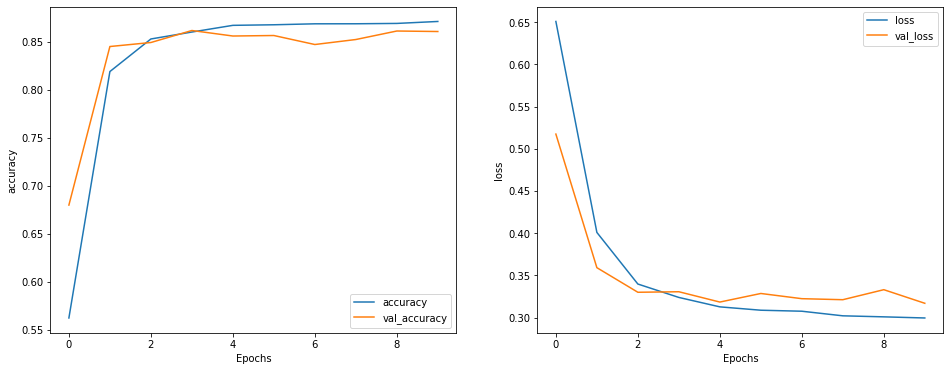

In [28]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).
